In [18]:
import numpy as np
import os
import scipy
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import wandb
import itertools
wandb.login()
pd.set_option('display.max_rows', 200)
plotting_context = "paper"
default_palette = "colorblind"
#granularity_palette = sns.color_palette('coolwarm', 2)
granularity_palette = sns.color_palette(["#3fad82", "#B28ECF"], 2)
local_sps_palette = sns.color_palette("Set2", 3)
cv_palette = sns.color_palette("YlOrRd", 5)
nlp_palette = sns.color_palette("YlGnBu", 2)
nlp_ext_palette = sns.color_palette("YlGnBu", 4)
asr_palette = sns.color_palette("magma", 3)
cv_nlp_palette = sns.color_palette(["#c90823", "#225da8"], 2)
font_scale = 1.5
sns.set(font_scale=font_scale, context=plotting_context)
sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})
WANDB_ENTITY = "kubework"
WANDB_PROJECT = "paper-2023"

def get_env(var):
    val = os.getenv(var)
    if val == None:
        raise ValueError(f"Environment variable {var} is not set. Please follow the README.md instructions and start the notebook with all environment variables set.")
    else:
        print(f"{var}:{val}")
    return val

LOG_PATH=get_env("LOG_PATH")
NETWORK_PATH=get_env("NETWORK_LOG_PATH")
FIGURE_PATH=get_env("FIGURE_PATH")

def save_figure(name, local_fig_dir, file_type='pdf'):
    '''Save matplotlib figures at a local directory based on the full hardcoded path
    :param name: str - name of the pdf figure (e.g., "throughput")
    :param local_fig_dir: str - plots are saved under a subdirectory based on the pipeline (e.g., "image-pipeline")
    '''
    figure_path   = FIGURE_PATH
    full_fig_dir  = figure_path + "/" + local_fig_dir
    full_fig_path = full_fig_dir + "/" + name + "." + file_type
    dpi = 300
    plt.savefig(full_fig_path, dpi=dpi, bbox_inches = "tight")
    
def save_fig(name, file_type='pdf'):
    save_figure(name, local_fig_dir="misc", file_type=file_type)
    
def set_fontsizes(small=8, medium=10, bigger=12):
    SMALL_SIZE = small
    MEDIUM_SIZE = medium
    BIGGER_SIZE = bigger

    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
    
    plt.rcParams['legend.title_fontsize'] = MEDIUM_SIZE

LOG_PATH:../../artifacts/wandb
NETWORK_LOG_PATH:../../artifacts/networking/logs
FIGURE_PATH:../../../vldb-2023-submission/figures


In [122]:
api = wandb.Api()

def get_runs(run_name: str):
    """
    """
    entity = WANDB_ENTITY
    project = WANDB_PROJECT
    path = entity + "/" + project
    key = "config.run_name"
    filters = { key: run_name }
    return api.runs(path=path, filters=filters)

def get_history_non_cached(run, keys):
    history = run.scan_history(keys=keys)
    output = []
    for row in history:
        row_output = {}
        for key in keys:
            row_output[key] = row[key]
        output.append(row_output)
    return pd.DataFrame(output)

def get_history(run, cache=True):
    run_name = run.config.get("run_name")
    host_name = run.config.get("host")
    history_run_path = f"{LOG_PATH}/{run_name}-{host_name}.csv"
    if cache and os.path.isfile(history_run_path):
        return pd.read_csv(history_run_path)
    else:
        history = run.scan_history()
        dataframe_content = []
        for row in history:
            dataframe_content.append(row)
        df = pd.DataFrame(dataframe_content)
        df.to_csv(history_run_path, index=False)
        return df

def get_run_by_prefix(runs, prefix):
    prefixed_runs = []
    for run in runs:
        if run.name.startswith(prefix):
            prefixed_runs.append(run)
    print(f"> Found {len(prefixed_runs)} runs with the prefix '{prefix}'.")
    return prefixed_runs

def get_run_by_infix(runs, infix):
    infixed_runs = []
    for run in runs:
        if infix in run.name:
            infixed_runs.append(run)
    print(f"> Found {len(infixed_runs)} runs with the infix '{infix}'.")
    return infixed_runs

def get_clean_history(run, filter_by="hivemind", cache=True):
    """Tries to fix the two async wandb threads that logged together.
    :filter_by:
        - "hivemind": tries to fix the history
        - "hardware": returns the history without fixing, as we don't need perfect sync here
    """
    history_df = get_history(run, cache=cache)
    if "baseline" in run.config.get("run_name"):
        additional_keys = ['01_general/step_based_sps']
    else:
        additional_keys = ['03_hivemind/num_peers',
                           '03_hivemind/global_epoch']
    if filter_by == "hivemind":
        keys = ['01_general/locally_processed_samples',
                '01_general/lr',
                '01_general/step',
                #'01_general/minibatch_loss', # loss.item() was too often None for NLP baseline, non NaN
                '01_general/dataset_iteration_count',
                '02_timing/dataload_time_s',
                '02_timing/dataload_cuda_move_time_s',
                '02_timing/forward_time_s',
                '02_timing/backward_time_s',
                '02_timing/loss_calc_time_s',
                '02_timing/opt_step_time_s',
                '02_timing/step_time_s', 
                '_step',
                '_runtime',
                ] + additional_keys
        filtered_history_df = history_df[keys]
        return merge_rows(df=filtered_history_df, ignore_cols=['_step','_runtime'])
    elif filter_by == "hardware":
        keys = [
            'memory/total_memory_sys_MB',
            'memory/used_memory_sys_MB',
            'memory/available_memory_sys_MB',
            'memory/used_memory_sys_percent',
            'process/memory/virtual_memory_size_proc_MB',
            'process/memory/text_resident_set_proc_MB', 
            'process/memory/shared_memory_proc_MB',
            'process/memory/dirty_pages_proc_count',
            'process/memory/data_resident_set_proc_MB',
            'process/memory/resident_set_size_proc_MB',
            'process/memory/lib_memory_proc_MB',
            'process/voluntary_proc_ctx_switches',
            'process/involuntary_proc_ctx_switches',
            'bandwidth/disk_read_sys_bandwidth_MBs',
            'bandwidth/disk_write_sys_bandwidth_MBs',
            'bandwidth/net_sent_sys_bandwidth_Mbits',
            'bandwidth/net_recv_sys_bandwidth_Mbits',
            'disk/time/disk_busy_time_sys_s',
            'disk/time/disk_write_time_sys_s',
            'disk/time/disk_read_time_sys_s',
            'disk/counter/disk_read_sys_count',
            'disk/counter/disk_write_sys_count',
            'cpu/interrupts/ctx_switches_count',
            'cpu/interrupts/soft_interrupts_count',
            'cpu/logical_core_count',
            'cpu/interrupts/interrupts_count',
            'cpu/load/avg_sys_load_one_min_percent',
            'cpu/load/avg_sys_load_five_min_percent',
            'cpu/load/avg_sys_load_fifteen_min_percent',
            '_step',
            '_runtime',
        ]
        return history_df[keys]
    else:
        raise ValueError(f"filter_by: {filter_by} not known.")

def merge_rows(df, ignore_cols):
    """Merges rows with interleaved NaNs.
    rowA = [1,     2, NaN,   4, NaN]
    rowB = [NaN, NaN,   3, NaN,   5]
    => result [1, 2, 3, 4, 5]
    
    :df: pd.DataFrame to be merged
    :ignore_cols: list(), keys in this list are merged by using the max(valA, valB) value, e.g. "_step"
    :returns: pd.DataFrame which is merged
    """
    # 1. Drop all full NaN rows
    temp_df = df.dropna(how="all")
    # 2. Iterate over all the rows by keeping a temp row which is filled successivley
    clean_rows = []
    prev_row = None
    cleaned_row_counter = 0
    for ix, row in temp_df.iterrows():
        row_dict = dict(row)
        # 2.1 If the temporary row is commited, start with the new row
        if prev_row == None:
            # 2.1.1 If the new row has NaN values, set it "to be completed"
            if any_values_are_nan(row_dict):
                prev_row = row_dict
            else:
            # 2.1.2 If the new row is complete, commit it
                clean_rows.append(row_dict)
        # 2.2 If we have a row to be completed, try to fill the values with the next row
        else:
            temp_row = merge_dicts(dictA=prev_row, dictB=row, ignore_cols=ignore_cols)
            # 2.2.1 If there are still NaNs, keep it for next processing
            if any_values_are_nan(temp_row):
                prev_row = temp_row
            # 2.2.2 If no NaNs exist anymore, commit and prepare for next row
            else:
                clean_rows.append(temp_row)
                prev_row = None
    return pd.DataFrame(clean_rows)

def merge_dicts(dictA, dictB, ignore_cols):
    """Merges two dicts together by filling the NaN values.
    If not in :ignore_cols: and both values are non NaN, an exception is thrown.
    Both dicts have the same keys.
    :dictA: dict()
    :dictB: dict()
    :ignore_cols: list(), the value of these keys will be decided by a max(a,b)
    :returns: dict()
    """
    result = {}
    for key in dictA:     
        if key in ignore_cols and \
            not math.isnan(dictA[key]) and \
            not math.isnan(dictB[key]):
            result[key] = max(dictA[key], dictB[key])
        else:
            try:
                result[key] = return_non_nan(dictA[key], dictB[key])
            except ValueError:
                print(f"Values ({dictA[key]}) and ({dictB[key]}) for key ({key}) are neither NaN, picking max.")
                result[key] = max(dictA[key], dictB[key])
    return result

def any_values_are_nan(dictionary):
    """
    """
    return any([math.isnan(dictionary[key]) for key in dictionary])
        
def return_non_nan(a, b):
    if math.isnan(a) and math.isnan(b):
        return a
    if math.isnan(a) and not math.isnan(b):
        return b
    if not math.isnan(a) and math.isnan(b):
        return a
    if not math.isnan(a) and not math.isnan(b):
        raise ValueError(f"Tuple (a,b) of ({a}, {b}) are neither NaN.")

def round_bar_value_multi(ax, decimals=2, add_height=0):
    for containers in ax.containers:
        for container in containers:
            container.set_height(round(container.get_height(), decimals))
        ax.bar_label(containers)
        
def show_values_on_barplot(ax, add_height, height_dict={}, rotation=0, decimals=2, fontsize=16):
    
    for i, p in enumerate(ax.patches):
        
        if str(i) in height_dict:
            additional_height = height_dict[str(i)] + add_height
        else:
            additional_height = add_height
        org_height = p.get_height()
        
        gt_1000 = (org_height / 1000) > 1
        gt_100 = (org_height / 100) > 1
        if gt_1000:
            center_offset = p.get_width() / 3
        elif gt_100:
            center_offset = p.get_width() / 7
        else:
            center_offset = 0 # p.get_width() / 12
            
        if decimals == 0:
            text = f"{int(org_height)}"
        else:
            text = f"{round(org_height, decimals)}"
        ax.text(p.get_x() - center_offset,
                p.get_height() + additional_height,
                text,
                color='black',
                rotation=rotation,
                fontsize=fontsize)

In [24]:
def get_baseline_runs(run_names):
    baseline_runs = [get_runs(run_name=run_name)[0] for run_name in run_names]
    baseline_dfs = []
    keys = ["01_general/step_based_sps"]
    for run in baseline_runs:
        baseline_df = get_clean_history(run = run, filter_by="hivemind")
        baseline_df = baseline_df[keys]
        baseline_df["name"] = "-".join(run.config.get("run_name").split(".")[0].split("-")[:2])
        if "torchvision" in run.config.get("run_name"):
            baseline_df["model"] = run.config.get("run_name").split(".")[-1]
        if "roberta" in run.config.get("run_name"):
            baseline_df["model"] = run.config.get("run_name").split("-")[-1]
        if "whisper" in run.config.get("run_name"):
            if "tiny" in run.config.get("run_name"):
                baseline_df["model"] = "WhisperTiny"
            elif "small" in run.config.get("run_name"):
                baseline_df["model"] = "WhisperSmall"
            elif "whisper-base" in run.config.get("run_name"):
                baseline_df["model"] = "WhisperBase"
            else:
                baseline_df["model"] = run.config.get("run_name")
        baseline_df["TBS"] = run.config.get("batch_size_per_step") * run.config.get("gradient_accumulation_steps")
        baseline_df = baseline_df.rename(columns={"01_general/step_based_sps": "samples_per_sec"})
        baseline_dfs.append(baseline_df)
    return pd.concat(objs=baseline_dfs)

def get_hivemind_runs(run_names, drop_first_epoch=True):
    
    hivemind_176_add = False
    # adding manually as W&B API does not see this run because it was deleted and restored
    if "hivemind-176" in run_names:
        run_names.remove("hivemind-176")
        hivemind_176_add = True
        
    hivemind_runs = [get_run_by_prefix(
                        runs = get_runs(run_name = run_name),
                        prefix = "trainmonitor")[0]
                     for run_name in run_names]
    if hivemind_176_add:
        # trainmonitor-176
        hivemind_runs.append(api.run(path="kubework/paper-2023/1e4zlzpd"))
    hivemind_dfs = []
    
    keys = ["03_hivemind/optimistic_total_samples_per_second",
            "03_hivemind/epoch_based_sps"]
    
    for run in hivemind_runs:
        hivemind_df = get_history(run = run)
        hivemind_df = hivemind_df[keys]
        hivemind_df["name"] = run.config.get("run_name")
        hivemind_df["model"] = run.config.get("model").split(".")[-1]
        hivemind_df["TBS"] = run.config.get("target_batch_size")
        hivemind_df = hivemind_df.rename(columns={"03_hivemind/epoch_based_sps": "samples_per_sec"})
        hivemind_df = hivemind_df.rename(columns={"03_hivemind/optimistic_total_samples_per_second": "local samples_per_sec"})
        if drop_first_epoch:
            # get index of the first epoch value
            first_index = hivemind_df.query("samples_per_sec.notna()").index[0]
            # get index of last epoch value
            last_index = hivemind_df.query("samples_per_sec.notna()").index[-1]
            # start the dataframe from the next value
            hivemind_df = hivemind_df[first_index+1:last_index+1]
        hivemind_dfs.append(hivemind_df)
    return pd.concat(objs=hivemind_dfs)

def rename_models(df):
    #df = df.replace("resnet18", "ResNet18")
    #df = df.replace("resnet50", "ResNet50")
    #df = df.replace("resnet152", "ResNet152")
    #df = df.replace("wide_resnet101_2", "WideResNet101_2")
    #df = df.replace("convnext_large", "ConvNextLarge")
    #df = df.replace("roberta_mlm_base", "RoBERTaBase")
    #df = df.replace("roberta_mlm_large", "RoBERTaLarge")
    #df = df.replace("roberta_mlm_xlm", "RoBERTaXLM")
    df = df.replace("resnet18", "RN18")
    df = df.replace("resnet50", "RN50")
    df = df.replace("resnet152", "RN152")
    df = df.replace("wide_resnet101_2", "WRN101")
    df = df.replace("convnext_large", "CONV")
    df = df.replace("roberta_mlm_base", "RBase")
    df = df.replace("roberta_mlm_large", "RLrg")
    df = df.replace("roberta_mlm_xlm", "RXLM")
    df = df.replace("whisper-tiny", "WhisperTiny")
    df = df.replace("whisper-base", "WhisperBase")
    df = df.replace("whisper-small", "WhisperSmall")
    return df

def compute_local_step_cutoff(df, debug=False):
    """We get a unimodal time series with 3 outliers (sync steps)
    Returning a cutoff where all of the outliers are included.
    """
    median = df.median()
    std = df.std()
    cutoff = median + 2*std # 95% of all data should be included here
    if debug:
        print(f">> Found {len(df.index[df >= cutoff].tolist())} sync steps")
    return cutoff

def get_aggregated_step_timings(df, agg = "sum", clean = True, debug=False):
    
    # 02_timing/dataload_time_s - unimodal with one startup outlier
    # 02_timing/dataload_cuda_move_time_s - unimodal
    # 02_timing/forward_time_s - unimodal
    # 02_timing/loss_calc_time_s - unimodal
    # 02_timing/backward_time_s - unimodal
    # 02_timing/opt_step_time_s - bi/tri-modal
    # 02_timing/step_time_s - bi/tri-modal
    
    agg_dict = {}
    # opt_step_time_data.plot.hist()    
    # opt.step() is basically a no-op
    
    # detect the outliers (sync-steps) and decide on a cutoff
    # which includes all of them (the fastest sync step)
    NON_LOCAL_STEP_CUTOFF_S = compute_local_step_cutoff(df["02_timing/opt_step_time_s"], debug=debug)
        
    # exclude the first hivemind epoch from logging
    if clean:
        averaging_ix = df.index[df["02_timing/opt_step_time_s"] >= NON_LOCAL_STEP_CUTOFF_S].tolist()
        #assert(len(averaging_ix) >= 2), f"At least 2x averaging indices should be included: {averaging_ix}"
        first_averaging_ix = averaging_ix[0] + 1 # starting from the next step
        cleaned_df = df[first_averaging_ix:]
    else:
        cleaned_df = df
    
    opt_step_time_data = cleaned_df["02_timing/opt_step_time_s"]
    
    if agg == "sum":
        agg_dict["dataload_s"] = cleaned_df["02_timing/dataload_time_s"].sum()
        agg_dict["cuda_move_s"] = cleaned_df["02_timing/dataload_cuda_move_time_s"].sum()
        agg_dict["forward_s"] = cleaned_df["02_timing/forward_time_s"].sum()
        agg_dict["loss_calc_s"] = cleaned_df["02_timing/loss_calc_time_s"].sum()
        agg_dict["backward_s"] = cleaned_df["02_timing/backward_time_s"].sum()
        agg_dict["opt_step_local_s"] = opt_step_time_data[opt_step_time_data < NON_LOCAL_STEP_CUTOFF_S].sum()
        agg_dict["opt_step_sync_s"] = opt_step_time_data[opt_step_time_data >= NON_LOCAL_STEP_CUTOFF_S].sum()
    elif agg == "mean":
        agg_dict["dataload_s"] = cleaned_df["02_timing/dataload_time_s"].mean()
        agg_dict["cuda_move_s"] = cleaned_df["02_timing/dataload_cuda_move_time_s"].mean()
        agg_dict["forward_s"] = cleaned_df["02_timing/forward_time_s"].mean()
        agg_dict["loss_calc_s"] = cleaned_df["02_timing/loss_calc_time_s"].mean()
        agg_dict["backward_s"] = cleaned_df["02_timing/backward_time_s"].mean()
        agg_dict["opt_step_local_s"] = opt_step_time_data[opt_step_time_data < NON_LOCAL_STEP_CUTOFF_S].mean()
        agg_dict["opt_step_sync_s"] = opt_step_time_data[opt_step_time_data >= NON_LOCAL_STEP_CUTOFF_S].mean()
         
    # wrap in lists for pandas df creation
    for key in agg_dict.keys(): agg_dict[key] = [agg_dict[key]]
    
    return pd.DataFrame(agg_dict)


def hivemind_run_step_breakdown(run_name: str, agg = "sum", debug=False):
    # filter all runs by workers
    hivemind_runs = get_run_by_infix(
        runs = get_runs(run_name = run_name),
        infix = "bee")    
    filtered_run = lambda name: any(
        [
            "bee-gc-t4-3-hivemind-369" in name, # tiny 8xt8 broken logs due to non-participation
            "bee-gc-t4-6-hivemind-369" in name,
            "bee-gc-t4-7-hivemind-369" in name,
            "bee-gc-t4-8-hivemind-369" in name, # ---
            #"bee-gc-t4-1-hivemind-370" in name, # base 8xt8 broken logs due to non-participation
            "bee-gc-t4-2-hivemind-370" in name, #
            #"bee-gc-t4-3-hivemind-370" in name, #
            "bee-gc-t4-4-hivemind-370" in name, #
            "bee-gc-t4-5-hivemind-370" in name, #
            "bee-gc-t4-6-hivemind-370" in name, #
            "bee-gc-t4-7-hivemind-370" in name, #
            "bee-gc-t4-8-hivemind-370" in name, # ---
            #"bee-gc-t4-1-hivemind-371" in name, # small 8xt8 broken logs due to non-participation
            #"bee-gc-t4-2-hivemind-371" in name, #
            #"bee-gc-t4-3-hivemind-371" in name, #
            #"bee-gc-t4-4-hivemind-371" in name, #
            #"bee-gc-t4-5-hivemind-371" in name, #
            #"bee-gc-t4-6-hivemind-371" in name, #
            "bee-gc-t4-7-hivemind-371" in name, #
            #"bee-gc-t4-8-hivemind-371" in name, # ---

        ]
    )
    
    hivemind_runs = [run for run in hivemind_runs if not filtered_run(run.name)]
    aggregated_dfs = []
    
    # aggregate gpu runs
    for gpu_run in hivemind_runs:
        gpu_agg_df = get_aggregated_step_timings(
            df=get_clean_history(
                run=gpu_run, filter_by="hivemind"),
            agg=agg,
            debug=debug)
        gpu_agg_df["name"] = gpu_run.config.get("host")
        aggregated_dfs.append(gpu_agg_df)
    
    return pd.concat(objs=aggregated_dfs)

def calc_granularity(df):
    '''Higher is better'''
    full_calc_time_key = "dl_calc_time_s"
    clean_calc_time_key = "calc_time_s"
    communication_time_key = "comm_time_s"
    
    df[full_calc_time_key] = df["dataload_s"] + df["cuda_move_s"] + df["forward_s"] + \
                           df["loss_calc_s"] + df["backward_s"] + df["opt_step_local_s"]
    df[clean_calc_time_key] = df["cuda_move_s"] + df["forward_s"] + df["loss_calc_s"] + \
                              df["backward_s"] + df["opt_step_local_s"]
    df[communication_time_key] = df["opt_step_sync_s"]
    df["granularity"] = round(df[clean_calc_time_key][0] / df[communication_time_key][0],2)
    return df

def hivemind_step_granularity(run_name, debug=False):
    df = hivemind_run_step_breakdown(run_name=run_name, agg="sum", debug=debug)
    return calc_granularity(df=df)

def plot_granularity_all_nodes(run_name):
    sns.set(palette=default_palette)
    temp_df = hivemind_step_granularity(run_name=run_name)
    ax = temp_df[["calc_time_s","comm_time_s","name"]].set_index('name').plot(kind='bar', stacked=True)
    plt.ylabel("Time in Seconds")
    plt.xlabel("")
    
def get_granularity_cumulated(run_name, name, debug=False, plot=False):
    df = hivemind_step_granularity(run_name=run_name, debug=debug)
    mean_df = df.mean(numeric_only=True).to_frame().T
    mean_df["name"] = name
    if plot:
        sns.set(palette=default_palette)
        ax = mean_df[["calc_time_s","comm_time_s","name"]].set_index('name').plot(kind='bar', stacked=True)
        plt.ylabel("Time in Seconds")
        plt.xlabel("")
    return mean_df

def transform_to_compare_local_sps(df):
    local_sps_key = "local samples_per_sec"
    global_sps_key = "samples_per_sec"
    
    temp_dict = {
        "name": df["name"],
        "model": df["model"],
        "TBS": df["TBS"],
        "gpu_count": df["gpu_count"],
        "gpu_type": df["gpu_type"],
        "sps": [],
        "sps_type": []
    }
    for ix, row in df.iterrows():
        if not math.isnan(row[global_sps_key]):
            temp_dict["sps"].append(row[global_sps_key])
            temp_dict["sps_type"].append("hivemind global")
        else:
            temp_dict["sps"].append(row[local_sps_key])
            temp_dict["sps_type"].append("hivemind local")
    return pd.DataFrame(temp_dict)

# CV Model Suitability Study

### CV A10 Baseline

In [25]:
cv_a10_baseline_df = get_baseline_runs(run_names=[
    "baseline-161-torchvision.models.resnet18", #"baseline-0-torchvision.models.resnet18",
    "baseline-162-torchvision.models.resnet18", #"baseline-1-torchvision.models.resnet18",
    "baseline-163-torchvision.models.resnet18", #"baseline-2-torchvision.models.resnet18",
    "baseline-164-torchvision.models.resnet50", #"baseline-3-torchvision.models.resnet50",
    "baseline-165-torchvision.models.resnet50", #"baseline-4-torchvision.models.resnet50",
    "baseline-166-torchvision.models.resnet50", #"baseline-5-torchvision.models.resnet50",
    "baseline-6-torchvision.models.resnet152",
    "baseline-7-torchvision.models.resnet152",
    "baseline-8-torchvision.models.resnet152",
    "baseline-9-torchvision.models.wide_resnet101_2",
    "baseline-10-torchvision.models.wide_resnet101_2",
    "baseline-11-torchvision.models.wide_resnet101_2",
    "baseline-12-torchvision.models.convnext_large",
    "baseline-191-torchvision.models.convnext_large",
    "baseline-192-torchvision.models.convnext_large",
    ])
cv_a10_baseline_df = rename_models(df = cv_a10_baseline_df)
cv_a10_baseline_df["gpu_count"] = int(1)
cv_a10_baseline_df["gpu_type"] = "A10"

### CV 2xA10, 3xA10, 4xA10, 8xA10

In [26]:
cv_a10_2x_runs_df = get_hivemind_runs(run_names=[
    "hivemind-282", # 8k rn18
    "hivemind-285", # 8k rn50
    "hivemind-286", # 8k rn152
    "hivemind-291", # 8k wrn101
    "hivemind-292", # 8k conv
    "hivemind-283", # 16k rn18
    "hivemind-287", # 16k rn50
    "hivemind-288", # 16k rn152
    "hivemind-293", # 16k wrn101
    "hivemind-294", # 16k conv
    "hivemind-284", # 32k rn18
    "hivemind-289", # 32k rn50
    "hivemind-290", # 32k rn152
    "hivemind-295", # 32k wrn101
    "hivemind-296", # 32k conv
    ],
    drop_first_epoch=True
)
cv_a10_2x_runs_df = rename_models(df = cv_a10_2x_runs_df)
cv_a10_2x_runs_df["gpu_count"] = int(2)
cv_a10_2x_runs_df["gpu_type"] = "A10"
cv_a10_2x_runs_df["local_sps_normalized"] = cv_a10_2x_runs_df["local samples_per_sec"] / cv_a10_2x_runs_df["gpu_count"]

cv_a10_3x_runs_df = get_hivemind_runs(run_names=[
    "hivemind-306",
    "hivemind-307",
    "hivemind-308",
    "hivemind-309",
    "hivemind-310"
    ],
    drop_first_epoch=True
)
cv_a10_3x_runs_df = rename_models(df = cv_a10_3x_runs_df)
cv_a10_3x_runs_df["gpu_count"] = int(3)
cv_a10_3x_runs_df["gpu_type"] = "A10"
cv_a10_3x_runs_df["local_sps_normalized"] = cv_a10_3x_runs_df["local samples_per_sec"] / cv_a10_3x_runs_df["gpu_count"]

cv_a10_4x_runs_df = get_hivemind_runs(run_names=[
    "hivemind-315",
    "hivemind-316",
    "hivemind-317",
    "hivemind-318",
    "hivemind-319"
    ],
    drop_first_epoch=True
)
cv_a10_4x_runs_df = rename_models(df = cv_a10_4x_runs_df)
cv_a10_4x_runs_df["gpu_count"] = int(4)
cv_a10_4x_runs_df["gpu_type"] = "A10"
cv_a10_4x_runs_df["local_sps_normalized"] = cv_a10_4x_runs_df["local samples_per_sec"] / cv_a10_4x_runs_df["gpu_count"]

cv_a10_8x_runs_df = get_hivemind_runs(run_names=[
    "hivemind-325",
    "hivemind-326",
    "hivemind-327",
    "hivemind-328",
    "hivemind-330"
    ],
    drop_first_epoch=True
)
cv_a10_8x_runs_df = rename_models(df = cv_a10_8x_runs_df)
cv_a10_8x_runs_df["gpu_count"] = int(8)
cv_a10_8x_runs_df["gpu_type"] = "A10"
cv_a10_8x_runs_df["local_sps_normalized"] = cv_a10_8x_runs_df["local samples_per_sec"] / cv_a10_8x_runs_df["gpu_count"]

> Found 1 runs with the prefix 'trainmonitor'.
> Found 1 runs with the prefix 'trainmonitor'.
> Found 1 runs with the prefix 'trainmonitor'.
> Found 1 runs with the prefix 'trainmonitor'.
> Found 1 runs with the prefix 'trainmonitor'.
> Found 1 runs with the prefix 'trainmonitor'.
> Found 1 runs with the prefix 'trainmonitor'.
> Found 1 runs with the prefix 'trainmonitor'.
> Found 1 runs with the prefix 'trainmonitor'.
> Found 1 runs with the prefix 'trainmonitor'.
> Found 1 runs with the prefix 'trainmonitor'.
> Found 1 runs with the prefix 'trainmonitor'.
> Found 1 runs with the prefix 'trainmonitor'.
> Found 1 runs with the prefix 'trainmonitor'.
> Found 1 runs with the prefix 'trainmonitor'.
> Found 1 runs with the prefix 'trainmonitor'.
> Found 1 runs with the prefix 'trainmonitor'.
> Found 1 runs with the prefix 'trainmonitor'.
> Found 1 runs with the prefix 'trainmonitor'.
> Found 1 runs with the prefix 'trainmonitor'.
> Found 1 runs with the prefix 'trainmonitor'.
> Found 1 run

In [27]:
full_cv_a10_runs_df = pd.concat(objs=[
    cv_a10_baseline_df,
    cv_a10_2x_runs_df,
    cv_a10_3x_runs_df,
    cv_a10_4x_runs_df,
    cv_a10_8x_runs_df])

/home/asa/miniconda3/envs/hivemind-multi-cloud-eval/lib/python3.9/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/home/asa/miniconda3/envs/hivemind-multi-cloud-eval/lib/python3.9/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/home/asa/miniconda3/envs/hivemind-multi-cloud-eval/lib/python3.9/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/home/asa/miniconda3/envs/hivemind-multi-cloud-eval/lib/python3.9/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/home/asa/miniconda3/envs/hivemind-multi-cloud-eval/lib/python3.9/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/home/asa/miniconda3/envs/hivemind-multi-cloud-eval/lib/pyth

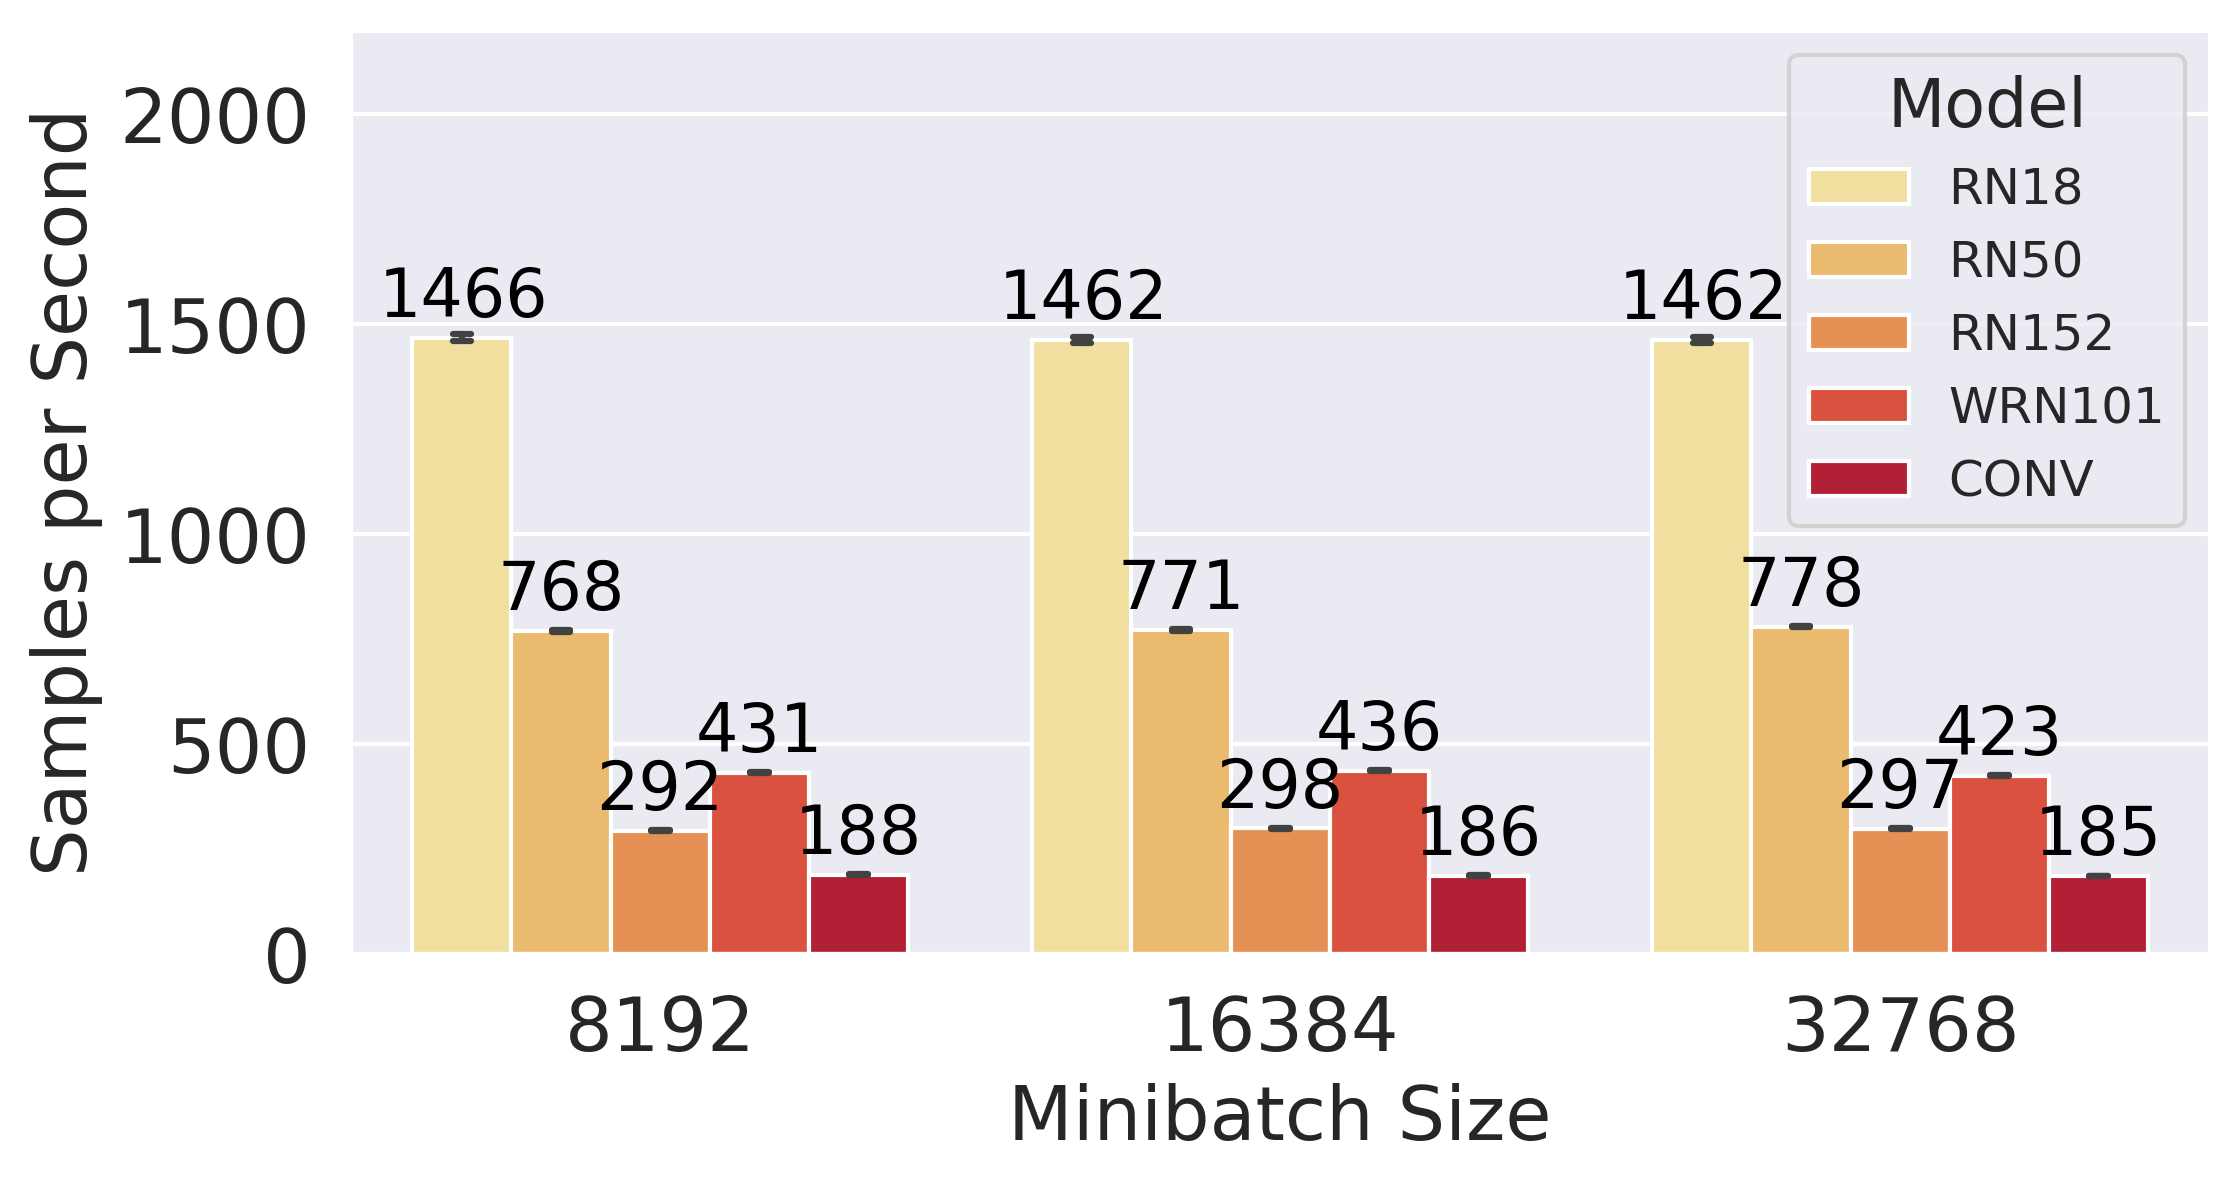

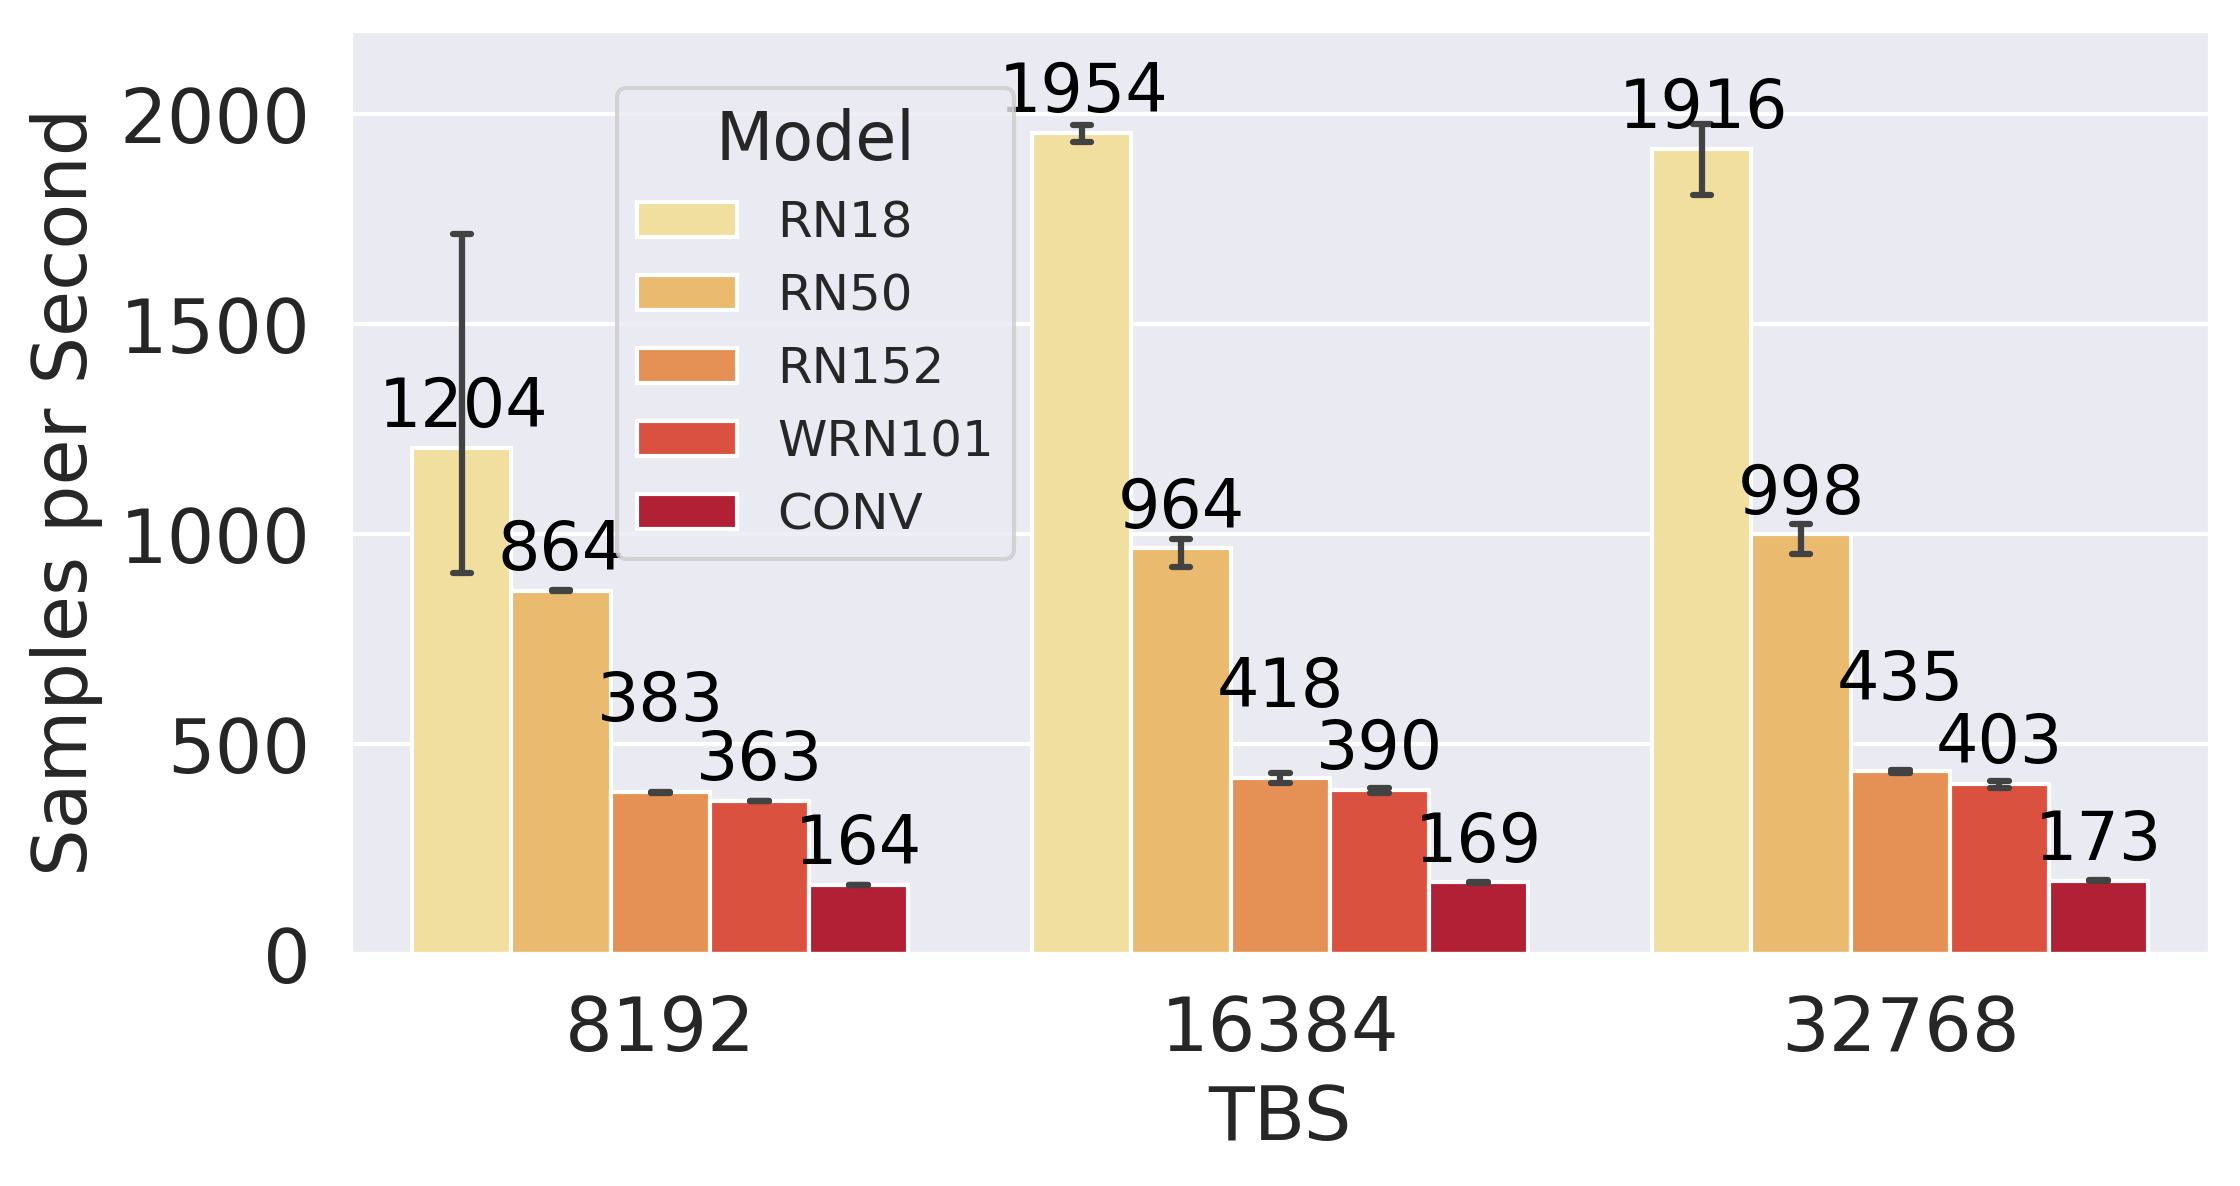

In [96]:
cv_a10_TBS_arg_df = pd.concat(objs=[
    cv_a10_baseline_df,
    cv_a10_2x_runs_df
])

sns.set(palette=cv_palette)
set_fontsizes(18,18,18)

plt.figure(figsize=(8,4))
ax = sns.barplot(
    data=cv_a10_baseline_df,
    x="TBS",
    y="samples_per_sec",
    hue="model",
    errorbar=('ci', 95),
    errwidth=1.5,
    capsize=0.03)
#plt.title("1xA10")
plt.ylim([0,2200])
plt.xlabel("Minibatch Size")
plt.ylabel("Samples per Second")
#sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.legend(title="Model", fontsize=12, title_fontsize=16)#, bbox_to_anchor=(0.425,0.58))
#round_bar_value_multi(ax, decimals=0, add_height=100)
show_values_on_barplot(ax=ax, add_height=50, height_dict={}, decimals=0)
save_fig("cv_1xa10_all-tbs_baseline")

plt.figure(figsize=(8,4))
ax = sns.barplot(
    data=cv_a10_2x_runs_df,
    x="TBS",
    y="samples_per_sec",
    hue="model",
    errorbar=('ci', 95),
    errwidth=1.5,
    capsize=0.03)
#plt.title("2xA10")
plt.ylim([0,2200])
plt.ylabel("Samples per Second")
#sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.legend(title="Model", fontsize=12, title_fontsize=16, bbox_to_anchor=(0.25,0.40))
#round_bar_value_multi(ax, decimals=0)
show_values_on_barplot(ax=ax, add_height=50, height_dict={"6": 120, "7": 120, "8": 120}, decimals=0)
save_fig("cv_2xa10_all-tbs_hivemind")

/tmp/ipykernel_19551/2614000701.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cv_a10_baseline_temp_df["sps_type"] = "baseline"


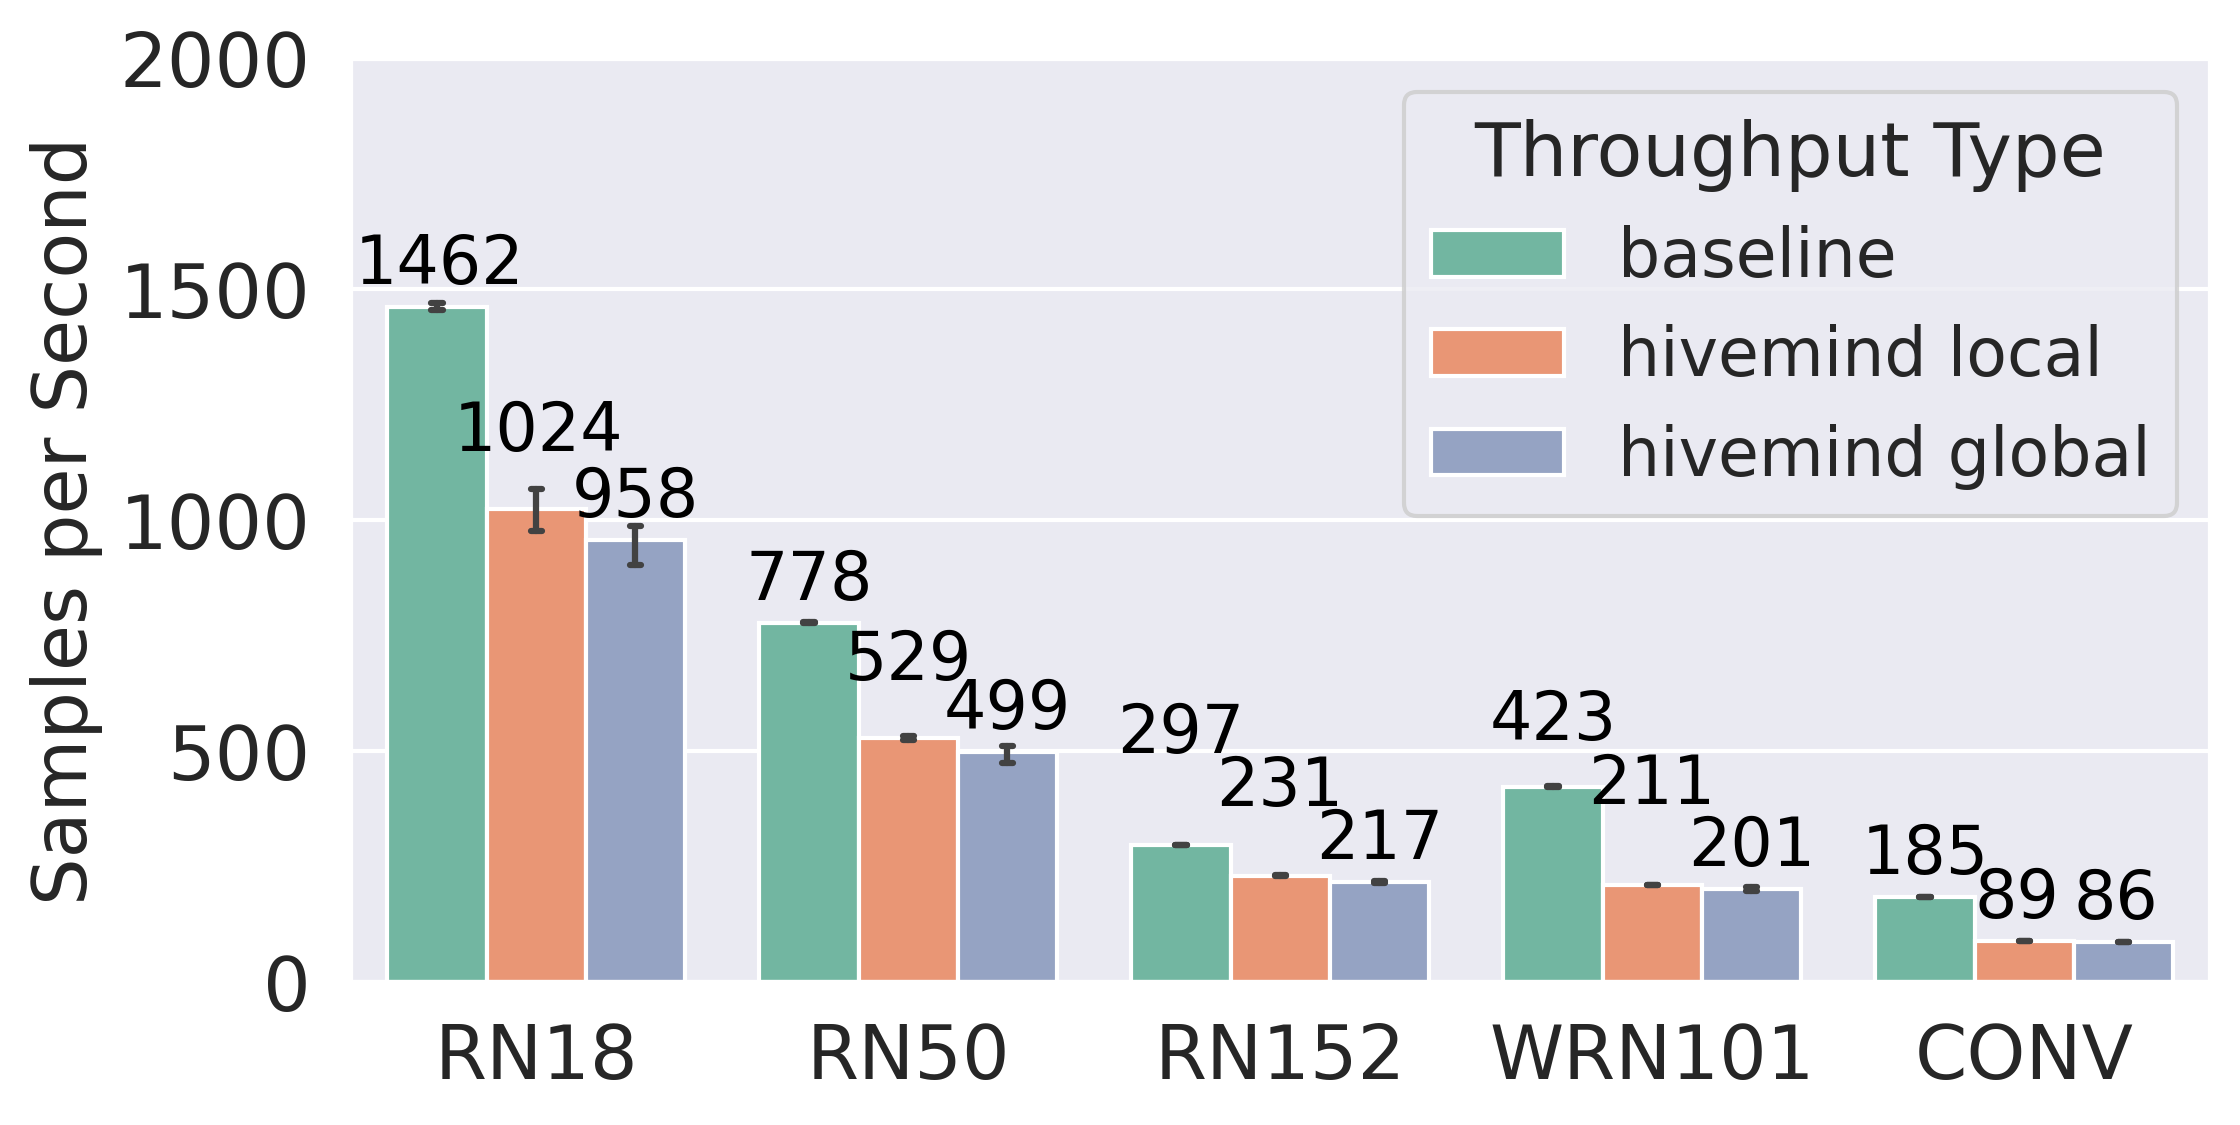

In [126]:
local_TBS = 32768 #8192
cv_a10_baseline_temp_df = cv_a10_baseline_df.query(f"TBS=={local_TBS}")
cv_a10_baseline_temp_df["sps_type"] = "baseline"
cv_a10_baseline_temp_df = cv_a10_baseline_temp_df.rename(columns={"samples_per_sec": "sps"})

cv_a10_2x_runs_local_sps_df = transform_to_compare_local_sps(df=cv_a10_2x_runs_df.query(f"TBS=={local_TBS}"))
cv_a10_1x_2x_runs_local_sps_df = pd.concat(objs=[cv_a10_baseline_temp_df, cv_a10_2x_runs_local_sps_df])
cv_a10_1x_2x_runs_local_sps_df["sps_norm"] = cv_a10_1x_2x_runs_local_sps_df["sps"] / cv_a10_1x_2x_runs_local_sps_df["gpu_count"]

sns.set(palette=local_sps_palette)
set_fontsizes(18,18,18)

plt.figure(figsize=(8,4))
ax = sns.barplot(
    data=cv_a10_1x_2x_runs_local_sps_df,
    x="model",
    y="sps_norm",
    hue="sps_type",
    errorbar=('ci', 95),
    errwidth=1.5,
    capsize=0.03)
#plt.title("2xA10")
plt.xlabel("")
plt.ylabel("Samples per Second")
plt.ylim([0,2000])
plt.legend(title="Throughput Type")
#sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
#round_bar_value_multi(ax, decimals=0)
show_values_on_barplot(ax=ax, add_height=50, height_dict={"2": 150, "3": 50, "5": 75, "6": 75, "7": 100, "8": 125}, decimals=0)
plt.legend(title="Throughput Type", fontsize=16, title_fontsize=18)
#plt.xticks(rotation=10)
save_fig(f"cv_2xa10_{local_TBS}_hivemind_local_sps")

# CV Hivemind Penalty Slowdown Calculation

In [127]:
for model in cv_a10_1x_2x_runs_local_sps_df["model"].unique():
    baseline_speed = cv_a10_1x_2x_runs_local_sps_df.query(f"model=='{model}' and gpu_count==1 and \
                                                             sps_type=='baseline'")["sps"].mean()
    local_speed    = cv_a10_1x_2x_runs_local_sps_df.query(f"model=='{model}' and gpu_count==2 and \
                                                             sps_type=='hivemind local'")["sps_norm"].mean()
    global_speed   = cv_a10_1x_2x_runs_local_sps_df.query(f"model=='{model}' and gpu_count==2 and \
                                                             sps_type=='hivemind global'")["sps_norm"].mean()
    local_slowdown = local_speed / baseline_speed
    global_baseline_slowdown = global_speed / baseline_speed
    global_local_slowdown = global_speed / local_speed
    
    #print(f"{model} Local  reaches only {round(local_slowdown,2)} of baseline speed.")    
    print(f"{model} Global reaches only {round(global_baseline_slowdown,2)} of baseline speed.")   
    #print(f"{model} Global reaches only {round(global_local_slowdown,2)} of local speed.")   

RN18 Global reaches only 0.66 of baseline speed.
RN50 Global reaches only 0.64 of baseline speed.
RN152 Global reaches only 0.73 of baseline speed.
WRN101 Global reaches only 0.48 of baseline speed.
CONV Global reaches only 0.47 of baseline speed.


### Analyzing Granularity Of 2xA10 Experiments

In [128]:
debug = False
rn18_2xA10_8192_df    = get_granularity_cumulated(run_name="hivemind-282", name="RN18 2xA10 8192", debug=debug)
rn50_2xA10_8192_df    = get_granularity_cumulated(run_name="hivemind-285", name="RN50 2xA10 8192", debug=debug)
rn101_2xA10_8192_df   = get_granularity_cumulated(run_name="hivemind-286",  name="RN152 2xA10 8192", debug=debug)
wdrn101_2xA10_8192_df = get_granularity_cumulated(run_name="hivemind-291",  name="WRN101 2xA10 8192", debug=debug)
conv_2xA10_8192_df    = get_granularity_cumulated(run_name="hivemind-292",  name="CONV 2xA10 8192", debug=debug)

rn18_2xA10_16384_df    = get_granularity_cumulated(run_name="hivemind-283", name="RN18 2xA10 16384", debug=debug)
rn50_2xA10_16384_df    = get_granularity_cumulated(run_name="hivemind-287", name="RN50 2xA10 16384", debug=debug)
rn101_2xA10_16384_df   = get_granularity_cumulated(run_name="hivemind-288",  name="RN152 2xA10 16384", debug=debug)
wdrn101_2xA10_16384_df = get_granularity_cumulated(run_name="hivemind-293",  name="WRN101 2xA10 16384", debug=debug)
conv_2xA10_16384_df    = get_granularity_cumulated(run_name="hivemind-294",  name="CONV 2xA10 16384", debug=debug)

rn18_2xA10_32768_df    = get_granularity_cumulated(run_name="hivemind-284", name="RN18 2xA10 32768", debug=debug)
rn50_2xA10_32768_df    = get_granularity_cumulated(run_name="hivemind-289", name="RN50 2xA10 32768", debug=debug)
rn101_2xA10_32768_df   = get_granularity_cumulated(run_name="hivemind-290",  name="RN152 2xA10 32768", debug=debug)
wdrn101_2xA10_32768_df = get_granularity_cumulated(run_name="hivemind-295",  name="WRN101 2xA10 32768", debug=debug)
conv_2xA10_32768_df    = get_granularity_cumulated(run_name="hivemind-296",  name="CONV 2xA10 32768", debug=debug)

> Found 2 runs with the infix 'bee'.
> Found 2 runs with the infix 'bee'.
> Found 2 runs with the infix 'bee'.
> Found 2 runs with the infix 'bee'.
> Found 2 runs with the infix 'bee'.
> Found 2 runs with the infix 'bee'.
> Found 2 runs with the infix 'bee'.
> Found 2 runs with the infix 'bee'.
> Found 2 runs with the infix 'bee'.
> Found 2 runs with the infix 'bee'.
> Found 2 runs with the infix 'bee'.
> Found 2 runs with the infix 'bee'.
> Found 2 runs with the infix 'bee'.
> Found 2 runs with the infix 'bee'.
> Found 2 runs with the infix 'bee'.


In [131]:
def show_granulartiy_values(ax, df, decimals=2, fontsize=12):
    for (p_ix, p) in enumerate(ax.patches):
        if p_ix >= (len(ax.patches) / 2):
            p_ix = p_ix - (len(ax.patches) / 2)
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + p.get_height() + 5
            if decimals == 2:
                value = '{:.2f}'.format(df.iloc[int(p_ix)]["granularity"])
            elif decimals == 1:
                value = '{:.1f}'.format(df.iloc[int(p_ix)]["granularity"])
            ax.text(_x, _y, value, ha="center", fontsize=fontsize)

<Figure size 2400x600 with 0 Axes>

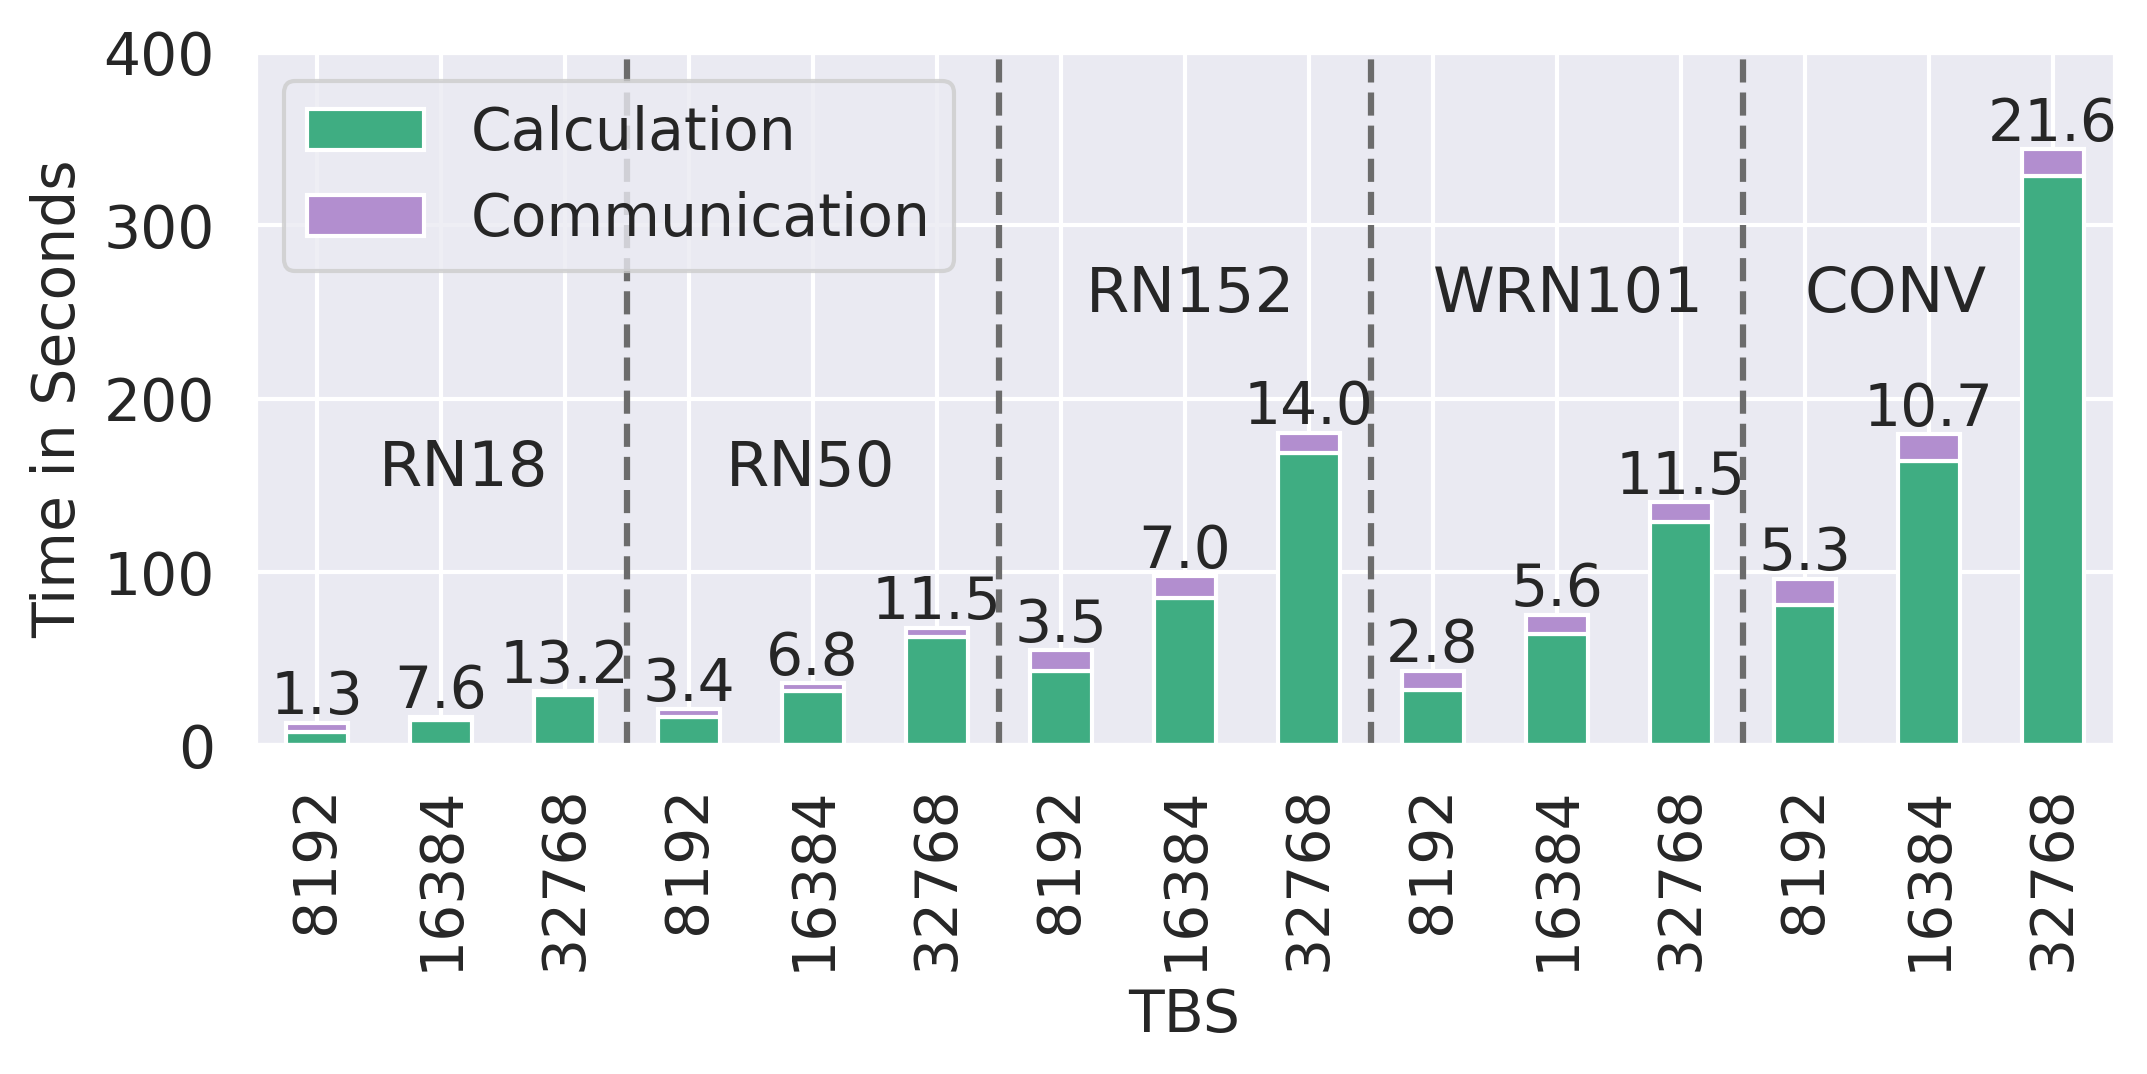

In [135]:
cv_combined_granularity_df = pd.concat(objs=[
    rn18_2xA10_8192_df,
    rn18_2xA10_16384_df,
    rn18_2xA10_32768_df,
    
    rn50_2xA10_8192_df,
    rn50_2xA10_16384_df,
    rn50_2xA10_32768_df,
    
    rn101_2xA10_8192_df,
    rn101_2xA10_16384_df,
    rn101_2xA10_32768_df,
    
    wdrn101_2xA10_8192_df,
    wdrn101_2xA10_16384_df,
    wdrn101_2xA10_32768_df,
    
    conv_2xA10_8192_df,
    conv_2xA10_16384_df,
    conv_2xA10_32768_df
])

sns.set(palette=granularity_palette)
set_fontsizes(14,14,14)

plt.figure(figsize=(8,2))
ax = cv_combined_granularity_df[["calc_time_s","comm_time_s","name"]].set_index('name').plot(kind='bar', stacked=True, figsize=(8,3))
plt.ylabel("Time in Seconds")
plt.xlabel("TBS")
plt.legend(labels=["Calculation", "Communication"])
plt.ylim(0,400)
ax.axvline(2.5, color="#6c6c6c", linestyle="--")
ax.axvline(5.5, color="#6c6c6c", linestyle="--")
ax.axvline(8.5, color="#6c6c6c", linestyle="--")
ax.axvline(11.5, color="#6c6c6c", linestyle="--")
labels = [item.get_text() for item in ax.get_xticklabels()]
labels = ["".join(label.split(" ")[-1]) for label in labels]
ax.set_xticklabels(labels)
ax.text(0.5, 150, "RN18", fontsize=15)
ax.text(3.3, 150, "RN50", fontsize=15)
ax.text(6.2, 250, "RN152", fontsize=15)
ax.text(9, 250, "WRN101", fontsize=15)
ax.text(12, 250, "CONV", fontsize=15)
show_granulartiy_values(ax=ax, df=cv_combined_granularity_df, decimals=1, fontsize=14)
save_fig("cv_2xa10_all-tbs_granularity")

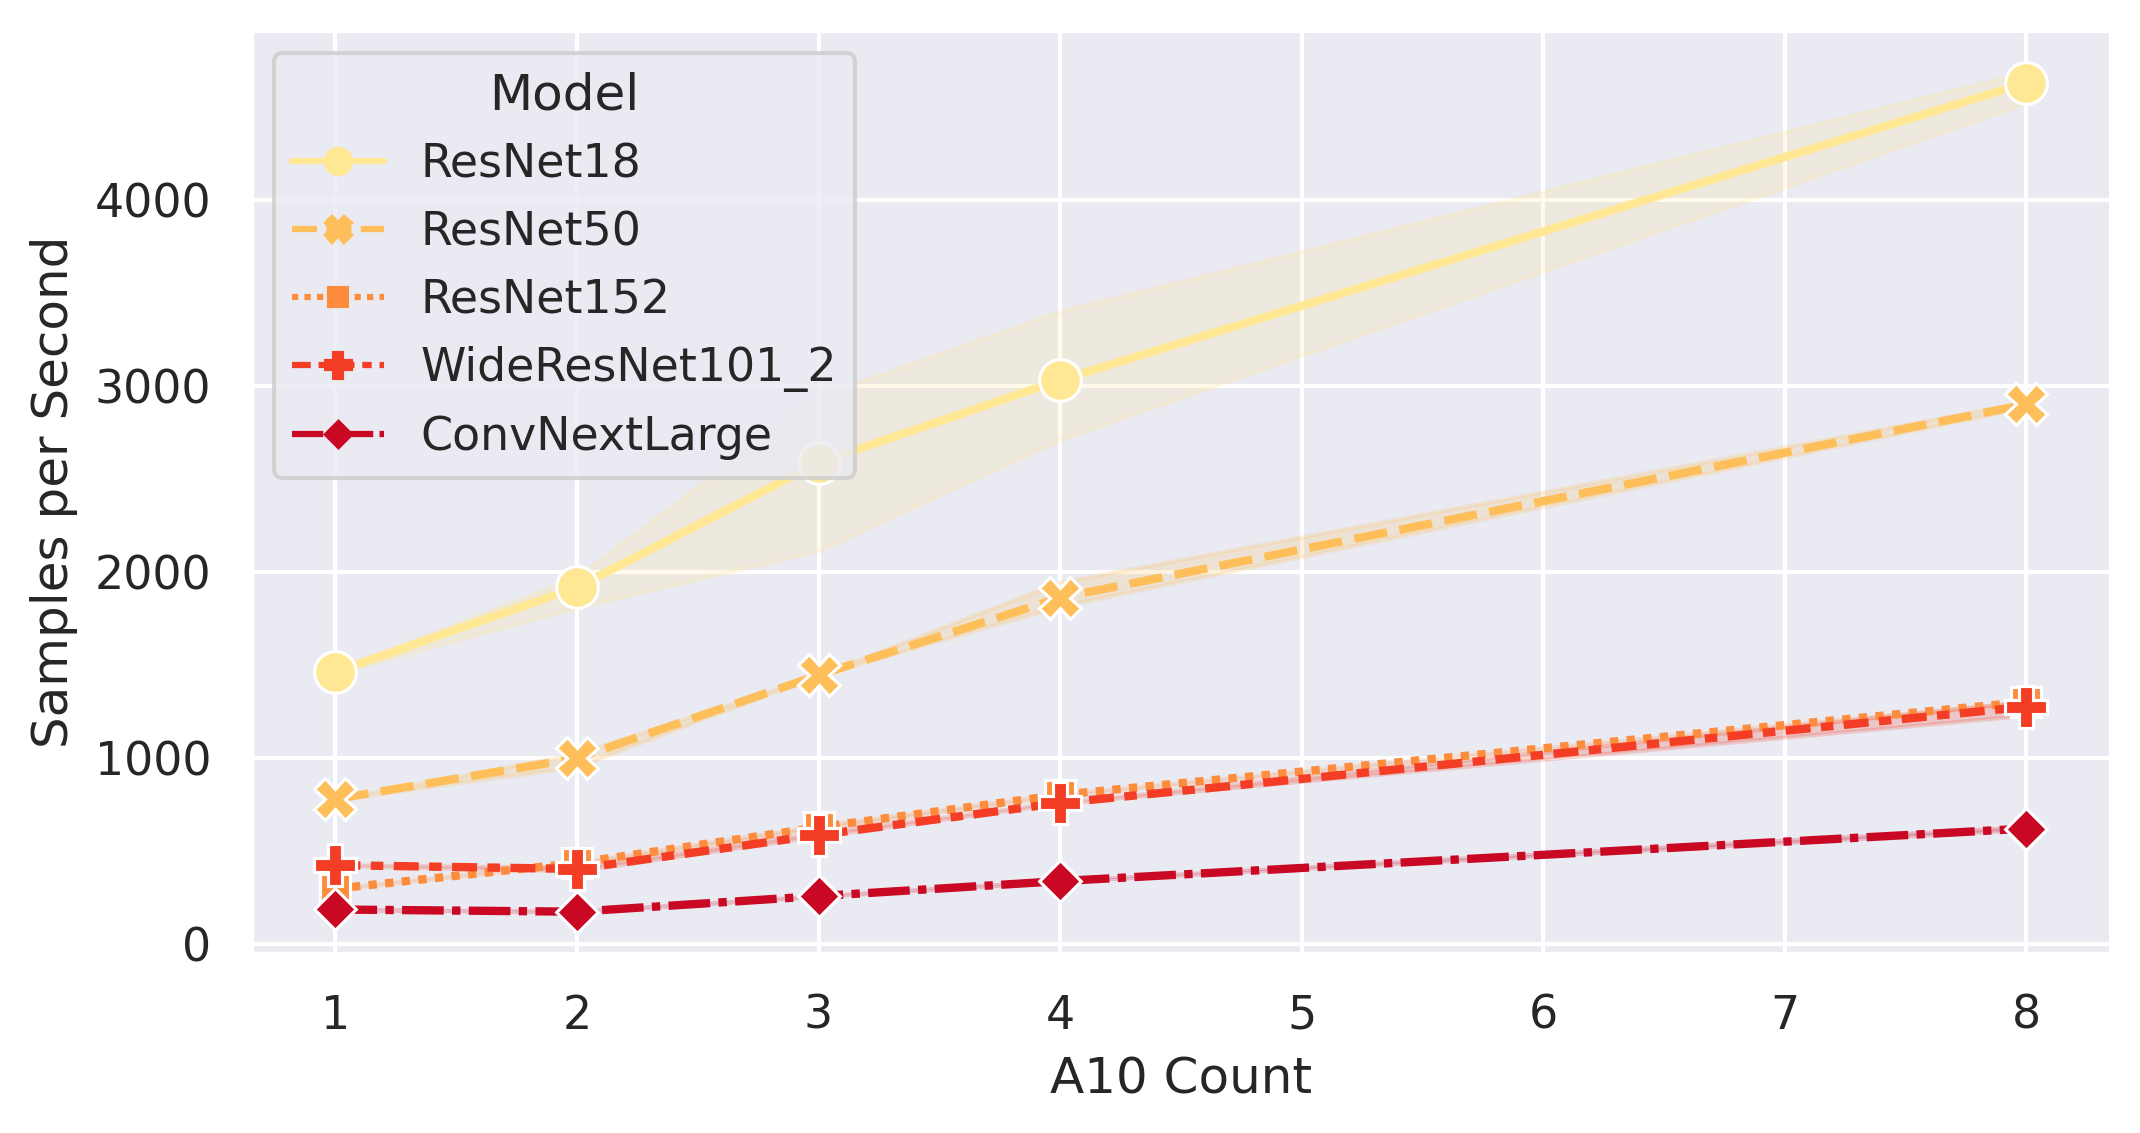

In [13]:
# filter small models out
temp_df = full_cv_a10_runs_df#.query("model=='ResNet152' or model=='WideResNet101_2' or model=='ConvNextLarge'")
# filter local sps out
temp_df = temp_df.query("samples_per_sec.notna()")
# filter out non-32k TBS
temp_df = temp_df.query("TBS==32768")

sns.set(palette=cv_palette)
plt.figure(figsize=(8,4))
ax = sns.lineplot(
    data=temp_df,
    x="gpu_count",
    y="samples_per_sec",
    hue="model",
    style="model",
    #errorbar=('sd', 1),
    dashes=True, err_style="band",
    markers=True,
    linewidth=2.0,
    markersize=10.0,
)
#ax.set(yscale='log')
#plt.title("CV Model Suitability Study")
plt.xlabel("A10 Count")
plt.ylabel("Samples per Second")
plt.legend(title="Model")
#sns.move_legend(ax, "upper right", bbox_to_anchor=(1.33, 1.03))
save_fig("cv_multi-a10_scalability")

## CV Speedup

In [137]:
def get_mean_throughput(model, gpu_count):
    TBS = 32768
    temp_df = full_cv_a10_runs_df.query(f"samples_per_sec.notna() and TBS=={TBS} and model=='{model}' and gpu_count=={gpu_count}")
    return temp_df["samples_per_sec"].mean()

for model in full_cv_a10_runs_df["model"].unique():
    print(f"Model {model}:")
    baseline_sps = get_mean_throughput(model=model, gpu_count=1)
    for gpu_count in [2,3,4,8]:
        hivemind_sps = get_mean_throughput(model=model, gpu_count=gpu_count)
        print(f" - Speedup on {gpu_count} GPUS: {round(hivemind_sps / baseline_sps,2)}x, Norm: {round(hivemind_sps / baseline_sps / gpu_count,2)} ({round(hivemind_sps,1)}, {round(baseline_sps,1)})")

Model RN18:
 - Speedup on 2 GPUS: 1.31x, Norm: 0.66 (1916.3, 1462.2)
 - Speedup on 3 GPUS: 1.77x, Norm: 0.59 (2586.9, 1462.2)
 - Speedup on 4 GPUS: 2.07x, Norm: 0.52 (3029.8, 1462.2)
 - Speedup on 8 GPUS: 3.16x, Norm: 0.4 (4627.0, 1462.2)
Model RN50:
 - Speedup on 2 GPUS: 1.28x, Norm: 0.64 (998.5, 778.8)
 - Speedup on 3 GPUS: 1.86x, Norm: 0.62 (1444.8, 778.8)
 - Speedup on 4 GPUS: 2.39x, Norm: 0.6 (1860.4, 778.8)
 - Speedup on 8 GPUS: 3.72x, Norm: 0.47 (2899.2, 778.8)
Model RN152:
 - Speedup on 2 GPUS: 1.46x, Norm: 0.73 (435.7, 297.5)
 - Speedup on 3 GPUS: 2.11x, Norm: 0.7 (627.3, 297.5)
 - Speedup on 4 GPUS: 2.69x, Norm: 0.67 (801.7, 297.5)
 - Speedup on 8 GPUS: 4.37x, Norm: 0.55 (1301.2, 297.5)
Model WRN101:
 - Speedup on 2 GPUS: 0.95x, Norm: 0.48 (403.6, 424.0)
 - Speedup on 3 GPUS: 1.38x, Norm: 0.46 (585.8, 424.0)
 - Speedup on 4 GPUS: 1.79x, Norm: 0.45 (758.1, 424.0)
 - Speedup on 8 GPUS: 3.01x, Norm: 0.38 (1275.1, 424.0)
Model CONV:
 - Speedup on 2 GPUS: 0.94x, Norm: 0.47 (173.9,

In [138]:
debug = False
rn18_3xA10_32768_df    = get_granularity_cumulated(run_name="hivemind-306", name="RN18 3xA10 32768", debug=debug)
rn50_3xA10_32768_df    = get_granularity_cumulated(run_name="hivemind-307", name="RN50 3xA10 32768", debug=debug)
rn101_3xA10_32768_df   = get_granularity_cumulated(run_name="hivemind-308", name="RN152 3xA10 32768", debug=debug)
wdrn101_3xA10_32768_df = get_granularity_cumulated(run_name="hivemind-309", name="WRN101 3xA10 32768", debug=debug)
conv_3xA10_32768_df    = get_granularity_cumulated(run_name="hivemind-310", name="CONV 3xA10 32768", debug=debug)

rn18_4xA10_32768_df    = get_granularity_cumulated(run_name="hivemind-315", name="RN18 4xA10 32768", debug=debug)
rn50_4xA10_32768_df    = get_granularity_cumulated(run_name="hivemind-316", name="RN50 4xA10 32768", debug=debug)
rn101_4xA10_32768_df   = get_granularity_cumulated(run_name="hivemind-317", name="RN152 4xA10 32768", debug=debug)
wdrn101_4xA10_32768_df = get_granularity_cumulated(run_name="hivemind-318", name="WRN101 4xA10 32768", debug=debug)
conv_4xA10_32768_df    = get_granularity_cumulated(run_name="hivemind-319", name="CONV 4xA10 32768", debug=debug)

rn18_8xA10_32768_df    = get_granularity_cumulated(run_name="hivemind-325", name="RN18 8xA10 32768", debug=debug)
rn50_8xA10_32768_df    = get_granularity_cumulated(run_name="hivemind-326", name="RN50 8xA10 32768", debug=debug)
rn101_8xA10_32768_df   = get_granularity_cumulated(run_name="hivemind-327", name="RN152 8xA10 32768", debug=debug)
wdrn101_8xA10_32768_df = get_granularity_cumulated(run_name="hivemind-328", name="WRN101 8xA10 32768", debug=debug)
conv_8xA10_32768_df    = get_granularity_cumulated(run_name="hivemind-330", name="CONV 8xA10 32768", debug=debug)

> Found 3 runs with the infix 'bee'.
> Found 3 runs with the infix 'bee'.
> Found 3 runs with the infix 'bee'.
> Found 3 runs with the infix 'bee'.
> Found 3 runs with the infix 'bee'.
> Found 4 runs with the infix 'bee'.
> Found 4 runs with the infix 'bee'.
> Found 4 runs with the infix 'bee'.
> Found 4 runs with the infix 'bee'.
> Found 4 runs with the infix 'bee'.
> Found 8 runs with the infix 'bee'.
> Found 8 runs with the infix 'bee'.
> Found 8 runs with the infix 'bee'.
> Found 8 runs with the infix 'bee'.
> Found 8 runs with the infix 'bee'.


In [139]:
display(rn18_2xA10_32768_df)
display(rn18_3xA10_32768_df)

dataload_s  cuda_move_s  forward_s  loss_calc_s  backward_s  \
0   12.581132     4.110601   10.83569     0.233949   12.540468   

   opt_step_local_s  opt_step_sync_s  dl_calc_time_s  calc_time_s  \
0          1.264491         2.205958       41.566331    28.985199   

   comm_time_s  granularity              name  
0     2.205958       13.185  RN18 2xA10 32768

dataload_s  cuda_move_s  forward_s  loss_calc_s  backward_s  \
0    7.135172     2.764947   7.352304      0.20854     8.54455   

   opt_step_local_s  opt_step_sync_s  dl_calc_time_s  calc_time_s  \
0           0.92255         7.022696       26.928064    19.792892   

   comm_time_s  granularity              name  
0     7.022696     2.816667  RN18 3xA10 32768

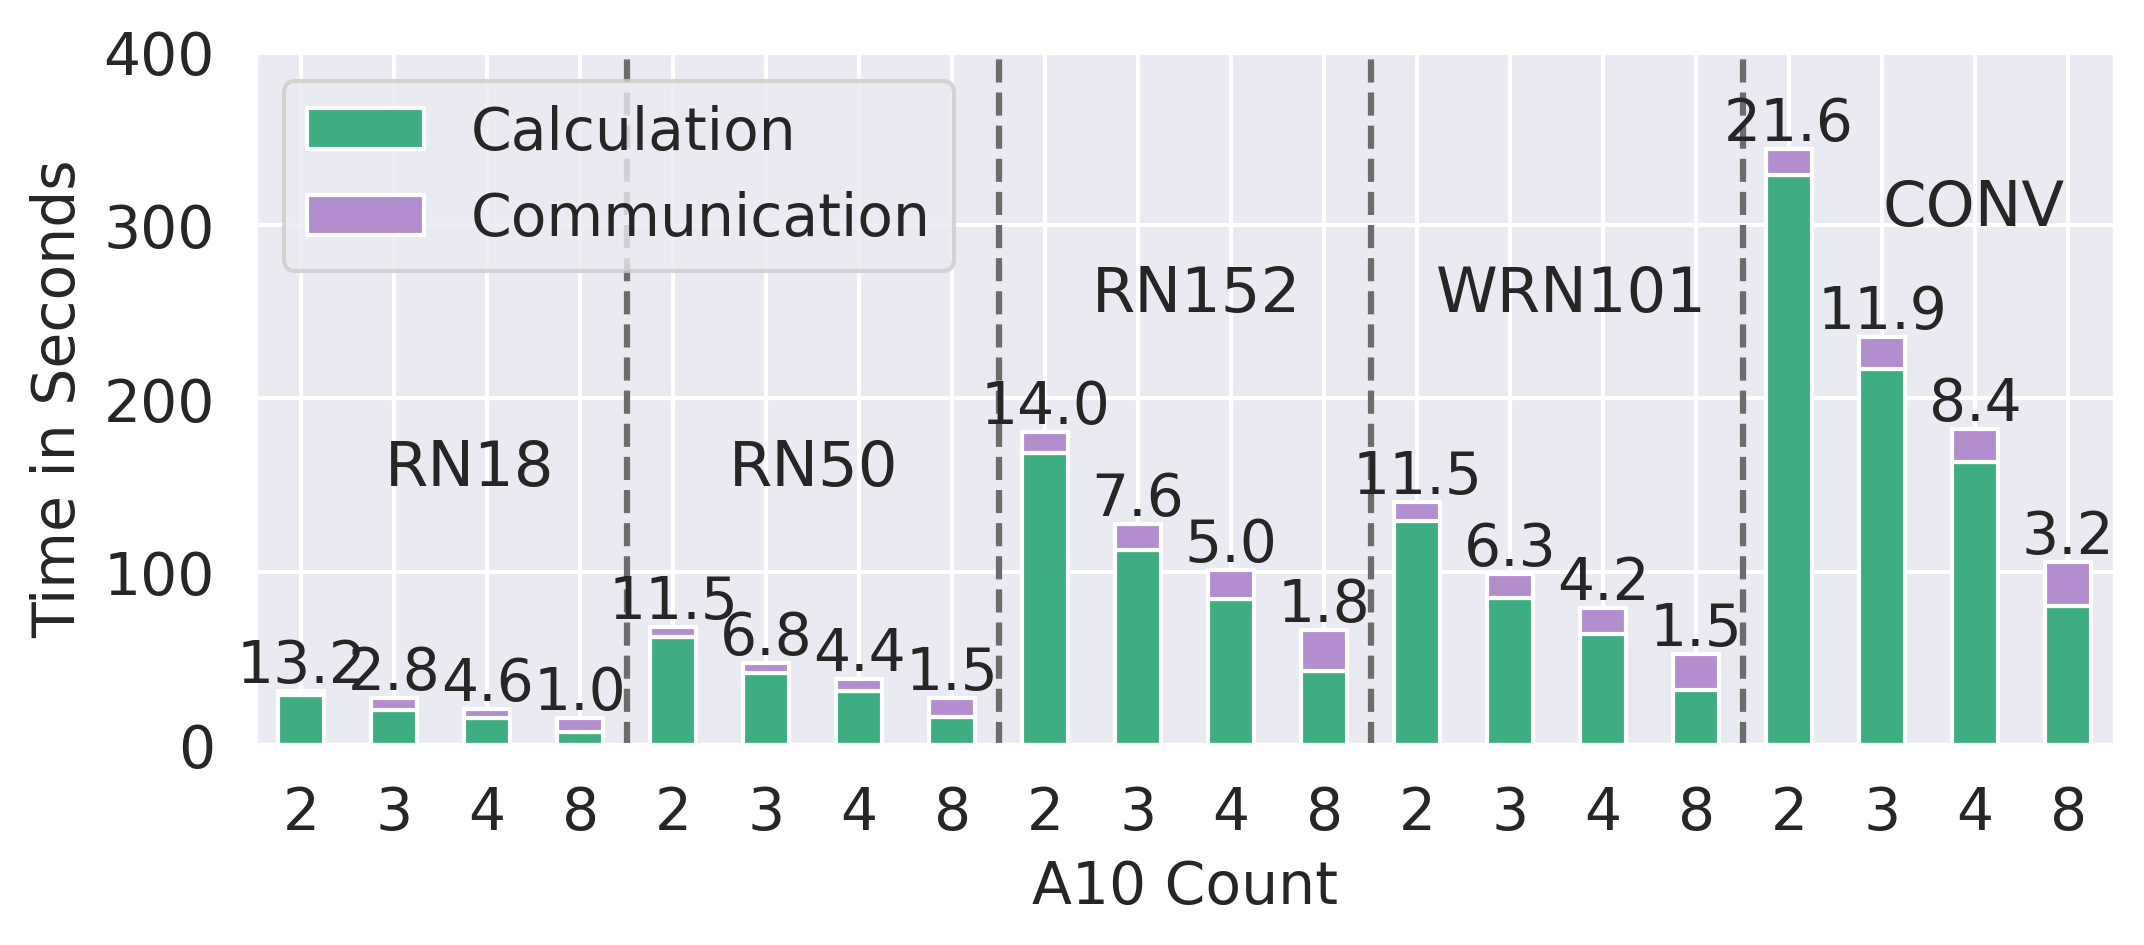

In [144]:
cv_full_a10_granulartiy_df = pd.concat(objs=[
    rn18_2xA10_32768_df,
    rn18_3xA10_32768_df,
    rn18_4xA10_32768_df,
    rn18_8xA10_32768_df,
    rn50_2xA10_32768_df,
    rn50_3xA10_32768_df,
    rn50_4xA10_32768_df,
    rn50_8xA10_32768_df,
    rn101_2xA10_32768_df,
    rn101_3xA10_32768_df,
    rn101_4xA10_32768_df,
    rn101_8xA10_32768_df,
    wdrn101_2xA10_32768_df,
    wdrn101_3xA10_32768_df,
    wdrn101_4xA10_32768_df,
    wdrn101_8xA10_32768_df,
    conv_2xA10_32768_df,
    conv_3xA10_32768_df,
    conv_4xA10_32768_df,
    conv_8xA10_32768_df
])

sns.set(palette=granularity_palette)
set_fontsizes(14,16,16)

ax = cv_full_a10_granulartiy_df[["calc_time_s","comm_time_s","name"]].set_index('name').plot(kind='bar', stacked=True, figsize=(8,3))
plt.ylabel("Time in Seconds")
plt.xlabel("A10 Count")
plt.legend(labels=["Calculation", "Communication"])
plt.ylim(0,400)
ax.axvline(3.5, color="#6c6c6c", linestyle="--")
ax.axvline(7.5, color="#6c6c6c", linestyle="--")
ax.axvline(11.5, color="#6c6c6c", linestyle="--")
ax.axvline(15.5, color="#6c6c6c", linestyle="--")
labels = [item.get_text() for item in ax.get_xticklabels()]
labels = [" ".join(label.split(" ")[1:2])[0] for label in labels]
ax.set_xticklabels(labels, rotation=0)
show_granulartiy_values(ax=ax, df=cv_full_a10_granulartiy_df, decimals=1, fontsize=14)
ax.text(0.9, 150, "RN18", fontsize=15)
ax.text(4.6, 150, "RN50", fontsize=15)
ax.text(8.5, 250, "RN152", fontsize=15)
ax.text(12.2, 250, "WRN101", fontsize=15)
ax.text(17, 300, "CONV", fontsize=15)
save_fig("cv_full-a10_all-tbs_granularity")

<Figure size 2400x900 with 0 Axes>

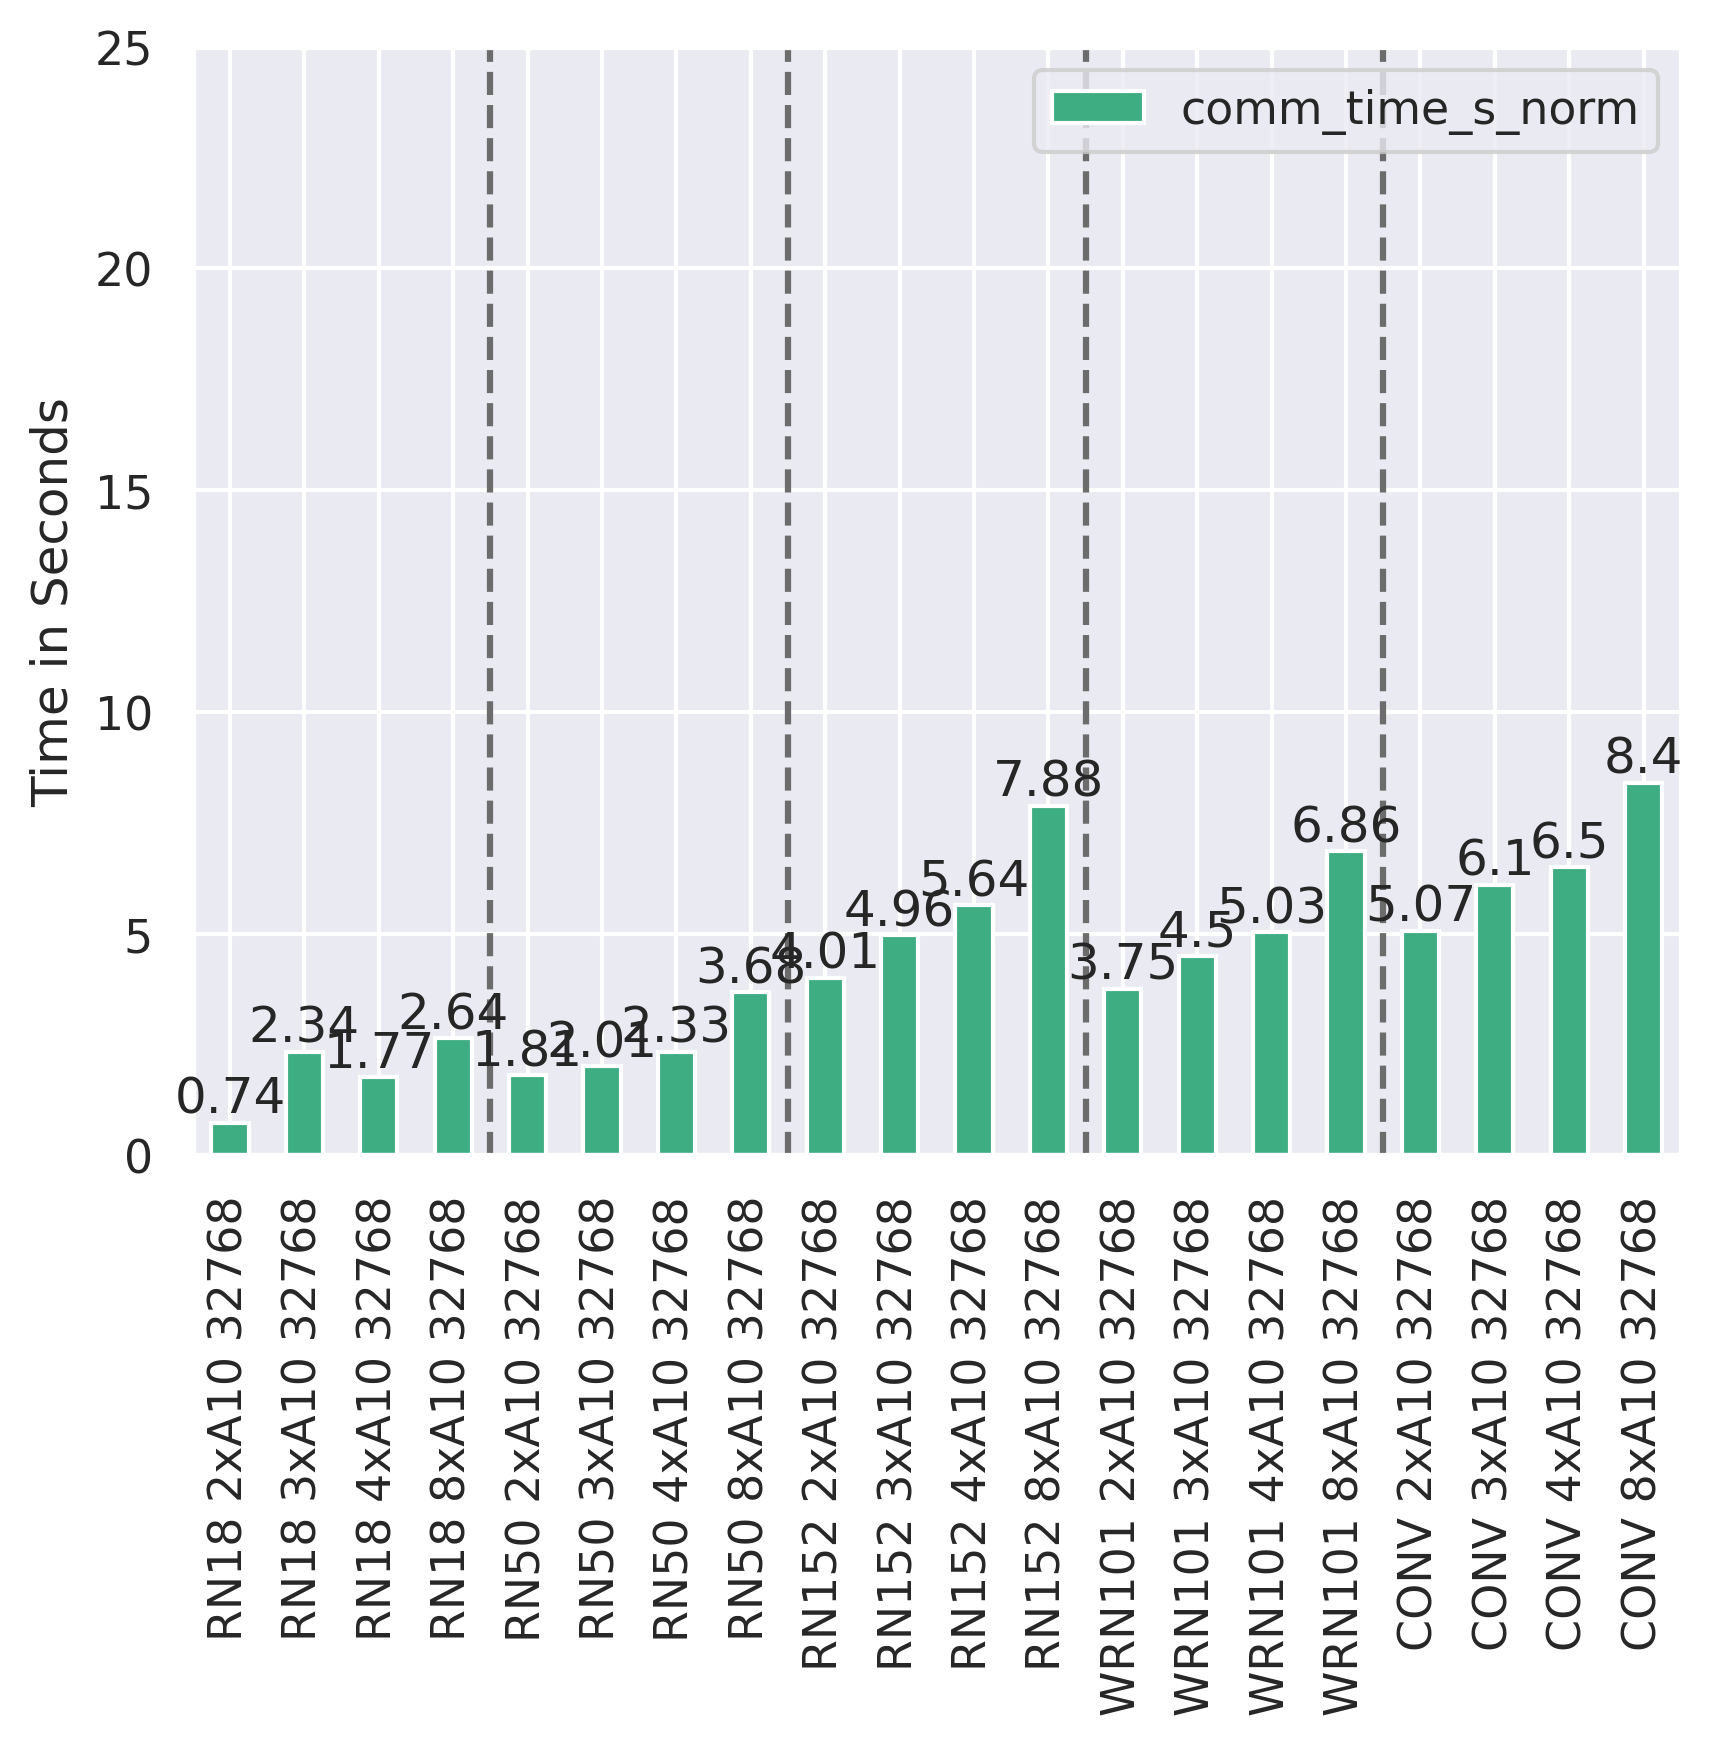

In [18]:
cv_full_a10_granulartiy_df = pd.concat(objs=[
    rn18_2xA10_32768_df,
    rn18_3xA10_32768_df,
    rn18_4xA10_32768_df,
    rn18_8xA10_32768_df,
    rn50_2xA10_32768_df,
    rn50_3xA10_32768_df,
    rn50_4xA10_32768_df,
    rn50_8xA10_32768_df,
    rn101_2xA10_32768_df,
    rn101_3xA10_32768_df,
    rn101_4xA10_32768_df,
    rn101_8xA10_32768_df,
    wdrn101_2xA10_32768_df,
    wdrn101_3xA10_32768_df,
    wdrn101_4xA10_32768_df,
    wdrn101_8xA10_32768_df,
    conv_2xA10_32768_df,
    conv_3xA10_32768_df,
    conv_4xA10_32768_df,
    conv_8xA10_32768_df
])
cv_full_a10_granulartiy_df["comm_time_s_norm"] = cv_full_a10_granulartiy_df["comm_time_s"] / 3

sns.set(palette=granularity_palette)
plt.figure(figsize=(8,3))
ax = cv_full_a10_granulartiy_df[["comm_time_s_norm","name"]].set_index('name').plot(kind='bar', stacked=True)
plt.ylabel("Time in Seconds")
plt.xlabel("")
#plt.legend(labels=["Calculation", "Communication"])
plt.ylim(0,25)
ax.axvline(3.5, color="#6c6c6c", linestyle="--")
ax.axvline(7.5, color="#6c6c6c", linestyle="--")
ax.axvline(11.5, color="#6c6c6c", linestyle="--")
ax.axvline(15.5, color="#6c6c6c", linestyle="--")
round_bar_value_multi(ax, decimals=2)

#labels = [item.get_text() for item in ax.get_xticklabels()]
#labels = [" ".join(label.split(" ")[0:2]) for label in labels]
#ax.set_xticklabels(labels)
#show_granulartiy_values(ax=ax, df=cv_full_a10_granulartiy_df, decimals=1)
#save_fig("cv_full-a10_all-tbs_granularity")



RN18 8xA10 32768 11700000.0
RN50 8xA10 32768 25600000.0
RN152 8xA10 32768 60200000.0
WRN101 8xA10 32768 126900000.0
CONV 8xA10 32768 197800000.0


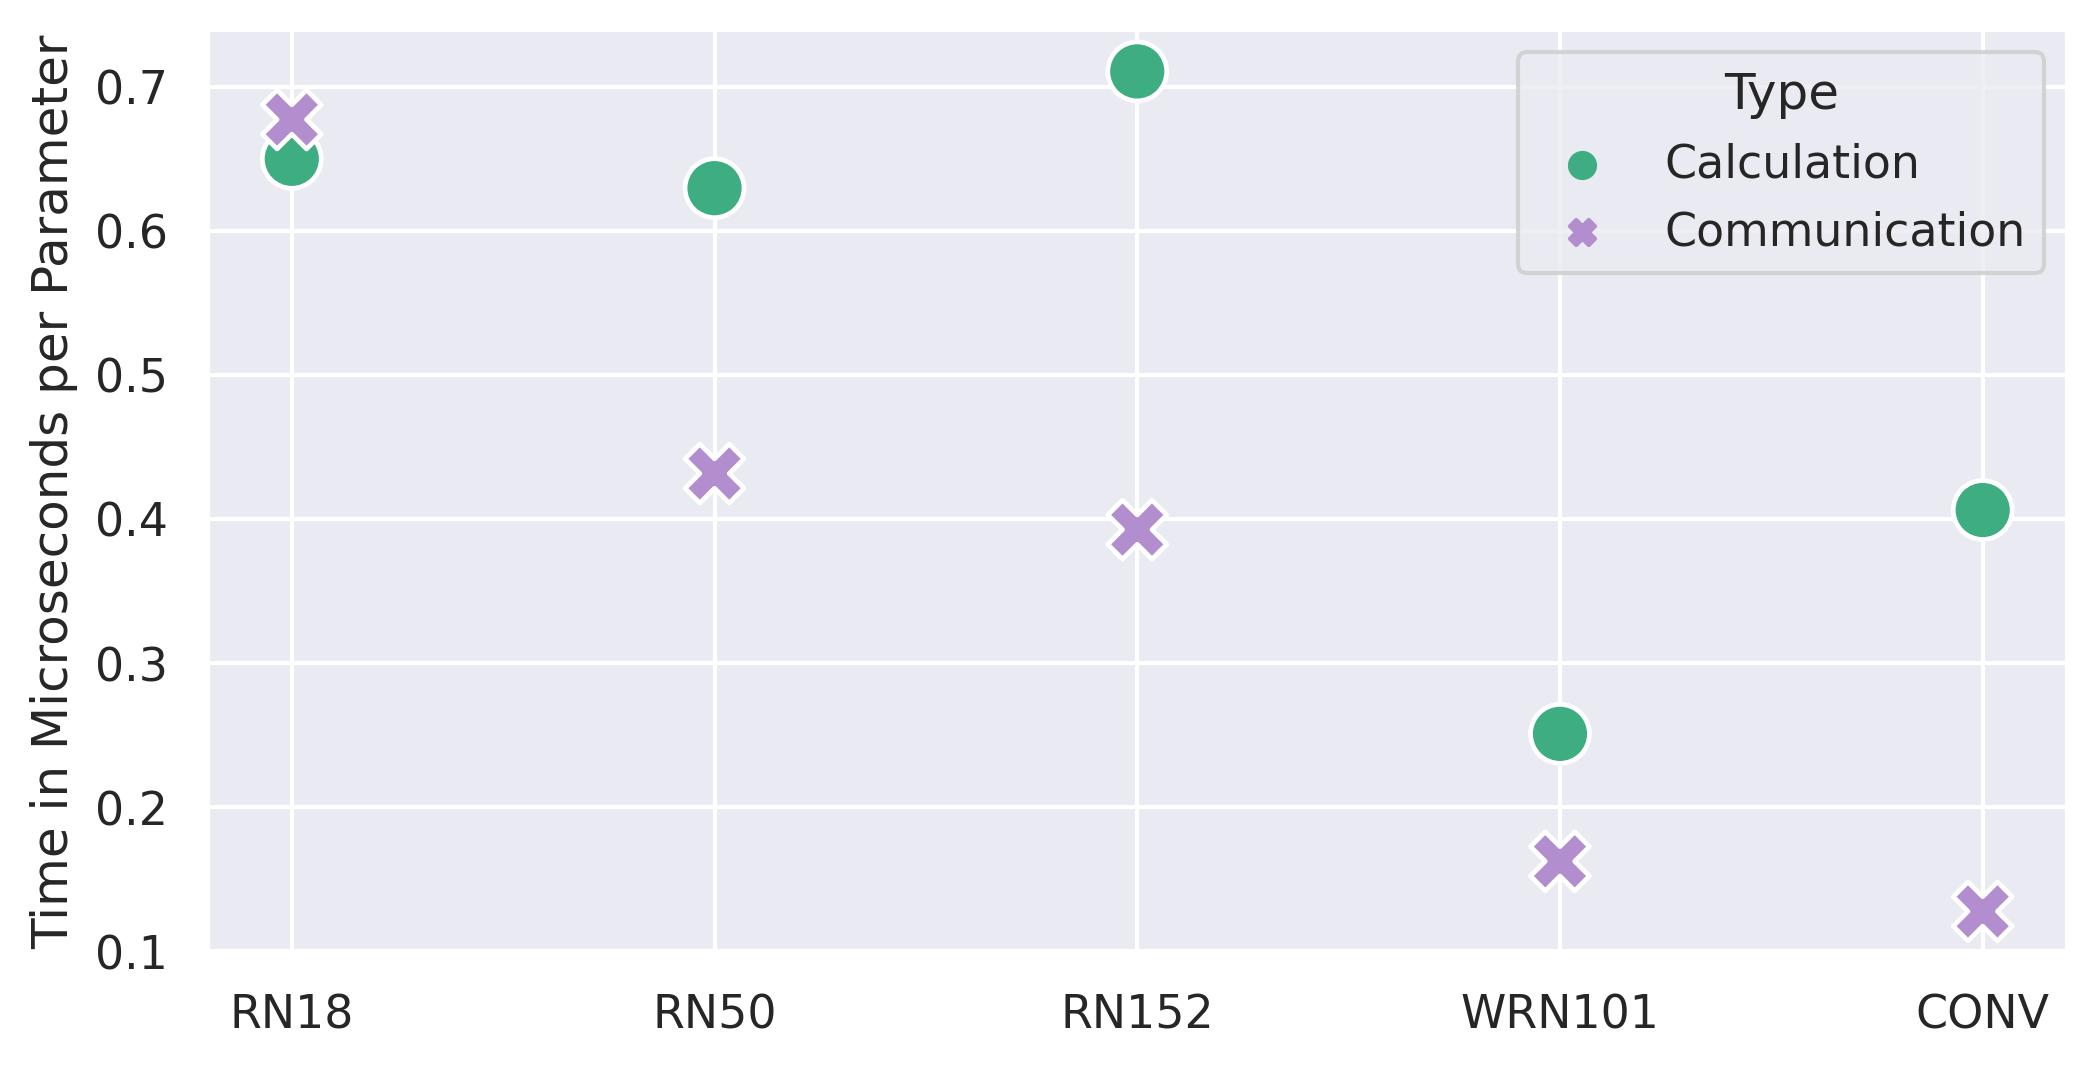

In [19]:
temp_df = pd.concat(objs=[
    rn18_8xA10_32768_df,
    rn50_8xA10_32768_df,
    rn101_8xA10_32768_df,
    wdrn101_8xA10_32768_df,
    conv_8xA10_32768_df
])

agg_dict = {
    "name": [],
    "time_µ": [],
    "time_type": []
}

def to_agg(name, time_s, time_type):
    agg_dict["name"].append(name)
    agg_dict["time_µ"].append(time_s * 1000 * 1000)
    agg_dict["time_type"].append(time_type)



for name in temp_df["name"].unique():
    row = temp_df.query(f"name == '{name}'")
    new_name = name.split(" ")[0]
    if new_name == "RN18":
        param_size = 11.7 * 10**6
    elif new_name == "RN50":
        param_size = 25.6 * 10**6
    elif new_name == "RN152":
        param_size = 60.2 * 10**6
    elif new_name == "WRN101":
        param_size = 126.9 * 10**6
    elif new_name == "CONV":
        param_size = 197.8 * 10**6
    print(name,param_size)
    to_agg(name=new_name, time_s=row["calc_time_s"].item() / param_size, time_type="Calculation")
    to_agg(name=new_name, time_s=row["comm_time_s"].item() / param_size, time_type="Communication")

agg_df = pd.DataFrame(agg_dict)
#agg_df

sns.set(palette=granularity_palette)
plt.figure(figsize=(8,4))

sns.scatterplot(
    data=agg_df,
    x="name",
    y="time_µ",
    hue="time_type",
    color="0.3", s=200, style="time_type", zorder=2)

plt.ylabel("Time in Microseconds per Parameter")
plt.xlabel("")
plt.legend(title="Type")
#save_fig("cv_8xA10_baseline_calc_vs_comm_plot")



RN18 8xA10 32768 11700000.0
RN50 8xA10 32768 25600000.0
RN152 8xA10 32768 60200000.0
WRN101 8xA10 32768 126900000.0
CONV 8xA10 32768 197800000.0


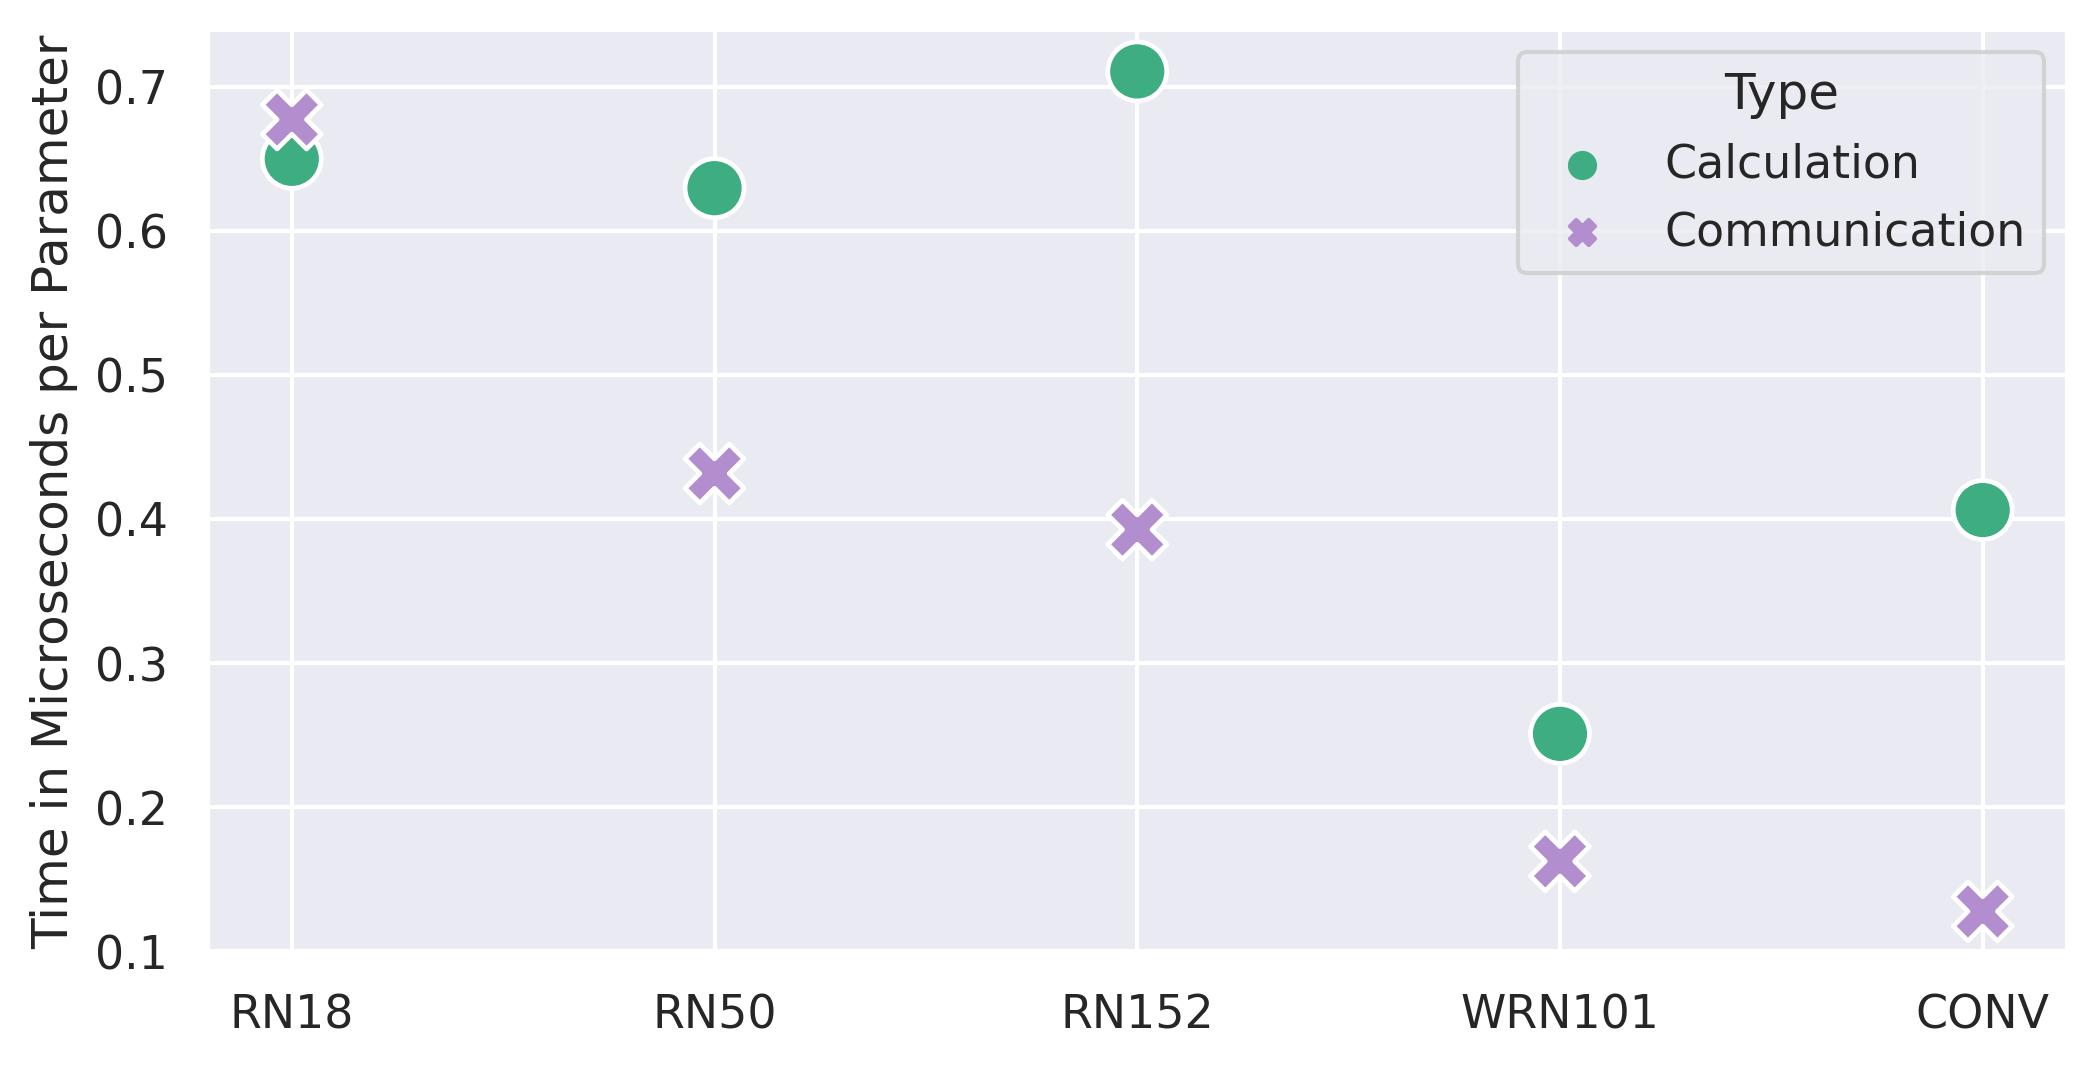

In [20]:
temp_df = pd.concat(objs=[
    rn18_8xA10_32768_df,
    rn50_8xA10_32768_df,
    rn101_8xA10_32768_df,
    wdrn101_8xA10_32768_df,
    conv_8xA10_32768_df
])

agg_dict = {
    "name": [],
    "time_µ": [],
    "time_type": []
}

def to_agg(name, time_s, time_type):
    agg_dict["name"].append(name)
    agg_dict["time_µ"].append(time_s * 1000 * 1000)
    agg_dict["time_type"].append(time_type)

for name in temp_df["name"].unique():
    row = temp_df.query(f"name == '{name}'")
    new_name = name.split(" ")[0]
    if new_name == "RN18":
        param_size = 11.7 * 10**6
    elif new_name == "RN50":
        param_size = 25.6 * 10**6
    elif new_name == "RN152":
        param_size = 60.2 * 10**6
    elif new_name == "WRN101":
        param_size = 126.9 * 10**6
    elif new_name == "CONV":
        param_size = 197.8 * 10**6
    print(name,param_size)
    to_agg(name=new_name, time_s=row["calc_time_s"].item() / param_size, time_type="Calculation")
    to_agg(name=new_name, time_s=row["comm_time_s"].item() / param_size, time_type="Communication")

agg_df = pd.DataFrame(agg_dict)
#agg_df

sns.set(palette=granularity_palette)
plt.figure(figsize=(8,4))

sns.scatterplot(
    data=agg_df,
    x="name",
    y="time_µ",
    hue="time_type",
    color="0.3", s=200, style="time_type", zorder=2)

plt.ylabel("Time in Microseconds per Parameter")
plt.xlabel("")
plt.legend(title="Type")
#save_fig("cv_8xA10_baseline_calc_vs_comm_plot")



# NLP Model Suitability Study

### NLP A10 Baseline

In [21]:
nlp_a10_baseline_df = get_baseline_runs(run_names=[
    "baseline-167-roberta_mlm_base", # "baseline-15-roberta_mlm_base",
    "baseline-168-roberta_mlm_base", #"baseline-16-roberta_mlm_base",
    "baseline-169-roberta_mlm_base", #"baseline-17-roberta_mlm_base",
    "baseline-18-roberta_mlm_large",
    "baseline-19-roberta_mlm_large",
    "baseline-20-roberta_mlm_large",
    "baseline-21-roberta_mlm_xlm",
    "baseline-22-roberta_mlm_xlm",
    "baseline-23-roberta_mlm_xlm",
    ])
nlp_a10_baseline_df = rename_models(df = nlp_a10_baseline_df)
nlp_a10_baseline_df["gpu_count"] = int(1)
nlp_a10_baseline_df["gpu_type"] = "A10"

In [22]:
nlp_a10_baseline_df

samples_per_sec          name        model    TBS  gpu_count gpu_type
0           12.718757  baseline-167  RoBERTaBase   8192          1      A10
1         1431.169832  baseline-167  RoBERTaBase   8192          1      A10
2         1447.727710  baseline-167  RoBERTaBase   8192          1      A10
3         1438.543360  baseline-167  RoBERTaBase   8192          1      A10
4         1396.386953  baseline-167  RoBERTaBase   8192          1      A10
...               ...           ...          ...    ...        ...      ...
2522       459.957594   baseline-23   RoBERTaXLM  32768          1      A10
2523       467.398515   baseline-23   RoBERTaXLM  32768          1      A10
2524       461.113047   baseline-23   RoBERTaXLM  32768          1      A10
2525       462.858465   baseline-23   RoBERTaXLM  32768          1      A10
2526       464.037197   baseline-23   RoBERTaXLM  32768          1      A10

[44634 rows x 6 columns]

In [23]:
nlp_a10_2x_runs_df = get_hivemind_runs(run_names=[
    "hivemind-297",
    "hivemind-298",
    "hivemind-299",
    "hivemind-300", 
    "hivemind-301",
    "hivemind-302",
    "hivemind-303",
    "hivemind-303",
    "hivemind-304",
    "hivemind-305",
    ],
    drop_first_epoch=True
)
nlp_a10_2x_runs_df = rename_models(df = nlp_a10_2x_runs_df)
nlp_a10_2x_runs_df["gpu_count"] = int(2)
nlp_a10_2x_runs_df["gpu_type"] = "A10"

> Found 1 runs with the prefix 'trainmonitor'.
> Found 1 runs with the prefix 'trainmonitor'.
> Found 1 runs with the prefix 'trainmonitor'.
> Found 1 runs with the prefix 'trainmonitor'.
> Found 1 runs with the prefix 'trainmonitor'.
> Found 1 runs with the prefix 'trainmonitor'.
> Found 1 runs with the prefix 'trainmonitor'.
> Found 1 runs with the prefix 'trainmonitor'.
> Found 1 runs with the prefix 'trainmonitor'.
> Found 1 runs with the prefix 'trainmonitor'.


In [24]:
nlp_a10_baseline_df.query("model=='RoBERTaBase' and TBS==8192").describe()
print(f"RoBERTaBaes slowdown vs baseline: {round(1 - (354 / (990 + 382)),2)*100}%")

RoBERTaBaes slowdown vs baseline: 74.0%


/home/asa/miniconda3/envs/hivemind-multi-cloud-eval/lib/python3.9/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/home/asa/miniconda3/envs/hivemind-multi-cloud-eval/lib/python3.9/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/home/asa/miniconda3/envs/hivemind-multi-cloud-eval/lib/python3.9/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/home/asa/miniconda3/envs/hivemind-multi-cloud-eval/lib/python3.9/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/home/asa/miniconda3/envs/hivemind-multi-cloud-eval/lib/python3.9/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/home/asa/miniconda3/envs/hivemind-multi-cloud-eval/lib/pyth

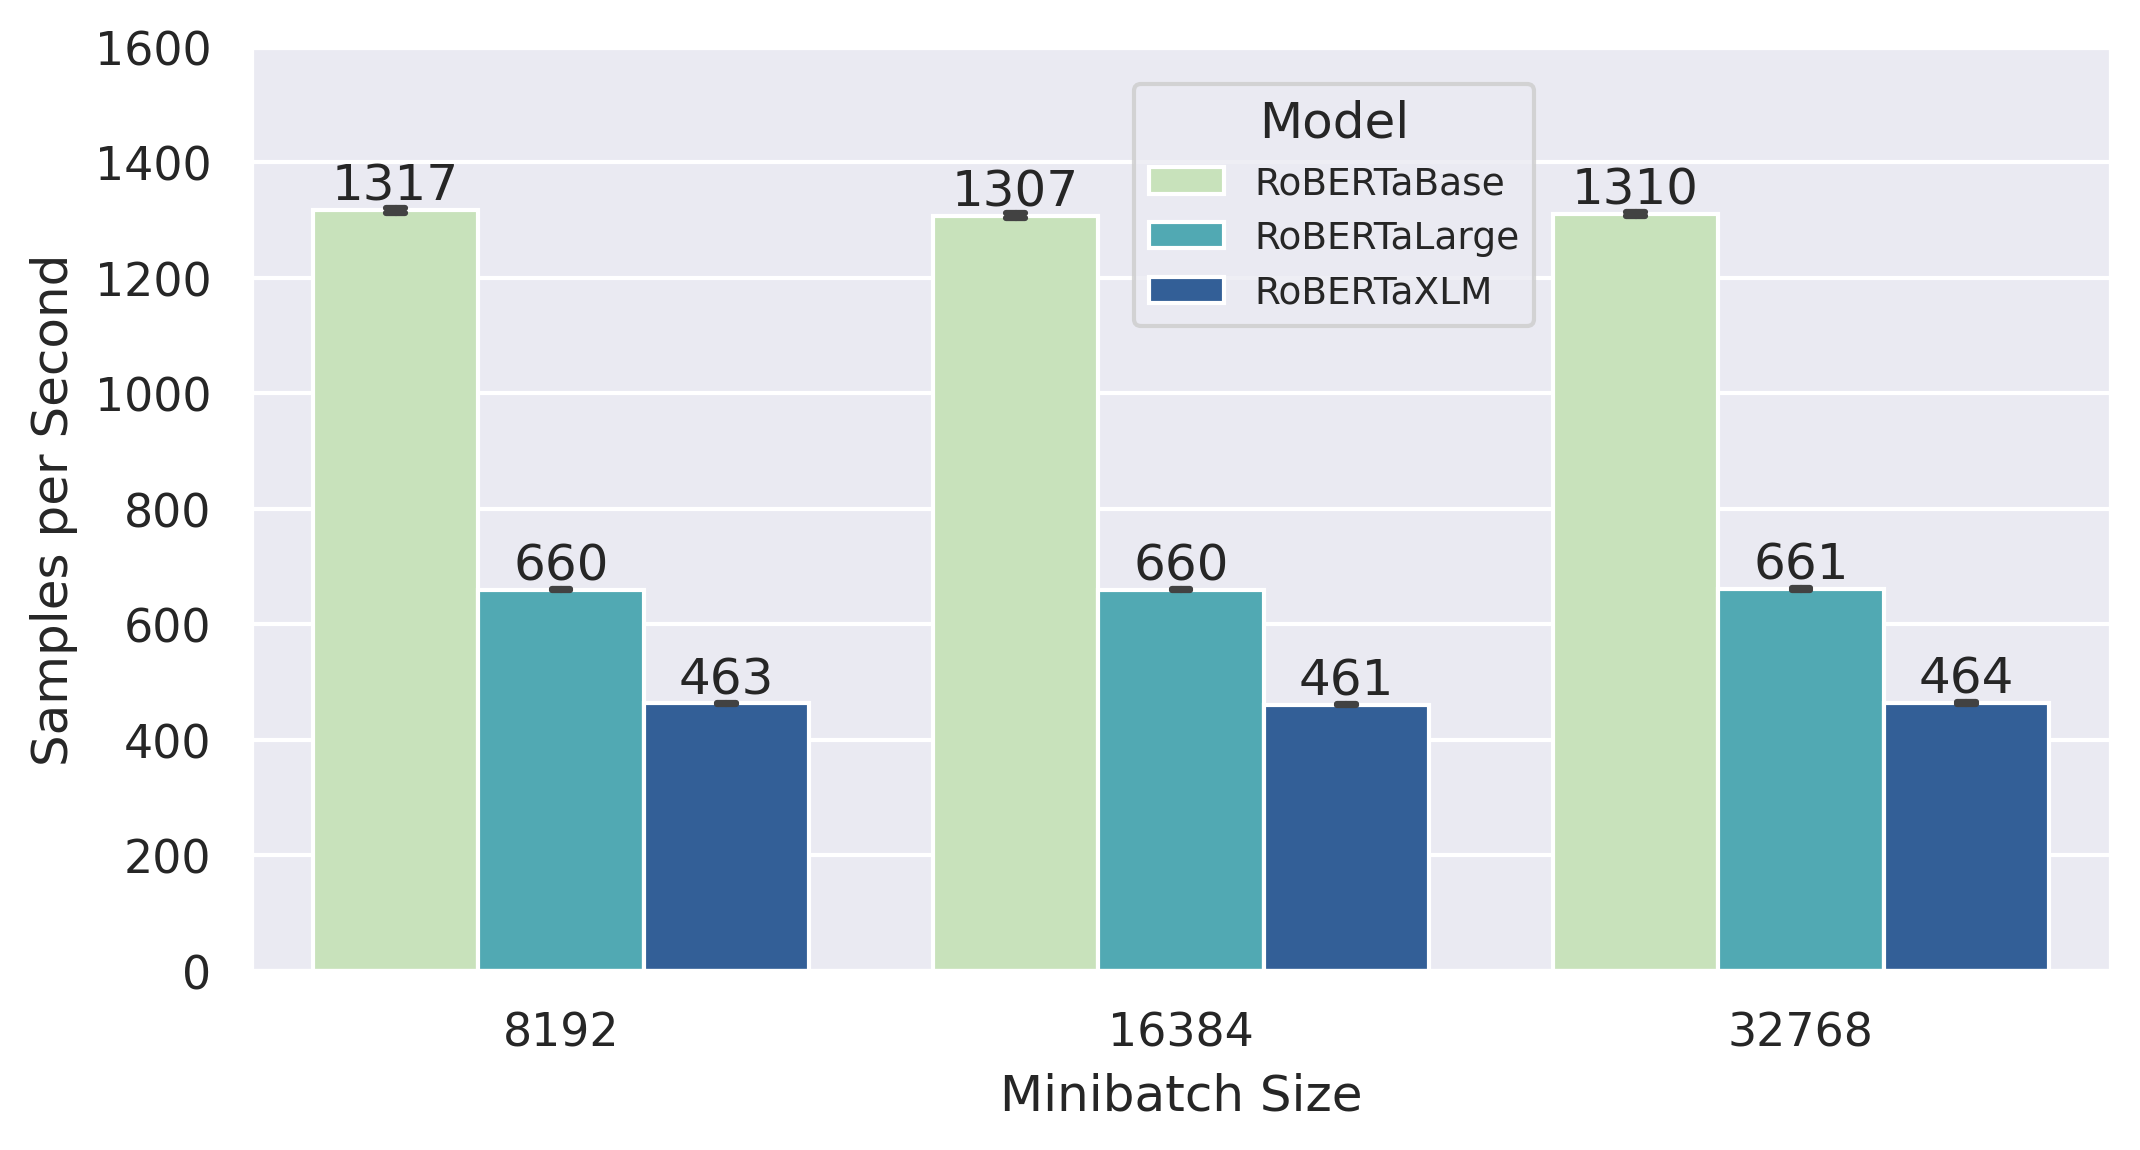

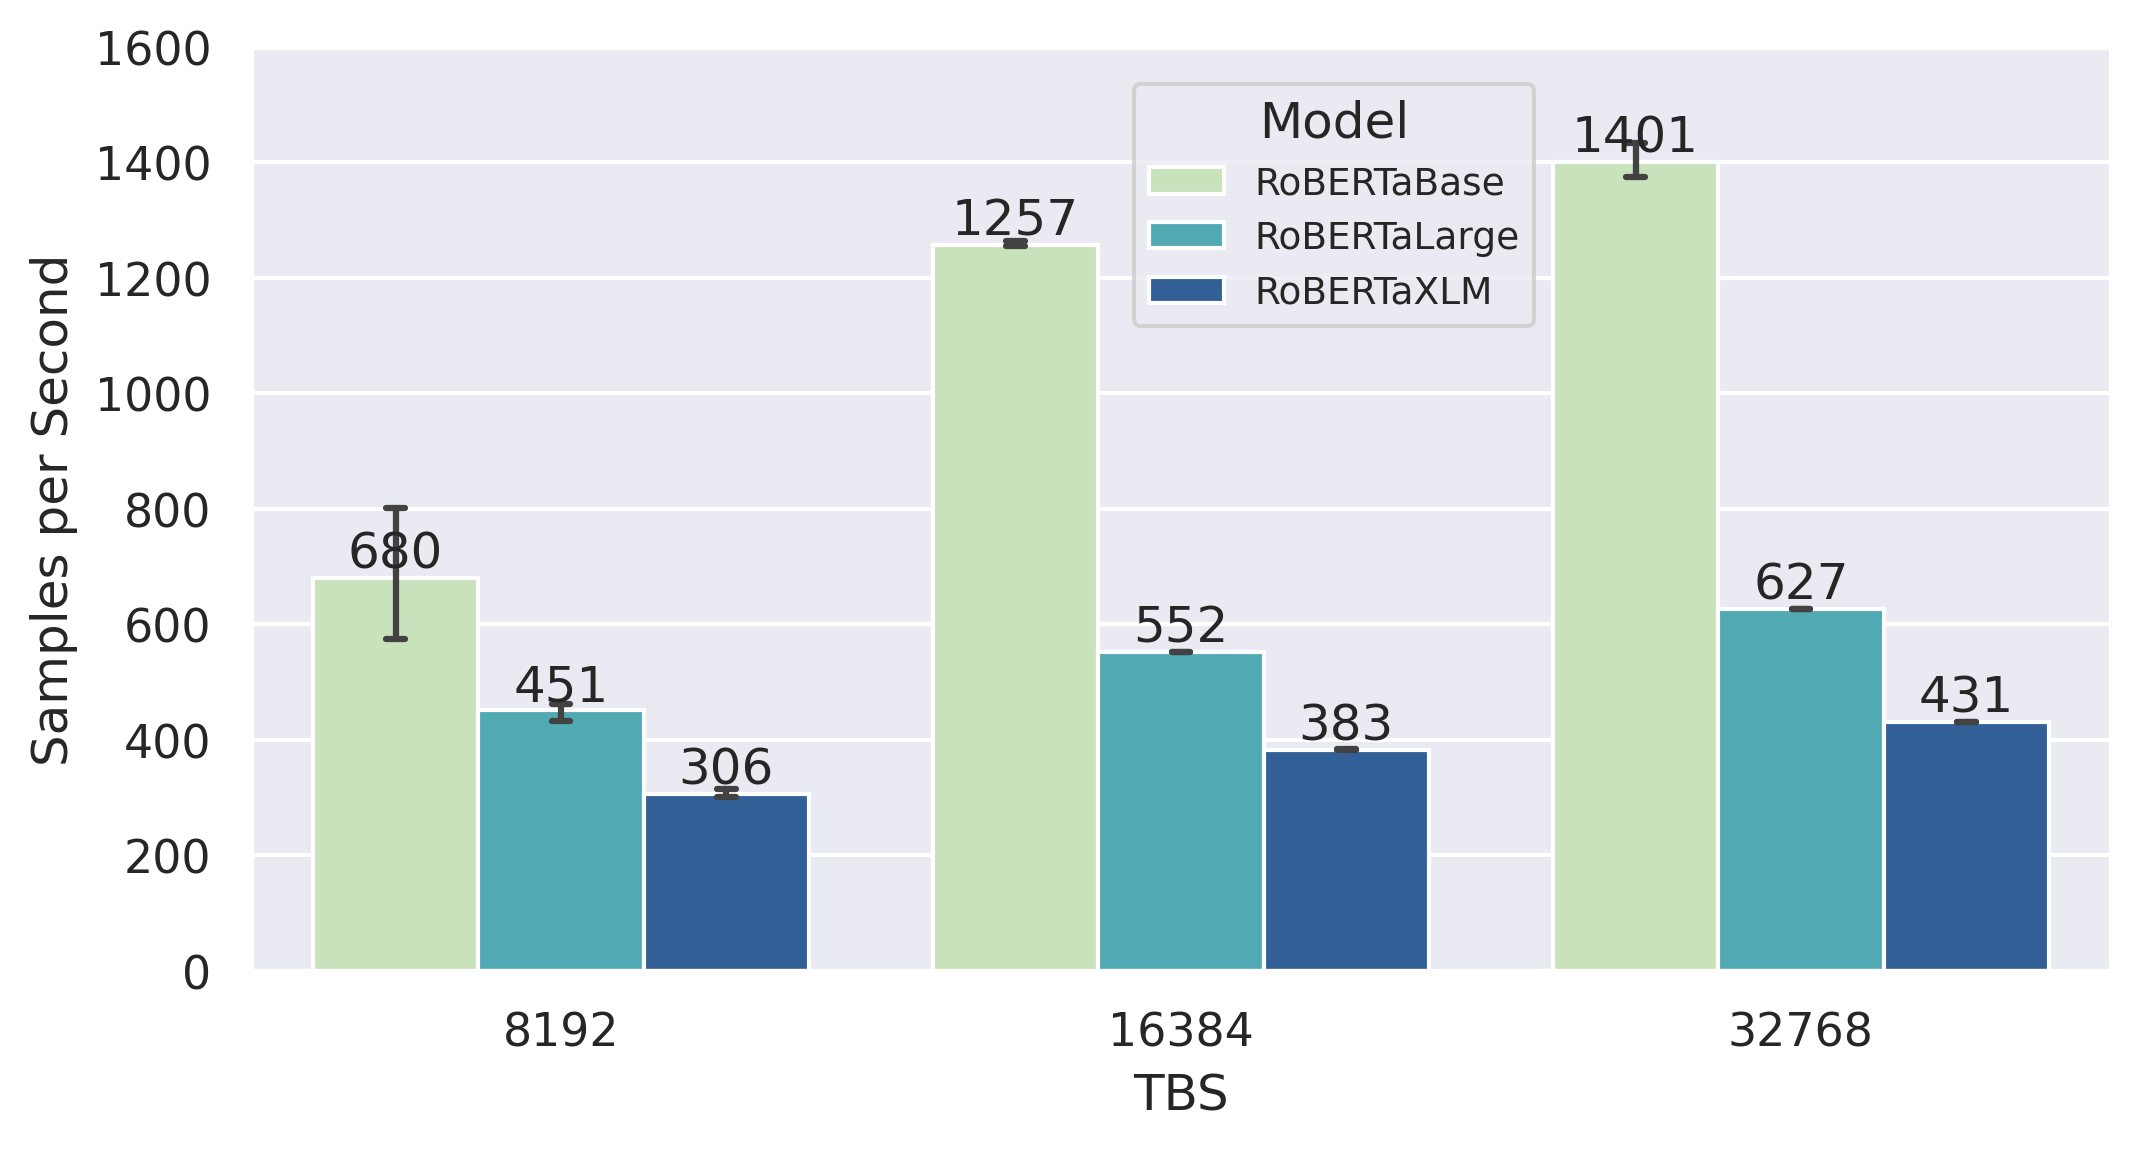

In [25]:
nlp_a10_TBS_arg_df = pd.concat(objs=[
    nlp_a10_baseline_df,
    nlp_a10_2x_runs_df
])

nlp_palette = sns.color_palette("YlGnBu", 3)
sns.set(palette=nlp_palette)

plt.figure(figsize=(8,4))
ax = sns.barplot(
    data=nlp_a10_baseline_df,
    x="TBS",
    y="samples_per_sec",
    hue="model",
    errorbar=('ci', 95),
    errwidth=1.5,
    capsize=0.03)
#plt.title("1xA10")
plt.ylim([0,1600])
#sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.legend(title="Model", fontsize=9, title_fontsize=12, bbox_to_anchor=(0.7,0.98))
plt.xlabel("Minibatch Size")
plt.ylabel("Samples per Second")
round_bar_value_multi(ax, decimals=0)
save_fig("nlp_1xa10_all-tbs_baseline")

plt.figure(figsize=(8,4))
ax = sns.barplot(
    data=nlp_a10_2x_runs_df,
    x="TBS",
    y="samples_per_sec",
    hue="model",
    errorbar=('ci', 95),
    errwidth=1.5,
    capsize=0.03)
#plt.title("2xA10")
plt.ylim([0,1600])
plt.ylabel("Samples per Second")
plt.legend(title="Model", fontsize=9, title_fontsize=12, bbox_to_anchor=(0.7,0.98))
#sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
round_bar_value_multi(ax, decimals=0)
save_fig("nlp_2xa10_all-tbs_hivemind")

/tmp/ipykernel_632201/461409979.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nlp_a10_baseline_temp_df["sps_type"] = "baseline"


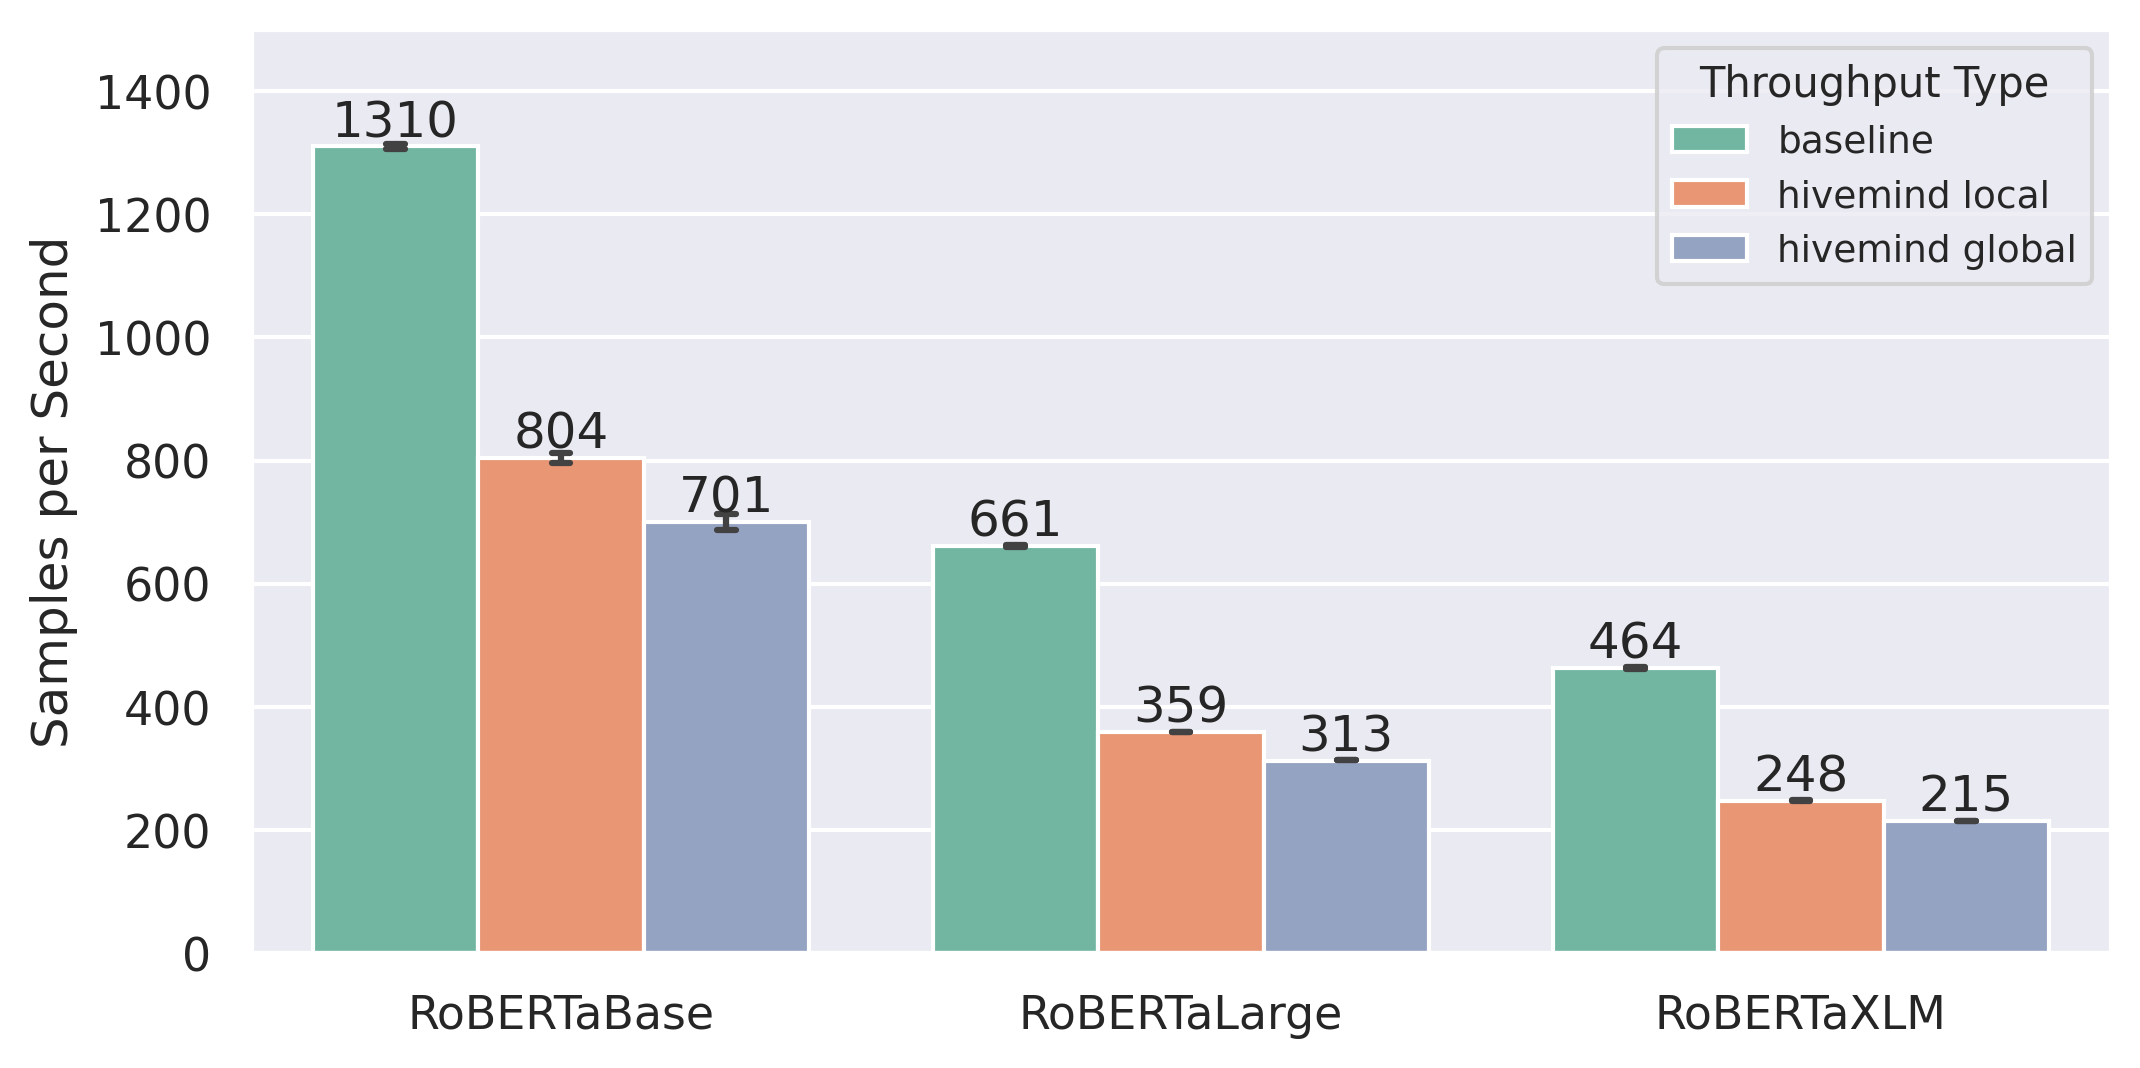

In [26]:
local_TBS = 32768
nlp_a10_baseline_temp_df = nlp_a10_baseline_df.query(f"TBS=={local_TBS}")
nlp_a10_baseline_temp_df["sps_type"] = "baseline"
nlp_a10_baseline_temp_df = nlp_a10_baseline_temp_df.rename(columns={"samples_per_sec": "sps"})

nlp_a10_2x_runs_local_sps_df = transform_to_compare_local_sps(df=nlp_a10_2x_runs_df.query(f"TBS=={local_TBS}"))
nlp_a10_1x_2x_runs_local_sps_df = pd.concat(objs=[nlp_a10_baseline_temp_df, nlp_a10_2x_runs_local_sps_df])
nlp_a10_1x_2x_runs_local_sps_df["sps_norm"] = nlp_a10_1x_2x_runs_local_sps_df["sps"] / nlp_a10_1x_2x_runs_local_sps_df["gpu_count"]

sns.set(palette=local_sps_palette)

plt.figure(figsize=(8,4))
ax = sns.barplot(
    data=nlp_a10_1x_2x_runs_local_sps_df,
    x="model",
    y="sps_norm",
    hue="sps_type",
    errorbar=('ci', 95),
    errwidth=1.5,
    capsize=0.03)
#plt.title("2xA10")
plt.xlabel("")
plt.ylabel("Samples per Second")
plt.ylim([0,1500])
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
#plt.legend(prop={'size': 6})
round_bar_value_multi(ax, decimals=0)
plt.legend(title="Throughput Type", fontsize=9, title_fontsize=10)
#plt.xticks(rotation=10)
save_fig(f"nlp_2xa10_{local_TBS}_hivemind_local_sps")

# NLP Hivemind Penalty Slowdown Calculation

In [27]:
for model in nlp_a10_1x_2x_runs_local_sps_df["model"].unique():
    baseline_speed = nlp_a10_1x_2x_runs_local_sps_df.query(f"model=='{model}' and gpu_count==1 and \
                                                             sps_type=='baseline'")["sps"].mean()
    local_speed    = nlp_a10_1x_2x_runs_local_sps_df.query(f"model=='{model}' and gpu_count==2 and \
                                                             sps_type=='hivemind local'")["sps_norm"].mean()
    global_speed   = nlp_a10_1x_2x_runs_local_sps_df.query(f"model=='{model}' and gpu_count==2 and \
                                                             sps_type=='hivemind global'")["sps_norm"].mean()
    local_slowdown = local_speed / baseline_speed
    global_baseline_slowdown = global_speed / baseline_speed
    global_local_slowdown = global_speed / local_speed

    
    #print(f"{model} Local  reaches only {round(local_slowdown,2)} of baseline speed.")    
    print(f"{model} Global reaches only {round(global_local_slowdown,2)} of local speed.")    
    print(f"{model} Global reaches only {round(global_baseline_slowdown,2)} of baseline speed.")    

RoBERTaBase Global reaches only 0.87 of local speed.
RoBERTaBase Global reaches only 0.53 of baseline speed.
RoBERTaLarge Global reaches only 0.87 of local speed.
RoBERTaLarge Global reaches only 0.47 of baseline speed.
RoBERTaXLM Global reaches only 0.87 of local speed.
RoBERTaXLM Global reaches only 0.46 of baseline speed.


In [28]:
nlp_a10_1x_2x_runs_local_sps_df.query("model=='RoBERTaXLM' and gpu_count==2 and sps_type=='hivemind global'")

sps          name       model    TBS  gpu_count gpu_type  \
131  430.876061  hivemind-305  RoBERTaXLM  32768          2      A10   
195  430.613097  hivemind-305  RoBERTaXLM  32768          2      A10   
259  430.820371  hivemind-305  RoBERTaXLM  32768          2      A10   

            sps_type    sps_norm  
131  hivemind global  215.438031  
195  hivemind global  215.306548  
259  hivemind global  215.410186

In [29]:
debug = False
rBse_2xA10_8192_df = get_granularity_cumulated(run_name="hivemind-297", name="RBse 2xA10 8192", debug=debug)
rLrg_2xA10_8192_df = get_granularity_cumulated(run_name="hivemind-298", name="RLrg 2xA10 8192", debug=debug)
rXLM_2xA10_8192_df = get_granularity_cumulated(run_name="hivemind-299", name="RXLM 2xA10 8192", debug=debug)

rBse_2xA10_16384_df = get_granularity_cumulated(run_name="hivemind-300", name="RBse 2xA10 16384", debug=debug)
rLrg_2xA10_16384_df = get_granularity_cumulated(run_name="hivemind-301", name="RLrg 2xA10 16384", debug=debug)
rXLM_2xA10_16384_df = get_granularity_cumulated(run_name="hivemind-302", name="RXLM 2xA10 16384", debug=debug)

rBse_2xA10_32768_df = get_granularity_cumulated(run_name="hivemind-303", name="RBse 2xA10 32768", debug=debug)
rLrg_2xA10_32768_df = get_granularity_cumulated(run_name="hivemind-304", name="RLrg 2xA10 32768", debug=debug)
rXLM_2xA10_32768_df = get_granularity_cumulated(run_name="hivemind-305", name="RXLM 2xA10 32768", debug=debug)

> Found 2 runs with the infix 'bee'.
> Found 2 runs with the infix 'bee'.
> Found 2 runs with the infix 'bee'.
> Found 2 runs with the infix 'bee'.
> Found 2 runs with the infix 'bee'.
> Found 2 runs with the infix 'bee'.
> Found 2 runs with the infix 'bee'.
> Found 2 runs with the infix 'bee'.
> Found 2 runs with the infix 'bee'.


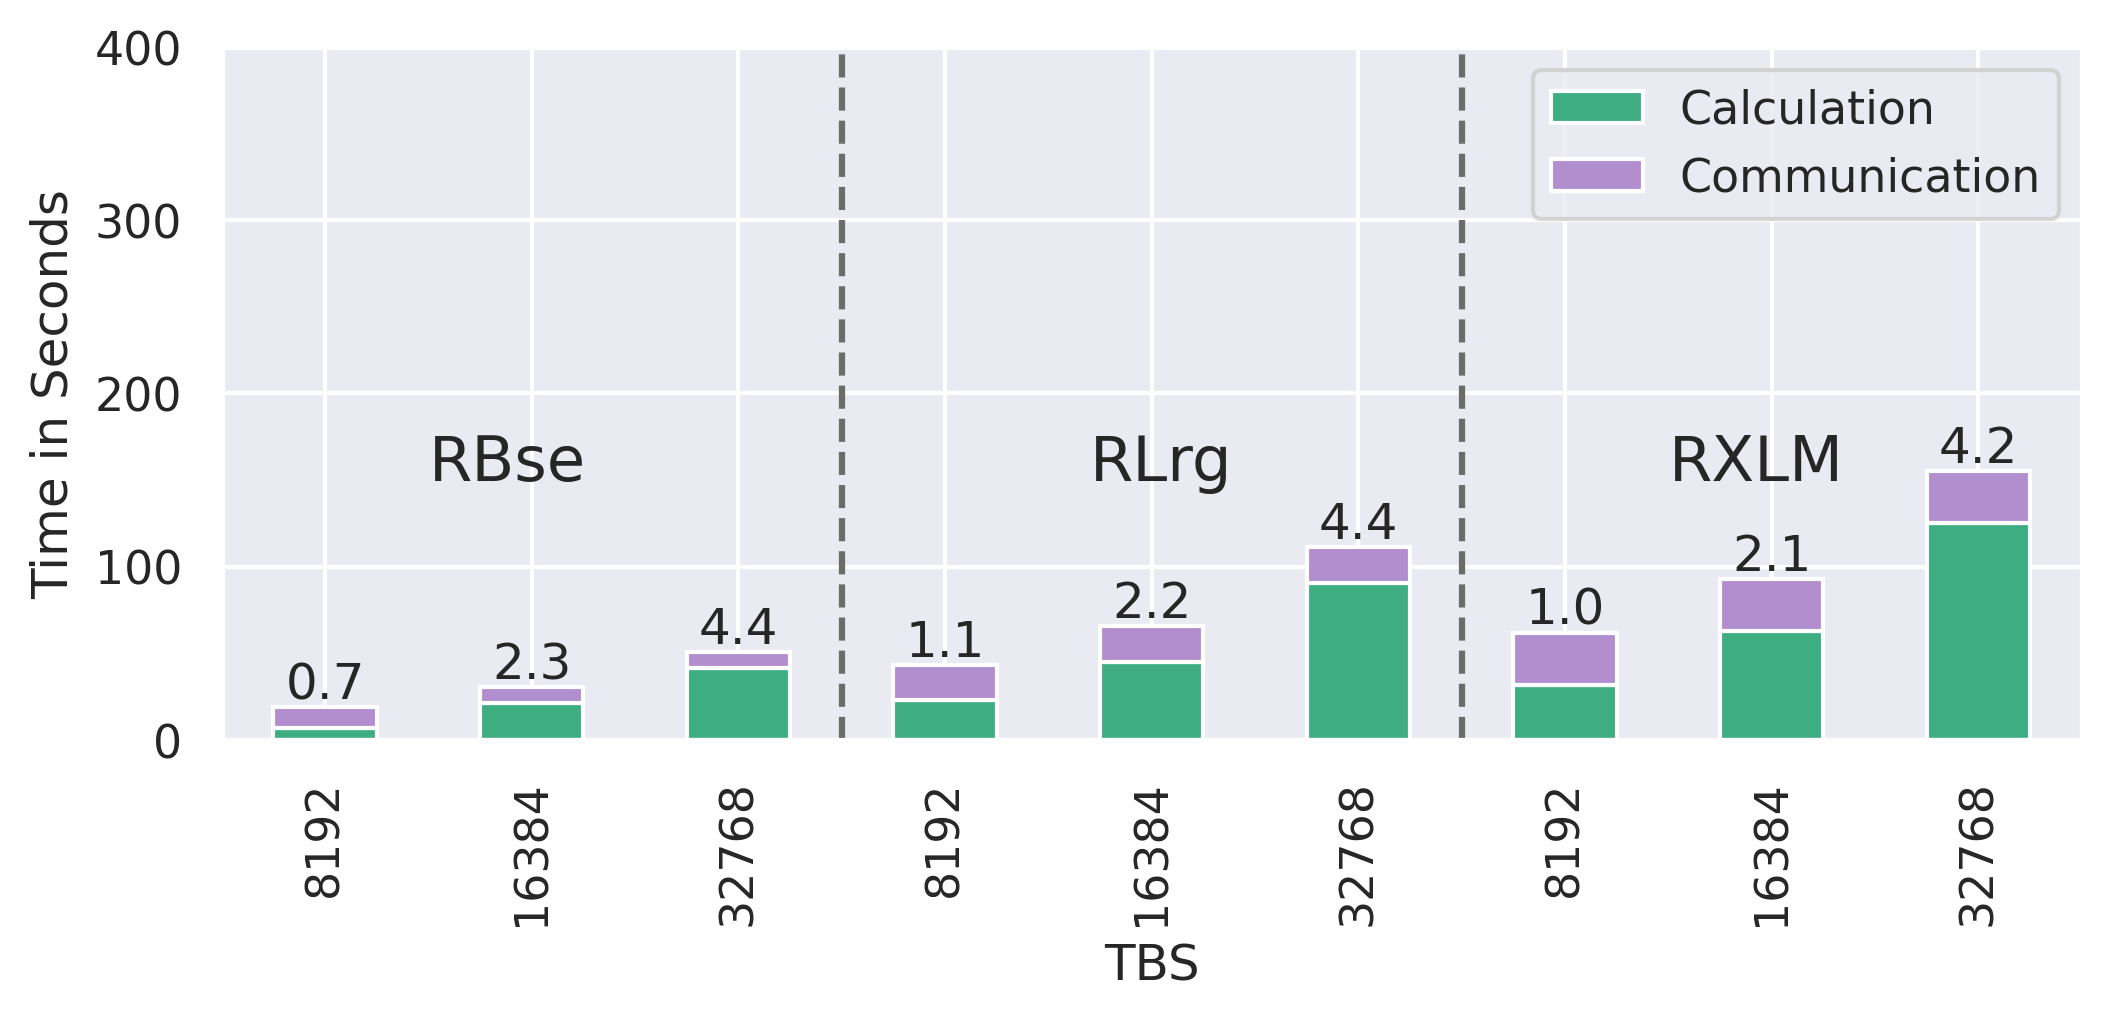

In [30]:
nlp_combined_granularity_df = pd.concat(objs=[
    rBse_2xA10_8192_df,
    rBse_2xA10_16384_df,
    rBse_2xA10_32768_df,
    rLrg_2xA10_8192_df,
    rLrg_2xA10_16384_df,
    rLrg_2xA10_32768_df,
    rXLM_2xA10_8192_df,
    rXLM_2xA10_16384_df,
    rXLM_2xA10_32768_df,
])

sns.set(palette=granularity_palette)
ax = nlp_combined_granularity_df[["calc_time_s","comm_time_s","name"]].set_index('name').plot(kind='bar', stacked=True, figsize=(8,3))
plt.ylabel("Time in Seconds")
plt.xlabel("TBS")
plt.ylim(0,400)
plt.legend(labels=["Calculation", "Communication"])
ax.axvline(2.5, color="#6c6c6c", linestyle="--")
ax.axvline(5.5, color="#6c6c6c", linestyle="--")
ax.text(0.5, 150, "RBse", fontsize=15)
ax.text(3.7, 150, "RLrg", fontsize=15)
ax.text(6.5, 150, "RXLM", fontsize=15)
labels = [item.get_text() for item in ax.get_xticklabels()]
labels = ["".join(label.split(" ")[-1]) for label in labels]
ax.set_xticklabels(labels)
show_granulartiy_values(ax=ax, df=nlp_combined_granularity_df, decimals=1)
save_fig("nlp_2xa10_all-tbs_granularity")

In [31]:
nlp_a10_3x_runs_df = get_hivemind_runs(run_names=[
    "hivemind-311",
    "hivemind-312",
    "hivemind-313",
    ],
    drop_first_epoch=True
)
nlp_a10_3x_runs_df = rename_models(df = nlp_a10_3x_runs_df)
nlp_a10_3x_runs_df["gpu_count"] = int(3)
nlp_a10_3x_runs_df["gpu_type"] = "A10"

nlp_a10_4x_runs_df = get_hivemind_runs(run_names=[
    "hivemind-320",
    "hivemind-321",
    "hivemind-322",
    ],
    drop_first_epoch=True
)
nlp_a10_4x_runs_df = rename_models(df = nlp_a10_4x_runs_df)
nlp_a10_4x_runs_df["gpu_count"] = int(4)
nlp_a10_4x_runs_df["gpu_type"] = "A10"

nlp_a10_8x_runs_df = get_hivemind_runs(run_names=[
    "hivemind-331",
    "hivemind-332",
    "hivemind-333"
    ],
    drop_first_epoch=True
)
nlp_a10_8x_runs_df = rename_models(df = nlp_a10_8x_runs_df)
nlp_a10_8x_runs_df["gpu_count"] = int(8)
nlp_a10_8x_runs_df["gpu_type"] = "A10"

> Found 1 runs with the prefix 'trainmonitor'.
> Found 1 runs with the prefix 'trainmonitor'.
> Found 1 runs with the prefix 'trainmonitor'.
> Found 1 runs with the prefix 'trainmonitor'.
> Found 1 runs with the prefix 'trainmonitor'.
> Found 1 runs with the prefix 'trainmonitor'.
> Found 1 runs with the prefix 'trainmonitor'.
> Found 1 runs with the prefix 'trainmonitor'.
> Found 1 runs with the prefix 'trainmonitor'.


In [32]:
full_nlp_a10_runs_df = pd.concat(objs=[
    nlp_a10_baseline_df,
    nlp_a10_2x_runs_df,
    nlp_a10_3x_runs_df,
    nlp_a10_4x_runs_df,
    nlp_a10_8x_runs_df])

In [33]:
full_nlp_a10_runs_df.query("model=='RoBERTaBase' and gpu_count==2")

samples_per_sec          name        model    TBS  gpu_count gpu_type  \
8               NaN  hivemind-297  RoBERTaBase   8192          2      A10   
9               NaN  hivemind-297  RoBERTaBase   8192          2      A10   
10              NaN  hivemind-297  RoBERTaBase   8192          2      A10   
11              NaN  hivemind-297  RoBERTaBase   8192          2      A10   
12              NaN  hivemind-297  RoBERTaBase   8192          2      A10   
13              NaN  hivemind-297  RoBERTaBase   8192          2      A10   
14              NaN  hivemind-297  RoBERTaBase   8192          2      A10   
15              NaN  hivemind-297  RoBERTaBase   8192          2      A10   
16              NaN  hivemind-297  RoBERTaBase   8192          2      A10   
17       664.366250  hivemind-297  RoBERTaBase   8192          2      A10   
18              NaN  hivemind-297  RoBERTaBase   8192          2      A10   
19              NaN  hivemind-297  RoBERTaBase   8192          2      A10   
20              NaN  hivemind-297  RoBERTaBase   8192          2      A10   
21              NaN  hivemind-297  RoBERTaBase   8192          2      A10   
22              NaN  hivemind-297  RoBERTaBase   8192          2      A10   
23              NaN  hivemind-297  RoBERTaBase   8192          2      A10   
24              NaN  hivemind-297  RoBERTaBase   8192          2      A10   
25              NaN  hivemind-297  RoBERTaBase   8192          2      A10   
26              NaN  hivemind-297  RoBERTaBase   8192          2      A10   
27              NaN  hivemind-297  RoBERTaBase   8192          2      A10   
28              NaN  hivemind-297  RoBERTaBase   8192          2      A10   
29       574.835651  hivemind-297  RoBERTaBase   8192          2      A10   
30              NaN  hivemind-297  RoBERTaBase   8192          2      A10   
31              NaN  hivemind-297  RoBERTaBase   8192          2      A10   
32              NaN  hivemind-297  RoBERTaBase   8192          2      A10   
33              NaN  hivemind-297  RoBERTaBase   8192          2      A10   
34              NaN  hivemind-297  RoBERTaBase   8192          2      A10   
35              NaN  hivemind-297  RoBERTaBase   8192          2      A10   
36              NaN  hivemind-297  RoBERTaBase   8192          2      A10   
37       800.899368  hivemind-297  RoBERTaBase   8192          2      A10   
15              NaN  hivemind-300  RoBERTaBase  16384          2      A10   
16              NaN  hivemind-300  RoBERTaBase  16384          2      A10   
17              NaN  hivemind-300  RoBERTaBase  16384          2      A10   
18              NaN  hivemind-300  RoBERTaBase  16384          2      A10   
19              NaN  hivemind-300  RoBERTaBase  16384          2      A10   
20              NaN  hivemind-300  RoBERTaBase  16384          2      A10   
21              NaN  hivemind-300  RoBERTaBase  16384          2      A10   
22              NaN  hivemind-300  RoBERTaBase  16384          2      A10   
23              NaN  hivemind-300  RoBERTaBase  16384          2      A10   
24              NaN  hivemind-300  RoBERTaBase  16384          2      A10   
25      1254.294573  hivemind-300  RoBERTaBase  16384          2      A10   
26              NaN  hivemind-300  RoBERTaBase  16384          2      A10   
27              NaN  hivemind-300  RoBERTaBase  16384          2      A10   
28              NaN  hivemind-300  RoBERTaBase  16384          2      A10   
29              NaN  hivemind-300  RoBERTaBase  16384          2      A10   
30              NaN  hivemind-300  RoBERTaBase  16384          2      A10   
31              NaN  hivemind-300  RoBERTaBase  16384          2      A10   
32              NaN  hivemind-300  RoBERTaBase  16384          2      A10   
33              NaN  hivemind-300  RoBERTaBase  16384          2      A10   
34              NaN  hivemind-300  RoBERTaBase  16384          2      A10   
35              NaN  hivemind-300  RoBERTaBase  16384          2      A10   


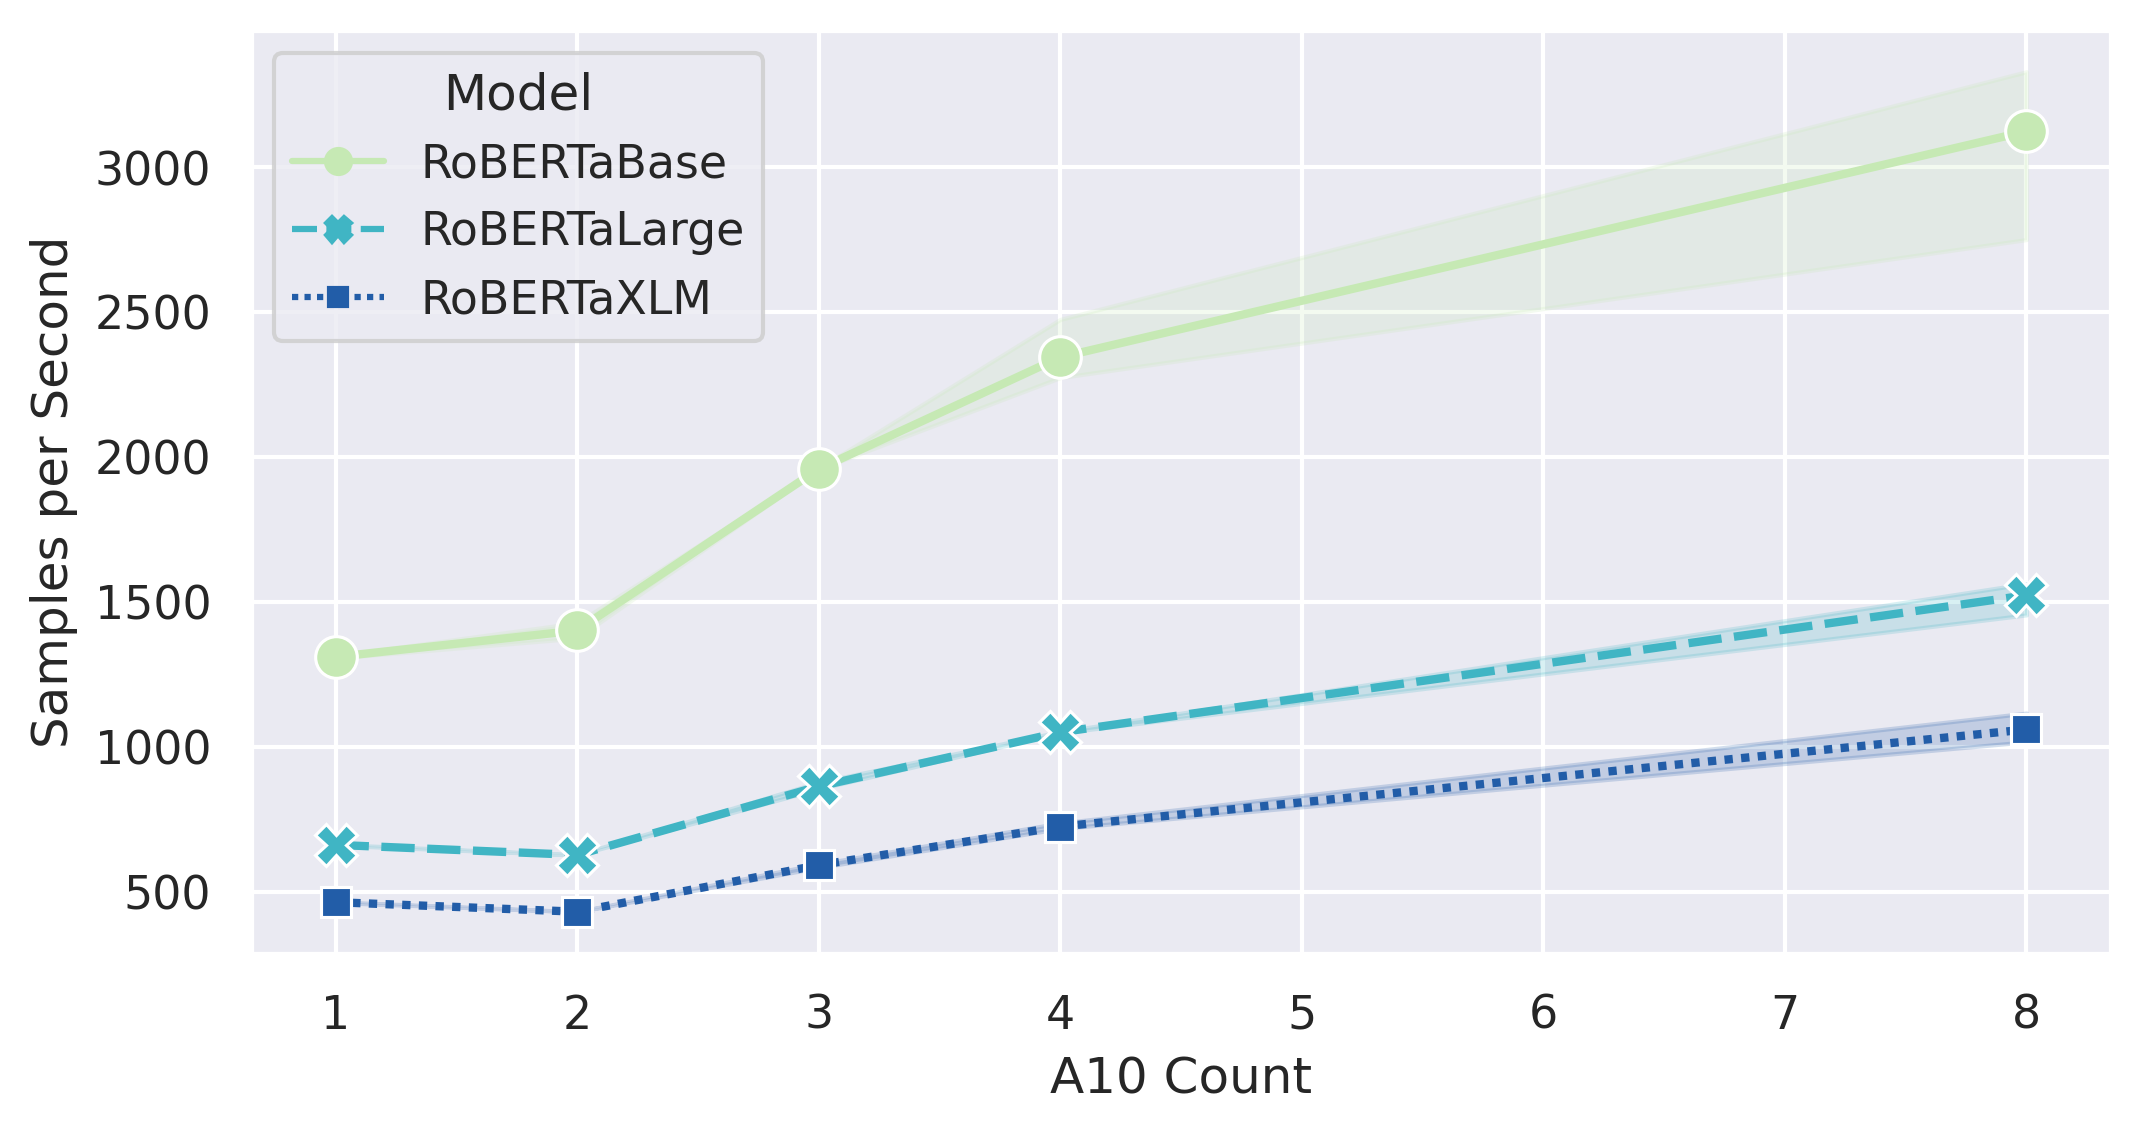

In [34]:
# filter small models out
temp_df = full_nlp_a10_runs_df#.query("model=='RoBERTaLarge' or model=='RoBERTaXLM'")
# filter local sps out
temp_df = temp_df.query("samples_per_sec.notna()")
# filter out non-32k TBS
temp_df = temp_df.query("TBS==32768")

nlp_palette = sns.color_palette("YlGnBu", 3)
pal = sns.color_palette(palette=nlp_palette)
sns.set(palette=pal)
plt.figure(figsize=(8,4))
ax = sns.lineplot(
    data=temp_df,
    x="gpu_count",
    y="samples_per_sec",
    hue="model",
    style="model",
    #errorbar=('sd', 1),
    dashes=True, err_style="band",
    markers=True,
    linewidth=2.0,
    markersize=10.0
)
#plt.title("NLP Model Suitability Study")
plt.ylabel("Samples per Second")
plt.xlabel("A10 Count")
plt.legend(title="Model")
#sns.move_legend(ax, "upper right", bbox_to_anchor=(1.29, 1.025))
save_fig("nlp_multi-a10_scalability")

## NLP Speedup

In [35]:
def get_mean_throughput(model, gpu_count):
    TBS = 32768
    temp_df = full_nlp_a10_runs_df.query(f"samples_per_sec.notna() and TBS=={TBS} and model=='{model}' and gpu_count=={gpu_count}")
    return temp_df["samples_per_sec"].mean()

for model in full_nlp_a10_runs_df["model"].unique():
    print(f"Model {model}:")
    baseline_sps = get_mean_throughput(model=model, gpu_count=1)
    for gpu_count in [2,3,4,8]:
        hivemind_sps = get_mean_throughput(model=model, gpu_count=gpu_count)
        print(f" - Speedup on {gpu_count} GPUS: {round(hivemind_sps / baseline_sps,2)}x, Norm: {round(hivemind_sps / baseline_sps / gpu_count,2)} ({round(hivemind_sps,1)}, {round(baseline_sps,1)})")

Model RoBERTaBase:
 - Speedup on 2 GPUS: 1.07x, Norm: 0.53 (1401.5, 1310.3)
 - Speedup on 3 GPUS: 1.49x, Norm: 0.5 (1958.9, 1310.3)
 - Speedup on 4 GPUS: 1.79x, Norm: 0.45 (2344.7, 1310.3)
 - Speedup on 8 GPUS: 2.38x, Norm: 0.3 (3124.4, 1310.3)
Model RoBERTaLarge:
 - Speedup on 2 GPUS: 0.95x, Norm: 0.47 (626.7, 661.5)
 - Speedup on 3 GPUS: 1.3x, Norm: 0.43 (863.2, 661.5)
 - Speedup on 4 GPUS: 1.59x, Norm: 0.4 (1050.1, 661.5)
 - Speedup on 8 GPUS: 2.3x, Norm: 0.29 (1523.0, 661.5)
Model RoBERTaXLM:
 - Speedup on 2 GPUS: 0.93x, Norm: 0.46 (430.8, 463.6)
 - Speedup on 3 GPUS: 1.28x, Norm: 0.43 (591.3, 463.6)
 - Speedup on 4 GPUS: 1.56x, Norm: 0.39 (724.6, 463.6)
 - Speedup on 8 GPUS: 2.29x, Norm: 0.29 (1059.9, 463.6)


In [36]:
debug = False
rBse_3xA10_32768_df = get_granularity_cumulated(run_name="hivemind-311", name="RBse 3xA10 32768", debug=debug)
rLrg_3xA10_32768_df = get_granularity_cumulated(run_name="hivemind-312",  name="RLrg 3xA10 32768", debug=debug)
rXLM_3xA10_32768_df = get_granularity_cumulated(run_name="hivemind-313",  name="RXLM 3xA10 32768", debug=debug)

rBse_4xA10_32768_df = get_granularity_cumulated(run_name="hivemind-320", name="RBse 4xA10 32768", debug=debug)
rLrg_4xA10_32768_df = get_granularity_cumulated(run_name="hivemind-321",  name="RLrg 4xA10 32768", debug=debug)
rXLM_4xA10_32768_df = get_granularity_cumulated(run_name="hivemind-322",  name="RXLM 4xA10 32768", debug=debug)

rBse_8xA10_32768_df = get_granularity_cumulated(run_name="hivemind-331", name="RBse 8xA10 32768", debug=debug)
rLrg_8xA10_32768_df = get_granularity_cumulated(run_name="hivemind-332",  name="RLrg 8xA10 32768", debug=debug)
rXLM_8xA10_32768_df = get_granularity_cumulated(run_name="hivemind-333",  name="RXLM 8xA10 32768", debug=debug)

> Found 3 runs with the infix 'bee'.
> Found 3 runs with the infix 'bee'.
> Found 3 runs with the infix 'bee'.
> Found 4 runs with the infix 'bee'.
> Found 4 runs with the infix 'bee'.
> Found 4 runs with the infix 'bee'.
> Found 8 runs with the infix 'bee'.
> Found 8 runs with the infix 'bee'.
> Found 8 runs with the infix 'bee'.


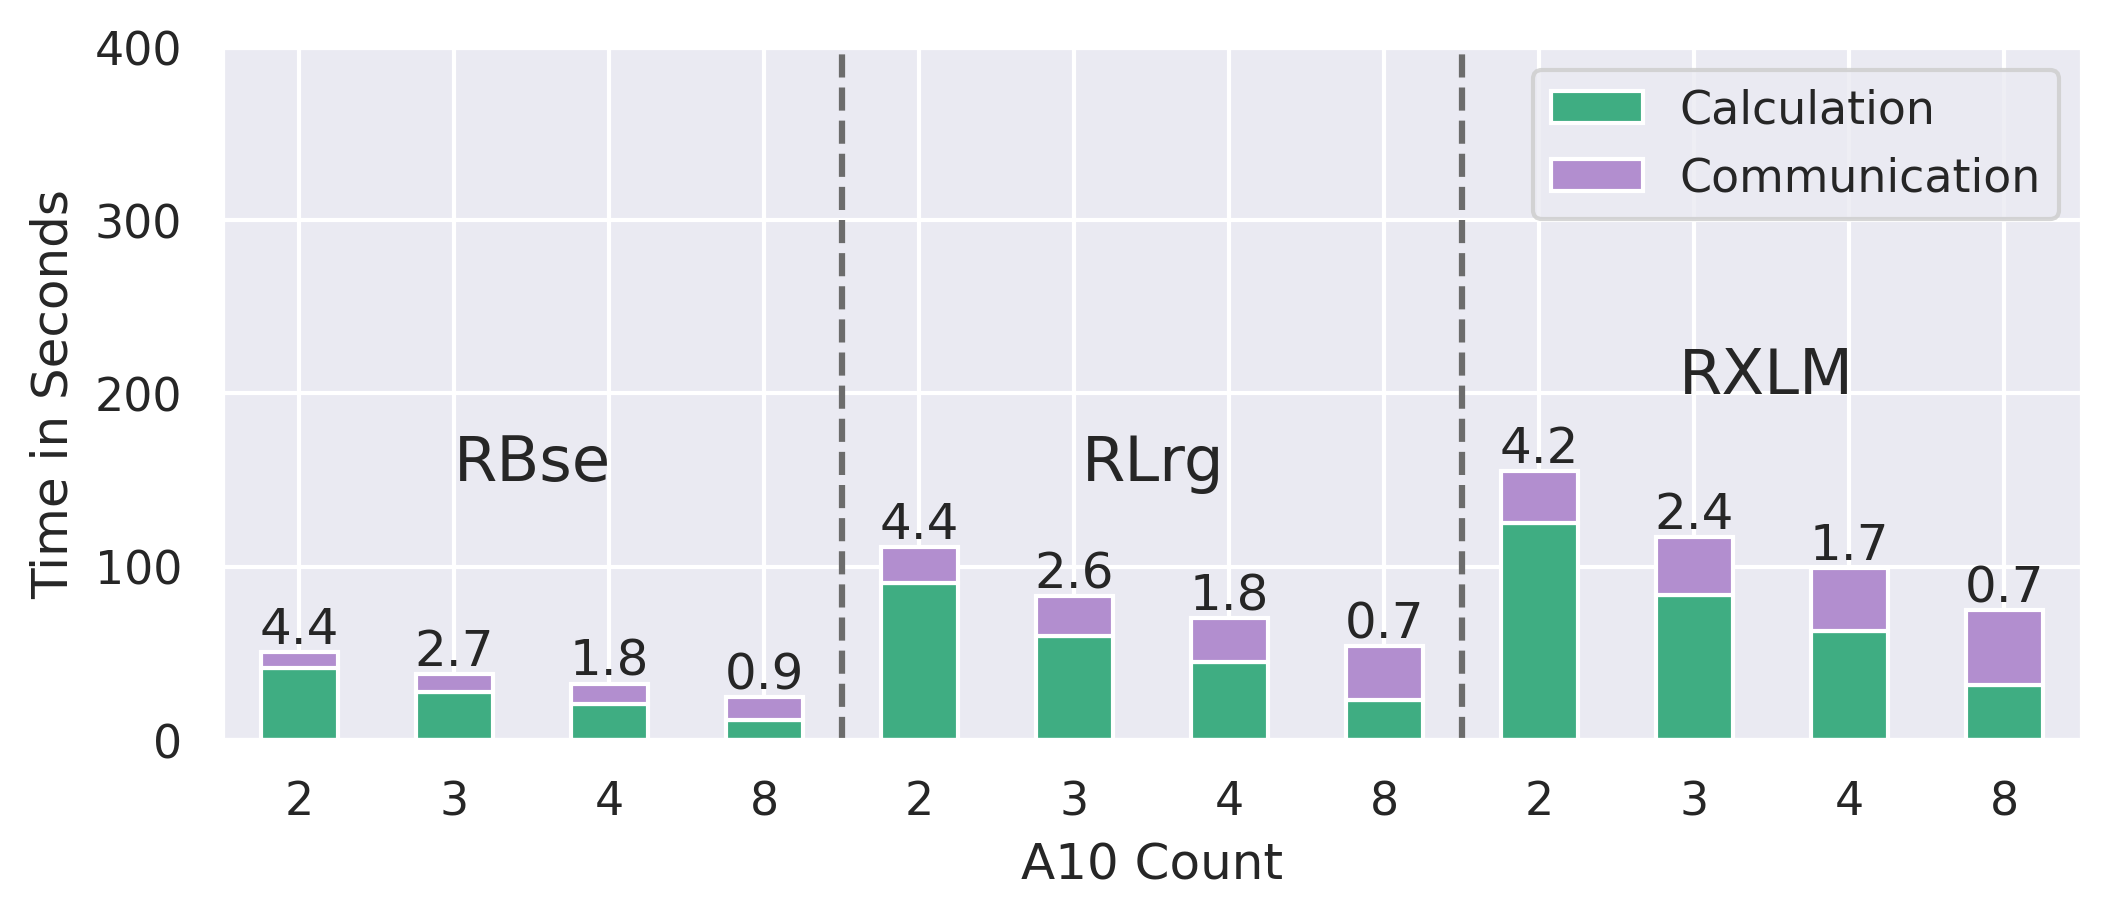

In [37]:
nlp_full_a10_granulartiy_df = pd.concat(objs=[
    rBse_2xA10_32768_df,
    rBse_3xA10_32768_df,
    rBse_4xA10_32768_df,
    rBse_8xA10_32768_df,
    rLrg_2xA10_32768_df,
    rLrg_3xA10_32768_df,
    rLrg_4xA10_32768_df,
    rLrg_8xA10_32768_df,
    rXLM_2xA10_32768_df,
    rXLM_3xA10_32768_df,
    rXLM_4xA10_32768_df,
    rXLM_8xA10_32768_df,
])

sns.set(palette=granularity_palette)
ax = nlp_full_a10_granulartiy_df[["calc_time_s","comm_time_s","name"]].set_index('name').plot(kind='bar', stacked=True, figsize=(8,3))
plt.ylabel("Time in Seconds")
plt.xlabel("A10 Count")
plt.legend(labels=["Calculation", "Communication"])
plt.ylim(0,400)
ax.axvline(3.5, color="#6c6c6c", linestyle="--")
ax.axvline(7.5, color="#6c6c6c", linestyle="--")
ax.text(1, 150, "RBse", fontsize=15)
ax.text(5.05, 150, "RLrg", fontsize=15)
ax.text(8.9, 200, "RXLM", fontsize=15)
labels = [item.get_text() for item in ax.get_xticklabels()]
labels = ["".join(label.split(" ")[1:2])[0] for label in labels]
ax.set_xticklabels(labels, rotation=0)
show_granulartiy_values(ax=ax, df=nlp_full_a10_granulartiy_df, decimals=1)
save_fig("nlp_full-a10_all-tbs_granularity")

<Figure size 2400x900 with 0 Axes>

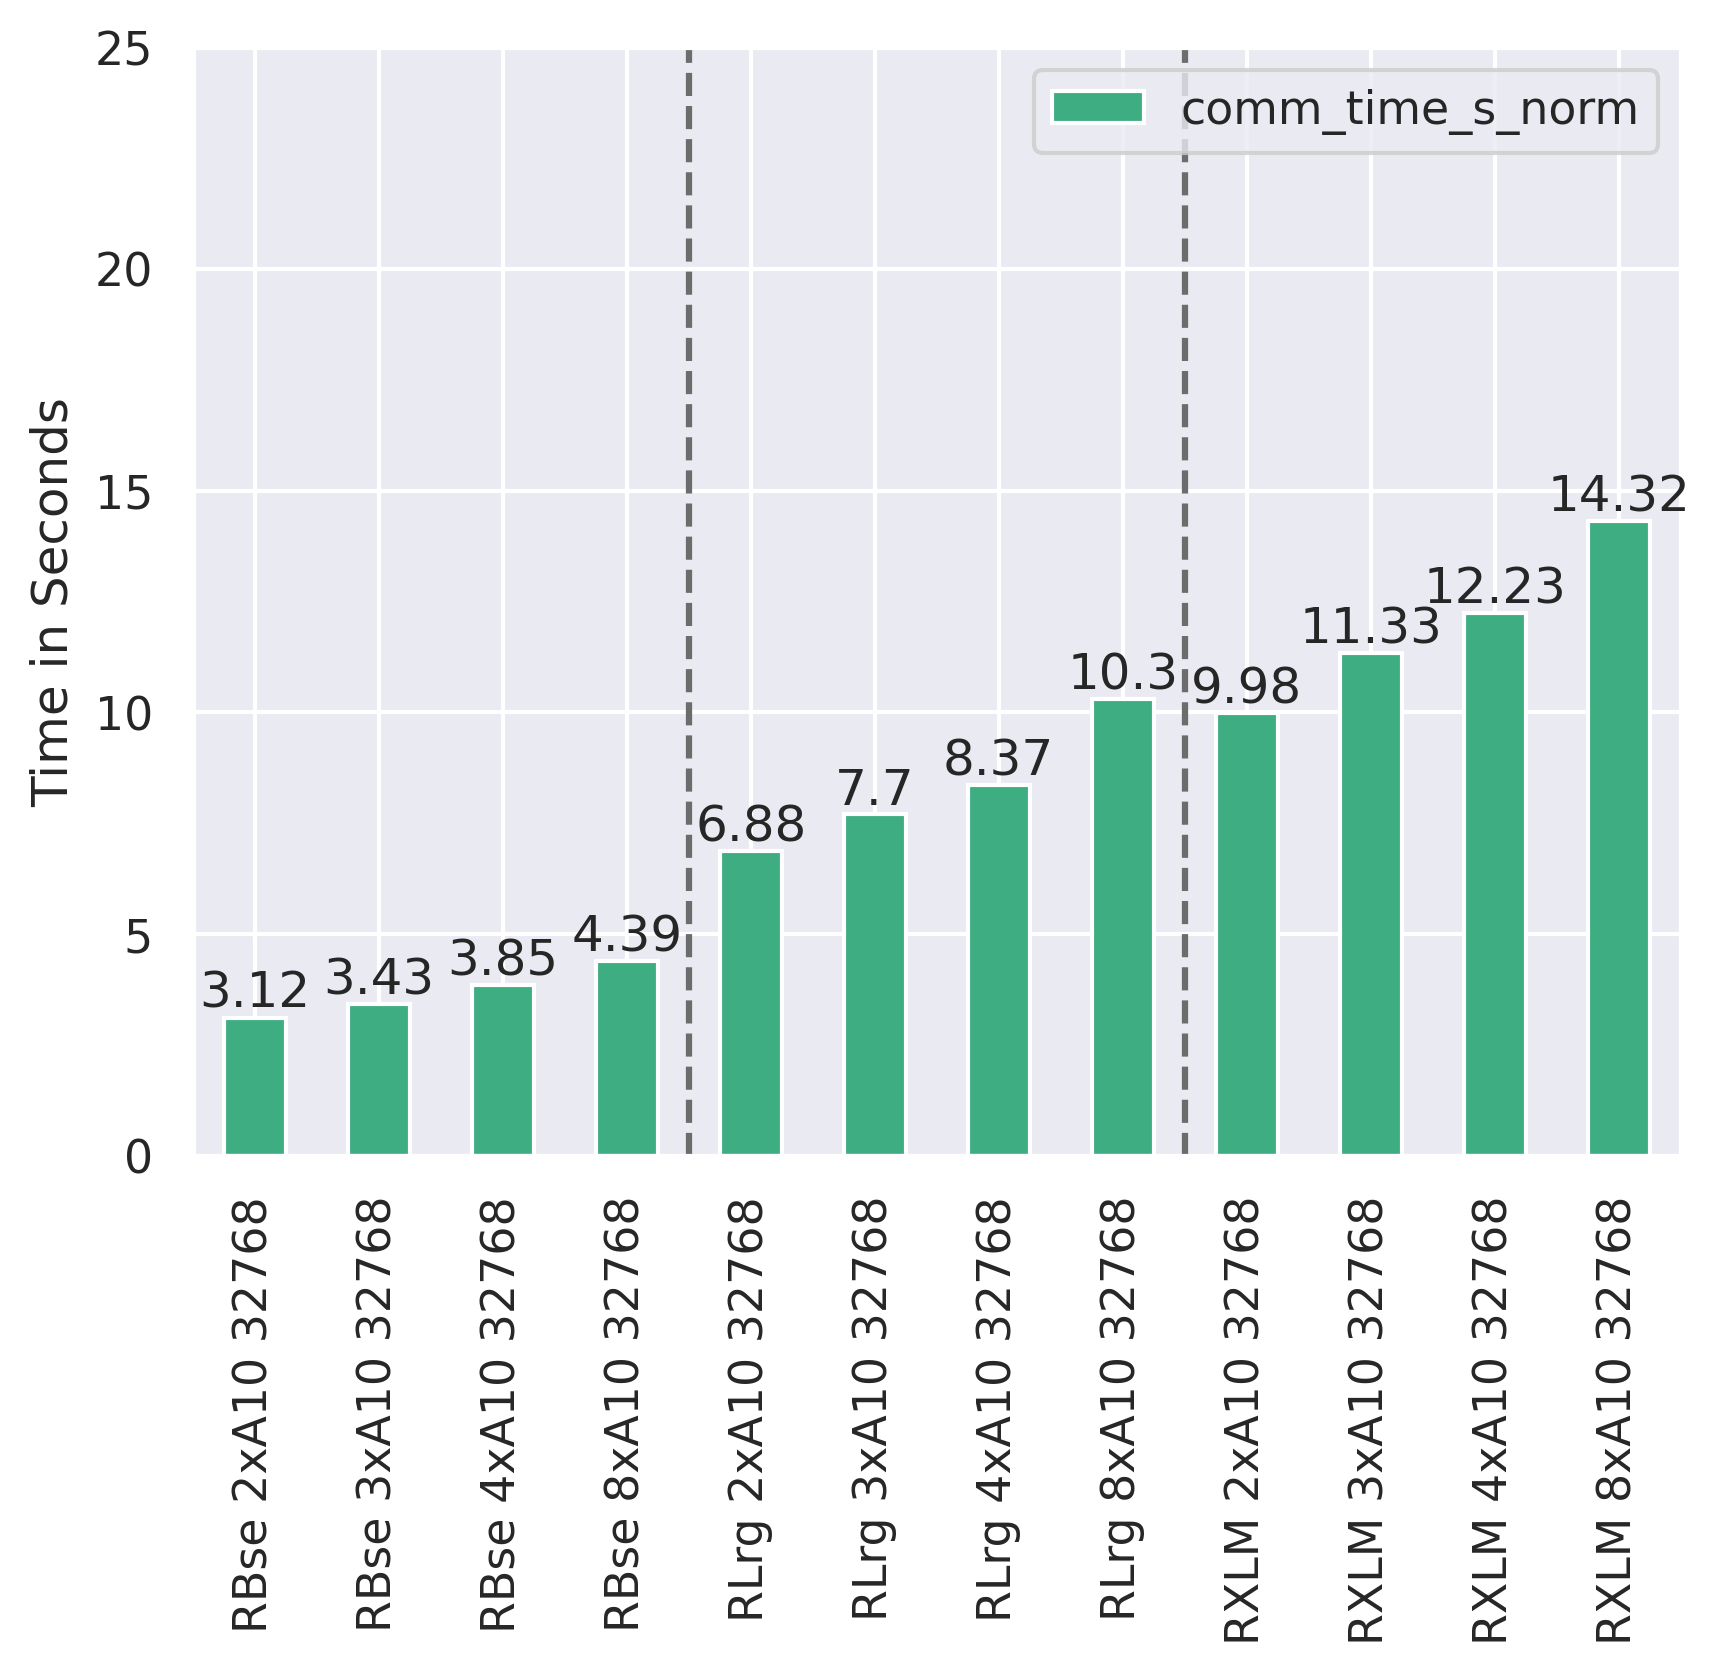

In [38]:
nlp_full_a10_granulartiy_df = pd.concat(objs=[
    rBse_2xA10_32768_df,
    rBse_3xA10_32768_df,
    rBse_4xA10_32768_df,
    rBse_8xA10_32768_df,
    rLrg_2xA10_32768_df,
    rLrg_3xA10_32768_df,
    rLrg_4xA10_32768_df,
    rLrg_8xA10_32768_df,
    rXLM_2xA10_32768_df,
    rXLM_3xA10_32768_df,
    rXLM_4xA10_32768_df,
    rXLM_8xA10_32768_df,
])
nlp_full_a10_granulartiy_df["comm_time_s_norm"] = nlp_full_a10_granulartiy_df["comm_time_s"] / 3

sns.set(palette=granularity_palette)
plt.figure(figsize=(8,3))
ax = nlp_full_a10_granulartiy_df[["comm_time_s_norm","name"]].set_index('name').plot(kind='bar', stacked=True)
plt.ylabel("Time in Seconds")
plt.xlabel("")
#plt.legend(labels=["Calculation", "Communication"])
plt.ylim(0,25)
ax.axvline(3.5, color="#6c6c6c", linestyle="--")
ax.axvline(7.5, color="#6c6c6c", linestyle="--")
round_bar_value_multi(ax, decimals=2)
#show_granulartiy_values(ax=ax, df=nlp_full_a10_granulartiy_df, decimals=1)
#save_fig("nlp_full-a10_all-tbs_granularity")

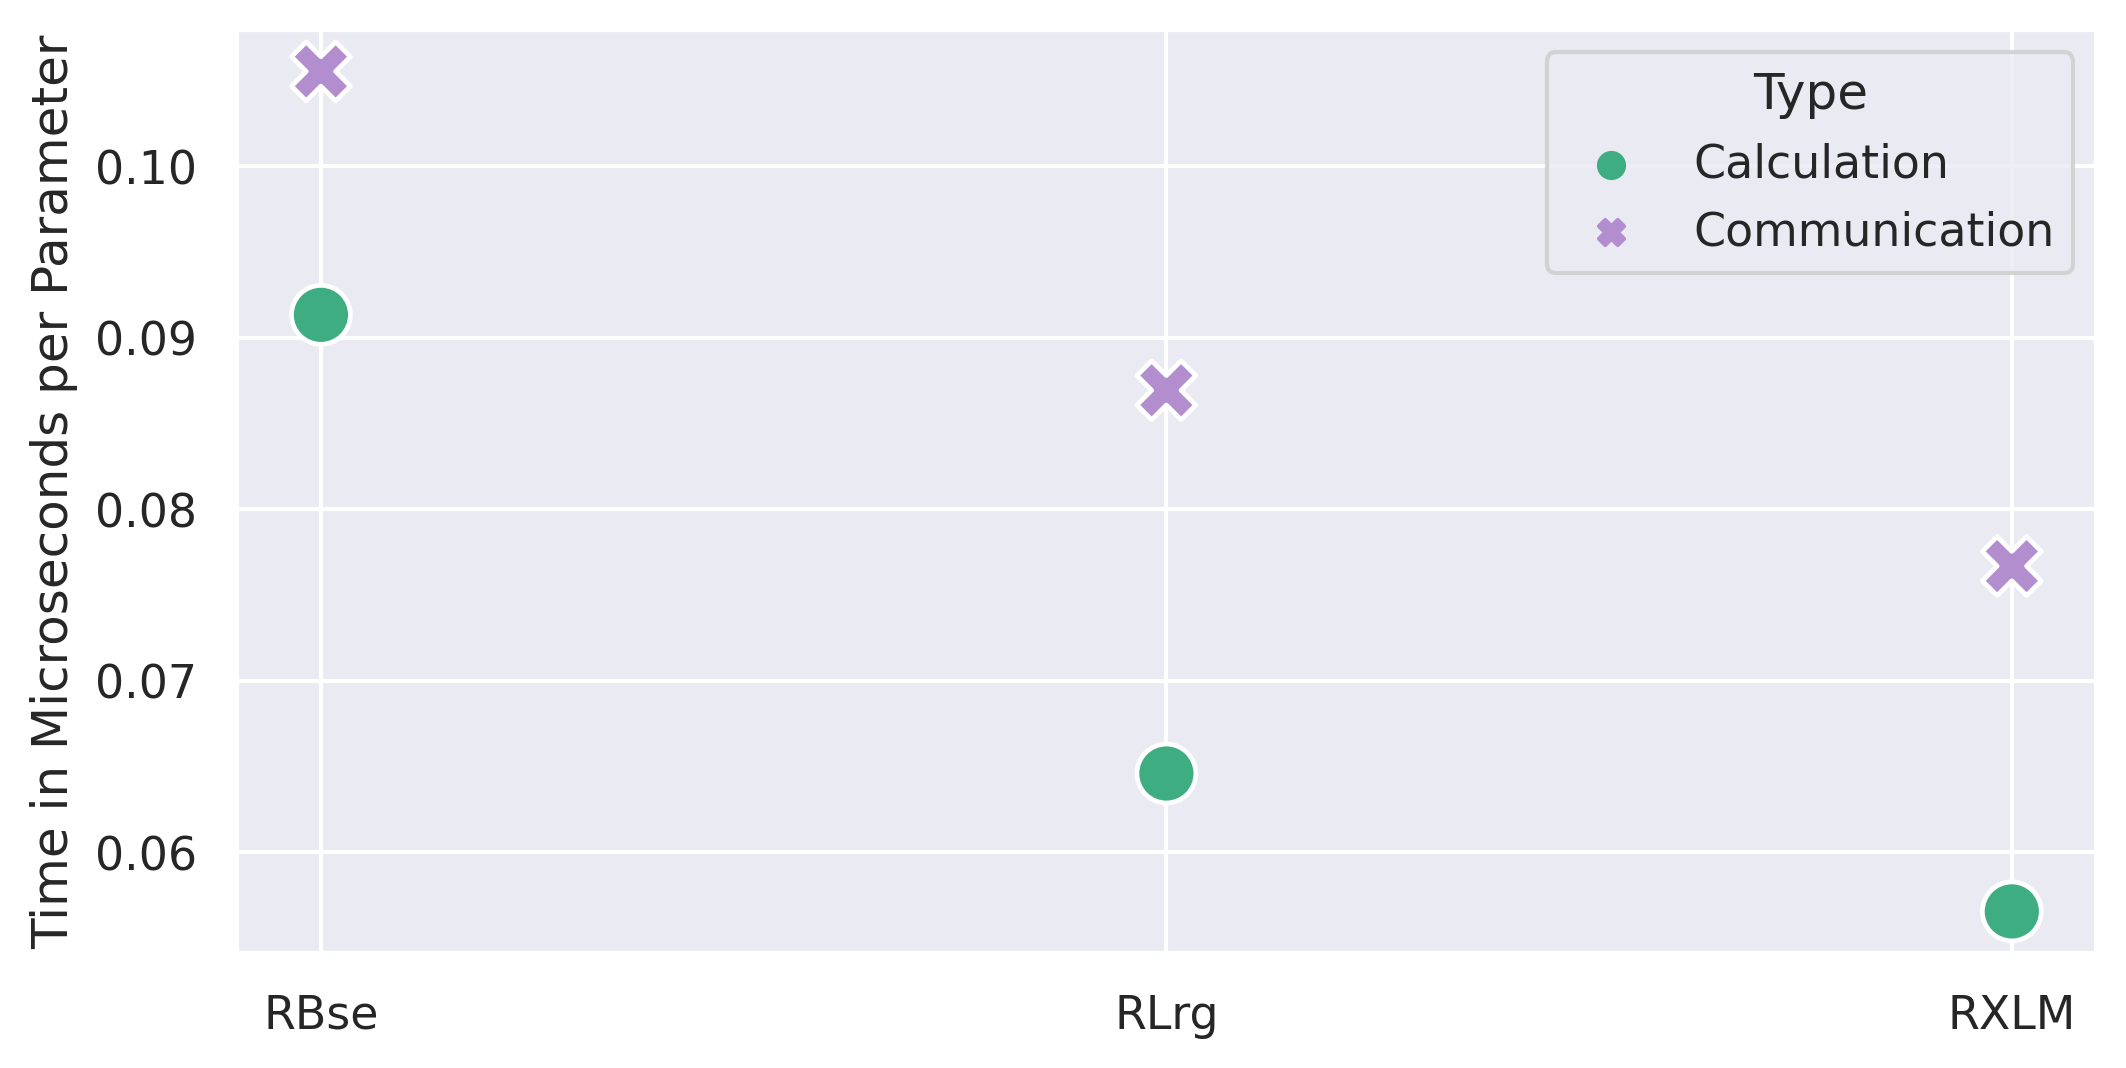

In [39]:
temp_df = pd.concat(objs=[
    rBse_8xA10_32768_df,
    rLrg_8xA10_32768_df,
    rXLM_8xA10_32768_df,
])

agg_dict = {
    "name": [],
    "time_µ": [],
    "time_type": []
}

def to_agg(name, time_s, time_type):
    agg_dict["name"].append(name)
    agg_dict["time_µ"].append(time_s * 1000 * 1000)
    agg_dict["time_type"].append(time_type)

for name in temp_df["name"].unique():
    row = temp_df.query(f"name == '{name}'")
    new_name = name.split(" ")[0]
    if new_name == "RBse":
        param_size = 124.7 * 10**6
    elif new_name == "RLrg":
        param_size = 355.4 * 10**6
    elif new_name == "RXLM":
        param_size = 560.1 * 10**6
    to_agg(name=new_name, time_s=row["calc_time_s"].item() / param_size, time_type="Calculation")
    to_agg(name=new_name, time_s=row["comm_time_s"].item() / param_size, time_type="Communication")

agg_df = pd.DataFrame(agg_dict)
#agg_df

sns.set(palette=granularity_palette)
plt.figure(figsize=(8,4))

sns.scatterplot(
    data=agg_df,
    x="name",
    y="time_µ",
    hue="time_type",
    color="0.3", s=200, style="time_type", zorder=2)

plt.ylabel("Time in Microseconds per Parameter")
plt.xlabel("")
plt.legend(title="Type")
#save_fig("nlp_8xA10_baseline_calc_vs_comm_plot")




# Geo-distributed Experiments

In [40]:
cv_us_1xt4_df = get_baseline_runs(run_names=["baseline-75-torchvision.models.convnext_large"])
cv_us_1xt4_df = rename_models(df = cv_us_1xt4_df)
cv_us_1xt4_df["gpu_count"] = int(1)
cv_us_1xt4_df["gpu_type"] = "CV A-1"

cv_us_2xt4_df = get_hivemind_runs(run_names=["hivemind-81"], drop_first_epoch=True)
cv_us_2xt4_df = rename_models(df = cv_us_2xt4_df)
cv_us_2xt4_df["gpu_count"] = int(2)
cv_us_2xt4_df["gpu_type"] = "CV A-2"

cv_us_3xt4_df = get_hivemind_runs(run_names=["hivemind-354"], drop_first_epoch=True)
cv_us_3xt4_df = rename_models(df = cv_us_3xt4_df)
cv_us_3xt4_df["gpu_count"] = int(3)
cv_us_3xt4_df["gpu_type"] = "CV A-3"

cv_us_4xt4_df = get_hivemind_runs(run_names=["hivemind-77"], drop_first_epoch=True)
cv_us_4xt4_df = rename_models(df = cv_us_4xt4_df)
cv_us_4xt4_df["gpu_count"] = int(4)
cv_us_4xt4_df["gpu_type"] = "CV A-4"

cv_us_6xt4_df = get_hivemind_runs(run_names=["hivemind-114"], drop_first_epoch=True)
cv_us_6xt4_df = rename_models(df = cv_us_6xt4_df)
cv_us_6xt4_df["gpu_count"] = int(6)
cv_us_6xt4_df["gpu_type"] = "CV A-6"

cv_us_8xt4_df = get_hivemind_runs(run_names=["hivemind-79"], drop_first_epoch=True)
cv_us_8xt4_df = rename_models(df = cv_us_8xt4_df)
cv_us_8xt4_df["gpu_count"] = int(8)
cv_us_8xt4_df["gpu_type"] = "CV A-8"

nlp_us_1xt4_df = get_baseline_runs(run_names=["baseline-76-roberta_mlm_xlm"])
nlp_us_1xt4_df = rename_models(df = nlp_us_1xt4_df)
nlp_us_1xt4_df["gpu_count"] = int(1)
nlp_us_1xt4_df["gpu_type"] = "NLP A-1"

nlp_us_2xt4_df = get_hivemind_runs(run_names=["hivemind-82"], drop_first_epoch=True)
nlp_us_2xt4_df = rename_models(df = nlp_us_2xt4_df)
nlp_us_2xt4_df["gpu_count"] = int(2)
nlp_us_2xt4_df["gpu_type"] = "NLP A-2"

nlp_us_3xt4_df = get_hivemind_runs(run_names=["hivemind-356"], drop_first_epoch=True)
nlp_us_3xt4_df = rename_models(df = nlp_us_3xt4_df)
nlp_us_3xt4_df["gpu_count"] = int(3)
nlp_us_3xt4_df["gpu_type"] = "NLP A-3"

nlp_us_4xt4_df = get_hivemind_runs(run_names=["hivemind-78"], drop_first_epoch=True)
nlp_us_4xt4_df = rename_models(df = nlp_us_4xt4_df)
nlp_us_4xt4_df["gpu_count"] = int(4)
nlp_us_4xt4_df["gpu_type"] = "NLP A-4"

nlp_us_6xt4_df = get_hivemind_runs(run_names=["hivemind-115"], drop_first_epoch=True)
nlp_us_6xt4_df = rename_models(df = nlp_us_6xt4_df)
nlp_us_6xt4_df["gpu_count"] = int(6)
nlp_us_6xt4_df["gpu_type"] = "NLP A-6"

nlp_us_8xt4_df = get_hivemind_runs(run_names=["hivemind-80"], drop_first_epoch=True)
nlp_us_8xt4_df = rename_models(df = nlp_us_8xt4_df)
nlp_us_8xt4_df["gpu_count"] = int(8)
nlp_us_8xt4_df["gpu_type"] = "NLP A-8"

> Found 1 runs with the prefix 'trainmonitor'.
> Found 1 runs with the prefix 'trainmonitor'.
> Found 1 runs with the prefix 'trainmonitor'.
> Found 1 runs with the prefix 'trainmonitor'.
> Found 1 runs with the prefix 'trainmonitor'.
> Found 1 runs with the prefix 'trainmonitor'.
> Found 1 runs with the prefix 'trainmonitor'.
> Found 1 runs with the prefix 'trainmonitor'.
> Found 1 runs with the prefix 'trainmonitor'.
> Found 1 runs with the prefix 'trainmonitor'.


In [41]:
full_us_t4_runs_df = pd.concat(objs=[
    cv_us_1xt4_df,
    cv_us_2xt4_df,
    cv_us_3xt4_df,
    cv_us_4xt4_df,
    cv_us_6xt4_df,
    cv_us_8xt4_df,
    nlp_us_1xt4_df,
    nlp_us_2xt4_df,
    nlp_us_3xt4_df,
    nlp_us_4xt4_df,
    nlp_us_6xt4_df,
    nlp_us_8xt4_df])

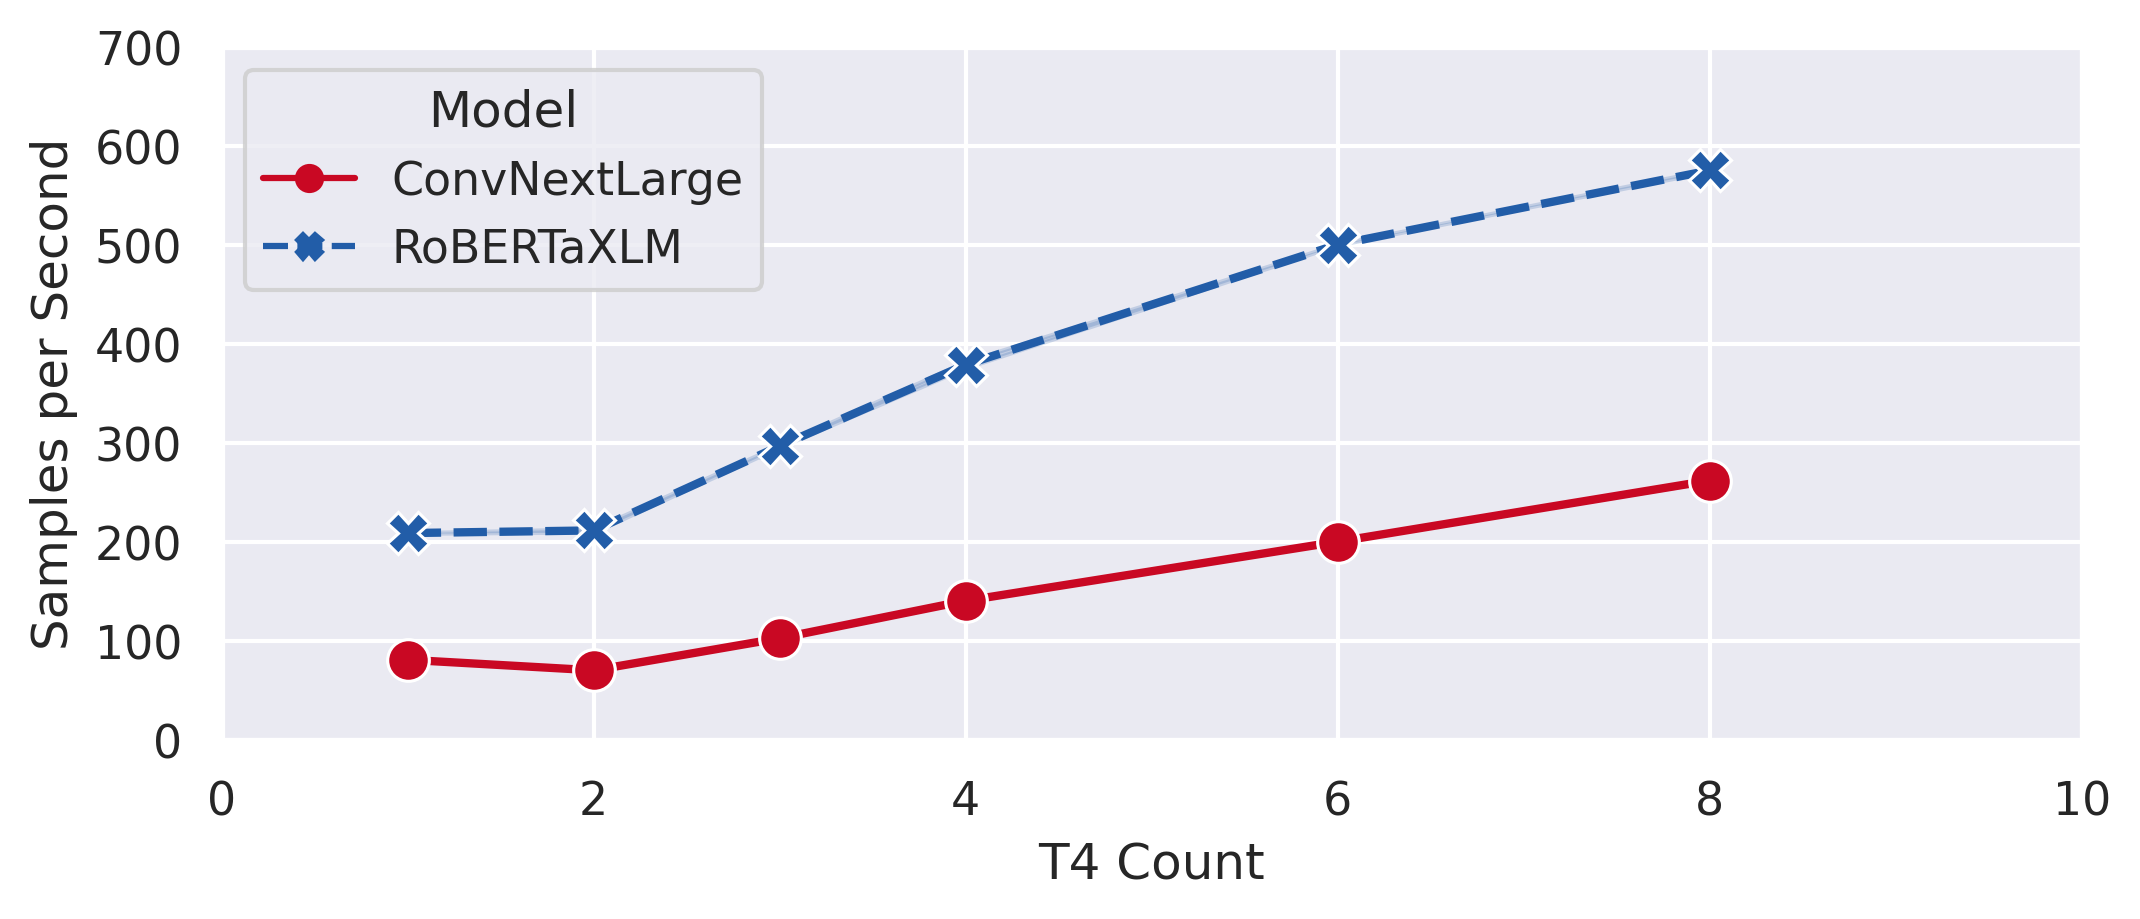

In [42]:
# filter local sps out
temp_df = full_us_t4_runs_df.query("samples_per_sec.notna()")

sns.set(palette=cv_nlp_palette)
plt.figure(figsize=(8,3))
ax = sns.lineplot(
    data=temp_df,
    x="gpu_count", y="samples_per_sec", hue="model", style="model",
    errorbar=('se', 1), dashes=True,
    markers=True,
    linewidth=2.0,
    markersize=10.0
)
#plt.title("Geo-distributed Performance US-only")
plt.xlabel("T4 Count")
plt.ylabel("Samples per Second")
plt.legend(title="Model")
plt.ylim(0,700)
plt.xlim(0,10)
#sns.move_legend(ax, "upper left", bbox_to_anchor=(0, -0.15))
save_fig("geo-distributed-performance-US")

In [43]:
debug = False
cv_2xUS_T4_gran_df = get_granularity_cumulated(run_name="hivemind-81",  name="CV A-2", debug=debug)
cv_2xUS_T4_gran_df["gpu_count"] = 2
cv_2xUS_T4_gran_df["model"] = "ConvNextLarge"
cv_3xUS_T4_gran_df = get_granularity_cumulated(run_name="hivemind-354",  name="CV A-3", debug=debug)
cv_3xUS_T4_gran_df["gpu_count"] = 3
cv_3xUS_T4_gran_df["model"] = "ConvNextLarge"
cv_4xUS_T4_gran_df = get_granularity_cumulated(run_name="hivemind-77",  name="CV A-4", debug=debug)
cv_4xUS_T4_gran_df["gpu_count"] = 4
cv_4xUS_T4_gran_df["model"] = "ConvNextLarge"
cv_6xUS_T4_gran_df = get_granularity_cumulated(run_name="hivemind-114", name="CV A-6", debug=debug)
cv_6xUS_T4_gran_df["gpu_count"] = 6
cv_6xUS_T4_gran_df["model"] = "ConvNextLarge"
cv_8xUS_T4_gran_df = get_granularity_cumulated(run_name="hivemind-79",  name="CV A-8", debug=debug)
cv_8xUS_T4_gran_df["gpu_count"] = 8
cv_8xUS_T4_gran_df["model"] = "ConvNextLarge"

nlp_2xUS_T4_gran_df = get_granularity_cumulated(run_name="hivemind-82",  name="NLP A-2", debug=debug)
nlp_2xUS_T4_gran_df["gpu_count"] = 2
nlp_2xUS_T4_gran_df["model"] = "RobertaXLM"
nlp_3xUS_T4_gran_df = get_granularity_cumulated(run_name="hivemind-356", name="NLP A-3", debug=debug)
nlp_3xUS_T4_gran_df["gpu_count"] = 3
nlp_3xUS_T4_gran_df["model"] = "RobertaXLM"
nlp_4xUS_T4_gran_df = get_granularity_cumulated(run_name="hivemind-78",  name="NLP A-4", debug=debug)
nlp_4xUS_T4_gran_df["gpu_count"] = 4
nlp_4xUS_T4_gran_df["model"] = "RobertaXLM"
nlp_6xUS_T4_gran_df = get_granularity_cumulated(run_name="hivemind-115", name="NLP A-6", debug=debug)
nlp_6xUS_T4_gran_df["gpu_count"] = 6
nlp_6xUS_T4_gran_df["model"] = "RobertaXLM"
nlp_8xUS_T4_gran_df = get_granularity_cumulated(run_name="hivemind-80",  name="NLP A-8", debug=debug)
nlp_8xUS_T4_gran_df["gpu_count"] = 8
nlp_8xUS_T4_gran_df["model"] = "RobertaXLM"

> Found 2 runs with the infix 'bee'.
> Found 3 runs with the infix 'bee'.
> Found 4 runs with the infix 'bee'.
> Found 6 runs with the infix 'bee'.
> Found 8 runs with the infix 'bee'.
> Found 2 runs with the infix 'bee'.
> Found 3 runs with the infix 'bee'.
> Found 4 runs with the infix 'bee'.
> Found 6 runs with the infix 'bee'.
> Found 8 runs with the infix 'bee'.


## US (A) Speedup

In [44]:
def get_mean_throughput(model, gpu_count):
    TBS = 32768
    temp_df = full_us_t4_runs_df.query(f"samples_per_sec.notna() and TBS=={TBS} and model=='{model}' and gpu_count=={gpu_count}")
    return temp_df["samples_per_sec"].mean()

for model in full_us_t4_runs_df["model"].unique():
    print(f"Model {model}:")
    baseline_sps = get_mean_throughput(model=model, gpu_count=1)
    for gpu_count in [2,3,4,6,8]:
        hivemind_sps = get_mean_throughput(model=model, gpu_count=gpu_count)
        print(f" - Speedup on {gpu_count} GPUS: {round(hivemind_sps / baseline_sps,2)}x, Norm: {round(hivemind_sps / baseline_sps / gpu_count,2)} ({round(hivemind_sps,1)}, {round(baseline_sps,1)})")


TBS = 32768
gpu_count = 8
cv_8x_a10_mean_sps = full_cv_a10_runs_df.query(f"samples_per_sec.notna() and TBS=={TBS} and model=='ConvNextLarge' and gpu_count=={gpu_count}")["samples_per_sec"].mean()
nlp_8x_a10_mean_sps = full_nlp_a10_runs_df.query(f"samples_per_sec.notna() and TBS=={TBS} and model=='RoBERTaXLM' and gpu_count=={gpu_count}")["samples_per_sec"].mean()
cv_8x_t4_mean_sps = get_mean_throughput(model="ConvNextLarge", gpu_count=gpu_count)
nlp_8x_t4_mean_sps = get_mean_throughput(model="RoBERTaXLM", gpu_count=gpu_count)
print("A10 comparison:")
print(f" - Speedup for model ConvNextLarge for 8xA10 GPUS : {round(cv_8x_a10_mean_sps / cv_8x_t4_mean_sps,2)}x, ({round(cv_8x_a10_mean_sps,1)}, {round(cv_8x_t4_mean_sps,1)})")
print(f" - Speedup for model RoBERTaXLM    for 8xA10 GPUS : {round(nlp_8x_a10_mean_sps / nlp_8x_t4_mean_sps,2)}x, ({round(nlp_8x_a10_mean_sps,1)}, {round(nlp_8x_t4_mean_sps,1)})")

Model ConvNextLarge:
 - Speedup on 2 GPUS: 0.87x, Norm: 0.43 (70.1, 80.8)
 - Speedup on 3 GPUS: 1.27x, Norm: 0.42 (102.6, 80.8)
 - Speedup on 4 GPUS: 1.74x, Norm: 0.43 (140.4, 80.8)
 - Speedup on 6 GPUS: 2.48x, Norm: 0.41 (200.1, 80.8)
 - Speedup on 8 GPUS: 3.24x, Norm: 0.41 (261.9, 80.8)
Model RoBERTaXLM:
 - Speedup on 2 GPUS: 1.01x, Norm: 0.51 (211.4, 208.8)
 - Speedup on 3 GPUS: 1.42x, Norm: 0.47 (296.7, 208.8)
 - Speedup on 4 GPUS: 1.81x, Norm: 0.45 (378.9, 208.8)
 - Speedup on 6 GPUS: 2.4x, Norm: 0.4 (500.2, 208.8)
 - Speedup on 8 GPUS: 2.75x, Norm: 0.34 (575.1, 208.8)
A10 comparison:
 - Speedup for model ConvNextLarge for 8xA10 GPUS : 2.37x, (620.6, 261.9)
 - Speedup for model RoBERTaXLM    for 8xA10 GPUS : 1.84x, (1059.9, 575.1)


<Figure size 2400x2400 with 0 Axes>

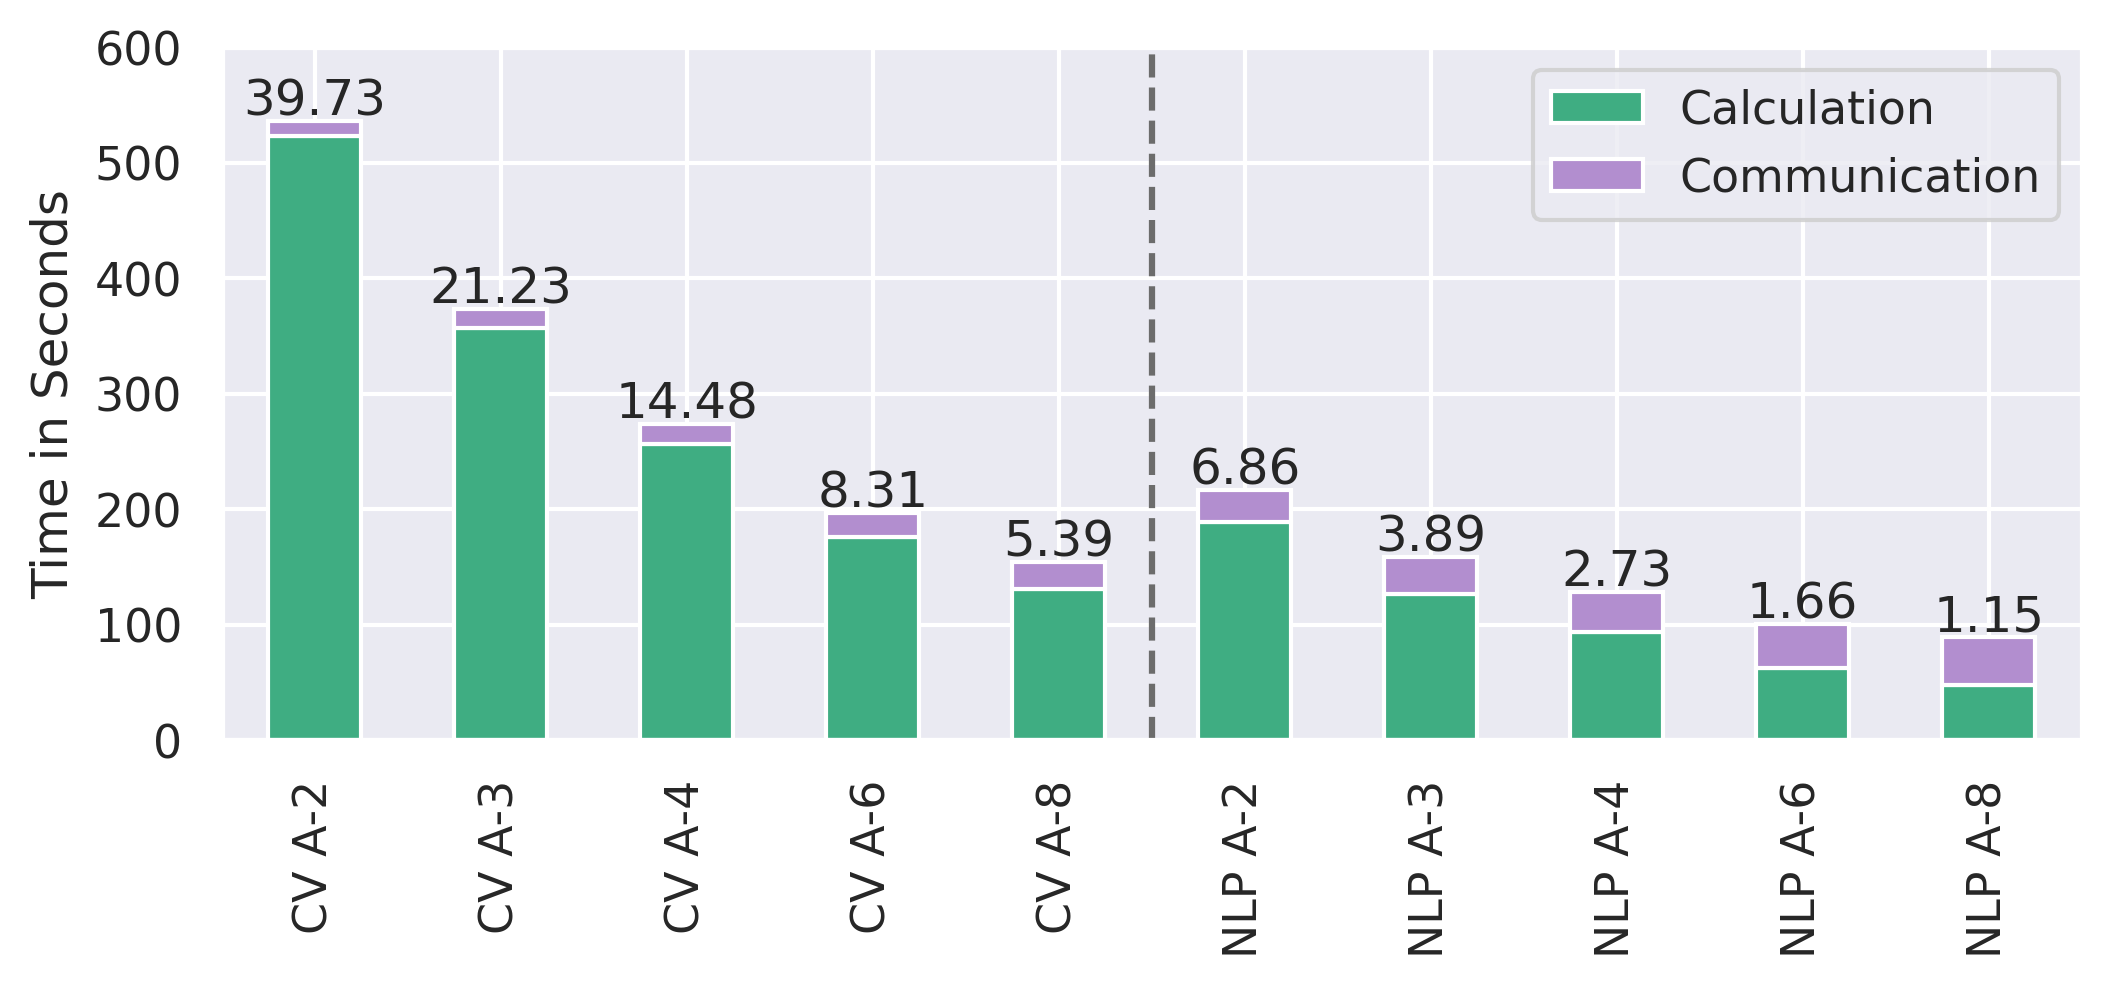

In [45]:
us_t4_granulartiy_df = pd.concat(objs=[
    cv_2xUS_T4_gran_df,
    cv_3xUS_T4_gran_df,
    cv_4xUS_T4_gran_df,
    cv_6xUS_T4_gran_df,
    cv_8xUS_T4_gran_df,
    nlp_2xUS_T4_gran_df,
    nlp_3xUS_T4_gran_df,
    nlp_4xUS_T4_gran_df,
    nlp_6xUS_T4_gran_df,
    nlp_8xUS_T4_gran_df,
])

sns.set(palette=granularity_palette)
plt.figure(figsize=(8,8))
ax = us_t4_granulartiy_df[["calc_time_s","comm_time_s","name"]].set_index('name').plot(kind='bar', stacked=True, figsize=(8,3))
plt.ylabel("Time in Seconds")
plt.xlabel("")
plt.legend(labels=["Calculation", "Communication"])
plt.ylim(0,600)
ax.axvline(4.5, color="#6c6c6c", linestyle="--")
#ax.axvline(8.5, color="#6c6c6c", linestyle="--")

show_granulartiy_values(ax=ax, df=us_t4_granulartiy_df)
save_fig("geo-distributed-performance-US-granularity")

In [46]:
conv_8xA10_32768_df

dataload_s  cuda_move_s  forward_s  loss_calc_s  backward_s  \
0    1.135059     1.179374   6.886531      0.16416   55.963124   

   opt_step_local_s  opt_step_sync_s  dl_calc_time_s  calc_time_s  \
0         16.147582        25.211193       81.475829     80.34077   

   comm_time_s  granularity              name  
0    25.211193       3.1875  CONV 8xA10 32768

In [47]:
us_t4_granulartiy_df

dataload_s  cuda_move_s  forward_s  loss_calc_s  backward_s  \
0    5.724594     7.006776  26.688511     0.735565  374.997837   
0    3.360009     4.693182  18.892188     0.528796  256.271714   
0    2.385624     3.501116  13.504036     0.366090  182.434139   
0    1.581279     2.343712   9.008485     0.250412  125.664263   
0    1.238487     1.769828   7.143815     0.200796   92.439894   
0    1.269769     8.080166  33.157340     1.080918  127.095728   
0    0.917856     5.394549  23.621175     0.769122   83.035960   
0    0.628935     4.012492  16.960070     0.538383   62.122349   
0    0.867141     2.646392  11.626665     0.369956   40.974072   
0    1.491142     1.966115   9.166523     0.296818   30.656770   

   opt_step_local_s  opt_step_sync_s  dl_calc_time_s  calc_time_s  \
0        113.679493        13.175110      528.832776   523.108182   
0         76.187515        16.793375      359.933403   356.573394   
0         56.370245        17.691064      258.561249   256.175625   
0         38.524024        21.149015      177.372175   175.790896   
0         28.803228        24.183686      131.596048   130.357560   
0         19.393772        27.533270      190.077693   188.807924   
0         13.258647        32.407456      126.997310   126.079453   
0         10.095839        34.274443       94.358068    93.729133   
0          7.108191        37.710692       63.592416    62.725275   
0          5.596274        41.669066       49.173642    47.682500   

   comm_time_s  granularity     name  gpu_count          model  
0    13.175110    39.725000   CV A-2          2  ConvNextLarge  
0    16.793375    21.233333   CV A-3          3  ConvNextLarge  
0    17.691064    14.482500   CV A-4          4  ConvNextLarge  
0    21.149015     8.315000   CV A-6          6  ConvNextLarge  
0    24.183686     5.392500   CV A-8          8  ConvNextLarge  
0    27.533270     6.860000  NLP A-2          2     RobertaXLM  
0    32.407456     3.890000  NLP A-3          3     RobertaXLM  
0    34.274443     2.735000  NLP A-4          4     RobertaXLM  
0    37.710692     1.663333  NLP A-6          6     RobertaXLM  
0    41.669066     1.145000  NLP A-8          8     RobertaXLM

<Figure size 2400x2400 with 0 Axes>

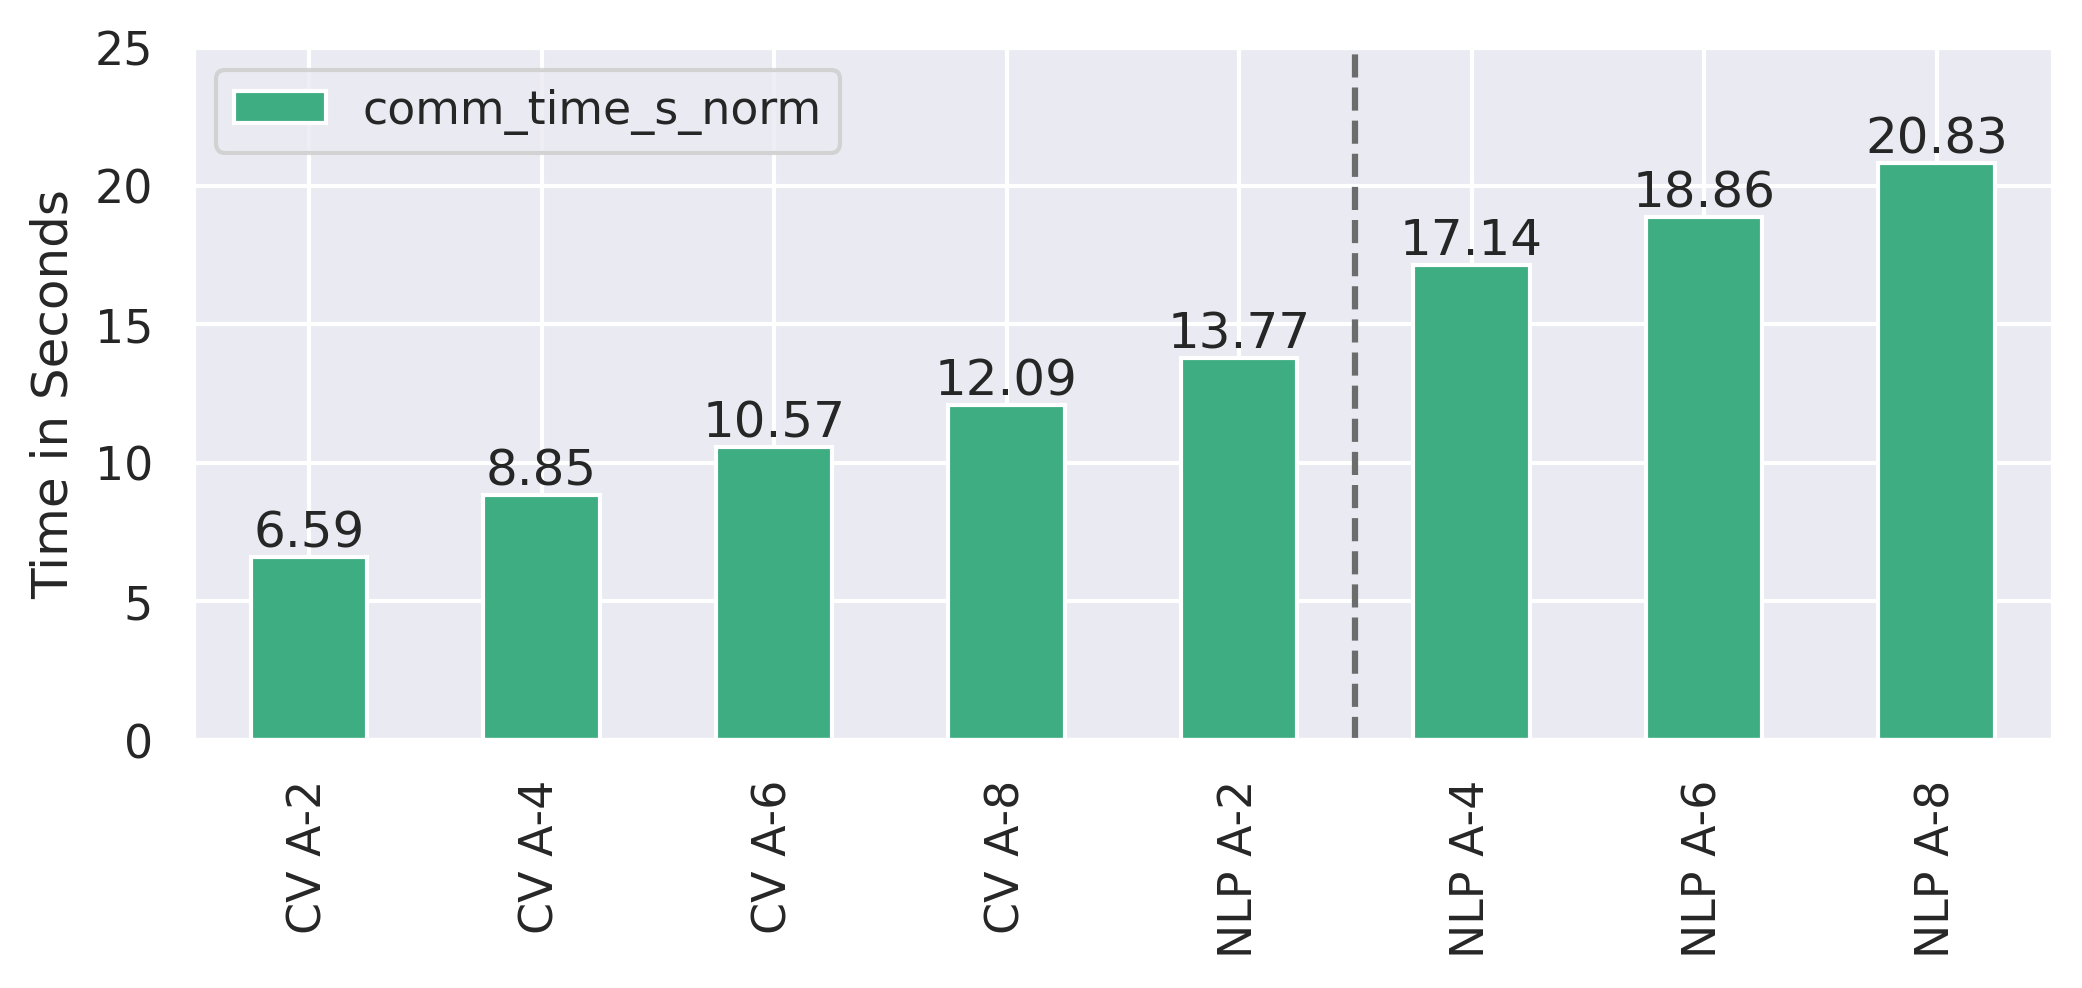

In [48]:
us_t4_granulartiy_df = pd.concat(objs=[
    cv_2xUS_T4_gran_df,
    cv_4xUS_T4_gran_df,
    cv_6xUS_T4_gran_df,
    cv_8xUS_T4_gran_df,
    nlp_2xUS_T4_gran_df,
    nlp_4xUS_T4_gran_df,
    nlp_6xUS_T4_gran_df,
    nlp_8xUS_T4_gran_df,
])
us_t4_granulartiy_df["comm_time_s_norm"] = us_t4_granulartiy_df["comm_time_s"] / 2

temp_df = pd.concat(objs=[cv_2xUS_T4_gran_df, conv_2xA10_32768_df])

sns.set(palette=granularity_palette)
plt.figure(figsize=(8,8))
ax = us_t4_granulartiy_df[["comm_time_s_norm","name"]].set_index('name').plot(kind='bar', figsize=(8,3))
plt.ylabel("Time in Seconds")
plt.xlabel("")
#plt.legend(labels=["Calculation", "Communication"])
plt.ylim(0,25)
ax.axvline(4.5, color="#6c6c6c", linestyle="--")
#ax.axvline(8.5, color="#6c6c6c", linestyle="--")
sns.move_legend(ax, "upper left")#, bbox_to_anchor=(0, -0.15))
round_bar_value_multi(ax, decimals=2)
#show_granulartiy_values(ax=ax, df=us_t4_granulartiy_df)
#save_fig("geo-distributed-performance-US-granularity")

In [49]:
def get_mean_comm_time(model, gpu_count):
    temp_df = us_t4_granulartiy_df.query(f"model=='{model}' and gpu_count=={gpu_count}")
    return temp_df["comm_time_s"].mean()

for model in us_t4_granulartiy_df["model"].unique():
    print(f"Model {model}:")
    baseline_comm_time_s = get_mean_comm_time(model=model, gpu_count=2)
    prev_comm_time_s = baseline_comm_time_s
    for gpu_count in [2,4,6,8]:
        hivemind_comm_time_s = get_mean_comm_time(model=model, gpu_count=gpu_count)
        print(f" - Communication time on {gpu_count} GPUS: {round(hivemind_comm_time_s,1)}s, Delta: {round(hivemind_comm_time_s - prev_comm_time_s,2)}s")
        prev_comm_time_s = hivemind_comm_time_s

Model ConvNextLarge:
 - Communication time on 2 GPUS: 13.2s, Delta: 0.0s
 - Communication time on 4 GPUS: 17.7s, Delta: 4.52s
 - Communication time on 6 GPUS: 21.1s, Delta: 3.46s
 - Communication time on 8 GPUS: 24.2s, Delta: 3.03s
Model RobertaXLM:
 - Communication time on 2 GPUS: 27.5s, Delta: 0.0s
 - Communication time on 4 GPUS: 34.3s, Delta: 6.74s
 - Communication time on 6 GPUS: 37.7s, Delta: 3.44s
 - Communication time on 8 GPUS: 41.7s, Delta: 3.96s


In [50]:
cv_1xus_1xeu_df = get_hivemind_runs(run_names=["hivemind-348"], drop_first_epoch=True)
cv_1xus_1xeu_df = rename_models(df = cv_1xus_1xeu_df)
cv_1xus_1xeu_df["gpu_count"] = int(2)
cv_1xus_1xeu_df["gpu_type"] = "EU/US T4"

cv_2xus_2xeu_df = get_hivemind_runs(run_names=["hivemind-83"], drop_first_epoch=True)
cv_2xus_2xeu_df = rename_models(df = cv_2xus_2xeu_df)
cv_2xus_2xeu_df["gpu_count"] = int(4)
cv_2xus_2xeu_df["gpu_type"] = "EU/US T4"

cv_4xus_2xeu_df = get_hivemind_runs(run_names=["hivemind-85"], drop_first_epoch=True)
cv_4xus_2xeu_df = rename_models(df = cv_4xus_2xeu_df)
cv_4xus_2xeu_df["gpu_count"] = int(6)
cv_4xus_2xeu_df["gpu_type"] = "EU/US T4"

cv_4xus_4xeu_df = get_hivemind_runs(run_names=["hivemind-87"], drop_first_epoch=True)
cv_4xus_4xeu_df = rename_models(df = cv_4xus_4xeu_df)
cv_4xus_4xeu_df["gpu_count"] = int(8)
cv_4xus_4xeu_df["gpu_type"] = "EU/US T4"

nlp_1xus_1xeu_df = get_hivemind_runs(run_names=["hivemind-349"], drop_first_epoch=True)
nlp_1xus_1xeu_df = rename_models(df = nlp_1xus_1xeu_df)
nlp_1xus_1xeu_df["gpu_count"] = int(2)
nlp_1xus_1xeu_df["gpu_type"] = "EU/US T4"

nlp_2xus_2xeu_df = get_hivemind_runs(run_names=["hivemind-84"], drop_first_epoch=True)
nlp_2xus_2xeu_df = rename_models(df = nlp_2xus_2xeu_df)
nlp_2xus_2xeu_df["gpu_count"] = int(4)
nlp_2xus_2xeu_df["gpu_type"] = "EU/US T4"

nlp_4xus_2xeu_df = get_hivemind_runs(run_names=["hivemind-86"], drop_first_epoch=True)
nlp_4xus_2xeu_df = rename_models(df = nlp_4xus_2xeu_df)
nlp_4xus_2xeu_df["gpu_count"] = int(6)
nlp_4xus_2xeu_df["gpu_type"] = "EU/US T4"

nlp_4xus_4xeu_df = get_hivemind_runs(run_names=["hivemind-88"], drop_first_epoch=True)
nlp_4xus_4xeu_df = rename_models(df = nlp_4xus_4xeu_df)
nlp_4xus_4xeu_df["gpu_count"] = int(8)
nlp_4xus_4xeu_df["gpu_type"] = "EU/US T4"

> Found 1 runs with the prefix 'trainmonitor'.
> Found 1 runs with the prefix 'trainmonitor'.
> Found 1 runs with the prefix 'trainmonitor'.
> Found 1 runs with the prefix 'trainmonitor'.
> Found 1 runs with the prefix 'trainmonitor'.
> Found 1 runs with the prefix 'trainmonitor'.
> Found 1 runs with the prefix 'trainmonitor'.
> Found 1 runs with the prefix 'trainmonitor'.


In [51]:
full_us_eu_t4_runs_df = pd.concat(objs=[
    cv_us_1xt4_df,
    cv_1xus_1xeu_df,
    cv_2xus_2xeu_df,
    cv_4xus_2xeu_df,
    cv_4xus_4xeu_df,
    nlp_us_1xt4_df,
    nlp_1xus_1xeu_df,
    nlp_2xus_2xeu_df,
    nlp_4xus_2xeu_df,
    nlp_4xus_4xeu_df
])

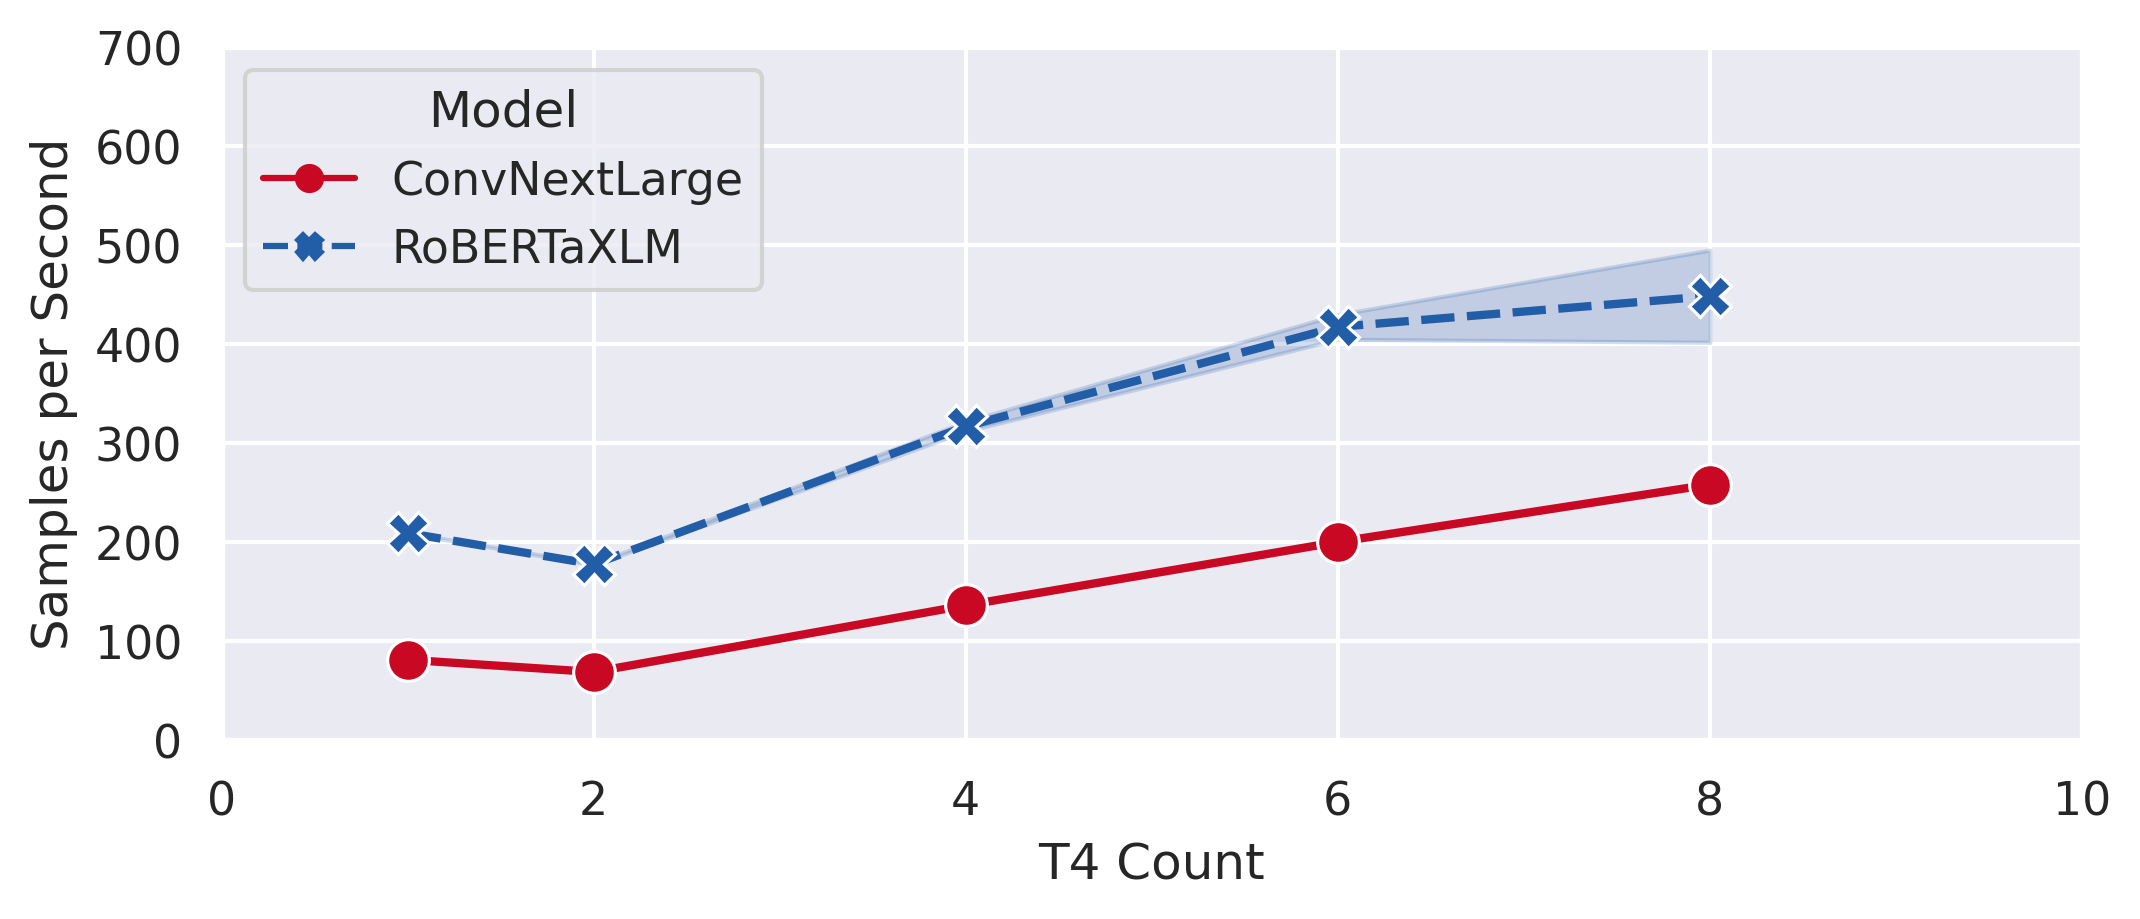

In [52]:
# filter local sps out
temp_df = full_us_eu_t4_runs_df.query("samples_per_sec.notna()")

sns.set(palette=cv_nlp_palette)
plt.figure(figsize=(8,3))
ax = sns.lineplot(
    data=temp_df,
    x="gpu_count", y="samples_per_sec", hue="model", style="model",
    errorbar=('se', 1), dashes=True,
    markers=True,
    linewidth=2.0,
    markersize=10.0
)
#plt.title("Geo-distributed Performance EU-US")
plt.xlabel("T4 Count")
plt.legend(title="Model")
plt.ylabel("Samples per Second")
plt.ylim(0,700)
plt.xlim(0,10)
sns.move_legend(ax, "upper left")#, bbox_to_anchor=(0, -0.15))
save_fig("geo-distributed-performance-US-EU")

## US (B) Speedup

In [53]:
def get_mean_throughput(model, gpu_count, df):
    TBS = 32768
    temp_df = df.query(f"samples_per_sec.notna() and TBS=={TBS} and model=='{model}' and gpu_count=={gpu_count}")
    return temp_df["samples_per_sec"].mean()

print("> US-EU Experiments\n")

for model in full_us_eu_t4_runs_df["model"].unique():
    print(f"Model {model}:")
    baseline_sps = get_mean_throughput(model=model, gpu_count=1, df=full_us_eu_t4_runs_df)
    
    last_us_norm = 0
    last_us_eu_norm = 0
    
    for gpu_count in [2,4,6,8]:
        hivemind_sps = get_mean_throughput(model=model, gpu_count=gpu_count, df=full_us_eu_t4_runs_df)
        hivemind_local_sps = get_mean_throughput(model=model, gpu_count=gpu_count, df=full_us_t4_runs_df)
        
        us_baseline_speedup    = hivemind_local_sps / baseline_sps
        us_norm_baseline_speedup = us_baseline_speedup / gpu_count
        
        us_eu_baseline_speedup = hivemind_sps / baseline_sps
        us_eu_norm_baseline_speedup = us_eu_baseline_speedup / gpu_count
        
        us_vs_us_eu_speedup    = hivemind_sps / hivemind_local_sps
        
        print(f" - US    Speedup vs baseline on {gpu_count} GPUS: {round(us_baseline_speedup,2)}x, Norm: {round(us_norm_baseline_speedup,2)}, Norm delta: {round(last_us_norm - us_norm_baseline_speedup,4)}, ({round(hivemind_local_sps,1)}, {round(baseline_sps,1)})")
        print(f" - US-EU Speedup vs baseline on {gpu_count} GPUS: {round(us_eu_baseline_speedup,2)}x, Norm: {round(us_eu_norm_baseline_speedup,2)}, Norm delta: {round(last_us_eu_norm - us_eu_norm_baseline_speedup,4)}, ({round(hivemind_sps,1)}, {round(baseline_sps,1)})")
        print(f" - Speedup vs US-run         on {gpu_count} GPUS: {round(us_vs_us_eu_speedup,2)}x,            ({round(hivemind_sps,1)}, {round(hivemind_local_sps,1)})")
        print("")
        
        last_us_norm = us_norm_baseline_speedup
        last_us_eu_norm = us_eu_norm_baseline_speedup

> US-EU Experiments

Model ConvNextLarge:
 - US    Speedup vs baseline on 2 GPUS: 0.87x, Norm: 0.43, Norm delta: -0.4342, (70.1, 80.8)
 - US-EU Speedup vs baseline on 2 GPUS: 0.85x, Norm: 0.42, Norm delta: -0.4236, (68.4, 80.8)
 - Speedup vs US-run         on 2 GPUS: 0.98x,            (68.4, 70.1)

 - US    Speedup vs baseline on 4 GPUS: 1.74x, Norm: 0.43, Norm delta: -0.0003, (140.4, 80.8)
 - US-EU Speedup vs baseline on 4 GPUS: 1.68x, Norm: 0.42, Norm delta: 0.0034, (135.8, 80.8)
 - Speedup vs US-run         on 4 GPUS: 0.97x,            (135.8, 140.4)

 - US    Speedup vs baseline on 6 GPUS: 2.48x, Norm: 0.41, Norm delta: 0.0217, (200.1, 80.8)
 - US-EU Speedup vs baseline on 6 GPUS: 2.47x, Norm: 0.41, Norm delta: 0.008, (199.8, 80.8)
 - Speedup vs US-run         on 6 GPUS: 1.0x,            (199.8, 200.1)

 - US    Speedup vs baseline on 8 GPUS: 3.24x, Norm: 0.41, Norm delta: 0.0076, (261.9, 80.8)
 - US-EU Speedup vs baseline on 8 GPUS: 3.19x, Norm: 0.4, Norm delta: 0.0133, (257.8, 80

In [54]:
debug = False
cv_1xUS_1xEU_T4_gran_df = get_granularity_cumulated(run_name="hivemind-348", name="CV B-2", debug=debug)
cv_2xUS_2xEU_T4_gran_df = get_granularity_cumulated(run_name="hivemind-83", name="CV B-4", debug=debug)
cv_4xUS_2xEU_T4_gran_df = get_granularity_cumulated(run_name="hivemind-85", name="CV B-6", debug=debug)
cv_4xUS_4xEU_T4_gran_df = get_granularity_cumulated(run_name="hivemind-87", name="CV B-8", debug=debug)

nlp_1xUS_1xEU_T4_gran_df = get_granularity_cumulated(run_name="hivemind-349", name="NLP B-2", debug=debug)
nlp_2xUS_2xEU_T4_gran_df = get_granularity_cumulated(run_name="hivemind-84", name="NLP B-4", debug=debug)
nlp_4xUS_2xEU_T4_gran_df = get_granularity_cumulated(run_name="hivemind-86", name="NLP B-6", debug=debug)
nlp_4xUS_4xEU_T4_gran_df = get_granularity_cumulated(run_name="hivemind-88", name="NLP B-8", debug=debug)

> Found 2 runs with the infix 'bee'.
> Found 4 runs with the infix 'bee'.
> Found 6 runs with the infix 'bee'.
> Found 8 runs with the infix 'bee'.
> Found 2 runs with the infix 'bee'.
> Found 4 runs with the infix 'bee'.
> Found 6 runs with the infix 'bee'.
> Found 8 runs with the infix 'bee'.


<Figure size 2400x900 with 0 Axes>

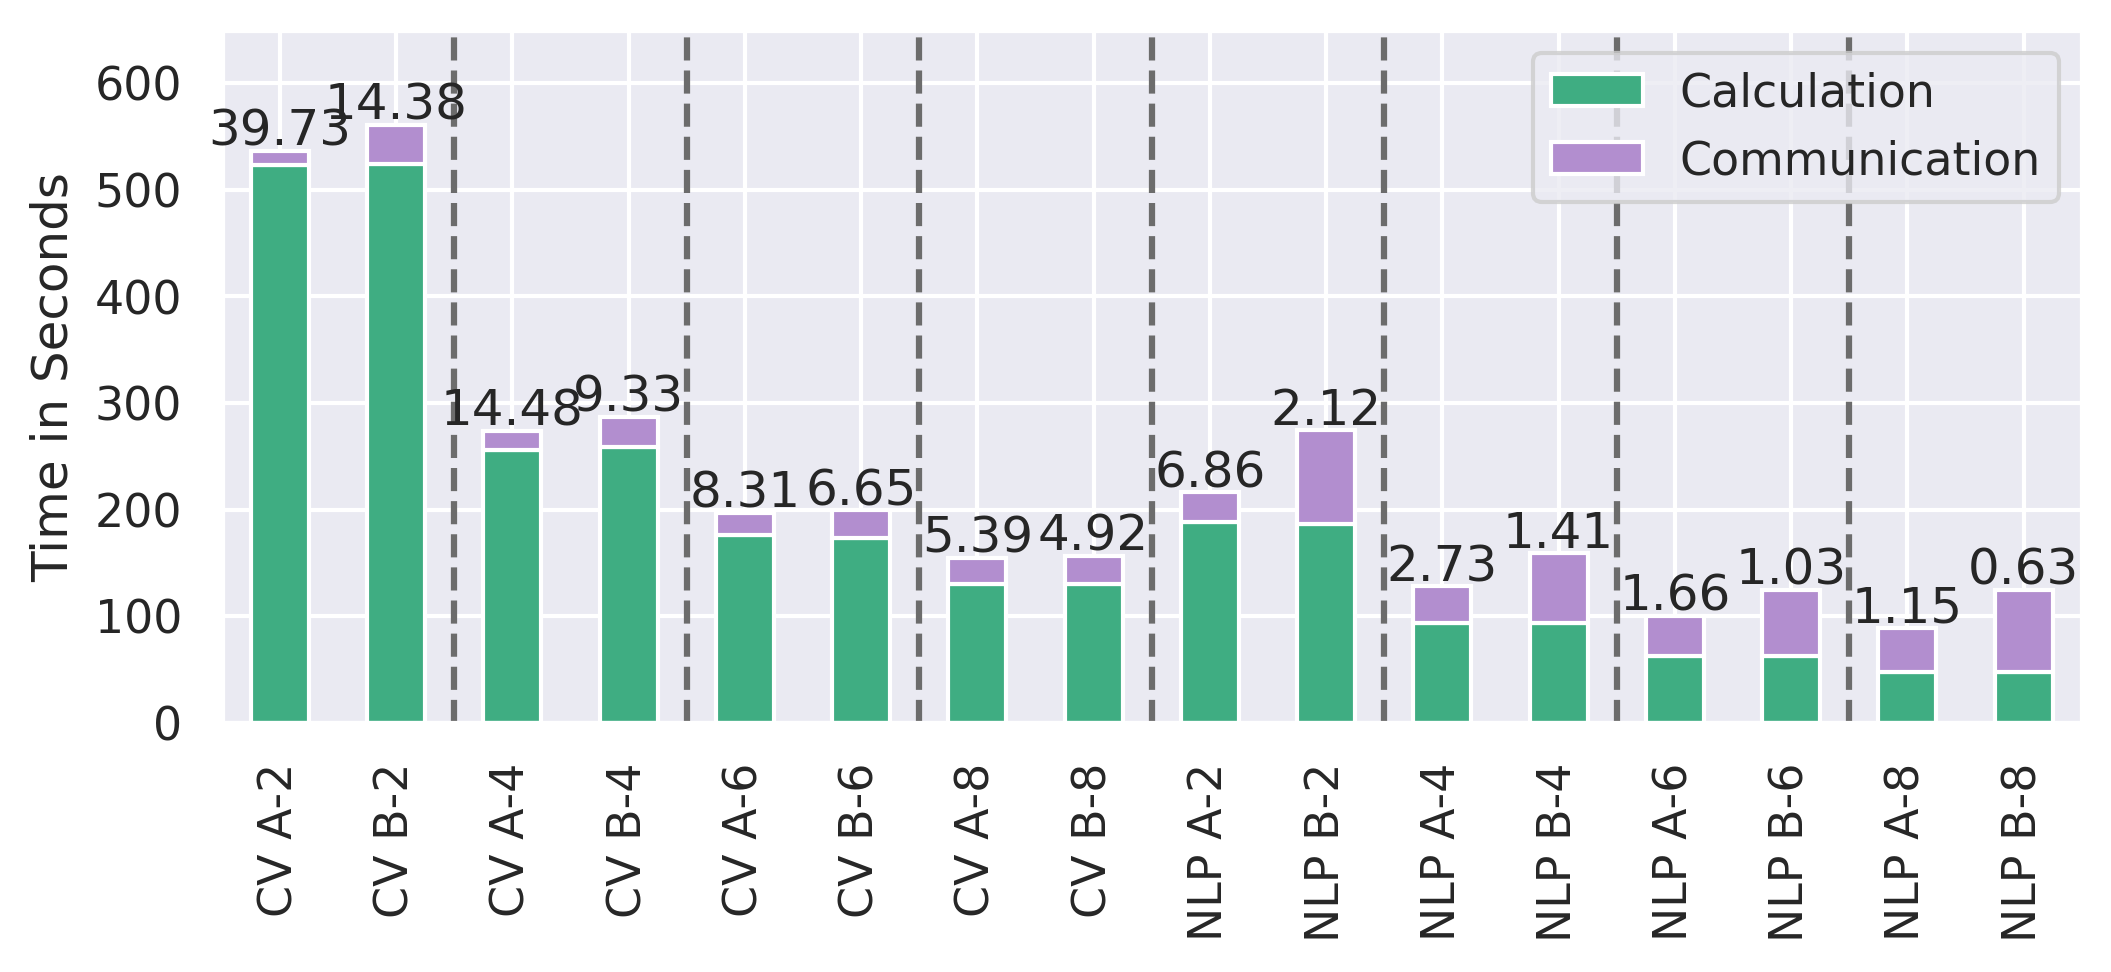

In [55]:
us_eu_t4_granulartiy_df = pd.concat(objs=[
    cv_2xUS_T4_gran_df,
    cv_1xUS_1xEU_T4_gran_df,
    cv_4xUS_T4_gran_df,
    cv_2xUS_2xEU_T4_gran_df,
    cv_6xUS_T4_gran_df,
    cv_4xUS_2xEU_T4_gran_df,
    cv_8xUS_T4_gran_df,
    cv_4xUS_4xEU_T4_gran_df,
    nlp_2xUS_T4_gran_df,
    nlp_1xUS_1xEU_T4_gran_df,
    nlp_4xUS_T4_gran_df,
    nlp_2xUS_2xEU_T4_gran_df,
    nlp_6xUS_T4_gran_df,
    nlp_4xUS_2xEU_T4_gran_df,
    nlp_8xUS_T4_gran_df,
    nlp_4xUS_4xEU_T4_gran_df,
])

sns.set(palette=granularity_palette)
plt.figure(figsize=(8,3))
ax = us_eu_t4_granulartiy_df[["calc_time_s","comm_time_s","name"]].set_index('name').plot(kind='bar', stacked=True, figsize=(8,3))
plt.ylabel("Time in Seconds")
plt.xlabel("")
plt.legend(labels=["Calculation", "Communication"])
plt.ylim(0,650)
ax.axvline(1.5, color="#6c6c6c", linestyle="--")
ax.axvline(3.5, color="#6c6c6c", linestyle="--")
ax.axvline(5.5, color="#6c6c6c", linestyle="--")
ax.axvline(7.5, color="#6c6c6c", linestyle="--")
ax.axvline(9.5, color="#6c6c6c", linestyle="--")
ax.axvline(11.5, color="#6c6c6c", linestyle="--")
ax.axvline(13.5, color="#6c6c6c", linestyle="--")

show_granulartiy_values(ax=ax, df=us_eu_t4_granulartiy_df)
save_fig("geo-distributed-performance-US-EU-granularity")

In [56]:
cv_1xus_1xeu_1xasia_df = get_hivemind_runs(run_names=["hivemind-350"], drop_first_epoch=True)
cv_1xus_1xeu_1xasia_df = rename_models(df = cv_1xus_1xeu_1xasia_df)
cv_1xus_1xeu_1xasia_df["gpu_count"] = int(3)
cv_1xus_1xeu_1xasia_df["gpu_type"] = "EU/US/ASIA T4"

cv_1xus_1xeu_1xasia_1xaus_df = get_hivemind_runs(run_names=["hivemind-352"], drop_first_epoch=True)
cv_1xus_1xeu_1xasia_1xaus_df = rename_models(df = cv_1xus_1xeu_1xasia_1xaus_df)
cv_1xus_1xeu_1xasia_1xaus_df["gpu_count"] = int(4)
cv_1xus_1xeu_1xasia_1xaus_df["gpu_type"] = "EU/US/ASIA/AUS T4"

cv_2xus_2xeu_2xasia_df = get_hivemind_runs(run_names=["hivemind-89"], drop_first_epoch=True)
cv_2xus_2xeu_2xasia_df = rename_models(df = cv_2xus_2xeu_2xasia_df)
cv_2xus_2xeu_2xasia_df["gpu_count"] = int(6)
cv_2xus_2xeu_2xasia_df["gpu_type"] = "EU/US/ASIA T4"

cv_2xus_2xeu_2xasia_2xaus_df = get_hivemind_runs(run_names=["hivemind-92"], drop_first_epoch=True)
cv_2xus_2xeu_2xasia_2xaus_df = rename_models(df = cv_2xus_2xeu_2xasia_2xaus_df)
cv_2xus_2xeu_2xasia_2xaus_df["gpu_count"] = int(8)
cv_2xus_2xeu_2xasia_2xaus_df["gpu_type"] = "EU/US/ASIA/AUS T4"

nlp_1xus_1xeu_1xasia_df = get_hivemind_runs(run_names=["hivemind-351"], drop_first_epoch=True)
nlp_1xus_1xeu_1xasia_df = rename_models(df = nlp_1xus_1xeu_1xasia_df)
nlp_1xus_1xeu_1xasia_df["gpu_count"] = int(3)
nlp_1xus_1xeu_1xasia_df["gpu_type"] = "EU/US/ASIA T4"

nlp_1xus_1xeu_1xasia_1xaus_df = get_hivemind_runs(run_names=["hivemind-353"], drop_first_epoch=True)
nlp_1xus_1xeu_1xasia_1xaus_df = rename_models(df = nlp_1xus_1xeu_1xasia_1xaus_df)
nlp_1xus_1xeu_1xasia_1xaus_df["gpu_count"] = int(4)
nlp_1xus_1xeu_1xasia_1xaus_df["gpu_type"] = "EU/US/ASIA/AUS T4"

nlp_2xus_2xeu_2xasia_df = get_hivemind_runs(run_names=["hivemind-90"], drop_first_epoch=True)
nlp_2xus_2xeu_2xasia_df = rename_models(df = nlp_2xus_2xeu_2xasia_df)
nlp_2xus_2xeu_2xasia_df["gpu_count"] = int(6)
nlp_2xus_2xeu_2xasia_df["gpu_type"] = "EU/US/ASIA T4"

nlp_2xus_2xeu_2xasia_2xaus_df = get_hivemind_runs(run_names=["hivemind-93"], drop_first_epoch=True)
nlp_2xus_2xeu_2xasia_2xaus_df = rename_models(df = nlp_2xus_2xeu_2xasia_2xaus_df)
nlp_2xus_2xeu_2xasia_2xaus_df["gpu_count"] = int(8)
nlp_2xus_2xeu_2xasia_2xaus_df["gpu_type"] = "EU/US/ASIA/AUS T4"

> Found 1 runs with the prefix 'trainmonitor'.
> Found 1 runs with the prefix 'trainmonitor'.
> Found 1 runs with the prefix 'trainmonitor'.
> Found 1 runs with the prefix 'trainmonitor'.
> Found 1 runs with the prefix 'trainmonitor'.
> Found 1 runs with the prefix 'trainmonitor'.
> Found 1 runs with the prefix 'trainmonitor'.
> Found 1 runs with the prefix 'trainmonitor'.


In [57]:
full_us_eu_asia_aus_t4_runs_df = pd.concat(objs=[
    cv_us_1xt4_df,
    cv_1xus_1xeu_1xasia_df,
    cv_2xus_2xeu_2xasia_df,
    cv_1xus_1xeu_1xasia_1xaus_df,
    cv_2xus_2xeu_2xasia_2xaus_df,
    nlp_us_1xt4_df,
    nlp_1xus_1xeu_1xasia_df,
    nlp_2xus_2xeu_2xasia_df,
    nlp_1xus_1xeu_1xasia_1xaus_df,
    nlp_2xus_2xeu_2xasia_2xaus_df,
])

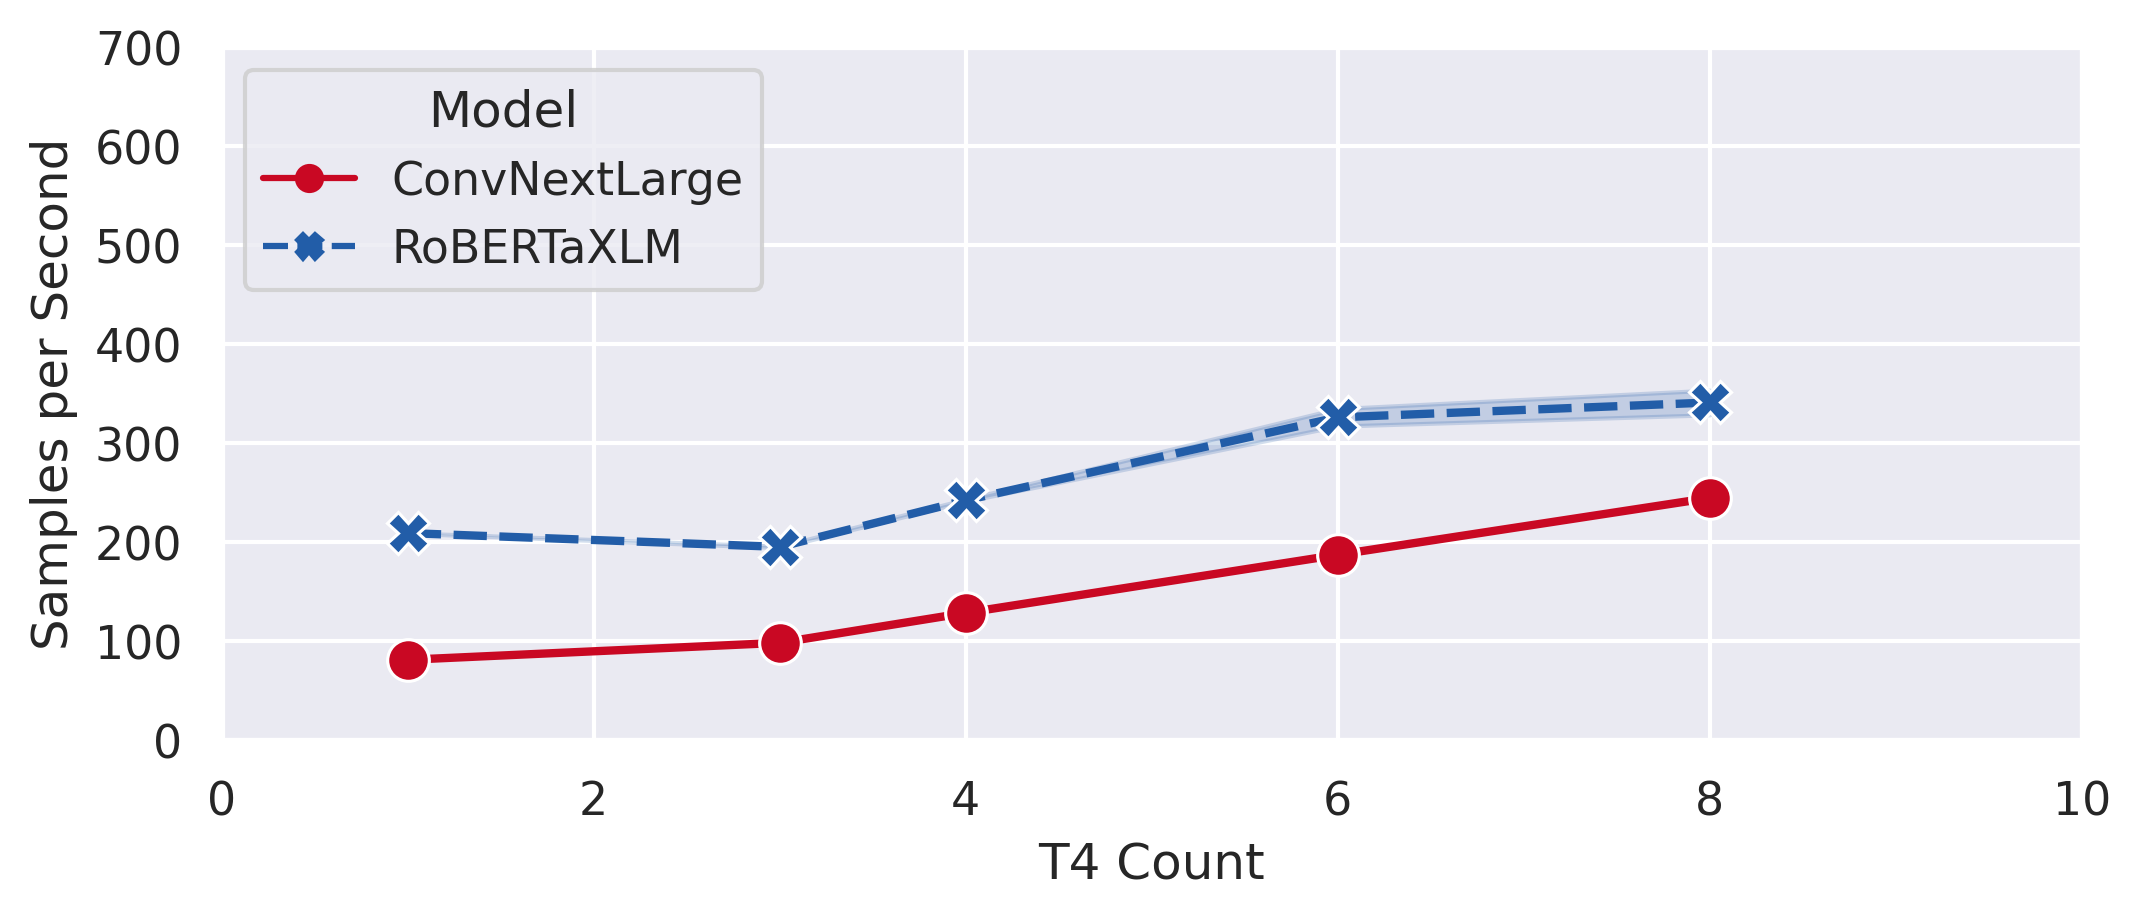

In [58]:
# filter local sps out
temp_df = full_us_eu_asia_aus_t4_runs_df.query("samples_per_sec.notna()")

sns.set(palette=cv_nlp_palette)
plt.figure(figsize=(8,3))
ax = sns.lineplot(
    data=temp_df,
    x="gpu_count", y="samples_per_sec", hue="model", style="model",
    errorbar=('se', 1), dashes=True,
    markers=True,
    linewidth=2.0,
    markersize=10.0
)
#plt.title("Geo-distributed Performance EU-US-ASIA-AUS")
plt.xlabel("T4 Count")
plt.legend(title="Model")
plt.ylabel("Samples per Second")
plt.ylim(0,700)
plt.xlim(0,10)
sns.move_legend(ax, "upper left")#, bbox_to_anchor=(0, -0.15))
save_fig("geo-distributed-performance-US-EU-ASIA-AUS")

In [59]:
def get_mean_throughput(model, gpu_count, df):
    TBS = 32768
    temp_df = df.query(f"samples_per_sec.notna() and TBS=={TBS} and model=='{model}' and gpu_count=={gpu_count}")
    return temp_df["samples_per_sec"].mean()

print("> US-EU-ASIA-AUS Experiments\n")

for model in full_us_eu_asia_aus_t4_runs_df["model"].unique():
    print(f"Model {model}:")
    # baseline from the A-experiments
    baseline_sps = get_mean_throughput(model=model, gpu_count=1, df=full_us_eu_t4_runs_df)
    
    last_a_norm = 0
    last_b_norm = 0
    last_c_norm = 0
    
    for gpu_count in [3,4,6,8]:
        c_hivemind_sps = get_mean_throughput(model=model, gpu_count=gpu_count, df=full_us_eu_asia_aus_t4_runs_df)
        b_hivemind_sps = get_mean_throughput(model=model, gpu_count=gpu_count, df=full_us_eu_t4_runs_df)
        a_hivemind_sps = get_mean_throughput(model=model, gpu_count=gpu_count, df=full_us_t4_runs_df)
        
        a_baseline_speedup    = a_hivemind_sps / baseline_sps
        a_norm_baseline_speedup = a_baseline_speedup / gpu_count
        
        b_baseline_speedup = b_hivemind_sps / baseline_sps
        b_norm_baseline_speedup = b_baseline_speedup / gpu_count
        
        c_baseline_speedup = c_hivemind_sps / baseline_sps
        c_norm_baseline_speedup = c_baseline_speedup / gpu_count
        
        #us_vs_us_eu_speedup    = hivemind_sps / hivemind_local_sps
        
        print(f" - US             Speedup vs baseline on {gpu_count} GPUS: {round(a_baseline_speedup,2)}x, Norm: {round(a_norm_baseline_speedup,2)}, Norm delta: {round(last_a_norm - a_norm_baseline_speedup,4)}, ({round(a_hivemind_sps,1)}, {round(baseline_sps,1)})")
        print(f" - US-EU          Speedup vs baseline on {gpu_count} GPUS: {round(b_baseline_speedup,2)}x, Norm: {round(b_norm_baseline_speedup,2)}, Norm delta: {round(last_b_norm - b_norm_baseline_speedup,4)}, ({round(b_hivemind_sps,1)}, {round(baseline_sps,1)})")
        print(f" - US-EU-ASIA-AUS Speedup vs baseline on {gpu_count} GPUS: {round(c_baseline_speedup,2)}x, Norm: {round(c_norm_baseline_speedup,2)}, Norm delta: {round(last_c_norm - c_norm_baseline_speedup,4)}, ({round(c_hivemind_sps,1)}, {round(baseline_sps,1)})")
        print(f" - US-EU-ASIA-AUS is slower than US-EU by: {round(c_hivemind_sps / b_hivemind_sps,2)}x")
        print(f" - US-EU-ASIA-AUS is slower than US by: {round(c_hivemind_sps / a_hivemind_sps,2)}x")

        
        print("")
        
        last_a_norm = a_norm_baseline_speedup
        last_b_norm = b_norm_baseline_speedup
        last_c_norm = c_norm_baseline_speedup

> US-EU-ASIA-AUS Experiments

Model ConvNextLarge:
 - US             Speedup vs baseline on 3 GPUS: 1.27x, Norm: 0.42, Norm delta: -0.4233, (102.6, 80.8)
 - US-EU          Speedup vs baseline on 3 GPUS: nanx, Norm: nan, Norm delta: nan, (nan, 80.8)
 - US-EU-ASIA-AUS Speedup vs baseline on 3 GPUS: 1.21x, Norm: 0.4, Norm delta: -0.404, (97.9, 80.8)
 - US-EU-ASIA-AUS is slower than US-EU by: nanx
 - US-EU-ASIA-AUS is slower than US by: 0.95x

 - US             Speedup vs baseline on 4 GPUS: 1.74x, Norm: 0.43, Norm delta: -0.0112, (140.4, 80.8)
 - US-EU          Speedup vs baseline on 4 GPUS: 1.68x, Norm: 0.42, Norm delta: nan, (135.8, 80.8)
 - US-EU-ASIA-AUS Speedup vs baseline on 4 GPUS: 1.59x, Norm: 0.4, Norm delta: 0.0074, (128.2, 80.8)
 - US-EU-ASIA-AUS is slower than US-EU by: 0.94x
 - US-EU-ASIA-AUS is slower than US by: 0.91x

 - US             Speedup vs baseline on 6 GPUS: 2.48x, Norm: 0.41, Norm delta: 0.0217, (200.1, 80.8)
 - US-EU          Speedup vs baseline on 6 GPUS: 2.47x,

### Full Intercontinental Comparison

**Story**

**1. Adding more regions with 1 GPUs**
- A-3 (single region) vs. C-3 (three regions)
- A-4 (single region) vs. C-4 (four regions)
- A-4 (single region) vs. B-4 (two regions) vs. C-4 (four regions)

**2. Adding more regions with 2 GPUs**
- A-6 (single region) vs. B-6 (two regions, unbalanced) vs. C-6 (three regions)
- A-8 (single region) vs. B-8 (two regions, balanced) vs. C-8 (four regions)

**3. Comparing scalability when adding regions**
- C-3 (three regions) vs. C-4 (four regions) + 1xT4 (compare to A-3 and A-4)

**4. Comparing scalability when adding more compute**
- C-3 (three regions) vs. C-6 (three regions) + 3xT4 (compare to A-3 and A-6)
- C-4 (four regions)  vs. C-8 (four regions)  + 4xT4 (doubling local compute, comparing to A-4 and A-8)

**5. Comparing scalability when adding regions and more compute**
- C-6 (three regions) vs. C-8 (four regions) + 2xT4 (compare to A-6 and A-8)
    - Also compare to C-3 -> C-4 per-GPU contribution



**1. Adding more regions with 1 GPU**

In [60]:
def get_mean_throughput(model, gpu_count, df):
    TBS = 32768
    temp_df = df.query(f"samples_per_sec.notna() and TBS=={TBS} and model=='{model}' and gpu_count=={gpu_count}")
    return temp_df["samples_per_sec"].mean()

models = full_us_eu_t4_runs_df["model"].unique()

In [61]:
print("A-3 vs C-3 (single region vs three regions):")
print("-----------------------")

for model in models:
    
    gpu_count = 3
    a_1_sps = get_mean_throughput(model=model, gpu_count=1, df=full_us_eu_t4_runs_df)

    a_3_sps = get_mean_throughput(model=model, gpu_count=gpu_count, df=full_us_t4_runs_df)
    a_3_norm_sps = a_3_sps / gpu_count
    a_3_speedup = a_3_sps / a_1_sps
    a_3_norm_speedup = a_3_speedup / gpu_count

    c_3_sps = get_mean_throughput(model=model, gpu_count=gpu_count, df=full_us_eu_asia_aus_t4_runs_df)
    c_3_norm_sps = c_3_sps / gpu_count
    c_3_speedup = c_3_sps / a_1_sps
    c_3_norm_speedup = c_3_speedup / gpu_count

    
    print(f"{model:>15}, A-{gpu_count}. SPS: {round(a_3_sps,2):>6}, Norm SPS: {round(a_3_norm_sps,2):>6}, Speedup: {round(a_3_speedup,2):>6}, Norm Speedup: {round(a_3_norm_speedup,2):>6}")
    print(f"{model:>15}, C-{gpu_count}. SPS: {round(c_3_sps,2):>6}, Norm SPS: {round(c_3_norm_sps,2):>6}, Speedup: {round(c_3_speedup,2):>6}, Norm Speedup: {round(c_3_norm_speedup,2):>6}")
    print(f"   C-3 vs A-3: {round(c_3_sps / a_3_sps,2)}x")
    print("-----------------------")
    
print("A-4 vs C-4 (single region vs four regions):")
print("-----------------------")

for model in models:
    
    gpu_count = 4
    a_1_sps = get_mean_throughput(model=model, gpu_count=1, df=full_us_eu_t4_runs_df)

    a_4_sps = get_mean_throughput(model=model, gpu_count=gpu_count, df=full_us_t4_runs_df)
    a_4_norm_sps = a_4_sps / gpu_count
    a_4_speedup = a_4_sps / a_1_sps
    a_4_norm_speedup = a_4_speedup / gpu_count

    b_4_sps = get_mean_throughput(model=model, gpu_count=gpu_count, df=full_us_eu_t4_runs_df)
    b_4_norm_sps = b_4_sps / gpu_count
    b_4_speedup = b_4_sps / a_1_sps
    b_4_norm_speedup = b_4_speedup / gpu_count
    
    c_4_sps = get_mean_throughput(model=model, gpu_count=gpu_count, df=full_us_eu_asia_aus_t4_runs_df)
    c_4_norm_sps = c_4_sps / gpu_count
    c_4_speedup = c_4_sps / a_1_sps
    c_4_norm_speedup = c_4_speedup / gpu_count

    
    print(f"{model:>15}, A-{gpu_count}. SPS: {round(a_4_sps,2):>6}, Norm SPS: {round(a_4_norm_sps,2):>6}, Speedup: {round(a_4_speedup,2):>6}, Norm Speedup: {round(a_4_norm_speedup,2):>6}")
    print(f"{model:>15}, B-{gpu_count}. SPS: {round(b_4_sps,2):>6}, Norm SPS: {round(b_4_norm_sps,2):>6}, Speedup: {round(b_4_speedup,2):>6}, Norm Speedup: {round(b_4_norm_speedup,2):>6}")
    print(f"{model:>15}, C-{gpu_count}. SPS: {round(c_4_sps,2):>6}, Norm SPS: {round(c_4_norm_sps,2):>6}, Speedup: {round(c_4_speedup,2):>6}, Norm Speedup: {round(c_4_norm_speedup,2):>6}")
    print(f"   B-4 vs A-4: {round(b_4_sps / a_4_sps,2)}x")
    print(f"   C-4 vs A-4: {round(c_4_sps / a_4_sps,2)}x")
    print("-----------------------")


A-3 vs C-3 (single region vs three regions):
-----------------------
  ConvNextLarge, A-3. SPS: 102.58, Norm SPS:  34.19, Speedup:   1.27, Norm Speedup:   0.42
  ConvNextLarge, C-3. SPS:  97.91, Norm SPS:  32.64, Speedup:   1.21, Norm Speedup:    0.4
   C-3 vs A-3: 0.95x
-----------------------
     RoBERTaXLM, A-3. SPS: 296.69, Norm SPS:   98.9, Speedup:   1.42, Norm Speedup:   0.47
     RoBERTaXLM, C-3. SPS:  194.8, Norm SPS:  64.93, Speedup:   0.93, Norm Speedup:   0.31
   C-3 vs A-3: 0.66x
-----------------------
A-4 vs C-4 (single region vs four regions):
-----------------------
  ConvNextLarge, A-4. SPS:  140.4, Norm SPS:   35.1, Speedup:   1.74, Norm Speedup:   0.43
  ConvNextLarge, B-4. SPS: 135.77, Norm SPS:  33.94, Speedup:   1.68, Norm Speedup:   0.42
  ConvNextLarge, C-4. SPS: 128.16, Norm SPS:  32.04, Speedup:   1.59, Norm Speedup:    0.4
   B-4 vs A-4: 0.97x
   C-4 vs A-4: 0.91x
-----------------------
     RoBERTaXLM, A-4. SPS: 378.85, Norm SPS:  94.71, Speedup:   1.81, 

In [62]:
print("A-6 vs B-6 vs C-6 (single region vs three regions):")
print("-----------------------")

for model in models:
    
    gpu_count = 6
    a_1_sps = get_mean_throughput(model=model, gpu_count=1, df=full_us_eu_t4_runs_df)

    a_6_sps = get_mean_throughput(model=model, gpu_count=gpu_count, df=full_us_t4_runs_df)
    a_6_norm_sps = a_6_sps / gpu_count
    a_6_speedup = a_6_sps / a_1_sps
    a_6_norm_speedup = a_6_speedup / gpu_count

    b_6_sps = get_mean_throughput(model=model, gpu_count=gpu_count, df=full_us_eu_t4_runs_df)
    b_6_norm_sps = b_6_sps / gpu_count
    b_6_speedup = b_6_sps / a_1_sps
    b_6_norm_speedup = b_6_speedup / gpu_count
    
    c_6_sps = get_mean_throughput(model=model, gpu_count=gpu_count, df=full_us_eu_asia_aus_t4_runs_df)
    c_6_norm_sps = c_6_sps / gpu_count
    c_6_speedup = c_6_sps / a_1_sps
    c_6_norm_speedup = c_6_speedup / gpu_count

    
    print(f"{model:>15}, A-{gpu_count}. SPS: {round(a_6_sps,2):>6}, Norm SPS: {round(a_6_norm_sps,2):>6}, Speedup: {round(a_4_speedup,2):>6}, Norm Speedup: {round(a_6_norm_speedup,2):>6}")
    print(f"{model:>15}, B-{gpu_count}. SPS: {round(b_6_sps,2):>6}, Norm SPS: {round(b_6_norm_sps,2):>6}, Speedup: {round(b_4_speedup,2):>6}, Norm Speedup: {round(b_6_norm_speedup,2):>6}")
    print(f"{model:>15}, C-{gpu_count}. SPS: {round(c_6_sps,2):>6}, Norm SPS: {round(c_6_norm_sps,2):>6}, Speedup: {round(c_4_speedup,2):>6}, Norm Speedup: {round(c_6_norm_speedup,2):>6}")
    print(f"   B-6 vs A-6: {round(b_6_sps / a_6_sps,2)}x")
    print(f"   C-6 vs A-6: {round(c_6_sps / a_6_sps,2)}x")
    print("-----------------------")

A-6 vs B-6 vs C-6 (single region vs three regions):
-----------------------
  ConvNextLarge, A-6. SPS: 200.08, Norm SPS:  33.35, Speedup:   1.81, Norm Speedup:   0.41
  ConvNextLarge, B-6. SPS: 199.79, Norm SPS:   33.3, Speedup:   1.52, Norm Speedup:   0.41
  ConvNextLarge, C-6. SPS: 186.83, Norm SPS:  31.14, Speedup:   1.16, Norm Speedup:   0.39
   B-6 vs A-6: 1.0x
   C-6 vs A-6: 0.93x
-----------------------
     RoBERTaXLM, A-6. SPS: 500.18, Norm SPS:  83.36, Speedup:   1.81, Norm Speedup:    0.4
     RoBERTaXLM, B-6. SPS: 417.03, Norm SPS:   69.5, Speedup:   1.52, Norm Speedup:   0.33
     RoBERTaXLM, C-6. SPS: 325.65, Norm SPS:  54.28, Speedup:   1.16, Norm Speedup:   0.26
   B-6 vs A-6: 0.83x
   C-6 vs A-6: 0.65x
-----------------------


In [63]:
print("A-8 vs B-8 vs C-8 (single region vs four regions):")
print("-----------------------")

for model in models:
    
    gpu_count = 8
    a_1_sps = get_mean_throughput(model=model, gpu_count=1, df=full_us_eu_t4_runs_df)

    a_8_sps = get_mean_throughput(model=model, gpu_count=gpu_count, df=full_us_t4_runs_df)
    a_8_norm_sps = a_8_sps / gpu_count
    a_8_speedup = a_8_sps / a_1_sps
    a_8_norm_speedup = a_8_speedup / gpu_count

    b_8_sps = get_mean_throughput(model=model, gpu_count=gpu_count, df=full_us_eu_t4_runs_df)
    b_8_norm_sps = b_8_sps / gpu_count
    b_8_speedup = b_8_sps / a_1_sps
    b_8_norm_speedup = b_8_speedup / gpu_count
    
    c_8_sps = get_mean_throughput(model=model, gpu_count=gpu_count, df=full_us_eu_asia_aus_t4_runs_df)
    c_8_norm_sps = c_8_sps / gpu_count
    c_8_speedup = c_8_sps / a_1_sps
    c_8_norm_speedup = c_8_speedup / gpu_count

    
    print(f"{model:>15}, A-{gpu_count}. SPS: {round(a_8_sps,2):>6}, Norm SPS: {round(a_8_norm_sps,2):>6}, Speedup: {round(a_8_speedup,2):>6}, Norm Speedup: {round(a_8_norm_speedup,2):>6}")
    print(f"{model:>15}, B-{gpu_count}. SPS: {round(b_8_sps,2):>6}, Norm SPS: {round(b_8_norm_sps,2):>6}, Speedup: {round(b_8_speedup,2):>6}, Norm Speedup: {round(b_8_norm_speedup,2):>6}")
    print(f"{model:>15}, C-{gpu_count}. SPS: {round(c_8_sps,2):>6}, Norm SPS: {round(c_8_norm_sps,2):>6}, Speedup: {round(c_8_speedup,2):>6}, Norm Speedup: {round(c_8_norm_speedup,2):>6}")
    print(f"   B-8 vs A-8: {round(b_8_sps / a_8_sps,2)}x")
    print(f"   C-8 vs A-8: {round(c_8_sps / a_8_sps,2)}x")
    print("-----------------------")

A-8 vs B-8 vs C-8 (single region vs four regions):
-----------------------
  ConvNextLarge, A-8. SPS: 261.86, Norm SPS:  32.73, Speedup:   3.24, Norm Speedup:   0.41
  ConvNextLarge, B-8. SPS: 257.79, Norm SPS:  32.22, Speedup:   3.19, Norm Speedup:    0.4
  ConvNextLarge, C-8. SPS:  244.3, Norm SPS:  30.54, Speedup:   3.02, Norm Speedup:   0.38
   B-8 vs A-8: 0.98x
   C-8 vs A-8: 0.93x
-----------------------
     RoBERTaXLM, A-8. SPS: 575.09, Norm SPS:  71.89, Speedup:   2.75, Norm Speedup:   0.34
     RoBERTaXLM, B-8. SPS: 448.04, Norm SPS:   56.0, Speedup:   2.15, Norm Speedup:   0.27
     RoBERTaXLM, C-8. SPS: 340.67, Norm SPS:  42.58, Speedup:   1.63, Norm Speedup:    0.2
   B-8 vs A-8: 0.78x
   C-8 vs A-8: 0.59x
-----------------------


In [64]:
debug = False
debug = False
cv_1xUS_1xEU_1xASIA_T4_gran_df = get_granularity_cumulated(run_name="hivemind-350", name="CV C-3", debug=debug)
cv_1xUS_1xEU_1xASIA_1xAUS_T4_gran_df = get_granularity_cumulated(run_name="hivemind-352", name="CV C-4", debug=debug)

nlp_1xUS_1xEU_1xASIA_T4_gran_df = get_granularity_cumulated(run_name="hivemind-351", name="NLP C-3", debug=debug)
nlp_1xUS_1xEU_1xASIA_1xAUS_T4_gran_df = get_granularity_cumulated(run_name="hivemind-353", name="NLP C-4", debug=debug)

cv_2xUS_2xEU_2xASIA_T4_gran_df = get_granularity_cumulated(run_name="hivemind-89", name="CV C-6", debug=debug)
cv_2xUS_2xEU_2xASIA_2xAUS_T4_gran_df = get_granularity_cumulated(run_name="hivemind-92", name="CV C-8", debug=debug)

nlp_2xUS_2xEU_2xASIA_T4_gran_df = get_granularity_cumulated(run_name="hivemind-90", name="NLP C-6", debug=debug)
nlp_2xUS_2xEU_2xASIA_2xAUS_T4_gran_df = get_granularity_cumulated(run_name="hivemind-93", name="NLP C-8", debug=debug)

> Found 3 runs with the infix 'bee'.
> Found 4 runs with the infix 'bee'.
> Found 3 runs with the infix 'bee'.
> Found 4 runs with the infix 'bee'.
> Found 6 runs with the infix 'bee'.
> Found 8 runs with the infix 'bee'.
> Found 6 runs with the infix 'bee'.
> Found 8 runs with the infix 'bee'.


<Figure size 2400x900 with 0 Axes>

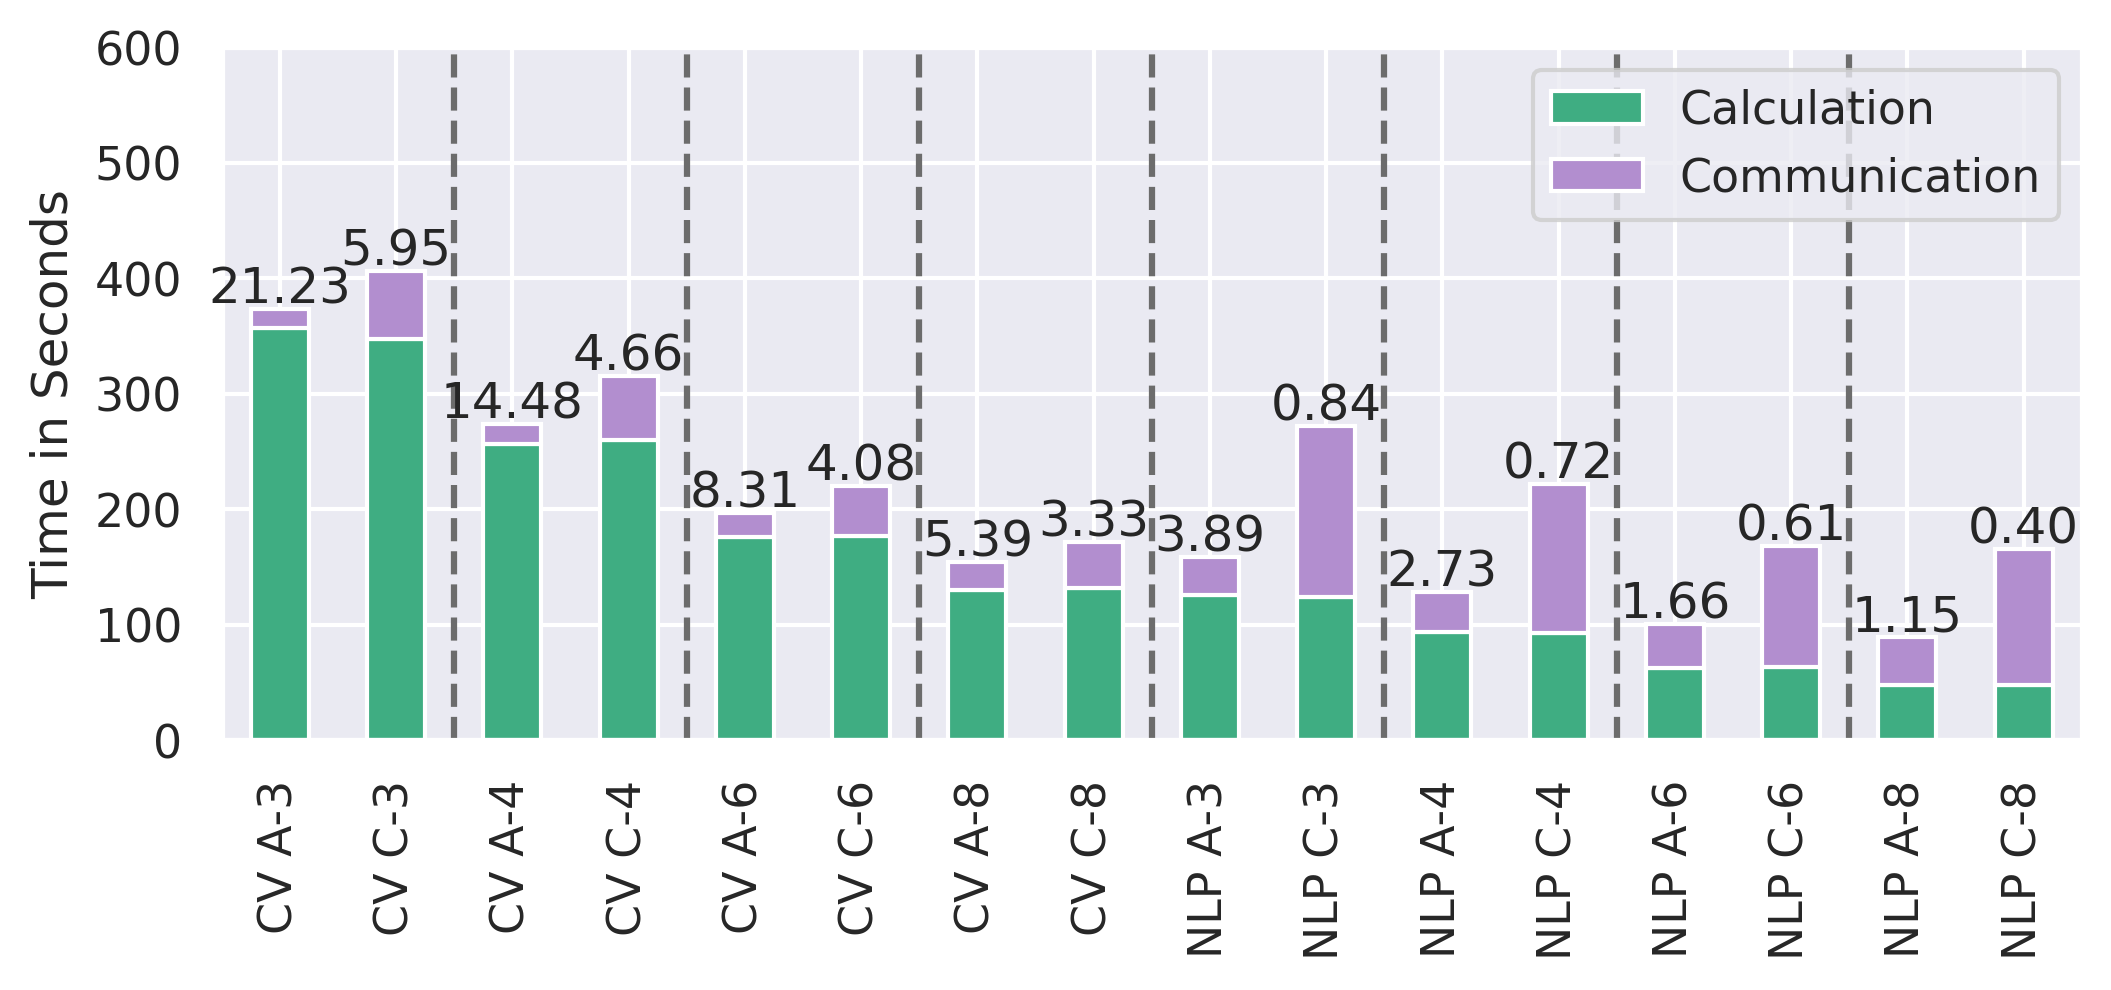

In [65]:
multi_zone_granularity_df = pd.concat(objs=[
    cv_3xUS_T4_gran_df,
    cv_1xUS_1xEU_1xASIA_T4_gran_df,
    cv_4xUS_T4_gran_df,
    cv_1xUS_1xEU_1xASIA_1xAUS_T4_gran_df,
    cv_6xUS_T4_gran_df,
    cv_2xUS_2xEU_2xASIA_T4_gran_df,
    cv_8xUS_T4_gran_df,
    cv_2xUS_2xEU_2xASIA_2xAUS_T4_gran_df,
    nlp_3xUS_T4_gran_df,
    nlp_1xUS_1xEU_1xASIA_T4_gran_df,
    nlp_4xUS_T4_gran_df,
    nlp_1xUS_1xEU_1xASIA_1xAUS_T4_gran_df,
    nlp_6xUS_T4_gran_df,
    nlp_2xUS_2xEU_2xASIA_T4_gran_df,
    nlp_8xUS_T4_gran_df,
    nlp_2xUS_2xEU_2xASIA_2xAUS_T4_gran_df
])

sns.set(palette=granularity_palette)
plt.figure(figsize=(8,3))
ax = multi_zone_granularity_df[["calc_time_s","comm_time_s","name"]].set_index('name').plot(kind='bar', stacked=True, figsize=(8,3))
plt.ylabel("Time in Seconds")
plt.ylim(0,600)
plt.legend(labels=["Calculation", "Communication"])
plt.xlabel("")
ax.axvline(1.5, color="#6c6c6c", linestyle="--")
ax.axvline(3.5, color="#6c6c6c", linestyle="--")
ax.axvline(5.5, color="#6c6c6c", linestyle="--")
ax.axvline(7.5, color="#6c6c6c", linestyle="--")
ax.axvline(9.5, color="#6c6c6c", linestyle="--")
ax.axvline(11.5, color="#6c6c6c", linestyle="--")
ax.axvline(13.5, color="#6c6c6c", linestyle="--")
show_granulartiy_values(ax=ax, df=multi_zone_granularity_df)
save_fig("geo-distributed-performance-US-EU-ASIA-AUS-granularity")

# Multi-Cloud Performance

In [66]:
cv_4xgc_df = get_hivemind_runs(run_names=["hivemind-77"], drop_first_epoch=True)
cv_4xgc_df = rename_models(df = cv_4xgc_df)
cv_4xgc_df["gpu_count"] = int(4)
cv_4xgc_df["gpu_type"] = "US T4"
cv_4xgc_df["provider"] = "D-1" #"4xGC"

cv_2xgc_2xaws_df = get_hivemind_runs(run_names=["hivemind-113"], drop_first_epoch=True)
cv_2xgc_2xaws_df = rename_models(df = cv_2xgc_2xaws_df)
cv_2xgc_2xaws_df["gpu_count"] = int(4)
cv_2xgc_2xaws_df["gpu_type"] = "US T4"
cv_2xgc_2xaws_df["provider"] = "D-2" # "2xGC + 2xAWS"

cv_2xgc_2xazure_df = get_hivemind_runs(run_names=["hivemind-117"], drop_first_epoch=True)
cv_2xgc_2xazure_df = rename_models(df = cv_2xgc_2xazure_df)
cv_2xgc_2xazure_df["gpu_count"] = int(4)
cv_2xgc_2xazure_df["gpu_type"] = "US T4"
cv_2xgc_2xazure_df["provider"] = "D-3" #"2xGC + 2xAzure"

nlp_4xgc_df = get_hivemind_runs(run_names=["hivemind-78"], drop_first_epoch=True)
nlp_4xgc_df = rename_models(df = nlp_4xgc_df)
nlp_4xgc_df["gpu_count"] = int(4)
nlp_4xgc_df["gpu_type"] = "US T4"
nlp_4xgc_df["provider"] = "D-1" #"4xGC"

nlp_2xgc_2xaws_df = get_hivemind_runs(run_names=["hivemind-112"], drop_first_epoch=True)
nlp_2xgc_2xaws_df = rename_models(df = nlp_2xgc_2xaws_df)
nlp_2xgc_2xaws_df["gpu_count"] = int(4)
nlp_2xgc_2xaws_df["gpu_type"] = "US T4"
nlp_2xgc_2xaws_df["provider"] = "D-2"#"2xGC + 2xAWS"

nlp_2xgc_2xazure_df = get_hivemind_runs(run_names=["hivemind-118"], drop_first_epoch=True)
nlp_2xgc_2xazure_df = rename_models(df = nlp_2xgc_2xazure_df)
nlp_2xgc_2xazure_df["gpu_count"] = int(4)
nlp_2xgc_2xazure_df["gpu_type"] = "US T4"
nlp_2xgc_2xazure_df["provider"] = "D-3" #"2xGC + 2xAzure"

> Found 1 runs with the prefix 'trainmonitor'.
> Found 1 runs with the prefix 'trainmonitor'.
> Found 1 runs with the prefix 'trainmonitor'.
> Found 1 runs with the prefix 'trainmonitor'.
> Found 1 runs with the prefix 'trainmonitor'.
> Found 1 runs with the prefix 'trainmonitor'.


In [67]:
full_multicloud_t4_runs_df = pd.concat(objs=[
    cv_4xgc_df,
    cv_2xgc_2xaws_df,
    cv_2xgc_2xazure_df,
    nlp_4xgc_df,
    nlp_2xgc_2xaws_df,
    nlp_2xgc_2xazure_df
])

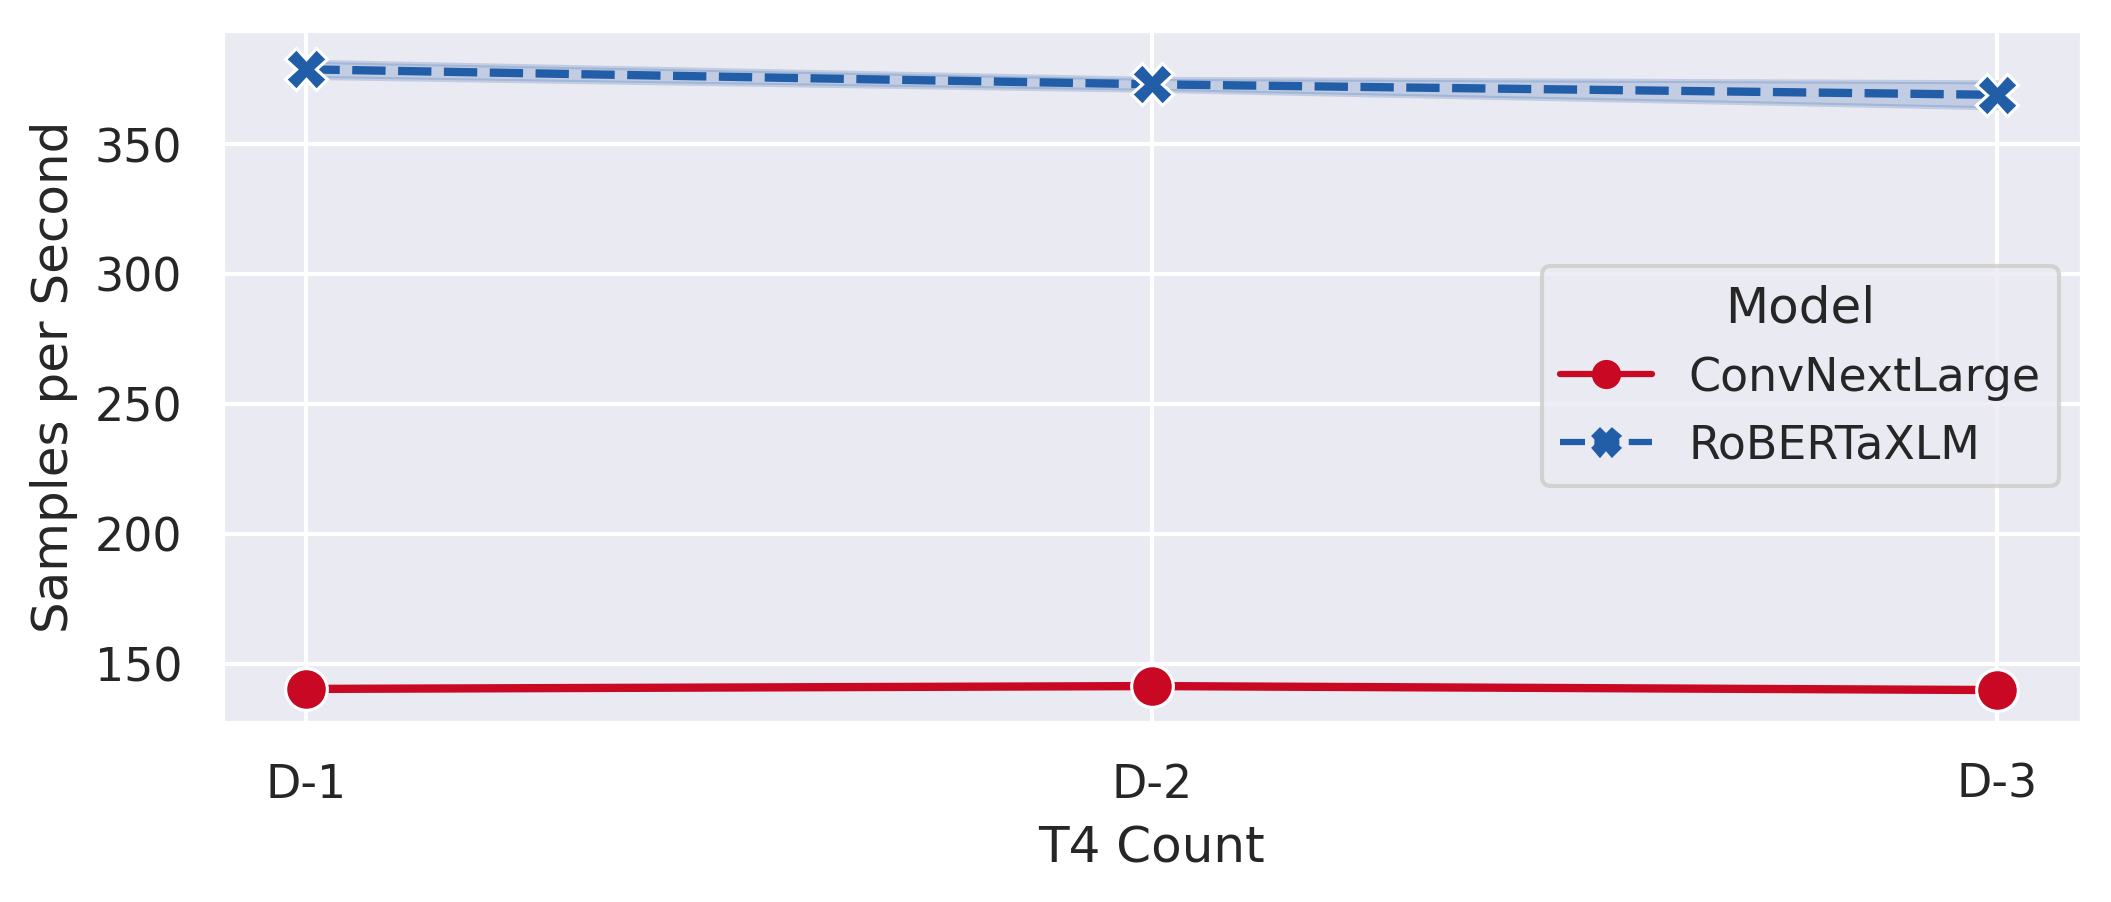

In [68]:
# filter local sps out
temp_df = full_multicloud_t4_runs_df.query("samples_per_sec.notna()")

sns.set(palette=cv_nlp_palette)
plt.figure(figsize=(8,3))
ax = sns.lineplot(
    data=temp_df,
    x="provider", y="samples_per_sec", hue="model", style="model",
    errorbar=('se', 1), dashes=True,
    markers=True,
    linewidth=2.0,
    markersize=10.0
)
#plt.title("Multicloud Performance")
plt.xlabel("T4 Count")
plt.ylabel("Samples per Second")
plt.legend(title="Model")
#plt.ylim(0,700)
#plt.xlim(0,10)
#sns.move_legend(ax, "upper left", bbox_to_anchor=(0, -0.15))
save_fig("multi-cloud-performance")

In [69]:
full_multicloud_t4_runs_df

local samples_per_sec  samples_per_sec          name          model  \
208             147.776034              NaN   hivemind-77  ConvNextLarge   
209             147.620964              NaN   hivemind-77  ConvNextLarge   
210             147.456325              NaN   hivemind-77  ConvNextLarge   
211             147.270688              NaN   hivemind-77  ConvNextLarge   
212             147.172235              NaN   hivemind-77  ConvNextLarge   
..                     ...              ...           ...            ...   
219             499.781729              NaN  hivemind-118     RoBERTaXLM   
220             499.781729              NaN  hivemind-118     RoBERTaXLM   
221             499.781729              NaN  hivemind-118     RoBERTaXLM   
222             499.781729              NaN  hivemind-118     RoBERTaXLM   
223             499.781729       374.050436  hivemind-118     RoBERTaXLM   

       TBS  gpu_count gpu_type provider  
208  32768          4    US T4      D-1  
209  32768          4    US T4      D-1  
210  32768          4    US T4      D-1  
211  32768          4    US T4      D-1  
212  32768          4    US T4      D-1  
..     ...        ...      ...      ...  
219  32768          4    US T4      D-3  
220  32768          4    US T4      D-3  
221  32768          4    US T4      D-3  
222  32768          4    US T4      D-3  
223  32768          4    US T4      D-3  

[1617 rows x 8 columns]

In [70]:
def get_mean_throughput(model, gpu_count, df, provider):
    TBS = 32768
    temp_df = df.query(f"samples_per_sec.notna() and TBS=={TBS} and model=='{model}' and gpu_count=={gpu_count} and provider=='{provider}'")
    return temp_df["samples_per_sec"].mean()

print("> Multi-Cloud Experiments\n")

for model in full_multicloud_t4_runs_df["model"].unique():
    print(f"Model {model}:")
    gpu_count = 4
    baseline_sps = get_mean_throughput(model=model, gpu_count=gpu_count, df=full_multicloud_t4_runs_df, provider="D-1")
    gc_aws_sps   = get_mean_throughput(model=model, gpu_count=gpu_count, df=full_multicloud_t4_runs_df, provider="D-2")
    gc_azure_sps = get_mean_throughput(model=model, gpu_count=gpu_count, df=full_multicloud_t4_runs_df, provider="D-3")
    
    gc_aws_speedup = gc_aws_sps / baseline_sps
    gc_azure_speedup = gc_azure_sps / baseline_sps
    
    print(f"- 4xGC:         {round(baseline_sps,2)}sps")
    print(f"- 2xGC+2xAWS:   {round(gc_aws_sps,2)}sps")
    print(f"   - Speedup vs 4xGC:   {round(gc_aws_speedup,2)}x")
    print(f"- 2xGC+2xAzure: {round(gc_azure_sps,2)}sps")
    print(f"   - Speedup vs 4xGC:   {round(gc_azure_speedup,2)}x")
    #us_baseline_speedup    = hivemind_local_sps / baseline_sps
    #us_norm_baseline_speedup = us_baseline_speedup / gpu_count

    #us_eu_baseline_speedup = hivemind_sps / baseline_sps
    #us_eu_norm_baseline_speedup = us_eu_baseline_speedup / gpu_count

    #us_vs_us_eu_speedup    = hivemind_sps / hivemind_local_sps

    #print(f" - US    Speedup vs baseline on {gpu_count} GPUS: {round(us_baseline_speedup,2)}x, Norm: {round(us_norm_baseline_speedup,2)}, Norm delta: {round(last_us_norm - us_norm_baseline_speedup,4)}, ({round(hivemind_local_sps,1)}, {round(baseline_sps,1)})")
    #print(f" - US-EU Speedup vs baseline on {gpu_count} GPUS: {round(us_eu_baseline_speedup,2)}x, Norm: {round(us_eu_norm_baseline_speedup,2)}, Norm delta: {round(last_us_eu_norm - us_eu_norm_baseline_speedup,4)}, ({round(hivemind_sps,1)}, {round(baseline_sps,1)})")
    #print(f" - Speedup vs US-run         on {gpu_count} GPUS: {round(us_vs_us_eu_speedup,2)}x,            ({round(hivemind_sps,1)}, {round(hivemind_local_sps,1)})")
    #print("")

> Multi-Cloud Experiments

Model ConvNextLarge:
- 4xGC:         140.4sps
- 2xGC+2xAWS:   141.5sps
   - Speedup vs 4xGC:   1.01x
- 2xGC+2xAzure: 139.97sps
   - Speedup vs 4xGC:   1.0x
Model RoBERTaXLM:
- 4xGC:         378.85sps
- 2xGC+2xAWS:   373.07sps
   - Speedup vs 4xGC:   0.98x
- 2xGC+2xAzure: 369.03sps
   - Speedup vs 4xGC:   0.97x


In [71]:
debug = False
cv_4xGC_gran_df = get_granularity_cumulated(run_name="hivemind-77", name="CV D-1", debug=debug)
cv_2xGC_2xAWS_gran_df = get_granularity_cumulated(run_name="hivemind-113", name="CV D-2", debug=debug)
cv_2xGC_2xAZU_gran_df = get_granularity_cumulated(run_name="hivemind-117", name="CV D-3", debug=debug)

nlp_4xGC_gran_df = get_granularity_cumulated(run_name="hivemind-78", name="NLP D-1", debug=debug)
nlp_2xGC_2xAWS_gran_df = get_granularity_cumulated(run_name="hivemind-112", name="NLP D-2", debug=debug)
nlp_2xGC_2xAZU_gran_df = get_granularity_cumulated(run_name="hivemind-118", name="NLP D-3", debug=debug)

> Found 4 runs with the infix 'bee'.
> Found 4 runs with the infix 'bee'.
> Found 4 runs with the infix 'bee'.
> Found 4 runs with the infix 'bee'.
> Found 4 runs with the infix 'bee'.
> Found 4 runs with the infix 'bee'.


<Figure size 2400x900 with 0 Axes>

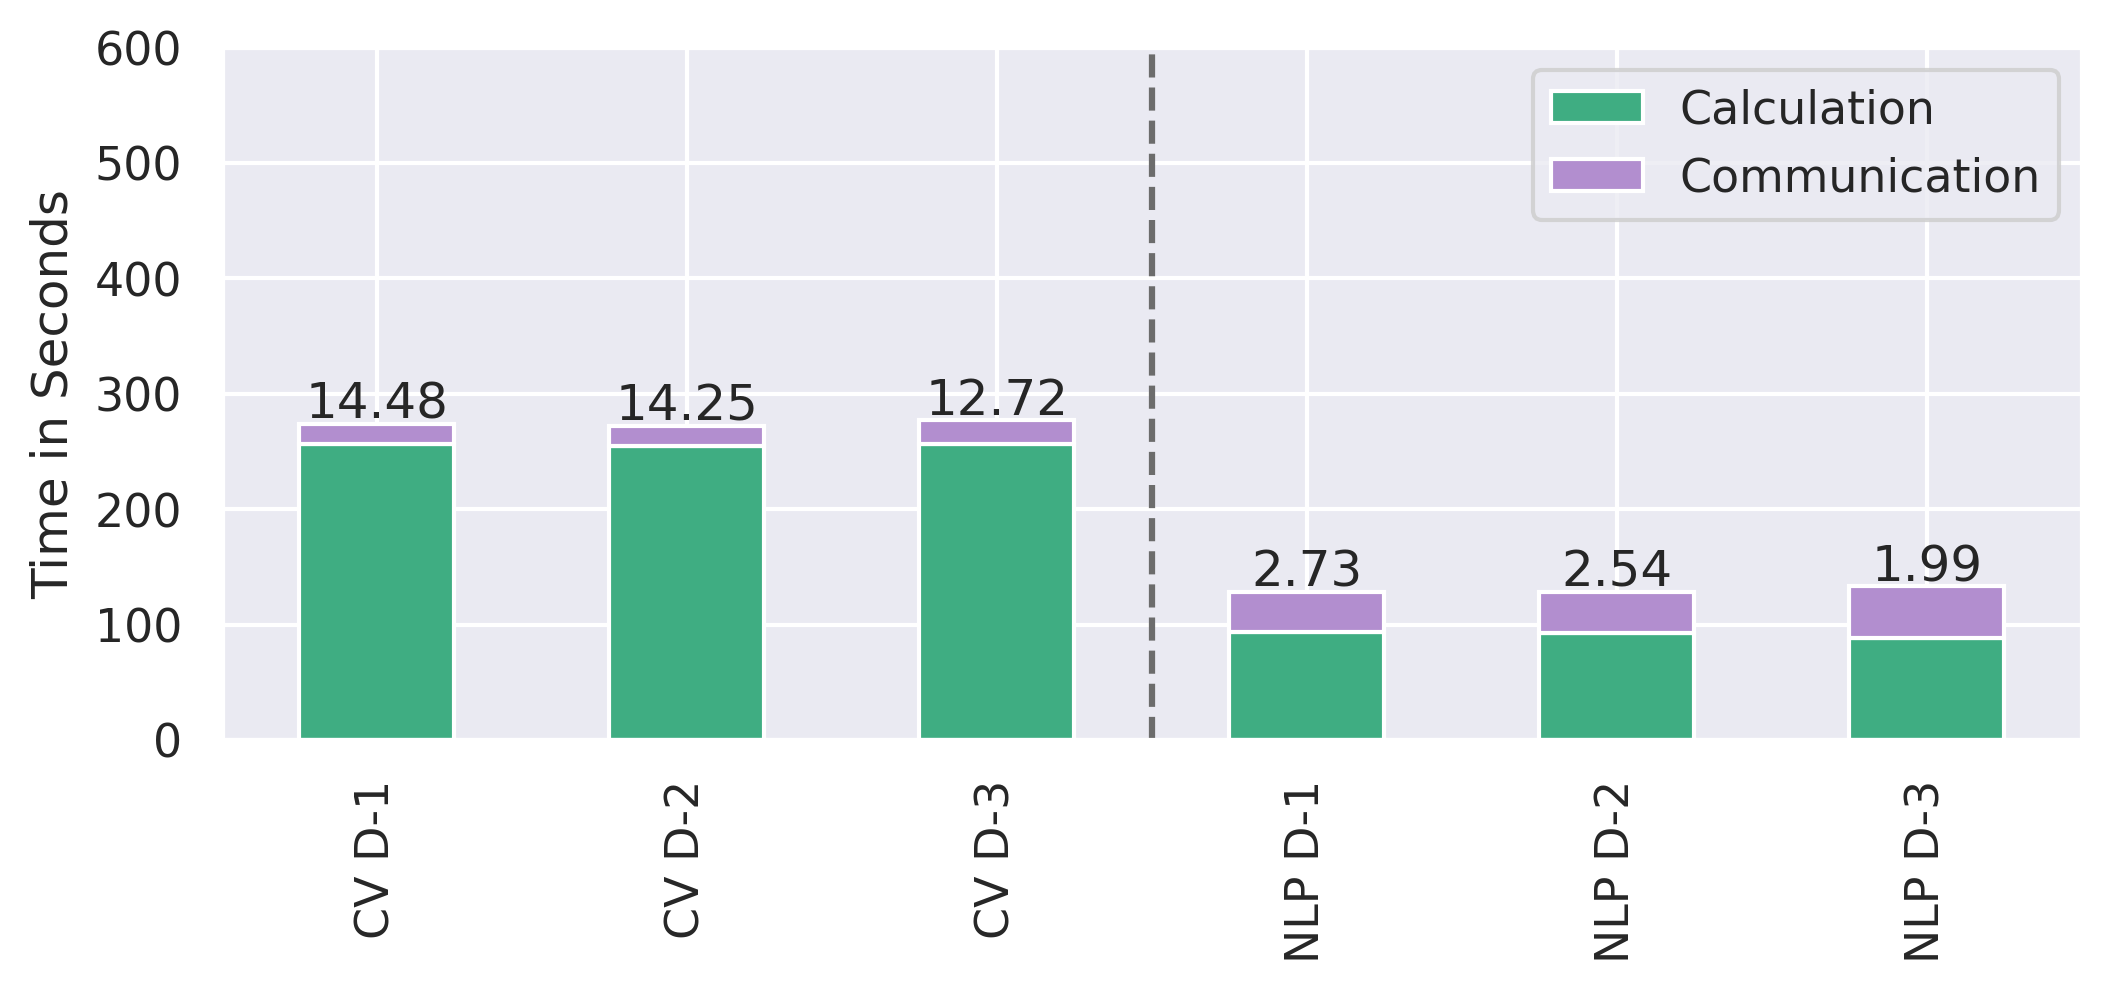

In [72]:
multi_cloud_granularity_df = pd.concat(objs=[
    cv_4xGC_gran_df,
    cv_2xGC_2xAWS_gran_df,
    cv_2xGC_2xAZU_gran_df,
    nlp_4xGC_gran_df,
    nlp_2xGC_2xAWS_gran_df,
    nlp_2xGC_2xAZU_gran_df,
])

sns.set(palette=granularity_palette)
plt.figure(figsize=(8,3))
ax = multi_cloud_granularity_df[["calc_time_s","comm_time_s","name"]].set_index('name').plot(kind='bar', stacked=True, figsize=(8,3))
plt.ylabel("Time in Seconds")
plt.legend(labels=["Calculation", "Communication"])
plt.xlabel("")
plt.ylim(0,600)
ax.axvline(2.5, color="#6c6c6c", linestyle="--")
show_granulartiy_values(ax=ax, df=multi_cloud_granularity_df)
save_fig("multi-cloud-performance-granularity")

# Hybrid Cloud Experiments

## Startup Setting

In [73]:
cv_base_rtx8000_df = get_baseline_runs(run_names=["baseline-94-torchvision.models.convnext_large"])
cv_base_rtx8000_df = rename_models(df = cv_base_rtx8000_df)
cv_base_rtx8000_df["gpu_count"] = int(1)
cv_base_rtx8000_df["name"] = "RTX8000"
cv_base_rtx8000_df["gpu_type"] = "RTX8000"

cv_eu_1xt4_rtx8000_df = get_hivemind_runs(run_names=["hivemind-102"], drop_first_epoch=True)
cv_eu_1xt4_rtx8000_df = rename_models(df = cv_eu_1xt4_rtx8000_df)
cv_eu_1xt4_rtx8000_df["gpu_count"] = int(2)
cv_eu_1xt4_rtx8000_df["name"] = "E-A-1"
cv_eu_1xt4_rtx8000_df["gpu_type"] = "EU T4 (E-A)"

cv_eu_2xt4_rtx8000_df = get_hivemind_runs(run_names=["hivemind-100"], drop_first_epoch=True)
cv_eu_2xt4_rtx8000_df = rename_models(df = cv_eu_2xt4_rtx8000_df)
cv_eu_2xt4_rtx8000_df["gpu_count"] = int(3)
cv_eu_2xt4_rtx8000_df["name"] = "E-A-2"
cv_eu_2xt4_rtx8000_df["gpu_type"] = "EU T4 (E-A)"

cv_eu_4xt4_rtx8000_df = get_hivemind_runs(run_names=["hivemind-98"], drop_first_epoch=True)
cv_eu_4xt4_rtx8000_df = rename_models(df = cv_eu_4xt4_rtx8000_df)
cv_eu_4xt4_rtx8000_df["gpu_count"] = int(5)
cv_eu_4xt4_rtx8000_df["name"] = "E-A-4"
cv_eu_4xt4_rtx8000_df["gpu_type"] = "EU T4 (E-A)"

cv_eu_8xt4_rtx8000_df = get_hivemind_runs(run_names=["hivemind-96"], drop_first_epoch=True)
cv_eu_8xt4_rtx8000_df = rename_models(df = cv_eu_8xt4_rtx8000_df)
cv_eu_8xt4_rtx8000_df["gpu_count"] = int(9)
cv_eu_8xt4_rtx8000_df["name"] = "E-A-8"
cv_eu_8xt4_rtx8000_df["gpu_type"] = "EU T4 (E-A)"

nlp_base_rtx8000_df = get_baseline_runs(run_names=["baseline-95-roberta_mlm_xlm"])
nlp_base_rtx8000_df = rename_models(df = nlp_base_rtx8000_df)
nlp_base_rtx8000_df["gpu_count"] = int(1)
nlp_base_rtx8000_df["name"] = "RTX8000"
nlp_base_rtx8000_df["gpu_type"] = "RTX8000"

nlp_eu_1xt4_rtx8000_df = get_hivemind_runs(run_names=["hivemind-103"], drop_first_epoch=True)
nlp_eu_1xt4_rtx8000_df = rename_models(df = nlp_eu_1xt4_rtx8000_df)
nlp_eu_1xt4_rtx8000_df["gpu_count"] = int(2)
nlp_eu_1xt4_rtx8000_df["name"] = "E-A-1"
nlp_eu_1xt4_rtx8000_df["gpu_type"] = "EU T4 (E-A)"

nlp_eu_2xt4_rtx8000_df = get_hivemind_runs(run_names=["hivemind-101"], drop_first_epoch=True)
nlp_eu_2xt4_rtx8000_df = rename_models(df = nlp_eu_2xt4_rtx8000_df)
nlp_eu_2xt4_rtx8000_df["gpu_count"] = int(3)
nlp_eu_2xt4_rtx8000_df["name"] = "E-A-2"
nlp_eu_2xt4_rtx8000_df["gpu_type"] = "EU T4 (E-A)"

nlp_eu_4xt4_rtx8000_df = get_hivemind_runs(run_names=["hivemind-99"], drop_first_epoch=True)
nlp_eu_4xt4_rtx8000_df = rename_models(df = nlp_eu_4xt4_rtx8000_df)
nlp_eu_4xt4_rtx8000_df["gpu_count"] = int(5)
nlp_eu_4xt4_rtx8000_df["name"] = "E-A-4"
nlp_eu_4xt4_rtx8000_df["gpu_type"] = "EU T4 (E-A)"

nlp_eu_8xt4_rtx8000_df = get_hivemind_runs(run_names=["hivemind-97"], drop_first_epoch=True)
nlp_eu_8xt4_rtx8000_df = rename_models(df = nlp_eu_8xt4_rtx8000_df)
nlp_eu_8xt4_rtx8000_df["gpu_count"] = int(9)
nlp_eu_8xt4_rtx8000_df["name"] = "E-A-8"
nlp_eu_8xt4_rtx8000_df["gpu_type"] = "EU T4 (E-A)"

> Found 1 runs with the prefix 'trainmonitor'.
> Found 1 runs with the prefix 'trainmonitor'.
> Found 1 runs with the prefix 'trainmonitor'.
> Found 1 runs with the prefix 'trainmonitor'.
> Found 1 runs with the prefix 'trainmonitor'.
> Found 1 runs with the prefix 'trainmonitor'.
> Found 1 runs with the prefix 'trainmonitor'.
> Found 1 runs with the prefix 'trainmonitor'.


In [74]:
rtx8000_eu_runs_df = pd.concat(objs=[
    cv_base_rtx8000_df,
    cv_eu_1xt4_rtx8000_df,
    cv_eu_2xt4_rtx8000_df,
    cv_eu_4xt4_rtx8000_df,
    cv_eu_8xt4_rtx8000_df,
    nlp_base_rtx8000_df,
    nlp_eu_1xt4_rtx8000_df,
    nlp_eu_2xt4_rtx8000_df,
    nlp_eu_4xt4_rtx8000_df,
    nlp_eu_8xt4_rtx8000_df
])

In [75]:
cv_us_1xt4_rtx8000_df = get_hivemind_runs(run_names=["hivemind-135"], drop_first_epoch=True)
cv_us_1xt4_rtx8000_df = rename_models(df = cv_us_1xt4_rtx8000_df)
cv_us_1xt4_rtx8000_df["gpu_count"] = int(2)
cv_us_1xt4_rtx8000_df["name"] = "E-B-1"
cv_us_1xt4_rtx8000_df["gpu_type"] = "US T4 (E-B)"

cv_us_2xt4_rtx8000_df = get_hivemind_runs(run_names=["hivemind-129"], drop_first_epoch=True)
cv_us_2xt4_rtx8000_df = rename_models(df = cv_us_2xt4_rtx8000_df)
cv_us_2xt4_rtx8000_df["gpu_count"] = int(3)
cv_us_2xt4_rtx8000_df["name"] = "E-B-2"
cv_us_2xt4_rtx8000_df["gpu_type"] = "US T4 (E-B)"

cv_us_4xt4_rtx8000_df = get_hivemind_runs(run_names=["hivemind-127"], drop_first_epoch=True)
cv_us_4xt4_rtx8000_df = rename_models(df = cv_us_4xt4_rtx8000_df)
cv_us_4xt4_rtx8000_df["gpu_count"] = int(5)
cv_us_4xt4_rtx8000_df["name"] = "E-B-4"
cv_us_4xt4_rtx8000_df["gpu_type"] = "US T4 (E-B)"

cv_us_8xt4_rtx8000_df = get_hivemind_runs(run_names=["hivemind-121"], drop_first_epoch=True)
cv_us_8xt4_rtx8000_df = rename_models(df = cv_us_8xt4_rtx8000_df)
cv_us_8xt4_rtx8000_df["gpu_count"] = int(9)
cv_us_8xt4_rtx8000_df["name"] = "E-B-8"
cv_us_8xt4_rtx8000_df["gpu_type"] = "US T4 (E-B)"

nlp_us_1xt4_rtx8000_df = get_hivemind_runs(run_names=["hivemind-136"], drop_first_epoch=True)
nlp_us_1xt4_rtx8000_df = rename_models(df = nlp_us_1xt4_rtx8000_df)
nlp_us_1xt4_rtx8000_df["gpu_count"] = int(2)
nlp_us_1xt4_rtx8000_df["name"] = "E-B-1"
nlp_us_1xt4_rtx8000_df["gpu_type"] = "US T4 (E-B)"

nlp_us_2xt4_rtx8000_df = get_hivemind_runs(run_names=["hivemind-130"], drop_first_epoch=True)
nlp_us_2xt4_rtx8000_df = rename_models(df = nlp_us_2xt4_rtx8000_df)
nlp_us_2xt4_rtx8000_df["gpu_count"] = int(3)
nlp_us_2xt4_rtx8000_df["name"] = "E-B-2"
nlp_us_2xt4_rtx8000_df["gpu_type"] = "US T4 (E-B)"

nlp_us_4xt4_rtx8000_df = get_hivemind_runs(run_names=["hivemind-128"], drop_first_epoch=True)
nlp_us_4xt4_rtx8000_df = rename_models(df = nlp_us_4xt4_rtx8000_df)
nlp_us_4xt4_rtx8000_df["gpu_count"] = int(5)
nlp_us_4xt4_rtx8000_df["name"] = "E-B-4"
nlp_us_4xt4_rtx8000_df["gpu_type"] = "US T4 (E-B)"

nlp_us_8xt4_rtx8000_df = get_hivemind_runs(run_names=["hivemind-122"], drop_first_epoch=True)
nlp_us_8xt4_rtx8000_df = rename_models(df = nlp_us_8xt4_rtx8000_df)
nlp_us_8xt4_rtx8000_df["gpu_count"] = int(9)
nlp_us_8xt4_rtx8000_df["name"] = "E-B-8"
nlp_us_8xt4_rtx8000_df["gpu_type"] = "US T4 (E-B)"

> Found 1 runs with the prefix 'trainmonitor'.
> Found 1 runs with the prefix 'trainmonitor'.
> Found 1 runs with the prefix 'trainmonitor'.
> Found 1 runs with the prefix 'trainmonitor'.
> Found 1 runs with the prefix 'trainmonitor'.
> Found 1 runs with the prefix 'trainmonitor'.
> Found 1 runs with the prefix 'trainmonitor'.
> Found 1 runs with the prefix 'trainmonitor'.


In [76]:
rtx8000_us_runs_df = pd.concat(objs=[
    cv_us_1xt4_rtx8000_df,
    cv_us_2xt4_rtx8000_df,
    cv_us_4xt4_rtx8000_df,
    cv_us_8xt4_rtx8000_df,
    nlp_us_1xt4_rtx8000_df,
    nlp_us_2xt4_rtx8000_df,
    nlp_us_4xt4_rtx8000_df,
    nlp_us_8xt4_rtx8000_df
])

In [77]:
cv_us_1xa10_rtx8000_df = get_hivemind_runs(run_names=["hivemind-151"], drop_first_epoch=True)
cv_us_1xa10_rtx8000_df = rename_models(df = cv_us_1xa10_rtx8000_df)
cv_us_1xa10_rtx8000_df["gpu_count"] = int(2)
cv_us_1xa10_rtx8000_df["name"] = "E-C-1"
cv_us_1xa10_rtx8000_df["gpu_type"] = "US A10 (E-C)"

cv_us_2xa10_rtx8000_df = get_hivemind_runs(run_names=["hivemind-147"], drop_first_epoch=True)
cv_us_2xa10_rtx8000_df = rename_models(df = cv_us_2xa10_rtx8000_df)
cv_us_2xa10_rtx8000_df["gpu_count"] = int(3)
cv_us_2xa10_rtx8000_df["name"] = "E-C-2"
cv_us_2xa10_rtx8000_df["gpu_type"] = "US A10 (E-C)"

cv_us_4xa10_rtx8000_df = get_hivemind_runs(run_names=["hivemind-338"], drop_first_epoch=True)
cv_us_4xa10_rtx8000_df = rename_models(df = cv_us_4xa10_rtx8000_df)
cv_us_4xa10_rtx8000_df["gpu_count"] = int(5)
cv_us_4xa10_rtx8000_df["name"] = "E-C-4"
cv_us_4xa10_rtx8000_df["gpu_type"] = "US A10 (E-C)"

cv_us_8xa10_rtx8000_df = get_hivemind_runs(run_names=["hivemind-139"], drop_first_epoch=True)
cv_us_8xa10_rtx8000_df = rename_models(df = cv_us_8xa10_rtx8000_df)
cv_us_8xa10_rtx8000_df["gpu_count"] = int(9)
cv_us_8xa10_rtx8000_df["name"] = "E-C-8"
cv_us_8xa10_rtx8000_df["gpu_type"] = "US A10 (E-C)"

nlp_us_1xa10_rtx8000_df = get_hivemind_runs(run_names=["hivemind-152"], drop_first_epoch=True)
nlp_us_1xa10_rtx8000_df = rename_models(df = nlp_us_1xa10_rtx8000_df)
nlp_us_1xa10_rtx8000_df["gpu_count"] = int(2)
nlp_us_1xa10_rtx8000_df["name"] = "E-C-1"
nlp_us_1xa10_rtx8000_df["gpu_type"] = "US A10 (E-C)"

nlp_us_2xa10_rtx8000_df = get_hivemind_runs(run_names=["hivemind-148"], drop_first_epoch=True)
nlp_us_2xa10_rtx8000_df = rename_models(df = nlp_us_2xa10_rtx8000_df)
nlp_us_2xa10_rtx8000_df["gpu_count"] = int(3)
nlp_us_2xa10_rtx8000_df["name"] = "E-C-2"
nlp_us_2xa10_rtx8000_df["gpu_type"] = "US A10 (E-C)"

nlp_us_4xa10_rtx8000_df = get_hivemind_runs(run_names=["hivemind-144"], drop_first_epoch=True)
nlp_us_4xa10_rtx8000_df = rename_models(df = nlp_us_4xa10_rtx8000_df)
nlp_us_4xa10_rtx8000_df["gpu_count"] = int(5)
nlp_us_4xa10_rtx8000_df["name"] = "E-C-4"
nlp_us_4xa10_rtx8000_df["gpu_type"] = "US A10 (E-C)"

nlp_us_8xa10_rtx8000_df = get_hivemind_runs(run_names=["hivemind-140"], drop_first_epoch=True)
nlp_us_8xa10_rtx8000_df = rename_models(df = nlp_us_8xa10_rtx8000_df)
nlp_us_8xa10_rtx8000_df["gpu_count"] = int(9)
nlp_us_8xa10_rtx8000_df["name"] = "E-C-8"
nlp_us_8xa10_rtx8000_df["gpu_type"] = "US A10 (E-C)"

> Found 1 runs with the prefix 'trainmonitor'.
> Found 1 runs with the prefix 'trainmonitor'.
> Found 1 runs with the prefix 'trainmonitor'.
> Found 1 runs with the prefix 'trainmonitor'.
> Found 1 runs with the prefix 'trainmonitor'.
> Found 1 runs with the prefix 'trainmonitor'.
> Found 1 runs with the prefix 'trainmonitor'.
> Found 1 runs with the prefix 'trainmonitor'.


In [78]:
rtx8000_us_a10_runs_df = pd.concat(objs=[
    cv_us_1xa10_rtx8000_df,
    cv_us_2xa10_rtx8000_df,
    cv_us_4xa10_rtx8000_df,
    cv_us_8xa10_rtx8000_df,
    nlp_us_1xa10_rtx8000_df,
    nlp_us_2xa10_rtx8000_df,
    nlp_us_4xa10_rtx8000_df,
    nlp_us_8xa10_rtx8000_df
])

In [79]:
rtx8000_all_runs_df = pd.concat(objs=[rtx8000_eu_runs_df, rtx8000_us_runs_df, rtx8000_us_a10_runs_df])

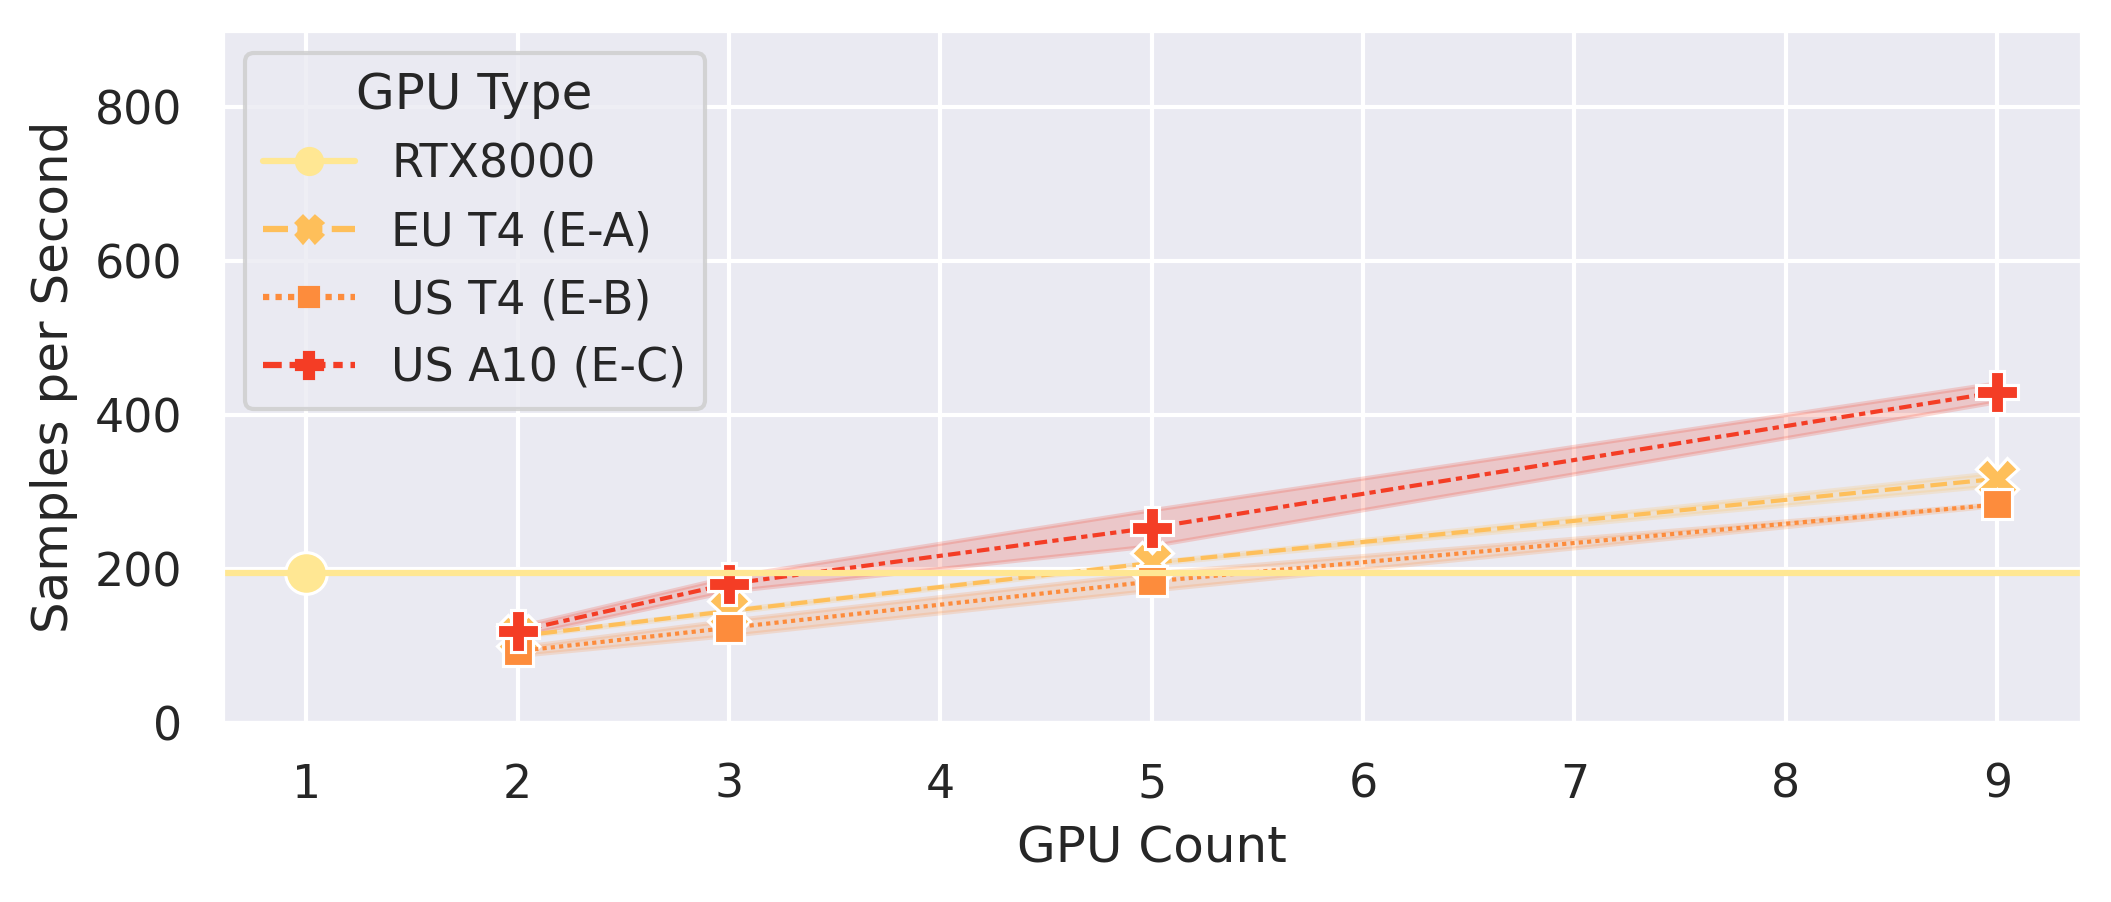

In [80]:
# filter local sps out
temp_df = rtx8000_all_runs_df.query("samples_per_sec.notna()")
temp_df = temp_df.query("model=='ConvNextLarge'")

sns.set(palette=cv_palette)
plt.figure(figsize=(8,3))
ax = sns.lineplot(
    data=temp_df,
    x="gpu_count", y="samples_per_sec", hue="gpu_type", style="gpu_type",
    errorbar=('se', 1), dashes=True,
    markers=True,
    linewidth=1.0,
    markersize=10.0
)
#plt.title("Private Setting")
plt.xlabel("GPU Count")
plt.ylim(0,900)
plt.ylabel("Samples per Second")
plt.legend(title="GPU Type")
ax.axhline(195, color="#ffe793", linestyle="-")
#plt.xlim(0,10)
#sns.move_legend(ax, "upper left", bbox_to_anchor=(0, -0.15))
save_fig("cv-private-setting-performance")

In [81]:
rtx8000_all_runs_df

samples_per_sec     name          model    TBS  gpu_count      gpu_type  \
0           8.716141  RTX8000  ConvNextLarge  32768          1       RTX8000   
1         202.503616  RTX8000  ConvNextLarge  32768          1       RTX8000   
2         204.916454  RTX8000  ConvNextLarge  32768          1       RTX8000   
3         205.517471  RTX8000  ConvNextLarge  32768          1       RTX8000   
4         204.936781  RTX8000  ConvNextLarge  32768          1       RTX8000   
..               ...      ...            ...    ...        ...           ...   
318              NaN    E-C-8     RoBERTaXLM  32768          9  US A10 (E-C)   
319              NaN    E-C-8     RoBERTaXLM  32768          9  US A10 (E-C)   
320              NaN    E-C-8     RoBERTaXLM  32768          9  US A10 (E-C)   
321              NaN    E-C-8     RoBERTaXLM  32768          9  US A10 (E-C)   
322       229.297981    E-C-8     RoBERTaXLM  32768          9  US A10 (E-C)   

     local samples_per_sec  
0                      NaN  
1                      NaN  
2                      NaN  
3                      NaN  
4                      NaN  
..                     ...  
318            2274.876337  
319            2274.876337  
320            2274.876337  
321            2274.876337  
322            2274.876337  

[10923 rows x 7 columns]

In [82]:
def get_mean_throughput(model, gpu_count, df, gpu_type):
    TBS = 32768
    temp_df = df.query(f"samples_per_sec.notna() and TBS=={TBS} and model=='{model}' and gpu_count=={gpu_count} and gpu_type=='{gpu_type}'")
    return temp_df["samples_per_sec"].mean()


#print("CV, EU T4 vs. US T4 vs. US A10")
#print("-----------------------")

# rtx8000_all_runs_df = pd.concat(objs=[rtx8000_eu_runs_df, rtx8000_us_runs_df, rtx8000_us_a10_runs_df])

for model in rtx8000_all_runs_df["model"].unique():
    for gpu_type in ["EU T4 (E-A)", "US T4 (E-B)", "US A10 (E-C)"]:
        print(f"Model: {model}, Type: {gpu_type}")
        baseline_sps = get_mean_throughput(model=model, gpu_count=1, df=rtx8000_all_runs_df, gpu_type="RTX8000")
        print(f"   1 GPU, SPS: {round(baseline_sps,2):>6}")
        for gpu_count in [2,3,5,9]:
            sps = get_mean_throughput(model=model, gpu_count=gpu_count, df=rtx8000_all_runs_df, gpu_type=gpu_type)
            norm_sps = sps / gpu_count
            speedup = sps / baseline_sps
            norm_speedup = speedup / gpu_count
            
            print(f"  {gpu_count} GPUs, SPS: {round(sps,2):>6}, Norm SPS: {round(norm_sps,2):>6}, Speedup: {round(speedup,2):>6}, Norm Speedup: {round(norm_speedup,2):>6}")

Model: ConvNextLarge, Type: EU T4 (E-A)
   1 GPU, SPS: 194.83
  2 GPUs, SPS: 112.39, Norm SPS:   56.2, Speedup:   0.58, Norm Speedup:   0.29
  3 GPUs, SPS: 145.16, Norm SPS:  48.39, Speedup:   0.75, Norm Speedup:   0.25
  5 GPUs, SPS: 207.49, Norm SPS:   41.5, Speedup:   1.06, Norm Speedup:   0.21
  9 GPUs, SPS: 316.84, Norm SPS:   35.2, Speedup:   1.63, Norm Speedup:   0.18
Model: ConvNextLarge, Type: US T4 (E-B)
   1 GPU, SPS: 194.83
  2 GPUs, SPS:  92.94, Norm SPS:  46.47, Speedup:   0.48, Norm Speedup:   0.24
  3 GPUs, SPS: 123.26, Norm SPS:  41.09, Speedup:   0.63, Norm Speedup:   0.21
  5 GPUs, SPS: 183.45, Norm SPS:  36.69, Speedup:   0.94, Norm Speedup:   0.19
  9 GPUs, SPS: 283.46, Norm SPS:   31.5, Speedup:   1.45, Norm Speedup:   0.16
Model: ConvNextLarge, Type: US A10 (E-C)
   1 GPU, SPS: 194.83
  2 GPUs, SPS: 118.93, Norm SPS:  59.46, Speedup:   0.61, Norm Speedup:   0.31
  3 GPUs, SPS: 180.34, Norm SPS:  60.11, Speedup:   0.93, Norm Speedup:   0.31
  5 GPUs, SPS: 253.31, 

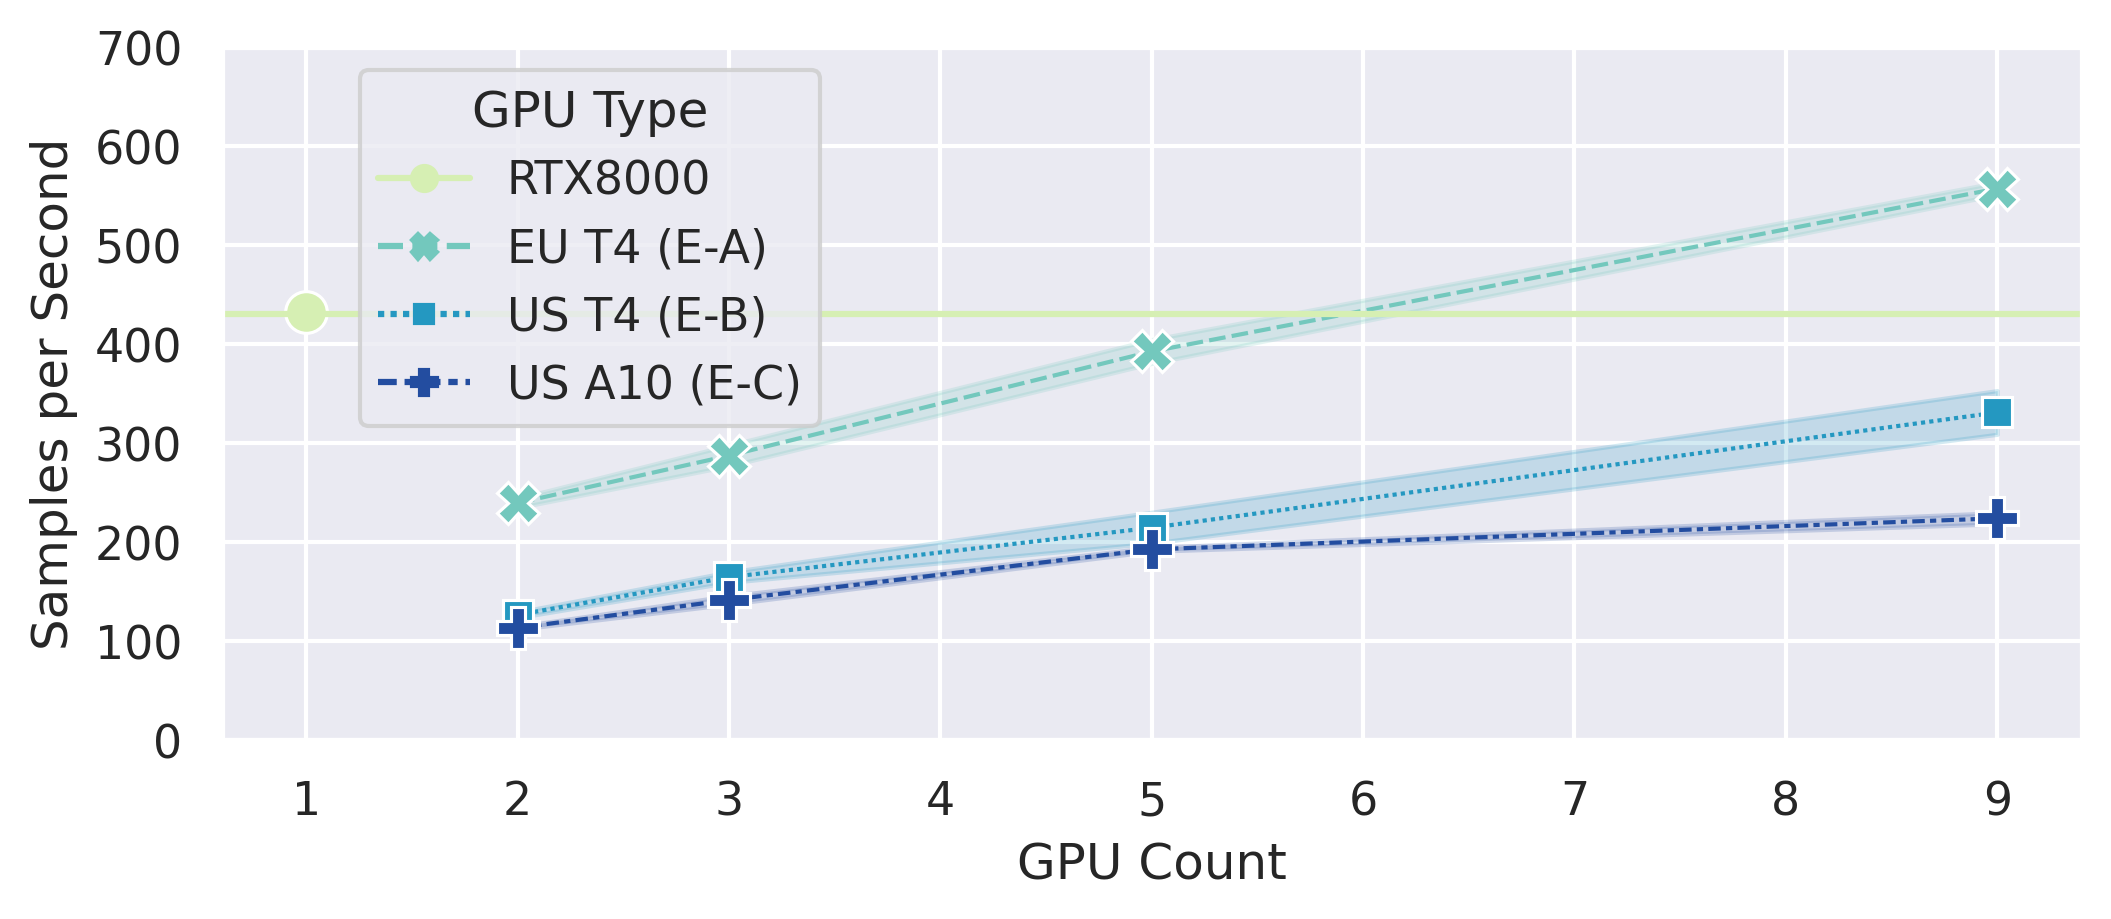

In [83]:
temp_df = rtx8000_all_runs_df.query("samples_per_sec.notna()")
temp_df = temp_df.query("model=='RoBERTaXLM'")

sns.set(palette=nlp_ext_palette)
plt.figure(figsize=(8,3))
ax = sns.lineplot(
    data=temp_df,
    x="gpu_count", y="samples_per_sec", hue="gpu_type", style="gpu_type",
    errorbar=('se', 1), dashes=True,
    markers=True,
    linewidth=1.0,
    markersize=10.0
)
#plt.title("Private Setting")
plt.xlabel("GPU Count")
plt.ylim(0,700)
plt.ylabel("Samples per Second")
plt.legend(title="GPU Type")
ax.axhline(430, color="#d6efb3", linestyle="-")
#plt.xlim(0,10)
sns.move_legend(ax, "upper left", bbox_to_anchor=(0.062, 1))
save_fig("nlp-private-setting-performance")

In [84]:
debug = False
cv_eu_1xt4_rtx8000_gran_df   = get_granularity_cumulated(run_name="hivemind-102", name="E-A-1", debug=debug)
cv_eu_2xt4_rtx8000_gran_df   = get_granularity_cumulated(run_name="hivemind-100", name="E-A-2", debug=debug)
cv_eu_4xt4_rtx8000_gran_df   = get_granularity_cumulated(run_name="hivemind-98",  name="E-A-4", debug=debug)
cv_eu_8xt4_rtx8000_gran_df   = get_granularity_cumulated(run_name="hivemind-96",  name="E-A-8", debug=debug)
nlp_eu_1xt4_rtx8000_gran_df  = get_granularity_cumulated(run_name="hivemind-103", name="E-A-1", debug=debug)
nlp_eu_2xt4_rtx8000_gran_df  = get_granularity_cumulated(run_name="hivemind-101", name="E-A-2", debug=debug)
nlp_eu_4xt4_rtx8000_gran_df  = get_granularity_cumulated(run_name="hivemind-99",  name="E-A-4", debug=debug)
nlp_eu_8xt4_rtx8000_gran_df  = get_granularity_cumulated(run_name="hivemind-97",  name="E-A-8", debug=debug)
cv_us_1xt4_rtx8000_gran_df   = get_granularity_cumulated(run_name="hivemind-135", name="E-B-1", debug=debug)
cv_us_2xt4_rtx8000_gran_df   = get_granularity_cumulated(run_name="hivemind-129", name="E-B-2", debug=debug)
cv_us_4xt4_rtx8000_gran_df   = get_granularity_cumulated(run_name="hivemind-127", name="E-B-4", debug=debug)
cv_us_8xt4_rtx8000_gran_df   = get_granularity_cumulated(run_name="hivemind-121", name="E-B-8", debug=debug)
nlp_us_1xt4_rtx8000_gran_df  = get_granularity_cumulated(run_name="hivemind-136", name="E-B-1", debug=debug)
nlp_us_2xt4_rtx8000_gran_df  = get_granularity_cumulated(run_name="hivemind-130", name="E-B-2", debug=debug)
nlp_us_4xt4_rtx8000_gran_df  = get_granularity_cumulated(run_name="hivemind-128", name="E-B-4", debug=debug)
nlp_us_8xt4_rtx8000_gran_df  = get_granularity_cumulated(run_name="hivemind-122", name="E-B-8", debug=debug)
cv_us_1xa10_rtx8000_gran_df  = get_granularity_cumulated(run_name="hivemind-151", name="E-C-1", debug=debug)
cv_us_2xa10_rtx8000_gran_df  = get_granularity_cumulated(run_name="hivemind-147", name="E-C-2", debug=debug)
cv_us_4xa10_rtx8000_gran_df  = get_granularity_cumulated(run_name="hivemind-338", name="E-C-4", debug=debug)
cv_us_8xa10_rtx8000_gran_df  = get_granularity_cumulated(run_name="hivemind-139", name="E-C-8", debug=debug)
nlp_us_1xa10_rtx8000_gran_df = get_granularity_cumulated(run_name="hivemind-152", name="E-C-1", debug=debug)
nlp_us_2xa10_rtx8000_gran_df = get_granularity_cumulated(run_name="hivemind-148", name="E-C-2", debug=debug)
nlp_us_4xa10_rtx8000_gran_df = get_granularity_cumulated(run_name="hivemind-144", name="E-C-4", debug=debug)
nlp_us_8xa10_rtx8000_gran_df = get_granularity_cumulated(run_name="hivemind-140", name="E-C-8", debug=debug)

> Found 2 runs with the infix 'bee'.
> Found 3 runs with the infix 'bee'.
> Found 5 runs with the infix 'bee'.
> Found 10 runs with the infix 'bee'.
> Found 2 runs with the infix 'bee'.
> Found 3 runs with the infix 'bee'.
> Found 5 runs with the infix 'bee'.
> Found 9 runs with the infix 'bee'.
> Found 2 runs with the infix 'bee'.
> Found 3 runs with the infix 'bee'.
> Found 6 runs with the infix 'bee'.
> Found 9 runs with the infix 'bee'.
> Found 2 runs with the infix 'bee'.
> Found 3 runs with the infix 'bee'.
> Found 5 runs with the infix 'bee'.
> Found 9 runs with the infix 'bee'.
> Found 2 runs with the infix 'bee'.
> Found 3 runs with the infix 'bee'.
> Found 5 runs with the infix 'bee'.
> Found 9 runs with the infix 'bee'.
> Found 2 runs with the infix 'bee'.
> Found 3 runs with the infix 'bee'.
> Found 5 runs with the infix 'bee'.
> Found 9 runs with the infix 'bee'.


In [85]:
cv_us_4xa10_rtx8000_gran_df

dataload_s  cuda_move_s  forward_s  loss_calc_s  backward_s  \
0    4.030776     1.287071   8.086041      0.21871   56.947324   

   opt_step_local_s  opt_step_sync_s  dl_calc_time_s  calc_time_s  \
0         17.075837       115.846429       87.645759    83.614983   

   comm_time_s  granularity   name  
0   115.846429        0.724  E-C-4

<Figure size 2400x900 with 0 Axes>

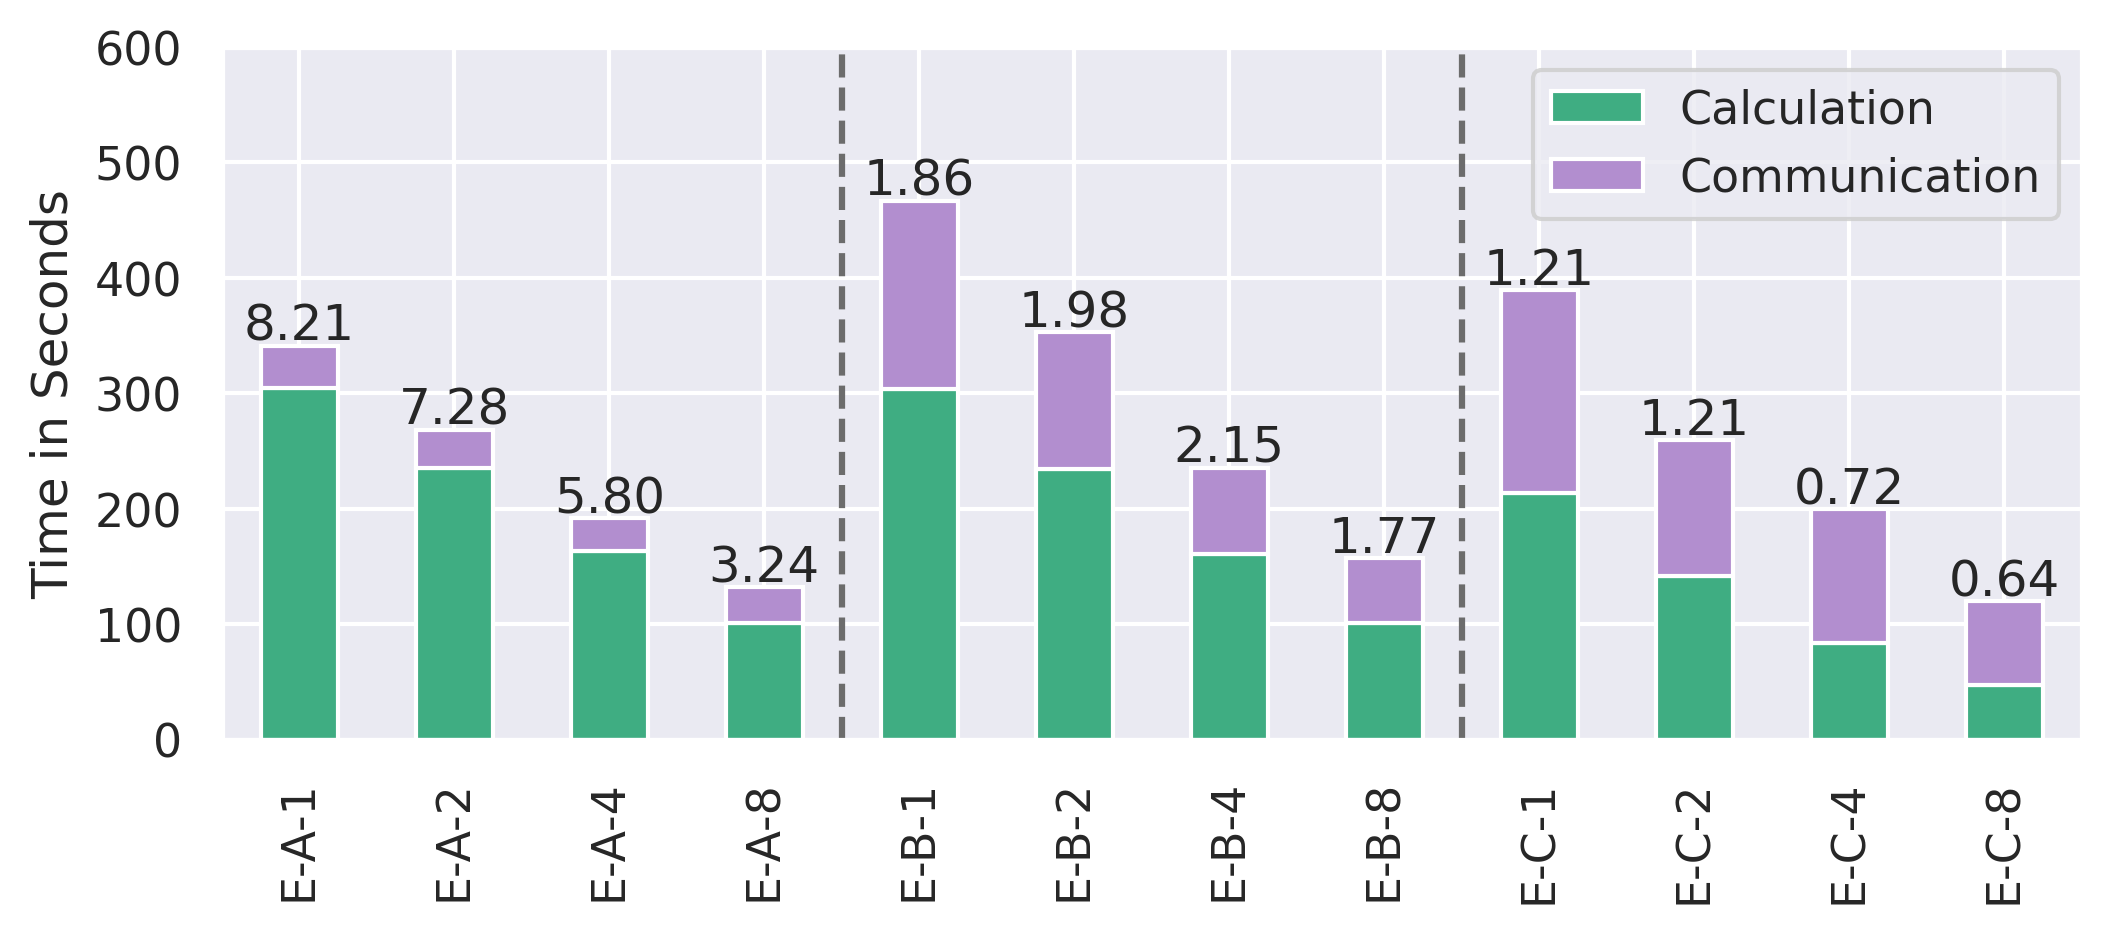

In [86]:
cv_private_cloud_granularity_df = pd.concat(objs=[
    cv_eu_1xt4_rtx8000_gran_df,   
    cv_eu_2xt4_rtx8000_gran_df,   
    cv_eu_4xt4_rtx8000_gran_df,   
    cv_eu_8xt4_rtx8000_gran_df,    
    cv_us_1xt4_rtx8000_gran_df,   
    cv_us_2xt4_rtx8000_gran_df,   
    cv_us_4xt4_rtx8000_gran_df,   
    cv_us_8xt4_rtx8000_gran_df,   
    cv_us_1xa10_rtx8000_gran_df,  
    cv_us_2xa10_rtx8000_gran_df,  
    cv_us_4xa10_rtx8000_gran_df,  
    cv_us_8xa10_rtx8000_gran_df
])

sns.set(palette=granularity_palette)
plt.figure(figsize=(8,3))
ax = cv_private_cloud_granularity_df[["calc_time_s","comm_time_s","name"]].set_index('name').plot(kind='bar', stacked=True, figsize=(8,3))
plt.ylabel("Time in Seconds")
plt.xlabel("")
plt.ylim(0,600)
plt.legend(labels=["Calculation", "Communication"])
ax.axvline(3.5, color="#6c6c6c", linestyle="--")
ax.axvline(7.5, color="#6c6c6c", linestyle="--")
show_granulartiy_values(ax=ax, df=cv_private_cloud_granularity_df)
save_fig("cv-private-cloud-performance-granularity")

<Figure size 2400x900 with 0 Axes>

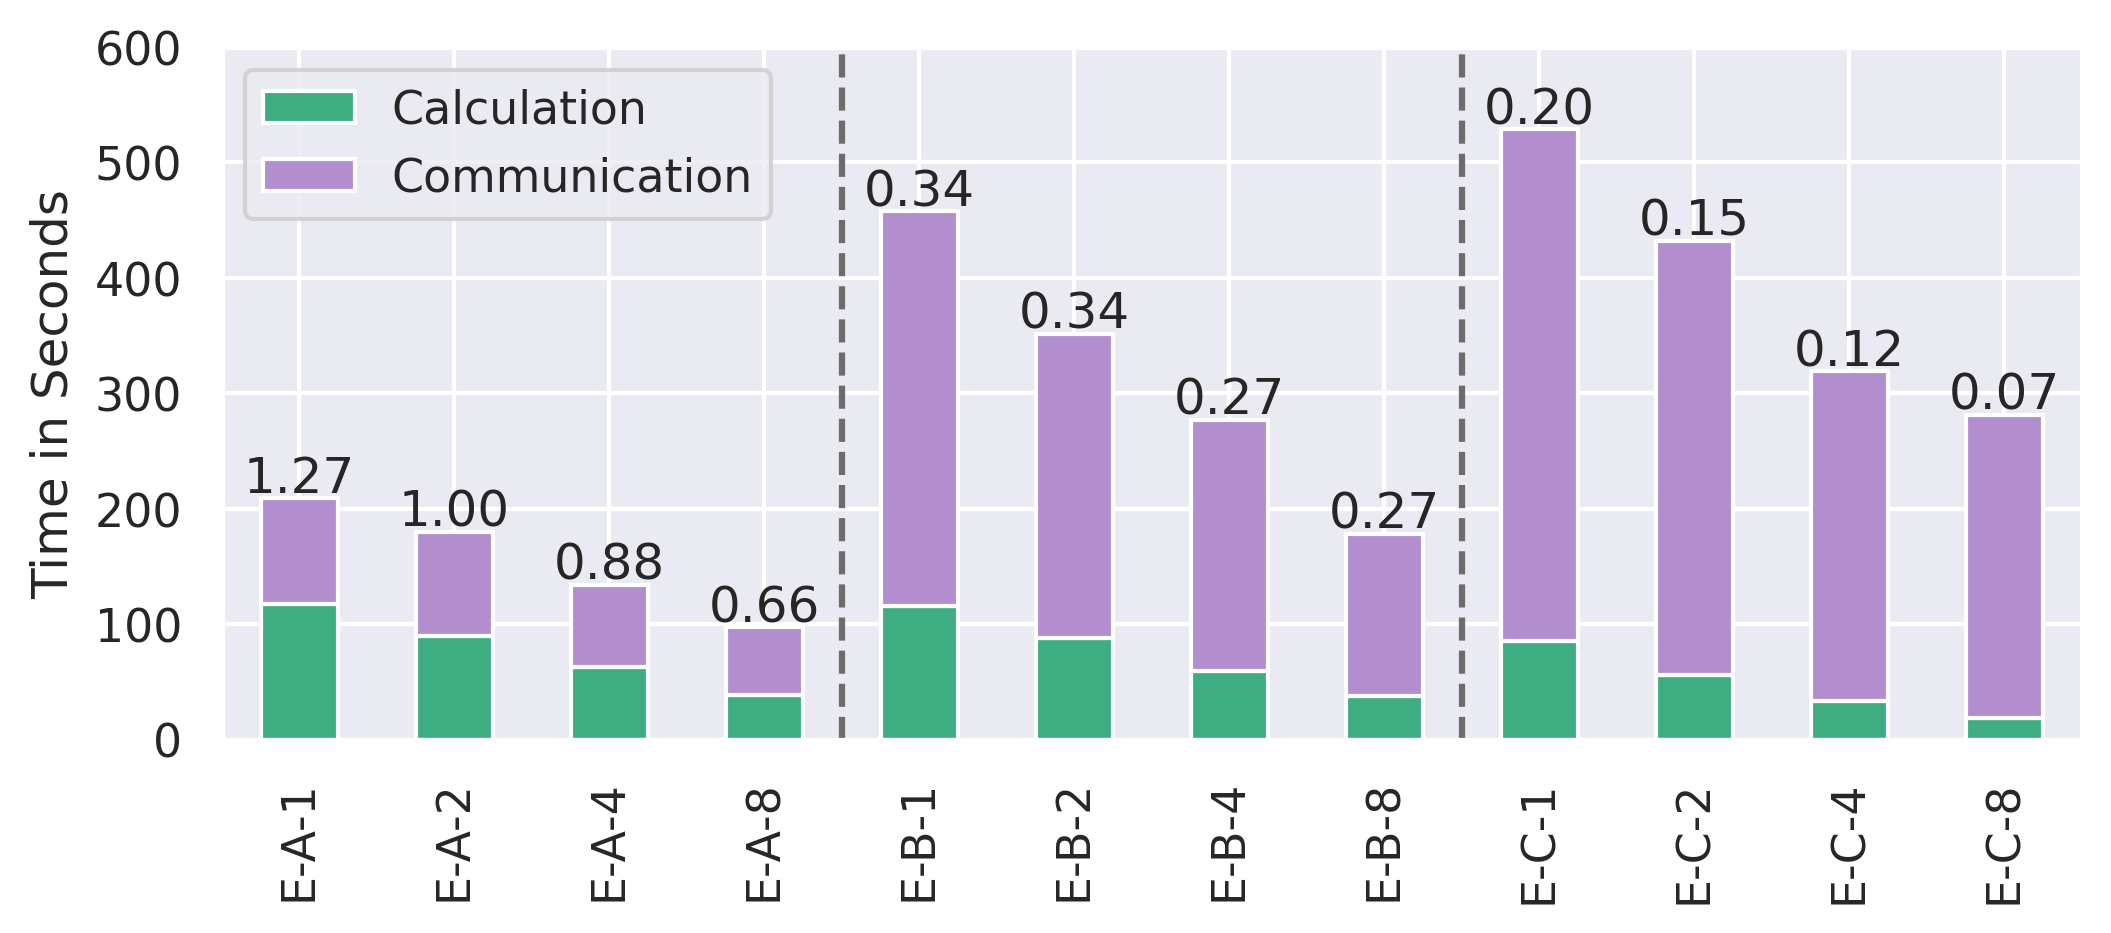

In [87]:
nlp_private_cloud_granularity_df = pd.concat(objs=[  
    nlp_eu_1xt4_rtx8000_gran_df,  
    nlp_eu_2xt4_rtx8000_gran_df,  
    nlp_eu_4xt4_rtx8000_gran_df,  
    nlp_eu_8xt4_rtx8000_gran_df,  
    nlp_us_1xt4_rtx8000_gran_df,  
    nlp_us_2xt4_rtx8000_gran_df,  
    nlp_us_4xt4_rtx8000_gran_df,  
    nlp_us_8xt4_rtx8000_gran_df,  
    nlp_us_1xa10_rtx8000_gran_df, 
    nlp_us_2xa10_rtx8000_gran_df, 
    nlp_us_4xa10_rtx8000_gran_df, 
    nlp_us_8xa10_rtx8000_gran_df, 
])

sns.set(palette=granularity_palette)
plt.figure(figsize=(8,3))
ax = nlp_private_cloud_granularity_df[["calc_time_s","comm_time_s","name"]].set_index('name').plot(kind='bar', stacked=True, figsize=(8,3))
plt.ylabel("Time in Seconds")
plt.xlabel("")
plt.ylim(0,600)
plt.legend(labels=["Calculation", "Communication"])
ax.axvline(3.5, color="#6c6c6c", linestyle="--")
ax.axvline(7.5, color="#6c6c6c", linestyle="--")
show_granulartiy_values(ax=ax, df=nlp_private_cloud_granularity_df)
save_fig("nlp-private-cloud-performance-granularity")
sns.move_legend(ax, "upper left")

### Research Setting

In [88]:
cv_base_v100_df = get_baseline_runs(run_names=["baseline-119-torchvision.models.convnext_large"])
cv_base_v100_df = rename_models(df = cv_base_v100_df)
cv_base_v100_df["gpu_count"] = int(1)
cv_base_v100_df["name"] = "Baseline"
cv_base_v100_df["gpu_type"] = "8xV100"

cv_eu_1xt4_v100_df = get_hivemind_runs(run_names=["hivemind-159"], drop_first_epoch=True)
cv_eu_1xt4_v100_df = rename_models(df = cv_eu_1xt4_v100_df)
cv_eu_1xt4_v100_df["gpu_count"] = int(2)
cv_eu_1xt4_v100_df["name"] = "F-A-1"
cv_eu_1xt4_v100_df["gpu_type"] = "EU T4 (F-A)"

cv_eu_2xt4_v100_df = get_hivemind_runs(run_names=["hivemind-157"], drop_first_epoch=True)
cv_eu_2xt4_v100_df = rename_models(df = cv_eu_2xt4_v100_df)
cv_eu_2xt4_v100_df["gpu_count"] = int(3)
cv_eu_2xt4_v100_df["name"] = "F-A-2"
cv_eu_2xt4_v100_df["gpu_type"] = "EU T4 (F-A)"

cv_eu_4xt4_v100_df = get_hivemind_runs(run_names=["hivemind-155"], drop_first_epoch=True)
cv_eu_4xt4_v100_df = rename_models(df = cv_eu_4xt4_v100_df)
cv_eu_4xt4_v100_df["gpu_count"] = int(5)
cv_eu_4xt4_v100_df["name"] = "F-A-4"
cv_eu_4xt4_v100_df["gpu_type"] = "EU T4 (F-A)"

cv_eu_8xt4_v100_df = get_hivemind_runs(run_names=["hivemind-153"], drop_first_epoch=True)
cv_eu_8xt4_v100_df = rename_models(df = cv_eu_8xt4_v100_df)
cv_eu_8xt4_v100_df["gpu_count"] = int(9)
cv_eu_8xt4_v100_df["name"] = "F-A-8"
cv_eu_8xt4_v100_df["gpu_type"] = "EU T4 (F-A)"

nlp_base_v100_df = get_baseline_runs(run_names=["baseline-120-roberta_mlm_xlm"])
nlp_base_v100_df = rename_models(df = nlp_base_v100_df)
nlp_base_v100_df["gpu_count"] = int(1)
nlp_base_v100_df["name"] = "Baseline"
nlp_base_v100_df["gpu_type"] = "8xV100"

nlp_eu_1xt4_v100_df = get_hivemind_runs(run_names=["hivemind-160"], drop_first_epoch=True)
nlp_eu_1xt4_v100_df = rename_models(df = nlp_eu_1xt4_v100_df)
nlp_eu_1xt4_v100_df["gpu_count"] = int(2)
nlp_eu_1xt4_v100_df["name"] = "F-A-1"
nlp_eu_1xt4_v100_df["gpu_type"] = "EU T4 (F-A)"

nlp_eu_2xt4_v100_df = get_hivemind_runs(run_names=["hivemind-158"], drop_first_epoch=True)
nlp_eu_2xt4_v100_df = rename_models(df = nlp_eu_2xt4_v100_df)
nlp_eu_2xt4_v100_df["gpu_count"] = int(3)
nlp_eu_2xt4_v100_df["name"] = "F-A-2"
nlp_eu_2xt4_v100_df["gpu_type"] = "EU T4 (F-A)"

nlp_eu_4xt4_v100_df = get_hivemind_runs(run_names=["hivemind-156"], drop_first_epoch=True)
nlp_eu_4xt4_v100_df = rename_models(df = nlp_eu_4xt4_v100_df)
nlp_eu_4xt4_v100_df["gpu_count"] = int(5)
nlp_eu_4xt4_v100_df["name"] = "F-A-4"
nlp_eu_4xt4_v100_df["gpu_type"] = "EU T4 (F-A)"

nlp_eu_8xt4_v100_df = get_hivemind_runs(run_names=["hivemind-154"], drop_first_epoch=True)
nlp_eu_8xt4_v100_df = rename_models(df = nlp_eu_8xt4_v100_df)
nlp_eu_8xt4_v100_df["gpu_count"] = int(9)
nlp_eu_8xt4_v100_df["name"] = "F-A-8"
nlp_eu_8xt4_v100_df["gpu_type"] = "EU T4 (F-A)"

> Found 1 runs with the prefix 'trainmonitor'.
> Found 1 runs with the prefix 'trainmonitor'.
> Found 1 runs with the prefix 'trainmonitor'.
> Found 1 runs with the prefix 'trainmonitor'.
> Found 1 runs with the prefix 'trainmonitor'.
> Found 1 runs with the prefix 'trainmonitor'.
> Found 1 runs with the prefix 'trainmonitor'.
> Found 1 runs with the prefix 'trainmonitor'.


In [89]:
v100_eu_runs_df = pd.concat(objs=[
    cv_base_v100_df,
    cv_eu_1xt4_v100_df,
    cv_eu_2xt4_v100_df,
    cv_eu_4xt4_v100_df,
    cv_eu_8xt4_v100_df,
    nlp_base_v100_df,
    nlp_eu_1xt4_v100_df,
    nlp_eu_2xt4_v100_df,
    nlp_eu_4xt4_v100_df,
    nlp_eu_8xt4_v100_df
])

In [90]:
cv_us_1xt4_v100_df = get_hivemind_runs(run_names=["hivemind-133"], drop_first_epoch=True)
cv_us_1xt4_v100_df = rename_models(df = cv_us_1xt4_v100_df)
cv_us_1xt4_v100_df["gpu_count"] = int(2)
cv_us_1xt4_v100_df["name"] = "F-B-1"
cv_us_1xt4_v100_df["gpu_type"] = "US T4 (F-B)"

cv_us_2xt4_v100_df = get_hivemind_runs(run_names=["hivemind-131"], drop_first_epoch=True)
cv_us_2xt4_v100_df = rename_models(df = cv_us_2xt4_v100_df)
cv_us_2xt4_v100_df["gpu_count"] = int(3)
cv_us_2xt4_v100_df["name"] = "F-B-2"
cv_us_2xt4_v100_df["gpu_type"] = "US T4 (F-B)"

cv_us_4xt4_v100_df = get_hivemind_runs(run_names=["hivemind-125"], drop_first_epoch=True)
cv_us_4xt4_v100_df = rename_models(df = cv_us_4xt4_v100_df)
cv_us_4xt4_v100_df["gpu_count"] = int(5)
cv_us_4xt4_v100_df["name"] = "F-B-4"
cv_us_4xt4_v100_df["gpu_type"] = "US T4 (F-B)"

cv_us_8xt4_v100_df = get_hivemind_runs(run_names=["hivemind-123"], drop_first_epoch=True)
cv_us_8xt4_v100_df = rename_models(df = cv_us_8xt4_v100_df)
cv_us_8xt4_v100_df["gpu_count"] = int(9)
cv_us_8xt4_v100_df["name"] = "F-B-8"
cv_us_8xt4_v100_df["gpu_type"] = "US T4 (F-B)"

nlp_us_1xt4_v100_df = get_hivemind_runs(run_names=["hivemind-134"], drop_first_epoch=True)
nlp_us_1xt4_v100_df = rename_models(df = nlp_us_1xt4_v100_df)
nlp_us_1xt4_v100_df["gpu_count"] = int(2)
nlp_us_1xt4_v100_df["name"] = "F-B-1"
nlp_us_1xt4_v100_df["gpu_type"] = "US T4 (F-B)"

nlp_us_2xt4_v100_df = get_hivemind_runs(run_names=["hivemind-132"], drop_first_epoch=True)
nlp_us_2xt4_v100_df = rename_models(df = nlp_us_2xt4_v100_df)
nlp_us_2xt4_v100_df["gpu_count"] = int(3)
nlp_us_2xt4_v100_df["name"] = "F-B-2"
nlp_us_2xt4_v100_df["gpu_type"] = "US T4 (F-B)"

nlp_us_4xt4_v100_df = get_hivemind_runs(run_names=["hivemind-126"], drop_first_epoch=True)
nlp_us_4xt4_v100_df = rename_models(df = nlp_us_4xt4_v100_df)
nlp_us_4xt4_v100_df["gpu_count"] = int(5)
nlp_us_4xt4_v100_df["name"] = "F-B-4"
nlp_us_4xt4_v100_df["gpu_type"] = "US T4 (F-B)"

nlp_us_8xt4_v100_df = get_hivemind_runs(run_names=["hivemind-124"], drop_first_epoch=True)
nlp_us_8xt4_v100_df = rename_models(df = nlp_us_8xt4_v100_df)
nlp_us_8xt4_v100_df["gpu_count"] = int(9)
nlp_us_8xt4_v100_df["name"] = "F-B-8"
nlp_us_8xt4_v100_df["gpu_type"] = "US T4 (F-B)"

> Found 1 runs with the prefix 'trainmonitor'.
> Found 1 runs with the prefix 'trainmonitor'.
> Found 1 runs with the prefix 'trainmonitor'.
> Found 1 runs with the prefix 'trainmonitor'.
> Found 1 runs with the prefix 'trainmonitor'.
> Found 1 runs with the prefix 'trainmonitor'.
> Found 1 runs with the prefix 'trainmonitor'.
> Found 1 runs with the prefix 'trainmonitor'.


In [91]:
v100_us_runs_df = pd.concat(objs=[
    cv_us_1xt4_v100_df,
    cv_us_2xt4_v100_df,
    cv_us_4xt4_v100_df,
    cv_us_8xt4_v100_df,
    nlp_us_1xt4_v100_df,
    nlp_us_2xt4_v100_df,
    nlp_us_4xt4_v100_df,
    nlp_us_8xt4_v100_df
])

In [92]:
cv_us_1xa10_v100_df = get_hivemind_runs(run_names=["hivemind-149"], drop_first_epoch=True)
cv_us_1xa10_v100_df = rename_models(df = cv_us_1xa10_v100_df)
cv_us_1xa10_v100_df["gpu_count"] = int(2)
cv_us_1xa10_v100_df["gpu_type"] = "US A10 (F-C)"
cv_us_1xa10_v100_df["name"] = "F-C-1"

cv_us_2xa10_v100_df = get_hivemind_runs(run_names=["hivemind-145"], drop_first_epoch=True)
cv_us_2xa10_v100_df = rename_models(df = cv_us_2xa10_v100_df)
cv_us_2xa10_v100_df["gpu_count"] = int(3)
cv_us_2xa10_v100_df["gpu_type"] = "US A10 (F-C)"
cv_us_2xa10_v100_df["name"] = "F-C-2"

cv_us_4xa10_v100_df = get_hivemind_runs(run_names=["hivemind-141"], drop_first_epoch=True)
cv_us_4xa10_v100_df = rename_models(df = cv_us_4xa10_v100_df)
cv_us_4xa10_v100_df["gpu_count"] = int(5)
cv_us_4xa10_v100_df["gpu_type"] = "US A10 (F-C)"
cv_us_4xa10_v100_df["name"] = "F-C-4"

cv_us_8xa10_v100_df = get_hivemind_runs(run_names=["hivemind-137"], drop_first_epoch=True)
cv_us_8xa10_v100_df = rename_models(df = cv_us_8xa10_v100_df)
cv_us_8xa10_v100_df["gpu_count"] = int(9)
cv_us_8xa10_v100_df["gpu_type"] = "US A10 (F-C)"
cv_us_8xa10_v100_df["name"] = "F-C-8"

nlp_us_1xa10_v100_df = get_hivemind_runs(run_names=["hivemind-150"], drop_first_epoch=True)
nlp_us_1xa10_v100_df = rename_models(df = nlp_us_1xa10_v100_df)
nlp_us_1xa10_v100_df["gpu_count"] = int(2)
nlp_us_1xa10_v100_df["gpu_type"] = "US A10 (F-C)"
nlp_us_1xa10_v100_df["name"] = "F-C-1"

nlp_us_2xa10_v100_df = get_hivemind_runs(run_names=["hivemind-146"], drop_first_epoch=True)
nlp_us_2xa10_v100_df = rename_models(df = nlp_us_2xa10_v100_df)
nlp_us_2xa10_v100_df["gpu_count"] = int(3)
nlp_us_2xa10_v100_df["gpu_type"] = "US A10 (F-C)"
nlp_us_2xa10_v100_df["name"] = "F-C-2"

nlp_us_4xa10_v100_df = get_hivemind_runs(run_names=["hivemind-142"], drop_first_epoch=True)
nlp_us_4xa10_v100_df = rename_models(df = nlp_us_4xa10_v100_df)
nlp_us_4xa10_v100_df["gpu_count"] = int(5)
nlp_us_4xa10_v100_df["gpu_type"] = "US A10 (F-C)"
nlp_us_4xa10_v100_df["name"] = "F-C-4"

nlp_us_8xa10_v100_df = get_hivemind_runs(run_names=["hivemind-138"], drop_first_epoch=True)
nlp_us_8xa10_v100_df = rename_models(df = nlp_us_8xa10_v100_df)
nlp_us_8xa10_v100_df["gpu_count"] = int(9)
nlp_us_8xa10_v100_df["gpu_type"] = "US A10 (F-C)"
nlp_us_8xa10_v100_df["name"] = "F-C-8"

> Found 1 runs with the prefix 'trainmonitor'.
> Found 1 runs with the prefix 'trainmonitor'.
> Found 1 runs with the prefix 'trainmonitor'.
> Found 1 runs with the prefix 'trainmonitor'.
> Found 1 runs with the prefix 'trainmonitor'.
> Found 1 runs with the prefix 'trainmonitor'.
> Found 1 runs with the prefix 'trainmonitor'.
> Found 1 runs with the prefix 'trainmonitor'.


In [93]:
v100_us_a10_runs_df = pd.concat(objs=[
    cv_us_1xa10_v100_df,
    cv_us_2xa10_v100_df,
    cv_us_4xa10_v100_df,
    cv_us_8xa10_v100_df,
    nlp_us_1xa10_v100_df,
    nlp_us_2xa10_v100_df,
    nlp_us_4xa10_v100_df,
    nlp_us_8xa10_v100_df
])

In [94]:
v100_all_runs_df = pd.concat(objs=[v100_eu_runs_df, v100_us_runs_df, v100_us_a10_runs_df])

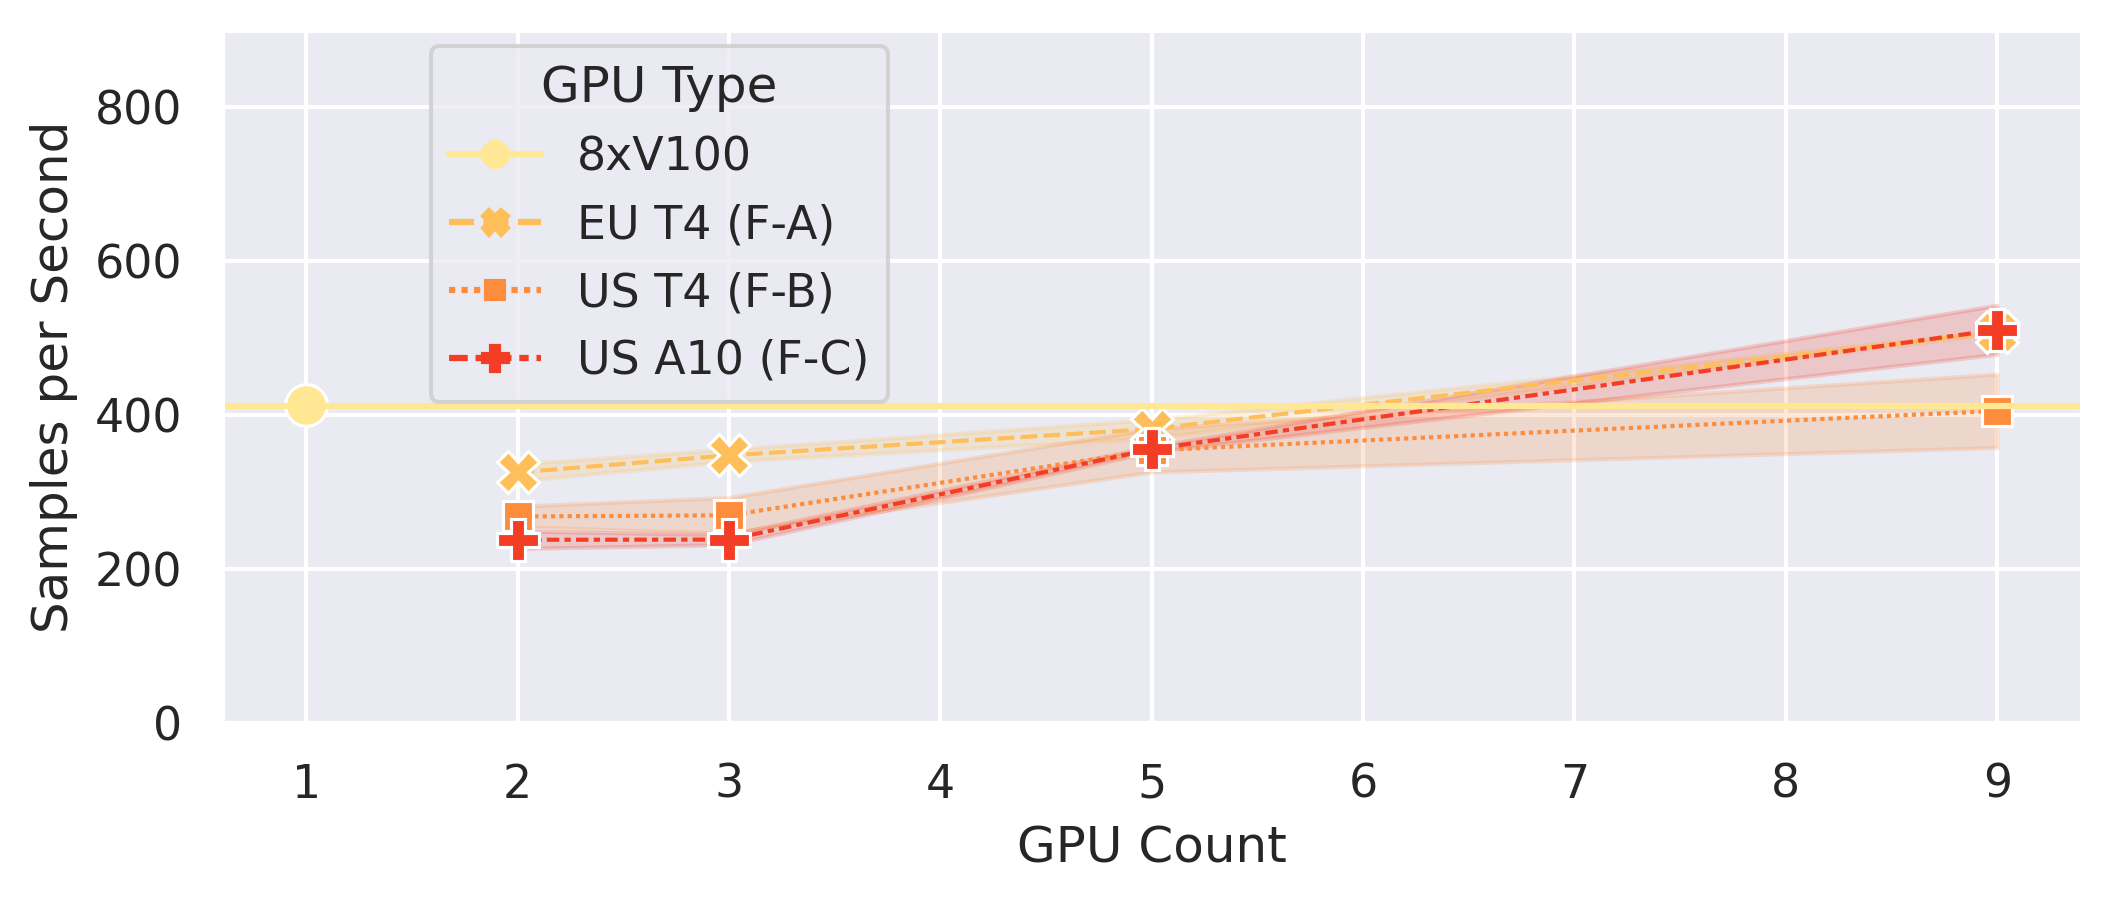

In [95]:
# filter local sps out
temp_df = v100_all_runs_df.query("samples_per_sec.notna()")
temp_df = temp_df.query("model=='ConvNextLarge'")

sns.set(palette=cv_palette)
plt.figure(figsize=(8,3))
ax = sns.lineplot(
    data=temp_df,
    x="gpu_count", y="samples_per_sec", hue="gpu_type", style="gpu_type",
    errorbar=('se', 1), dashes=True,
    markers=True,
    linewidth=1.0,
    markersize=10.0
)
#plt.title("Research Setting")
plt.xlabel("GPU Count")
plt.ylim(0,900)
plt.ylabel("Samples per Second")
plt.legend(title="GPU Type")
ax.axhline(412, color="#ffe793", linestyle="-")
#plt.xlim(0,10)
sns.move_legend(ax, "upper left", bbox_to_anchor=(0.1, 1.01))
save_fig("cv-research-setting-performance")

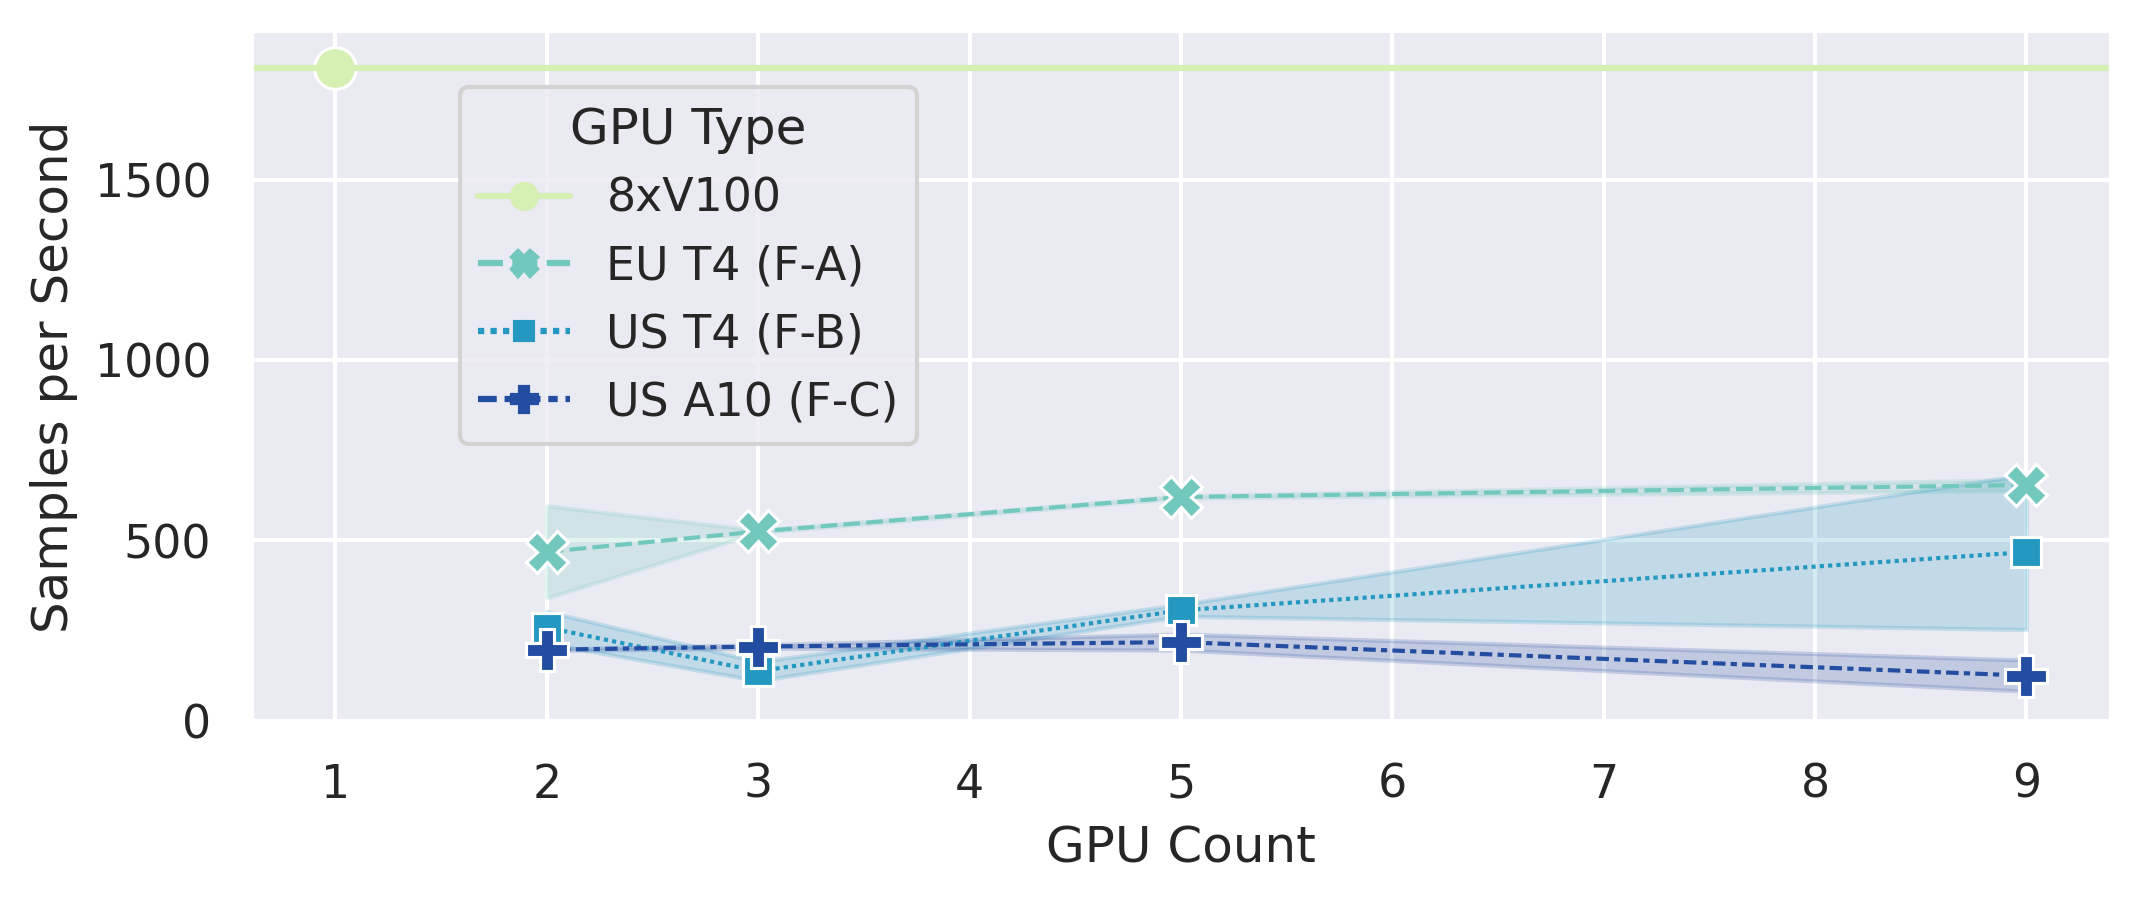

In [96]:
# filter local sps out
temp_df = v100_all_runs_df.query("samples_per_sec.notna()")
# only show NLP
temp_df = temp_df.query("model=='RoBERTaXLM'")

sns.set(palette=nlp_ext_palette)
plt.figure(figsize=(8,3))
ax = sns.lineplot(
    data=temp_df,
    x="gpu_count", y="samples_per_sec", hue="gpu_type", style="gpu_type",
    errorbar=('se', 1), dashes=True,
    markers=True,
    linewidth=1.0,
    markersize=10.0
)
#plt.title("Research Setting")
plt.xlabel("GPU Count")
plt.ylabel("Samples per Second")
#plt.ylim(0,600)
#plt.xlim(0,10)
plt.legend(title="GPU Type")
ax.axhline(1812, color="#d6efb3", linestyle="-")
sns.move_legend(ax, "upper left", bbox_to_anchor=(0.1, 0.95))
save_fig("nlp-research-setting-performance")

In [97]:
def get_mean_throughput(model, gpu_count, df, gpu_type):
    TBS = 32768
    temp_df = df.query(f"samples_per_sec.notna() and TBS=={TBS} and model=='{model}' and gpu_count=={gpu_count} and gpu_type=='{gpu_type}'")
    return temp_df["samples_per_sec"].mean()

for model in v100_all_runs_df["model"].unique():
    for gpu_type in ["EU T4 (F-A)", "US T4 (F-B)", "US A10 (F-C)"]:
        print(f"Model: {model}, Type: {gpu_type}")
        baseline_sps = get_mean_throughput(model=model, gpu_count=1, df=v100_all_runs_df, gpu_type="8xV100")
        print(f"   1 GPU, SPS: {round(baseline_sps,2):>6}")
        for gpu_count in [2,3,5,9]:
            sps = get_mean_throughput(model=model, gpu_count=gpu_count, df=v100_all_runs_df, gpu_type=gpu_type)
            norm_sps = sps / gpu_count
            speedup = sps / baseline_sps
            norm_speedup = speedup / gpu_count
            
            print(f"  {gpu_count} GPUs, SPS: {round(sps,2):>6}, Norm SPS: {round(norm_sps,2):>6}, Speedup: {round(speedup,2):>6}, Norm Speedup: {round(norm_speedup,2):>6}")

Model: ConvNextLarge, Type: EU T4 (F-A)
   1 GPU, SPS: 413.07
  2 GPUs, SPS: 325.15, Norm SPS: 162.58, Speedup:   0.79, Norm Speedup:   0.39
  3 GPUs, SPS: 347.28, Norm SPS: 115.76, Speedup:   0.84, Norm Speedup:   0.28
  5 GPUs, SPS: 381.51, Norm SPS:   76.3, Speedup:   0.92, Norm Speedup:   0.18
  9 GPUs, SPS: 507.39, Norm SPS:  56.38, Speedup:   1.23, Norm Speedup:   0.14
Model: ConvNextLarge, Type: US T4 (F-B)
   1 GPU, SPS: 413.07
  2 GPUs, SPS: 267.86, Norm SPS: 133.93, Speedup:   0.65, Norm Speedup:   0.32
  3 GPUs, SPS: 269.44, Norm SPS:  89.81, Speedup:   0.65, Norm Speedup:   0.22
  5 GPUs, SPS: 353.73, Norm SPS:  70.75, Speedup:   0.86, Norm Speedup:   0.17
  9 GPUs, SPS: 405.11, Norm SPS:  45.01, Speedup:   0.98, Norm Speedup:   0.11
Model: ConvNextLarge, Type: US A10 (F-C)
   1 GPU, SPS: 413.07
  2 GPUs, SPS: 237.64, Norm SPS: 118.82, Speedup:   0.58, Norm Speedup:   0.29
  3 GPUs, SPS: 237.87, Norm SPS:  79.29, Speedup:   0.58, Norm Speedup:   0.19
  5 GPUs, SPS: 355.32, 

In [98]:
debug = False
cv_eu_1xt4_v100_gran_df   = get_granularity_cumulated(run_name="hivemind-159", name="F-A-1", debug=debug)
cv_eu_2xt4_v100_gran_df   = get_granularity_cumulated(run_name="hivemind-157", name="F-A-2", debug=debug)
cv_eu_4xt4_v100_gran_df   = get_granularity_cumulated(run_name="hivemind-155", name="F-A-4", debug=debug)
cv_eu_8xt4_v100_gran_df   = get_granularity_cumulated(run_name="hivemind-153", name="F-A-8", debug=debug)
nlp_eu_1xt4_v100_gran_df  = get_granularity_cumulated(run_name="hivemind-160", name="F-A-1", debug=debug)
nlp_eu_2xt4_v100_gran_df  = get_granularity_cumulated(run_name="hivemind-158", name="F-A-2", debug=debug)
nlp_eu_4xt4_v100_gran_df  = get_granularity_cumulated(run_name="hivemind-156", name="F-A-4", debug=debug)
nlp_eu_8xt4_v100_gran_df  = get_granularity_cumulated(run_name="hivemind-154", name="F-A-8", debug=debug)
cv_us_1xt4_v100_gran_df   = get_granularity_cumulated(run_name="hivemind-133", name="F-B-1", debug=debug)
cv_us_2xt4_v100_gran_df   = get_granularity_cumulated(run_name="hivemind-131", name="F-B-2", debug=debug)
cv_us_4xt4_v100_gran_df   = get_granularity_cumulated(run_name="hivemind-125", name="F-B-4", debug=debug)
cv_us_8xt4_v100_gran_df   = get_granularity_cumulated(run_name="hivemind-123", name="F-B-8", debug=debug)
nlp_us_1xt4_v100_gran_df  = get_granularity_cumulated(run_name="hivemind-134", name="F-B-1", debug=debug)
nlp_us_2xt4_v100_gran_df  = get_granularity_cumulated(run_name="hivemind-132", name="F-B-2", debug=debug)
nlp_us_4xt4_v100_gran_df  = get_granularity_cumulated(run_name="hivemind-126", name="F-B-4", debug=debug)
nlp_us_8xt4_v100_gran_df  = get_granularity_cumulated(run_name="hivemind-124", name="F-B-8", debug=debug)
cv_us_1xa10_v100_gran_df  = get_granularity_cumulated(run_name="hivemind-149", name="F-C-1", debug=debug)
cv_us_2xa10_v100_gran_df  = get_granularity_cumulated(run_name="hivemind-145", name="F-C-2", debug=debug)
cv_us_4xa10_v100_gran_df  = get_granularity_cumulated(run_name="hivemind-141", name="F-C-4", debug=debug)
cv_us_8xa10_v100_gran_df  = get_granularity_cumulated(run_name="hivemind-137", name="F-C-8", debug=debug)
nlp_us_1xa10_v100_gran_df = get_granularity_cumulated(run_name="hivemind-150", name="F-C-1", debug=debug)
nlp_us_2xa10_v100_gran_df = get_granularity_cumulated(run_name="hivemind-146", name="F-C-2", debug=debug)
nlp_us_4xa10_v100_gran_df = get_granularity_cumulated(run_name="hivemind-142", name="F-C-4", debug=debug)
nlp_us_8xa10_v100_gran_df = get_granularity_cumulated(run_name="hivemind-138", name="F-C-8", debug=debug)

> Found 2 runs with the infix 'bee'.
> Found 3 runs with the infix 'bee'.
> Found 5 runs with the infix 'bee'.
> Found 9 runs with the infix 'bee'.
> Found 2 runs with the infix 'bee'.
> Found 3 runs with the infix 'bee'.
> Found 5 runs with the infix 'bee'.
> Found 9 runs with the infix 'bee'.
> Found 2 runs with the infix 'bee'.
> Found 3 runs with the infix 'bee'.
> Found 5 runs with the infix 'bee'.
> Found 9 runs with the infix 'bee'.
> Found 2 runs with the infix 'bee'.
> Found 3 runs with the infix 'bee'.
> Found 5 runs with the infix 'bee'.
> Found 9 runs with the infix 'bee'.
> Found 2 runs with the infix 'bee'.
> Found 3 runs with the infix 'bee'.
> Found 5 runs with the infix 'bee'.
> Found 9 runs with the infix 'bee'.
> Found 2 runs with the infix 'bee'.
> Found 3 runs with the infix 'bee'.
> Found 5 runs with the infix 'bee'.
> Found 9 runs with the infix 'bee'.


<Figure size 2400x900 with 0 Axes>

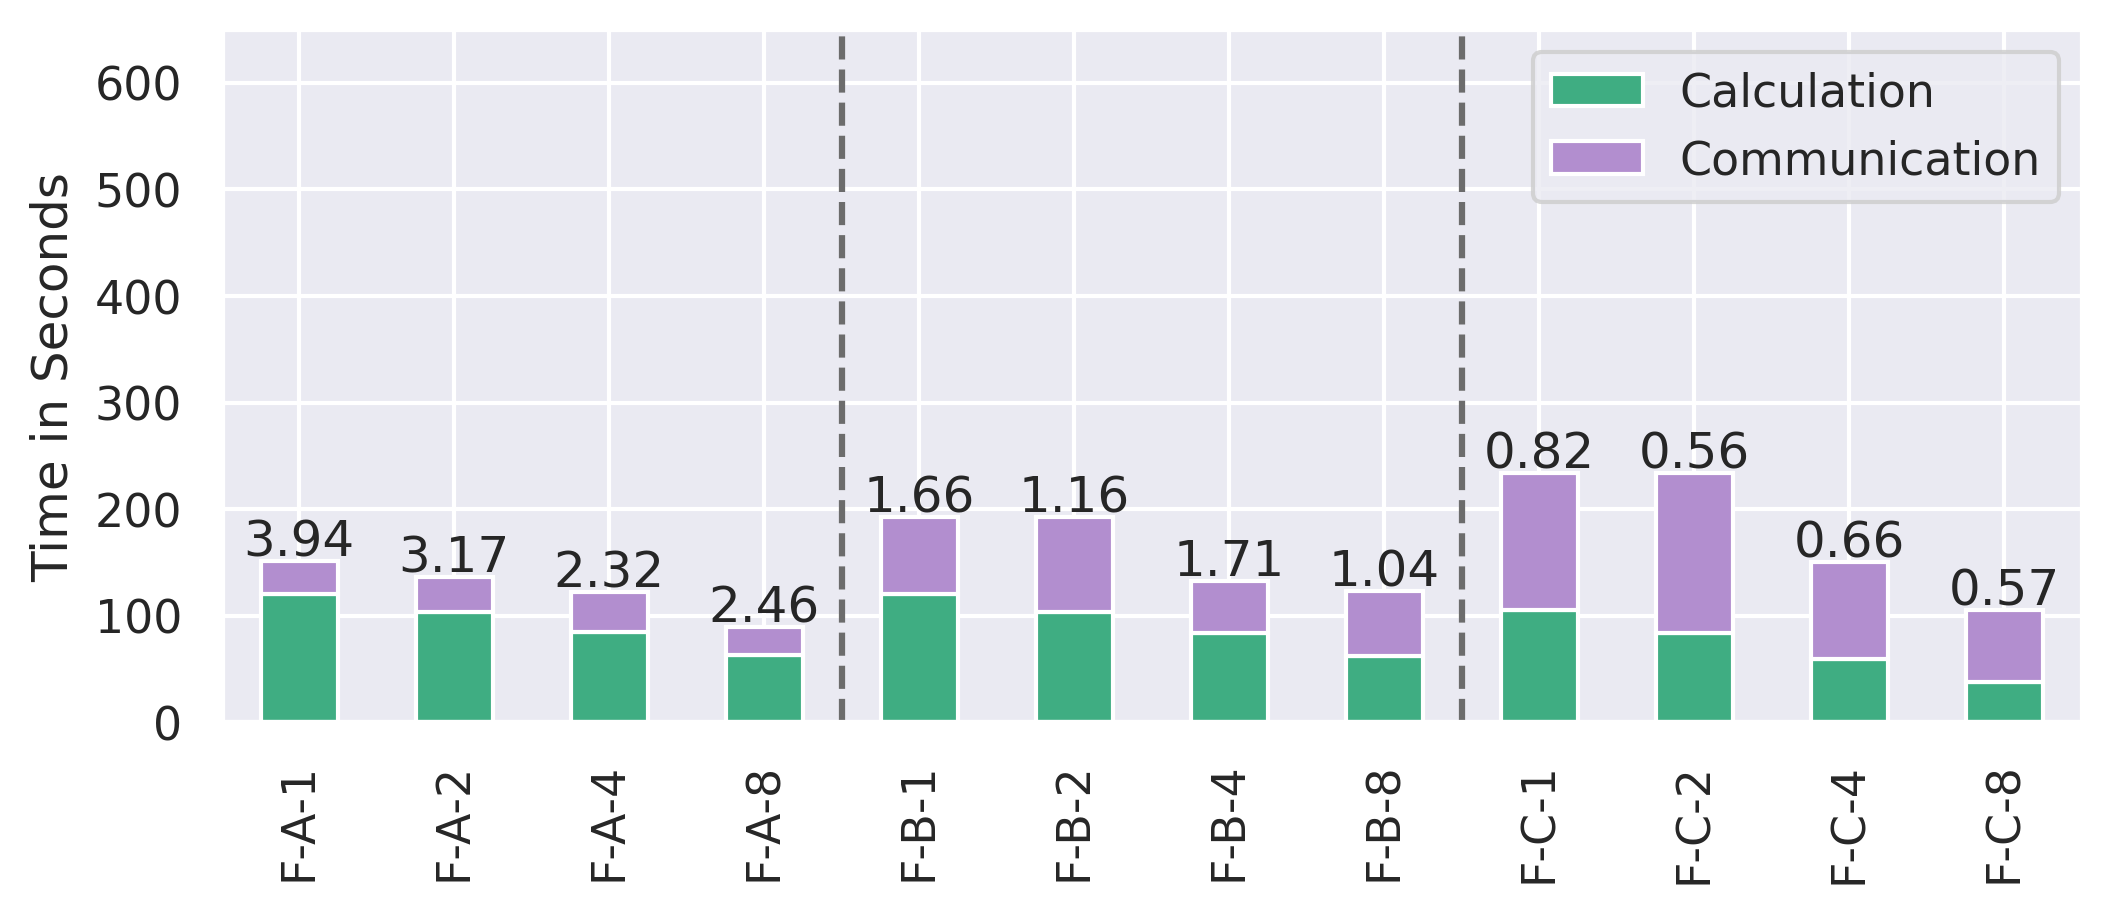

In [99]:
cv_research_cloud_granularity_df = pd.concat(objs=[
    cv_eu_1xt4_v100_gran_df,
    cv_eu_2xt4_v100_gran_df,
    cv_eu_4xt4_v100_gran_df,
    cv_eu_8xt4_v100_gran_df,
    cv_us_1xt4_v100_gran_df,
    cv_us_2xt4_v100_gran_df,
    cv_us_4xt4_v100_gran_df,
    cv_us_8xt4_v100_gran_df,
    cv_us_1xa10_v100_gran_df,
    cv_us_2xa10_v100_gran_df,
    cv_us_4xa10_v100_gran_df,
    cv_us_8xa10_v100_gran_df
])

sns.set(palette=granularity_palette)
plt.figure(figsize=(8,3))
ax = cv_research_cloud_granularity_df[["calc_time_s","comm_time_s","name"]].set_index('name').plot(kind='bar', stacked=True, figsize=(8,3))
plt.ylabel("Time in Seconds")
plt.xlabel("")
plt.ylim(0,650)
plt.legend(labels=["Calculation", "Communication"])
ax.axvline(3.5, color="#6c6c6c", linestyle="--")
ax.axvline(7.5, color="#6c6c6c", linestyle="--")
show_granulartiy_values(ax=ax, df=cv_research_cloud_granularity_df)
save_fig("cv-research-cloud-performance-granularity")

<Figure size 2400x900 with 0 Axes>

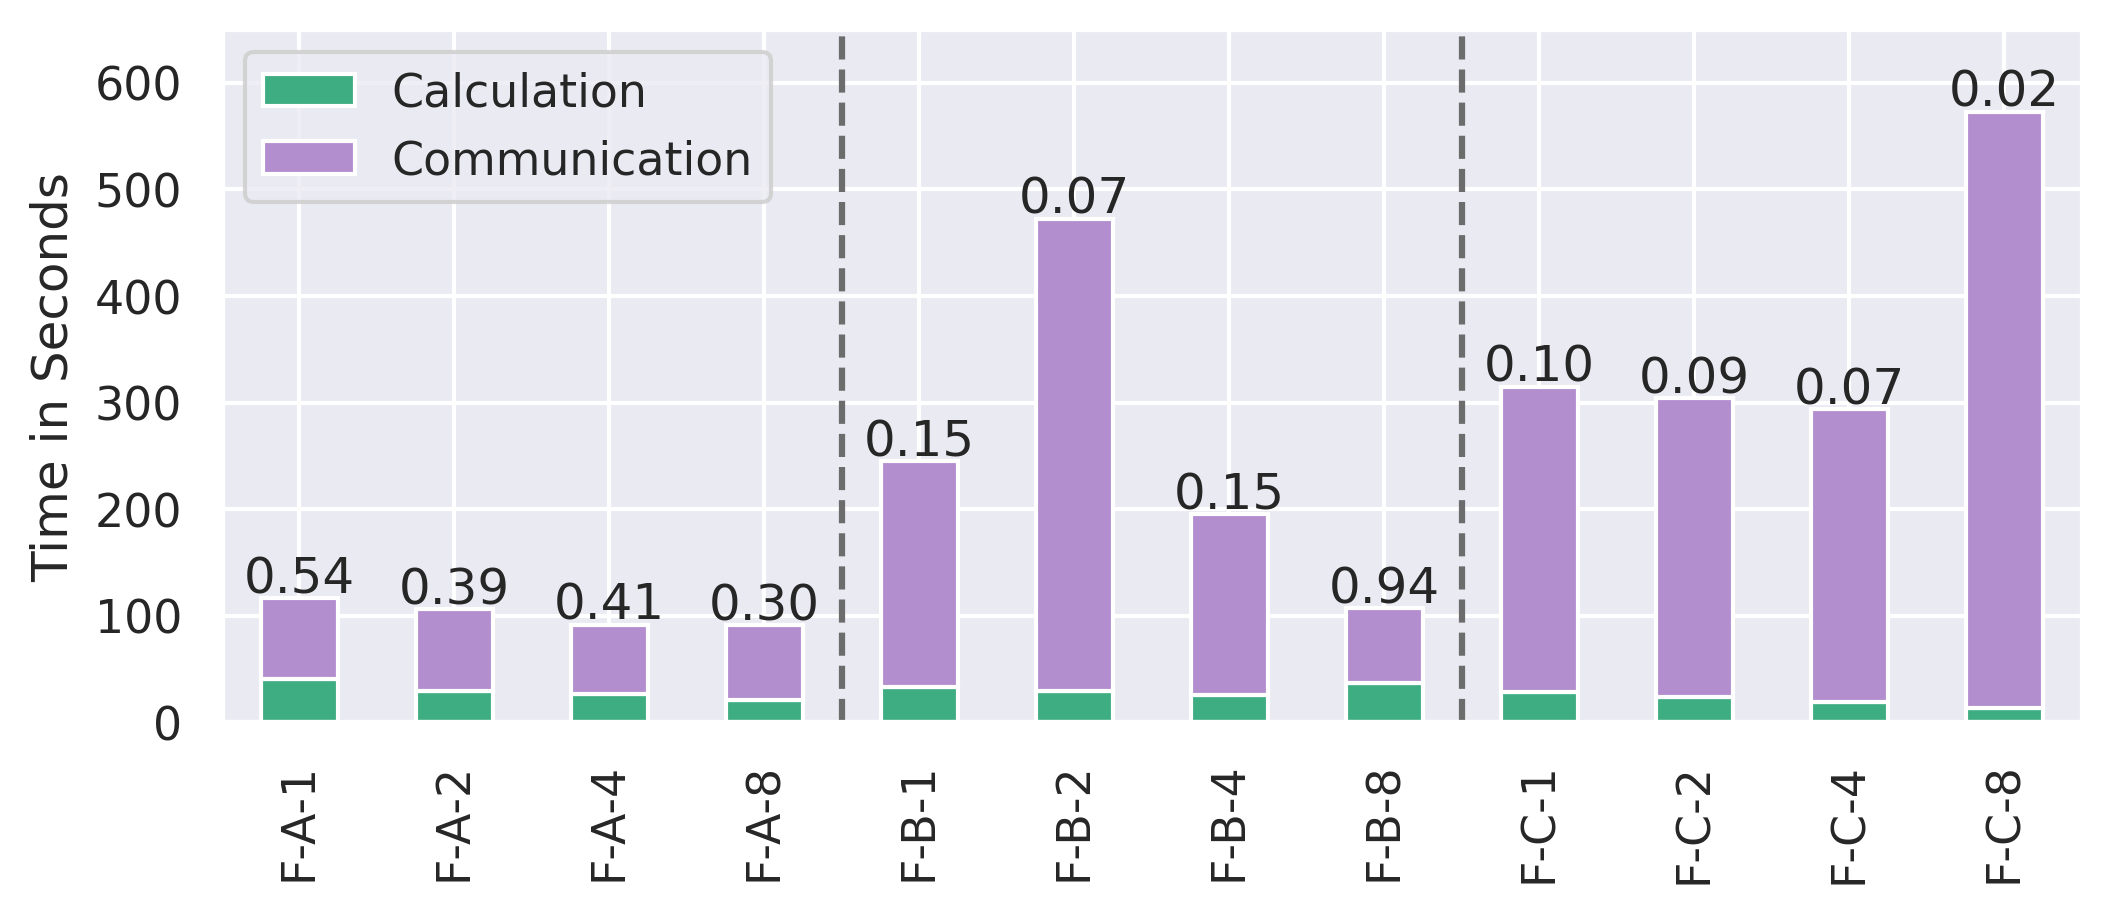

In [100]:
nlp_research_cloud_granularity_df = pd.concat(objs=[
    nlp_eu_1xt4_v100_gran_df,
    nlp_eu_2xt4_v100_gran_df,
    nlp_eu_4xt4_v100_gran_df,
    nlp_eu_8xt4_v100_gran_df,
    nlp_us_1xt4_v100_gran_df,
    nlp_us_2xt4_v100_gran_df,
    nlp_us_4xt4_v100_gran_df,
    nlp_us_8xt4_v100_gran_df,
    nlp_us_1xa10_v100_gran_df,
    nlp_us_2xa10_v100_gran_df,
    nlp_us_4xa10_v100_gran_df,
    nlp_us_8xa10_v100_gran_df,
])

sns.set(palette=granularity_palette)
plt.figure(figsize=(8,3))
ax = nlp_research_cloud_granularity_df[["calc_time_s","comm_time_s","name"]].set_index('name').plot(kind='bar', stacked=True, figsize=(8,3))
plt.ylabel("Time in Seconds")
plt.xlabel("")
plt.ylim(0,650)
plt.legend(labels=["Calculation", "Communication"])
ax.axvline(3.5, color="#6c6c6c", linestyle="--")
ax.axvline(7.5, color="#6c6c6c", linestyle="--")
show_granulartiy_values(ax=ax, df=nlp_research_cloud_granularity_df)
save_fig("nlp-research-cloud-performance-granularity")

## 99. Whisper Example

### TB = 256

In [5]:
asr_tiny_1xt4_df = get_baseline_runs(run_names=["baseline-362-whisper-tiny"])
asr_tiny_1xt4_df = rename_models(df = asr_tiny_1xt4_df)
asr_tiny_1xt4_df["gpu_count"] = int(1)
asr_tiny_1xt4_df["name"] = "G-1.0"
asr_tiny_1xt4_df["gpu_type"] = "T4"

asr_tiny_2xt4_df = get_hivemind_runs(run_names=["hivemind-375"], drop_first_epoch=True)
asr_tiny_2xt4_df = rename_models(df = asr_tiny_2xt4_df)
asr_tiny_2xt4_df["gpu_count"] = int(2)
asr_tiny_2xt4_df["name"] = "G-1.1"
asr_tiny_2xt4_df["gpu_type"] = "T4"

asr_tiny_4xt4_df = get_hivemind_runs(run_names=["hivemind-372"], drop_first_epoch=True)
asr_tiny_4xt4_df = rename_models(df = asr_tiny_4xt4_df)
asr_tiny_4xt4_df["gpu_count"] = int(4)
asr_tiny_4xt4_df["name"] = "G-1.2"
asr_tiny_4xt4_df["gpu_type"] = "T4"

asr_tiny_8xt4_df = get_hivemind_runs(run_names=["hivemind-369"], drop_first_epoch=True)
asr_tiny_8xt4_df = rename_models(df = asr_tiny_8xt4_df)
asr_tiny_8xt4_df["gpu_count"] = int(8)
asr_tiny_8xt4_df["name"] = "G-1.3"
asr_tiny_8xt4_df["gpu_type"] = "T4"

asr_tiny_df = pd.concat(objs=[
    asr_tiny_1xt4_df,
    asr_tiny_2xt4_df,
    asr_tiny_4xt4_df,
    asr_tiny_8xt4_df
])

asr_base_1xt4_df = get_baseline_runs(run_names=["baseline-364-whisper-base"])
asr_base_1xt4_df = rename_models(df = asr_base_1xt4_df)
asr_base_1xt4_df["gpu_count"] = int(1)
asr_base_1xt4_df["name"] = "G-2.0"
asr_base_1xt4_df["gpu_type"] = "T4"

asr_base_2xt4_df = get_hivemind_runs(run_names=["hivemind-376"], drop_first_epoch=True)
asr_base_2xt4_df = rename_models(df = asr_base_2xt4_df)
asr_base_2xt4_df["gpu_count"] = int(2)
asr_base_2xt4_df["name"] = "G-2.1"
asr_base_2xt4_df["gpu_type"] = "T4"

asr_base_4xt4_df = get_hivemind_runs(run_names=["hivemind-373"], drop_first_epoch=True)
asr_base_4xt4_df = rename_models(df = asr_base_4xt4_df)
asr_base_4xt4_df["gpu_count"] = int(4)
asr_base_4xt4_df["name"] = "G-2.2"
asr_base_4xt4_df["gpu_type"] = "T4"

asr_base_8xt4_df = get_hivemind_runs(run_names=["hivemind-370"], drop_first_epoch=True)
asr_base_8xt4_df = rename_models(df = asr_base_8xt4_df)
asr_base_8xt4_df["gpu_count"] = int(8)
asr_base_8xt4_df["name"] = "G-2.3"
asr_base_8xt4_df["gpu_type"] = "T4"

asr_base_df = pd.concat(objs=[
    asr_base_1xt4_df,
    asr_base_2xt4_df,
    asr_base_4xt4_df,
    asr_base_8xt4_df
])


asr_small_1xt4_df = get_baseline_runs(run_names=["baseline-365-whisper-small"])
asr_small_1xt4_df = rename_models(df = asr_small_1xt4_df)
asr_small_1xt4_df["gpu_count"] = int(1)
asr_small_1xt4_df["name"] = "G-3.0"
asr_small_1xt4_df["gpu_type"] = "T4"
asr_small_1xt4_df["TBS"] = 256 # 255 in reality, but rounded in favor of baseline for comparison reasons 

asr_small_2xt4_df = get_hivemind_runs(run_names=["hivemind-377"], drop_first_epoch=True)
asr_small_2xt4_df = rename_models(df = asr_small_2xt4_df)
asr_small_2xt4_df["gpu_count"] = int(2)
asr_small_2xt4_df["name"] = "G-3.1"
asr_small_2xt4_df["gpu_type"] = "T4"

asr_small_4xt4_df = get_hivemind_runs(run_names=["hivemind-374"], drop_first_epoch=True)
asr_small_4xt4_df = rename_models(df = asr_small_4xt4_df)
asr_small_4xt4_df["gpu_count"] = int(4)
asr_small_4xt4_df["name"] = "G-3.2"
asr_small_4xt4_df["gpu_type"] = "T4"

asr_small_8xt4_df = get_hivemind_runs(run_names=["hivemind-371"], drop_first_epoch=True)
asr_small_8xt4_df = rename_models(df = asr_small_8xt4_df)
asr_small_8xt4_df["gpu_count"] = int(8)
asr_small_8xt4_df["name"] = "G-3.3"
asr_small_8xt4_df["gpu_type"] = "T4"

asr_small_df = pd.concat(objs=[
    asr_small_1xt4_df,
    asr_small_2xt4_df,
    asr_small_4xt4_df,
    asr_small_8xt4_df
])

asr_full_df = pd.concat(objs=[
    asr_tiny_df,
    asr_base_df,
    asr_small_df
])

> Found 1 runs with the prefix 'trainmonitor'.
> Found 1 runs with the prefix 'trainmonitor'.
> Found 1 runs with the prefix 'trainmonitor'.
> Found 1 runs with the prefix 'trainmonitor'.
> Found 1 runs with the prefix 'trainmonitor'.
> Found 1 runs with the prefix 'trainmonitor'.
> Found 1 runs with the prefix 'trainmonitor'.
> Found 1 runs with the prefix 'trainmonitor'.
> Found 1 runs with the prefix 'trainmonitor'.


In [6]:
asr_small_1xt4_df

samples_per_sec   name         model  TBS  gpu_count gpu_type
0           0.675529  G-3.0  WhisperSmall  256          1       T4
1          12.790282  G-3.0  WhisperSmall  256          1       T4
2          12.250420  G-3.0  WhisperSmall  256          1       T4
3          11.694297  G-3.0  WhisperSmall  256          1       T4
4          12.208212  G-3.0  WhisperSmall  256          1       T4
..               ...    ...           ...  ...        ...      ...
211        11.190938  G-3.0  WhisperSmall  256          1       T4
212        10.738429  G-3.0  WhisperSmall  256          1       T4
213        10.979458  G-3.0  WhisperSmall  256          1       T4
214        10.958393  G-3.0  WhisperSmall  256          1       T4
215        10.869028  G-3.0  WhisperSmall  256          1       T4

[216 rows x 6 columns]

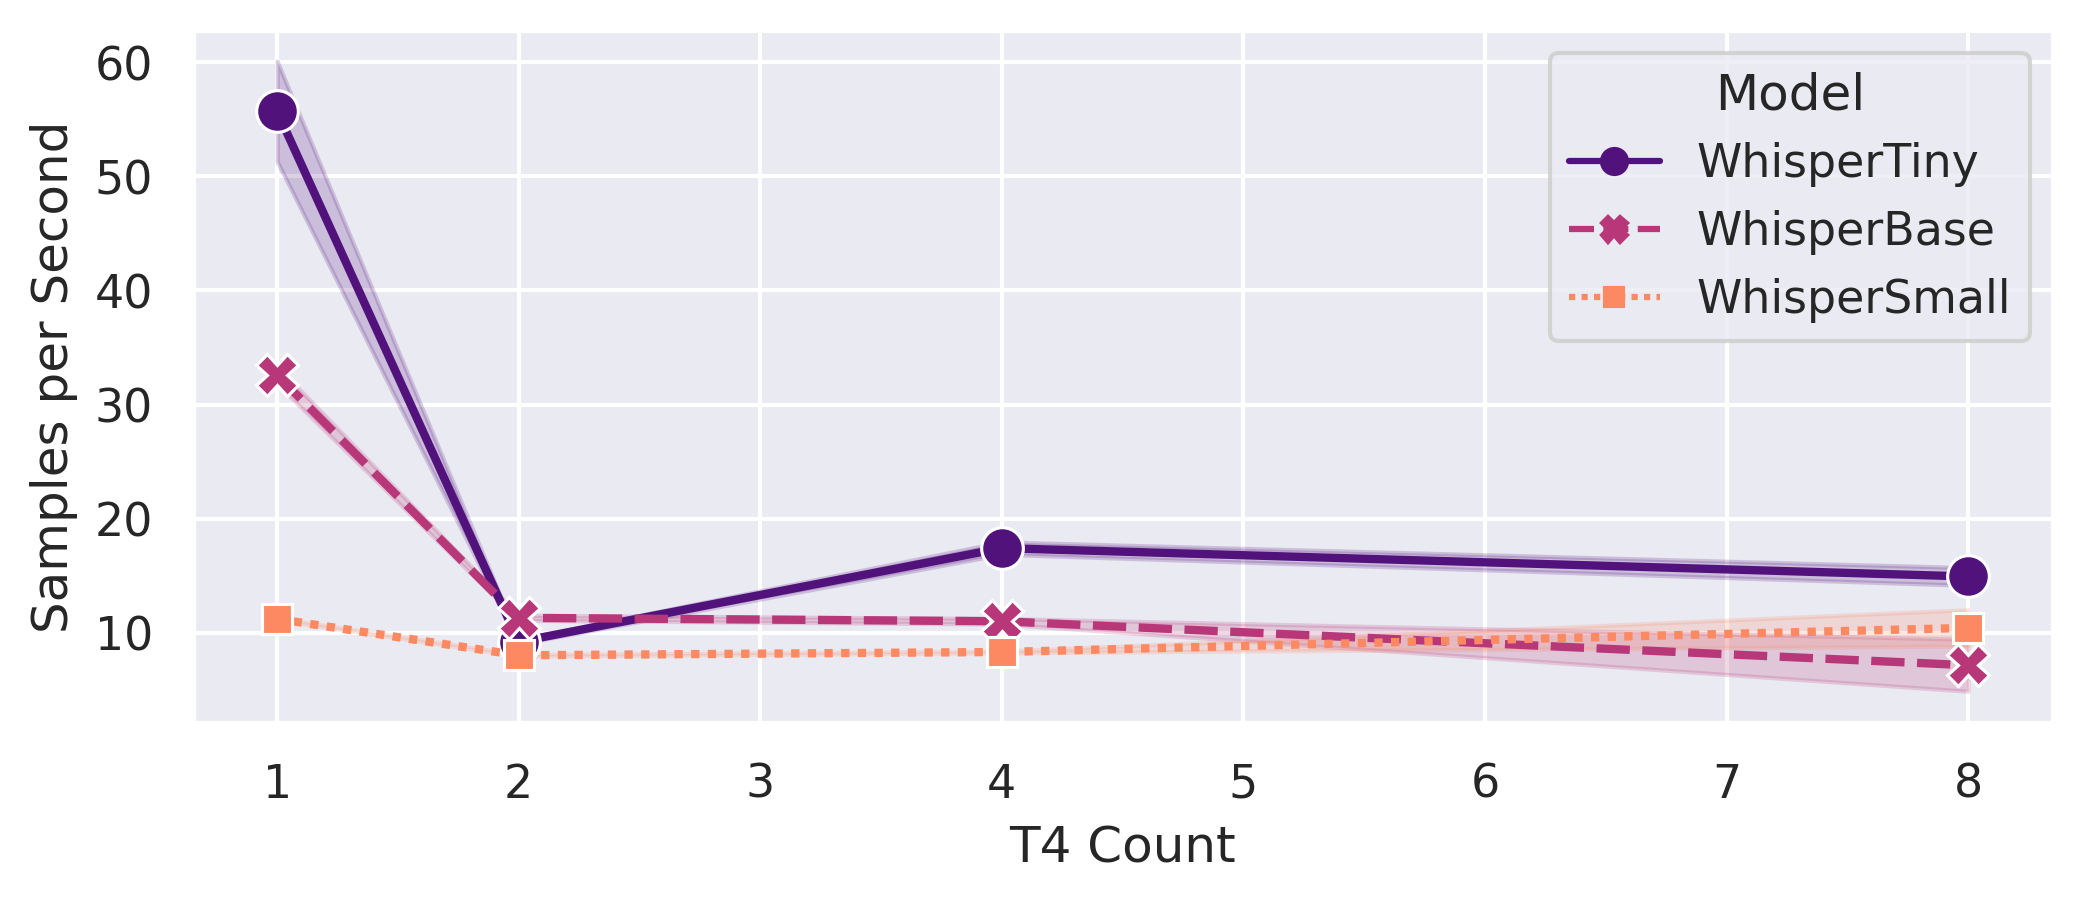

In [7]:
# filter local sps out
temp_df = asr_full_df.query("samples_per_sec.notna()").copy()
sns.set(palette=asr_palette)
plt.figure(figsize=(8,3))
ax = sns.lineplot(
    data=temp_df,
    x="gpu_count", y="samples_per_sec", hue="model", style="model",
    errorbar=('se', 1), dashes=True,
    markers=True,
    linewidth=2.0,
    markersize=10.0
)
#plt.title("Geo-distributed Performance EU-US-ASIA-AUS")
plt.xlabel("T4 Count")
plt.legend(title="Model")
plt.ylabel("Samples per Second")
#plt.ylim(0,700)
#plt.xlim(0,10)
#sns.move_legend(ax, "upper left")#, bbox_to_anchor=(0, -0.15))
save_fig("asr-256-t4-scaling-performance")

In [8]:
debug = False
asr_gran_tiny_2xt4_df = get_granularity_cumulated(run_name="hivemind-375", name="2xT4 Tiny", debug=debug)
asr_gran_tiny_4xt4_df = get_granularity_cumulated(run_name="hivemind-372", name="4xT4 Tiny", debug=debug)
asr_gran_tiny_8xt4_df = get_granularity_cumulated(run_name="hivemind-369", name="8xT4 Tiny", debug=debug)
asr_gran_base_2xt4_df = get_granularity_cumulated(run_name="hivemind-376", name="2xT4 Base", debug=debug)
asr_gran_base_4xt4_df = get_granularity_cumulated(run_name="hivemind-373", name="4xT4 Base", debug=debug)
asr_gran_base_8xt4_df = get_granularity_cumulated(run_name="hivemind-370", name="8xT4 Base", debug=debug)
asr_gran_small_2xt4_df = get_granularity_cumulated(run_name="hivemind-377", name="2xT4 Small", debug=debug)
asr_gran_small_4xt4_df = get_granularity_cumulated(run_name="hivemind-374", name="4xT4 Small", debug=debug)
asr_gran_small_8xt4_df = get_granularity_cumulated(run_name="hivemind-371", name="8xT4 Small", debug=debug)

> Found 2 runs with the infix 'bee'.
> Found 4 runs with the infix 'bee'.
> Found 8 runs with the infix 'bee'.
> Found 2 runs with the infix 'bee'.
> Found 4 runs with the infix 'bee'.
> Found 8 runs with the infix 'bee'.
> Found 2 runs with the infix 'bee'.
> Found 4 runs with the infix 'bee'.
> Found 8 runs with the infix 'bee'.


<Figure size 2400x900 with 0 Axes>

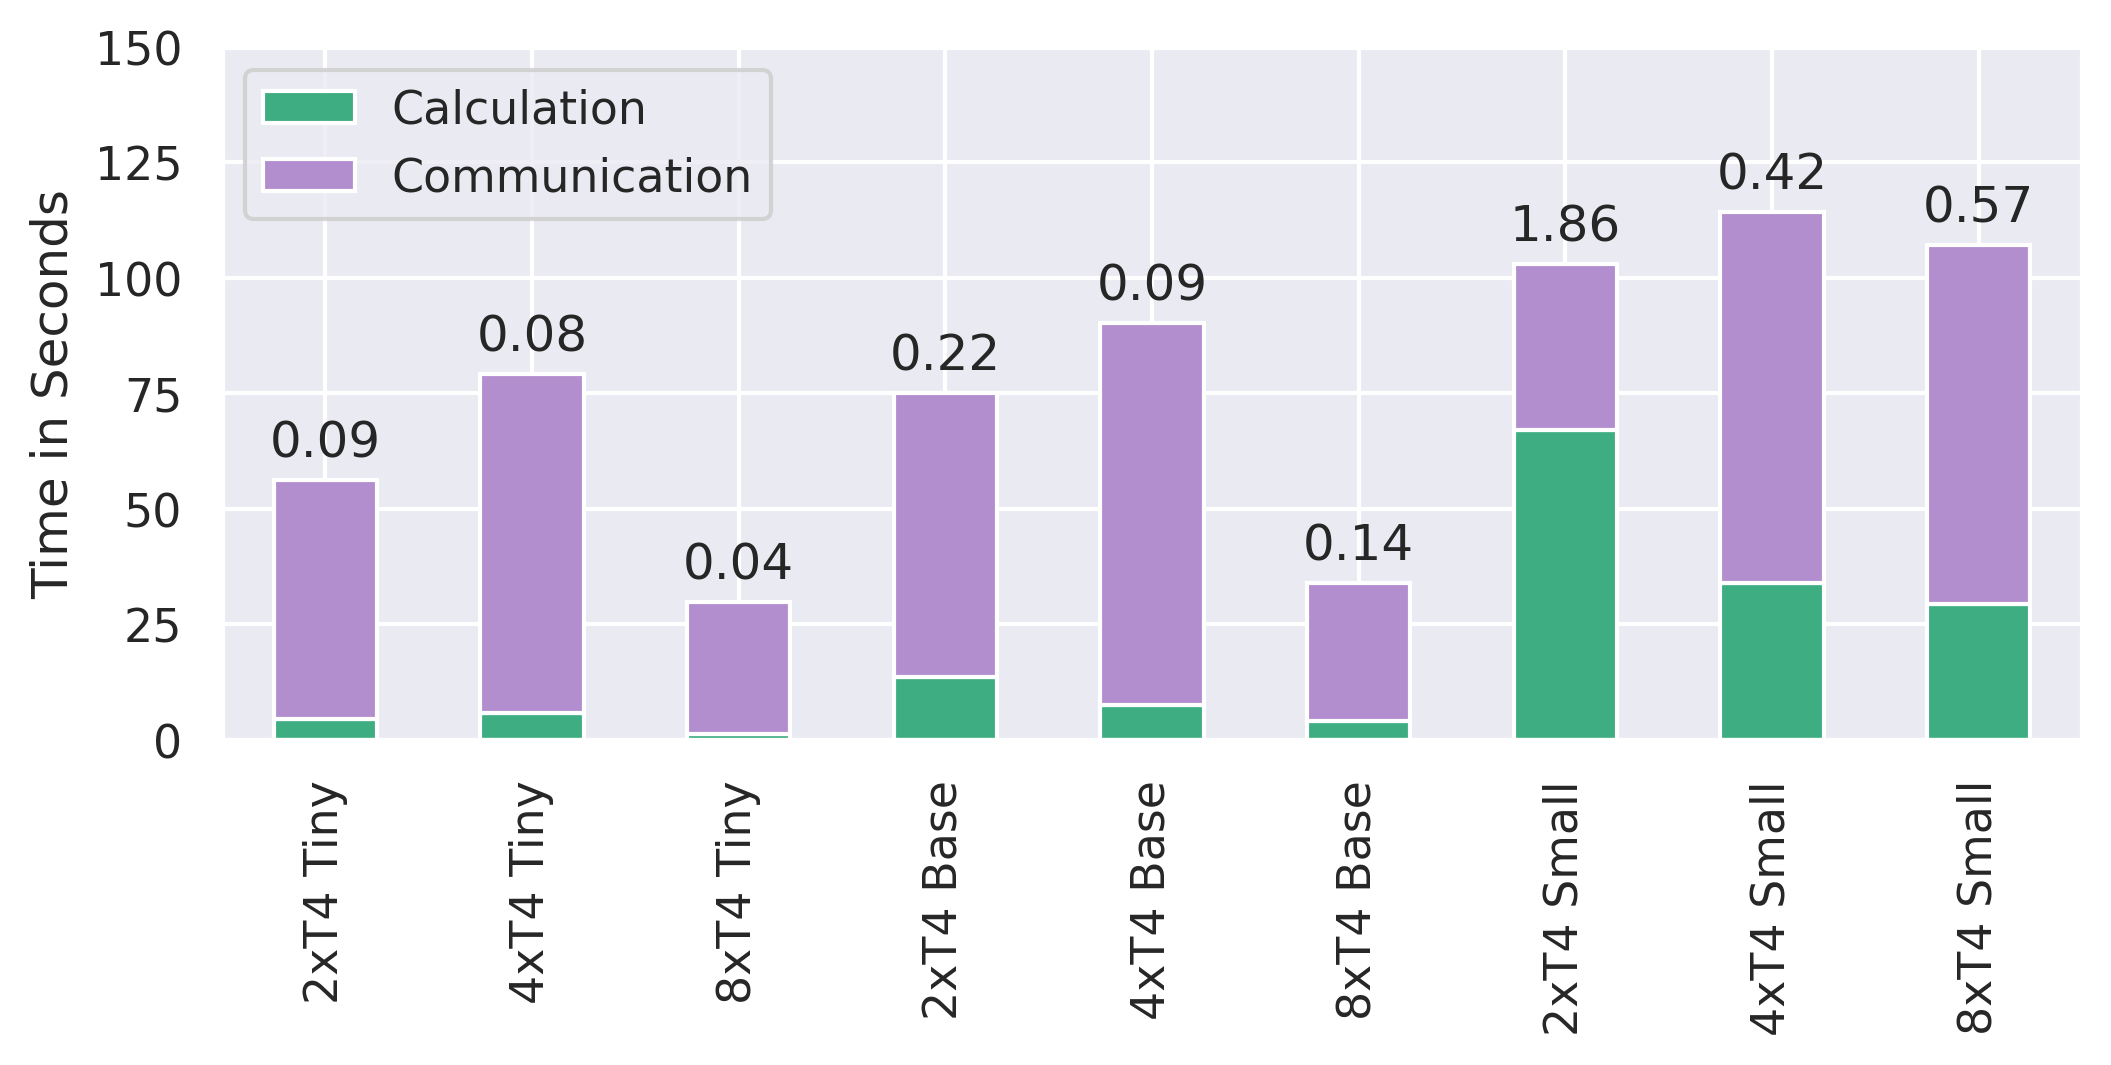

In [9]:
asr_granularity_df = pd.concat(objs=[
    asr_gran_tiny_2xt4_df,
    asr_gran_tiny_4xt4_df,
    asr_gran_tiny_8xt4_df,
    asr_gran_base_2xt4_df,
    asr_gran_base_4xt4_df,
    asr_gran_base_8xt4_df,
    asr_gran_small_2xt4_df,
    asr_gran_small_4xt4_df,
    asr_gran_small_8xt4_df
])

sns.set(palette=granularity_palette)
plt.figure(figsize=(8,3))
ax = asr_granularity_df[["calc_time_s","comm_time_s","name"]].set_index('name').plot(kind='bar', stacked=True, figsize=(8,3))
plt.ylabel("Time in Seconds")
plt.xlabel("")
plt.ylim(0,150)
plt.legend(labels=["Calculation", "Communication"])
#ax.axvline(3.5, color="#6c6c6c", linestyle="--")
#ax.axvline(7.5, color="#6c6c6c", linestyle="--")
show_granulartiy_values(ax=ax, df=asr_granularity_df)
save_fig("asr-256-performance-granularity")

### TBS = 512 + 1024

In [68]:
asr_small_512_1xt4_df = get_baseline_runs(run_names=["baseline-389-whisper-small"])
asr_small_512_1xt4_df = rename_models(df = asr_small_512_1xt4_df)
asr_small_512_1xt4_df["gpu_count"] = int(1)
asr_small_512_1xt4_df["name"] = "H-1.0"
asr_small_512_1xt4_df["gpu_type"] = "T4"
asr_small_512_1xt4_df["TBS"] = 512 # 510 in reality, but rounded in favor of baseline for comparison reasons 

asr_small_512_2xt4_df = get_hivemind_runs(run_names=["hivemind-387"], drop_first_epoch=True)
asr_small_512_2xt4_df = rename_models(df = asr_small_512_2xt4_df)
asr_small_512_2xt4_df["gpu_count"] = int(2)
asr_small_512_2xt4_df["name"] = "H-1.1"
asr_small_512_2xt4_df["gpu_type"] = "T4"

asr_small_512_4xt4_df = get_hivemind_runs(run_names=["hivemind-385"], drop_first_epoch=True)
asr_small_512_4xt4_df = rename_models(df = asr_small_512_4xt4_df)
asr_small_512_4xt4_df["gpu_count"] = int(4)
asr_small_512_4xt4_df["name"] = "H-1.2"
asr_small_512_4xt4_df["gpu_type"] = "T4"

asr_small_512_8xt4_df = get_hivemind_runs(run_names=["hivemind-383"], drop_first_epoch=True)
asr_small_512_8xt4_df = rename_models(df = asr_small_512_8xt4_df)
asr_small_512_8xt4_df["gpu_count"] = int(8)
asr_small_512_8xt4_df["name"] = "H-1.3"
asr_small_512_8xt4_df["gpu_type"] = "T4"

asr_small_512_df = pd.concat(objs=[
    asr_small_512_1xt4_df,
    asr_small_512_2xt4_df,
    asr_small_512_4xt4_df,
    asr_small_512_8xt4_df
])

asr_small_1024_1xt4_df = get_baseline_runs(run_names=["baseline-388-whisper-small"])
asr_small_1024_1xt4_df = rename_models(df = asr_small_1024_1xt4_df)
asr_small_1024_1xt4_df["gpu_count"] = int(1)
asr_small_1024_1xt4_df["name"] = "I-1.0"
asr_small_1024_1xt4_df["gpu_type"] = "T4"
asr_small_1024_1xt4_df["TBS"] = 1024 # 1023 in reality, but rounded in favor of baseline for comparison reasons 

asr_small_1024_2xt4_df = get_hivemind_runs(run_names=["hivemind-386"], drop_first_epoch=True)
asr_small_1024_2xt4_df = rename_models(df = asr_small_1024_2xt4_df)
asr_small_1024_2xt4_df["gpu_count"] = int(2)
asr_small_1024_2xt4_df["name"] = "I-1.1"
asr_small_1024_2xt4_df["gpu_type"] = "T4"

asr_small_1024_4xt4_df = get_hivemind_runs(run_names=["hivemind-384"], drop_first_epoch=True)
asr_small_1024_4xt4_df = rename_models(df = asr_small_1024_4xt4_df)
asr_small_1024_4xt4_df["gpu_count"] = int(4)
asr_small_1024_4xt4_df["name"] = "I-1.2"
asr_small_1024_4xt4_df["gpu_type"] = "T4"

asr_small_1024_8xt4_df = get_hivemind_runs(run_names=["hivemind-382"], drop_first_epoch=True)
asr_small_1024_8xt4_df = rename_models(df = asr_small_1024_8xt4_df)
asr_small_1024_8xt4_df["gpu_count"] = int(8)
asr_small_1024_8xt4_df["name"] = "I-1.3"
asr_small_1024_8xt4_df["gpu_type"] = "T4"

asr_small_1024_df = pd.concat(objs=[
    asr_small_1024_1xt4_df,
    asr_small_1024_2xt4_df,
    asr_small_1024_4xt4_df,
    asr_small_1024_8xt4_df,
    asr_small_1024_1xa100_df
])

asr_small_512_1024_df = pd.concat(objs=[
    asr_small_df,
    asr_small_512_df,
    asr_small_1024_df,
])

> Found 1 runs with the prefix 'trainmonitor'.
> Found 1 runs with the prefix 'trainmonitor'.
> Found 1 runs with the prefix 'trainmonitor'.
> Found 1 runs with the prefix 'trainmonitor'.
> Found 1 runs with the prefix 'trainmonitor'.
> Found 1 runs with the prefix 'trainmonitor'.


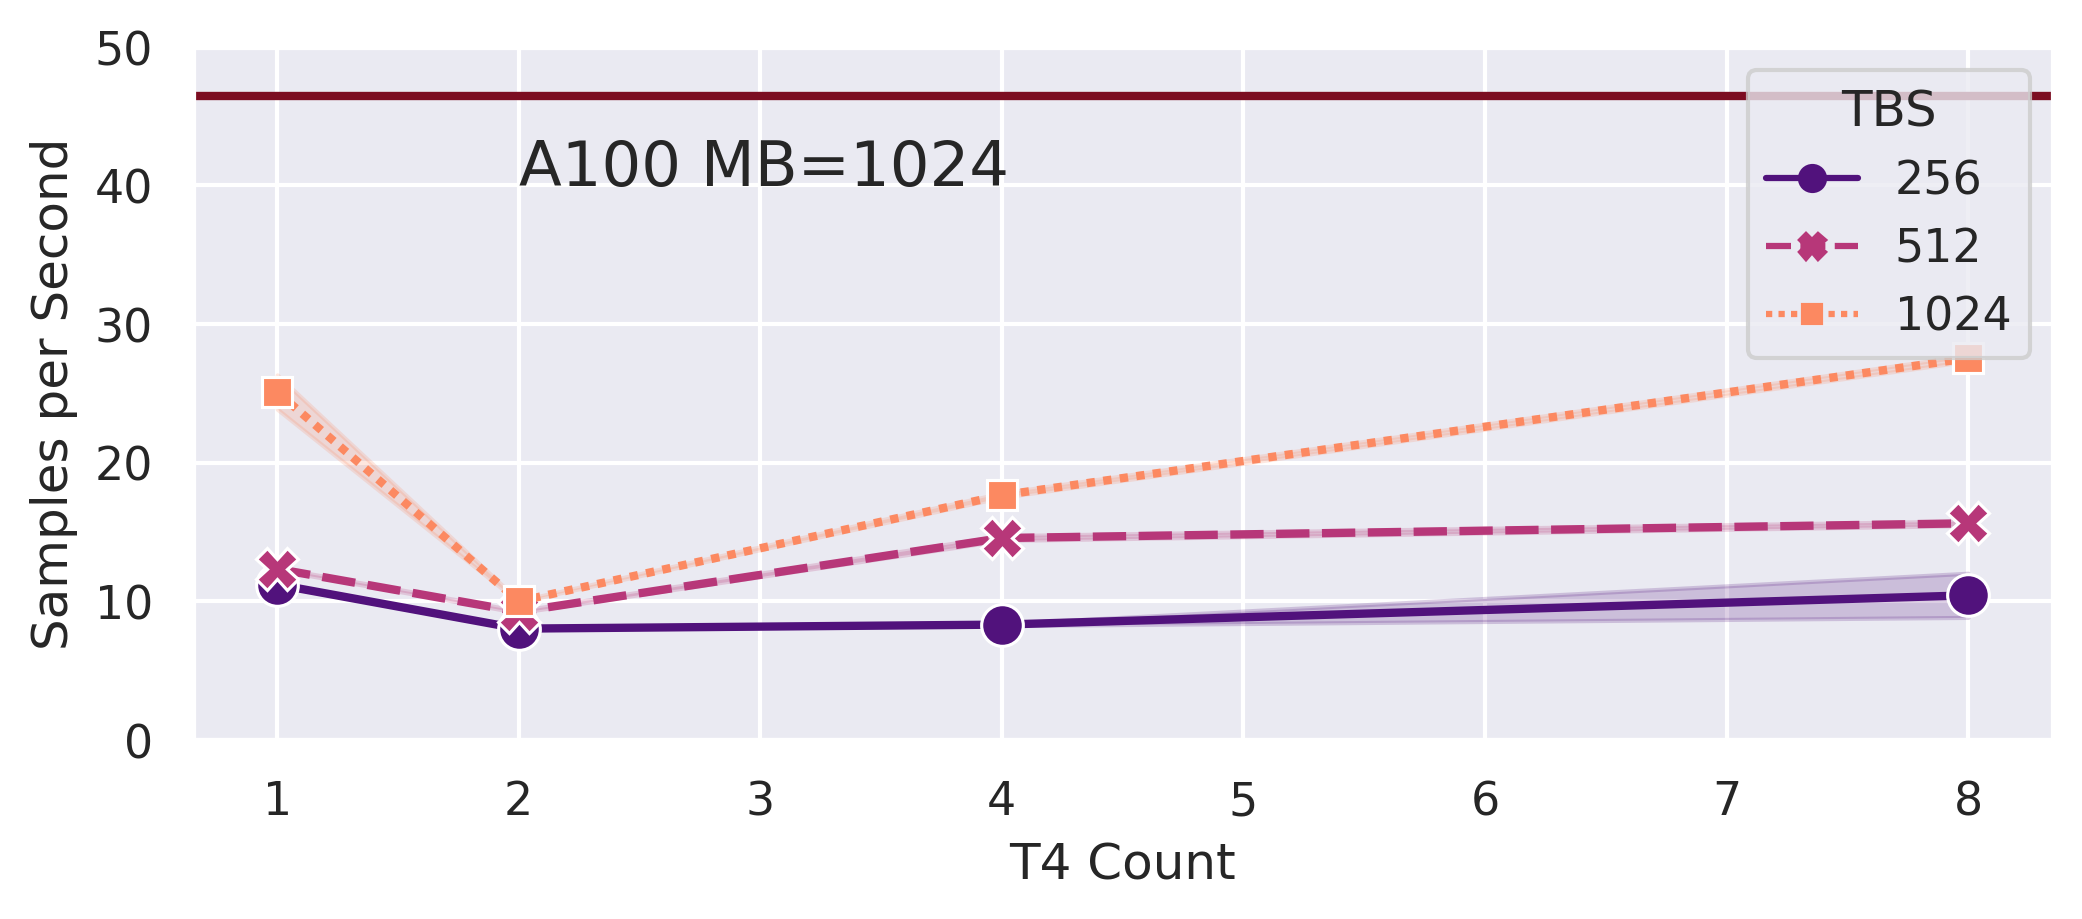

In [82]:
# filter local sps out
temp_df = asr_small_512_1024_df.query("samples_per_sec.notna()").copy()

#sns.set(palette=local_sps_palette)

plt.figure(figsize=(8,3))
ax = sns.lineplot(
    data=temp_df,
    x="gpu_count", y="samples_per_sec", hue="TBS", style="TBS",
    errorbar=('se', 1), dashes=True,
    markers=True,
    linewidth=2.0,
    markersize=10.0,
    palette=asr_palette
)
#plt.title("Geo-distributed Performance EU-US-ASIA-AUS")
plt.xlabel("T4 Count")
plt.legend(title="TBS")
plt.ylabel("Samples per Second")
plt.ylim(0,50)
ax.axhline(46.48, color="#7c0d21", linestyle="-", linewidth=2.0)
ax.text(2, 40, "A100 MB=1024", fontsize=15)
#plt.xlim(0,10)
#sns.move_legend(ax, "upper left")#, bbox_to_anchor=(0, -0.15))
save_fig("asr-small-t4-scaling-performance")

In [47]:
baseline_512_sps = asr_small_512_1xt4_df.query("samples_per_sec.notna()")["samples_per_sec"].mean()
max_512_sps      = asr_small_512_8xt4_df.query("samples_per_sec.notna()")["samples_per_sec"].mean()
print(f"Speedup for TBS=512:  {round(max_512_sps / baseline_512_sps, 2)}x")

baseline_1024_sps = asr_small_1024_1xt4_df.query("samples_per_sec.notna()")["samples_per_sec"].mean()
max_1024_sps      = asr_small_1024_8xt4_df.query("samples_per_sec.notna()")["samples_per_sec"].mean()
print(f"Speedup for TBS=1024: {round(max_1024_sps / baseline_1024_sps, 2)}x")


Speedup for TBS=512:  1.27x
Speedup for TBS=1024: 2.22x


In [37]:
debug = False
asr_gran_small_256_2xt4_df = get_granularity_cumulated(run_name="hivemind-377", name="2xT4", debug=debug)
asr_gran_small_256_4xt4_df = get_granularity_cumulated(run_name="hivemind-374", name="4xT4", debug=debug)
asr_gran_small_256_8xt4_df = get_granularity_cumulated(run_name="hivemind-371", name="8xT4", debug=debug)
asr_gran_small_512_2xt4_df = get_granularity_cumulated(run_name="hivemind-387", name="2xT4", debug=debug)
asr_gran_small_512_4xt4_df = get_granularity_cumulated(run_name="hivemind-385", name="4xT4", debug=debug)
asr_gran_small_512_8xt4_df = get_granularity_cumulated(run_name="hivemind-383", name="8xT4", debug=debug)
asr_gran_small_1024_2xt4_df = get_granularity_cumulated(run_name="hivemind-386", name="2xT4", debug=debug)
asr_gran_small_1024_4xt4_df = get_granularity_cumulated(run_name="hivemind-384", name="4xT4", debug=debug)
asr_gran_small_1024_8xt4_df = get_granularity_cumulated(run_name="hivemind-382", name="8xT4", debug=debug)

> Found 2 runs with the infix 'bee'.
> Found 4 runs with the infix 'bee'.
> Found 8 runs with the infix 'bee'.
> Found 2 runs with the infix 'bee'.
> Found 4 runs with the infix 'bee'.
> Found 8 runs with the infix 'bee'.
> Found 2 runs with the infix 'bee'.
> Found 4 runs with the infix 'bee'.
> Found 8 runs with the infix 'bee'.


<Figure size 2400x900 with 0 Axes>

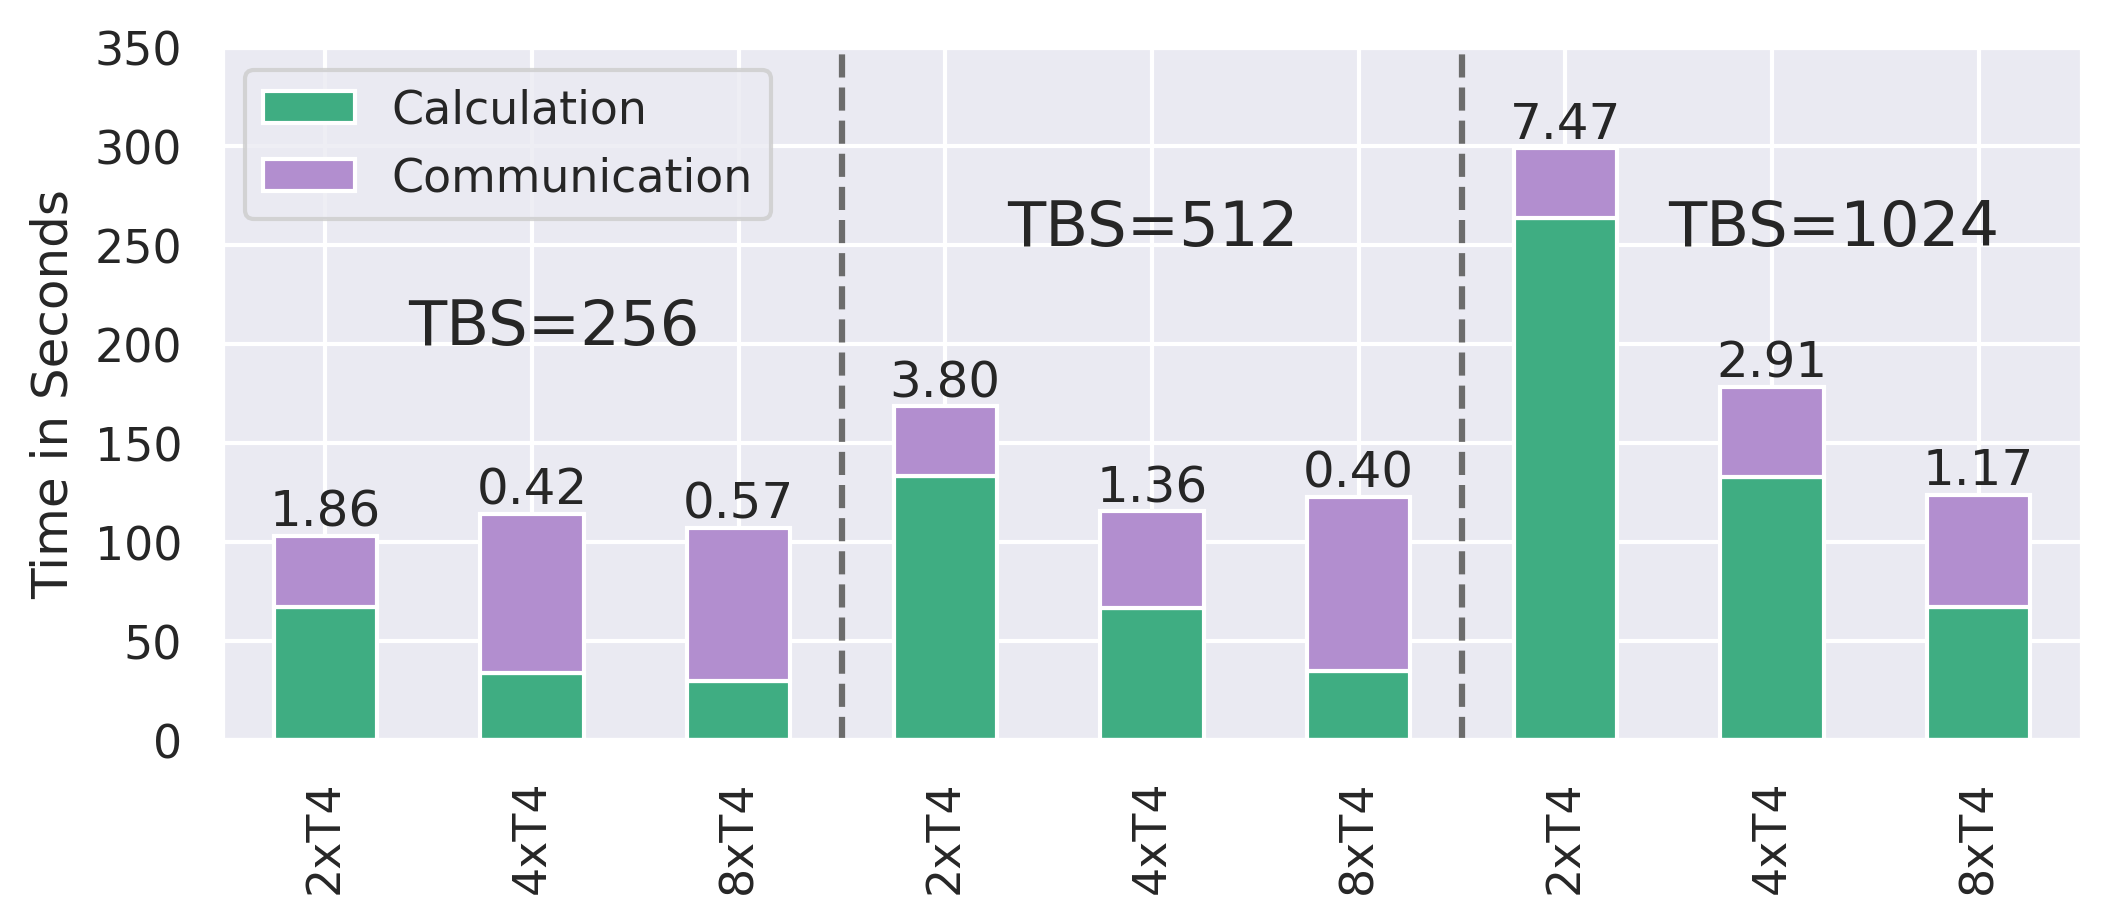

In [38]:
asr_gran_small_full_df = pd.concat(objs=[
    asr_gran_small_256_2xt4_df,
    asr_gran_small_256_4xt4_df,
    asr_gran_small_256_8xt4_df,
    asr_gran_small_512_2xt4_df,
    asr_gran_small_512_4xt4_df,
    asr_gran_small_512_8xt4_df,
    asr_gran_small_1024_2xt4_df,
    asr_gran_small_1024_4xt4_df,
    asr_gran_small_1024_8xt4_df,
])

sns.set(palette=granularity_palette)
plt.figure(figsize=(8,3))
ax = asr_gran_small_full_df[["calc_time_s","comm_time_s","name"]].set_index('name').plot(kind='bar', stacked=True, figsize=(8,3))
plt.ylabel("Time in Seconds")
plt.xlabel("")
plt.ylim(0,350)
plt.legend(labels=["Calculation", "Communication"])
ax.axvline(2.5, color="#6c6c6c", linestyle="--")
ax.axvline(5.5, color="#6c6c6c", linestyle="--")
ax.text(0.4, 200, "TBS=256", fontsize=15)
ax.text(3.3, 250, "TBS=512", fontsize=15)
ax.text(6.5, 250, "TBS=1024", fontsize=15)
sns.move_legend(ax, "upper left")#, bbox_to_anchor=(0, -0.15))
show_granulartiy_values(ax=ax, df=asr_gran_small_full_df)
save_fig("asr-small-performance-granularity")

In [17]:
# GC Cost 0.23 per T4 8-core GPU

In [56]:
asr_small_1024_1xa100_df = get_baseline_runs(run_names=["baseline-390-whisper-small"])
asr_small_1024_1xa100_df = rename_models(df = asr_small_1024_1xa100_df)
asr_small_1024_1xa100_df["gpu_count"] = int(1)
asr_small_1024_1xa100_df["name"] = "J-1.1"
asr_small_1024_1xa100_df["gpu_type"] = "A100"
asr_small_1024_1xa100_df["TBS"] = 1024

In [59]:
temp_df = asr_small_1024_1xa100_df.query("samples_per_sec.notna()").copy()
print(f"A100 Throughput 1024 MB=1024: {round(temp_df['samples_per_sec'].mean(),2)}")

A100 Throughput 1024 MB=1024: 46.48


In [61]:
a100_cost = 2.03   # 2 Okt 2023
t4_cost = 0.16 * 8 # 2 Okt 2023
print(f"A100 $/h: {a100_cost}")
print(f"T4x8 $/h: {t4_cost}")

A100 $/h: 2.03
T4x8 $/h: 1.28


In [79]:
2.03 / 60 / 60 / 46 * 1000 * 1000

12.258454106280194

In [80]:
1.12 / 60 / 60 / 27.8 * 1000 * 1000

11.191047162270184